In [1]:
import datetime
import numpy as np
import graphlab as gl
from copy import deepcopy
from sklearn import tree
import graphviz 
from string import ascii_letters
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This non-commercial license of GraphLab Create for academic use is assigned to vidurk@vt.edu and will expire on April 29, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1525218097.log


In [34]:
#Load Training dataset
dataFull = gl.SFrame.read_csv('train.csv', verbose=False)

In [35]:
#Used to Sample the data. Codes run on full dataset for better results
#dataBackup = dataFull.sample(0.05, seed=5)
#data = deepcopy(dataBackup)
data = dataFull

In [ ]:
dataFull = None #To Clear RAM

In [36]:
data.head(1)

Columns:
	id	str
	click	int
	hour	int
	C1	int
	banner_pos	int
	site_id	str
	site_domain	str
	site_category	str
	app_id	str
	app_domain	str
	app_category	str
	device_id	str
	device_ip	str
	device_model	str
	device_type	int
	device_conn_type	int
	C14	int
	C15	int
	C16	int
	C17	int
	C18	int
	C19	int
	C20	int
	C21	int

Rows: 1

Data:
+----------------------+-------+----------+------+------------+----------+
|          id          | click |   hour   |  C1  | banner_pos | site_id  |
+----------------------+-------+----------+------+------------+----------+
| 10024438216634663579 |   0   | 14102100 | 1005 |     0      | 1fbe01fe |
+----------------------+-------+----------+------+------------+----------+
+-------------+---------------+----------+------------+--------------+-----------+
| site_domain | site_category |  app_id  | app_domain | app_category | device_id |
+-------------+---------------+----------+------------+--------------+-----------+
|   f3845767  |    28905ebd   | ecad2386 |  7801e8d9  |   07d7df22   |  a99f214a |
+-------------+---------------+----------+------------+--------------+-----------+
+-----------+--------------+-------------+------------------+-------+-----+-----+
| device_ip | device_model | device_type | device_conn_type |  C14  | C15 | C16 |
+-----------+--------------+-------------+------------------+-------+-----+-----+
|  869e9ee0 |   8ce34352   |      1      |        0         | 15701 | 320 |  50 |
+-----------+--------------+-------------+------------------+-------+-----+-----+
+------+-----+
| C17  | ... |
+------+-----+
| 1722 | ... |
+------+-----+
[1 rows x 24 columns]

In [37]:
data.show()

Canvas is accessible via web browser at the URL: http://localhost:54907/index.html
Opening Canvas in default web browser.


In [38]:
data['device_type'] = data['device_type'].astype(str)
data['C1'] = data['C1'].astype(str)
data['hour'] = data['hour'].astype(str)

In [39]:
#To get the date of record
def GetDate(date_raw):
    return date_raw[4:6]

In [40]:
data['date']=data['hour']
data['date']=data['date'].apply(GetDate)

In [41]:
#TO classify whether record is of weekend or weekday
def isItAWeekDay(timeStamp):
    timeStamp = str(timeStamp)
    year  = int(timeStamp[0:2])
    month = int(timeStamp[2:4])
    day   = int(timeStamp[4:6])
    off = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    a = 1
    if month > 2: a = 0
    x = year - 1700 - a
    dow  = 5
    dow += (x + a) * 365
    dow += x / 4 - x / 100 + (x + 100) / 400     
    dow += off[month - 1] + (day - 1)               
    dow %= 7
    if dow == 0 or dow == 6: return 0; #Sunday or Saturday
    return 1;

In [42]:
#To separate the hours from timestamp
def keepHour(timeStamp):
    timeStamp = str(timeStamp)
    return timeStamp[-2:];

In [43]:
data['isWeekDay'] = data['hour']
data['isWeekDay'] = data['isWeekDay'].apply(isItAWeekDay)
data['hour'] = data['hour'].apply(keepHour)
data['area'] = data['C15']*data['C16'];
data['hour']= data['hour'].astype(int);

In [44]:
data.head(1)

Columns:
	id	str
	click	int
	hour	int
	C1	str
	banner_pos	int
	site_id	str
	site_domain	str
	site_category	str
	app_id	str
	app_domain	str
	app_category	str
	device_id	str
	device_ip	str
	device_model	str
	device_type	str
	device_conn_type	int
	C14	int
	C15	int
	C16	int
	C17	int
	C18	int
	C19	int
	C20	int
	C21	int
	date	str
	isWeekDay	int
	area	int

Rows: 1

Data:
+----------------------+-------+------+------+------------+----------+-------------+
|          id          | click | hour |  C1  | banner_pos | site_id  | site_domain |
+----------------------+-------+------+------+------------+----------+-------------+
| 10024438216634663579 |   0   |  0   | 1005 |     0      | 1fbe01fe |   f3845767  |
+----------------------+-------+------+------+------------+----------+-------------+
+---------------+----------+------------+--------------+-----------+-----------+
| site_category |  app_id  | app_domain | app_category | device_id | device_ip |
+---------------+----------+------------+--------------+-----------+-----------+
|    28905ebd   | ecad2386 |  7801e8d9  |   07d7df22   |  a99f214a |  869e9ee0 |
+---------------+----------+------------+--------------+-----------+-----------+
+--------------+-------------+------------------+-------+-----+-----+------+-----+
| device_model | device_type | device_conn_type |  C14  | C15 | C16 | C17  | ... |
+--------------+-------------+------------------+-------+-----+-----+------+-----+
|   8ce34352   |      1      |        0         | 15701 | 320 |  50 | 1722 | ... |
+--------------+-------------+------------------+-------+-----+-----+------+-----+
[1 rows x 27 columns]

In [45]:
#Mean of clicks in Dataset
data['click'].mean()

0.17057237660721697

In [13]:
data.groupby('C1', {'CTR':gl.aggregate.MEAN('click')})

Columns:
	C1	str
	CTR	float

Rows: 7

Data:
+------+-----------------+
|  C1  |       CTR       |
+------+-----------------+
| 1007 |  0.04075307083  |
| 1005 |  0.16935483871  |
| 1008 |  0.108857336038 |
| 1010 | 0.0960374814913 |
| 1002 |  0.211081118606 |
| 1012 |  0.171373171162 |
| 1001 | 0.0362782757149 |
+------+-----------------+
[7 rows x 2 columns]

In [14]:
adClicksPerHour=data.groupby('hour', {'CTR':gl.aggregate.SUM('click')})

In [15]:
totalAdsPerHour=data.groupby('hour', {'CTR':gl.aggregate.COUNT('click')})
totalAdNonClicksPerHour=[];
for i in range (24):
    totalAdNonClicksPerHour.append(int(totalAdsPerHour[i]['CTR']) - int(adClicksPerHour[i]['CTR']));    
print totalAdNonClicksPerHour

[173291, 419936, 169918, 451191, 364827, 452882, 459562, 288663, 200697, 365284, 426878, 496464, 252171, 437454, 426078, 235881, 273992, 414722, 402427, 208925, 189623, 477933, 380758, 419115]


In [16]:
print adClicksPerHour["CTR"]
print totalAdNonClicksPerHour

[37903, 92307, 35216, 86699, 73491, 97478, 94391, 60895, 45978, 74100, 87409, 100577, 53746, 85769, 94559, 44883, 54355, 81008, 76522, 39661, 37153, 91168, 82863, 88307]
[173291, 419936, 169918, 451191, 364827, 452882, 459562, 288663, 200697, 365284, 426878, 496464, 252171, 437454, 426078, 235881, 273992, 414722, 402427, 208925, 189623, 477933, 380758, 419115]


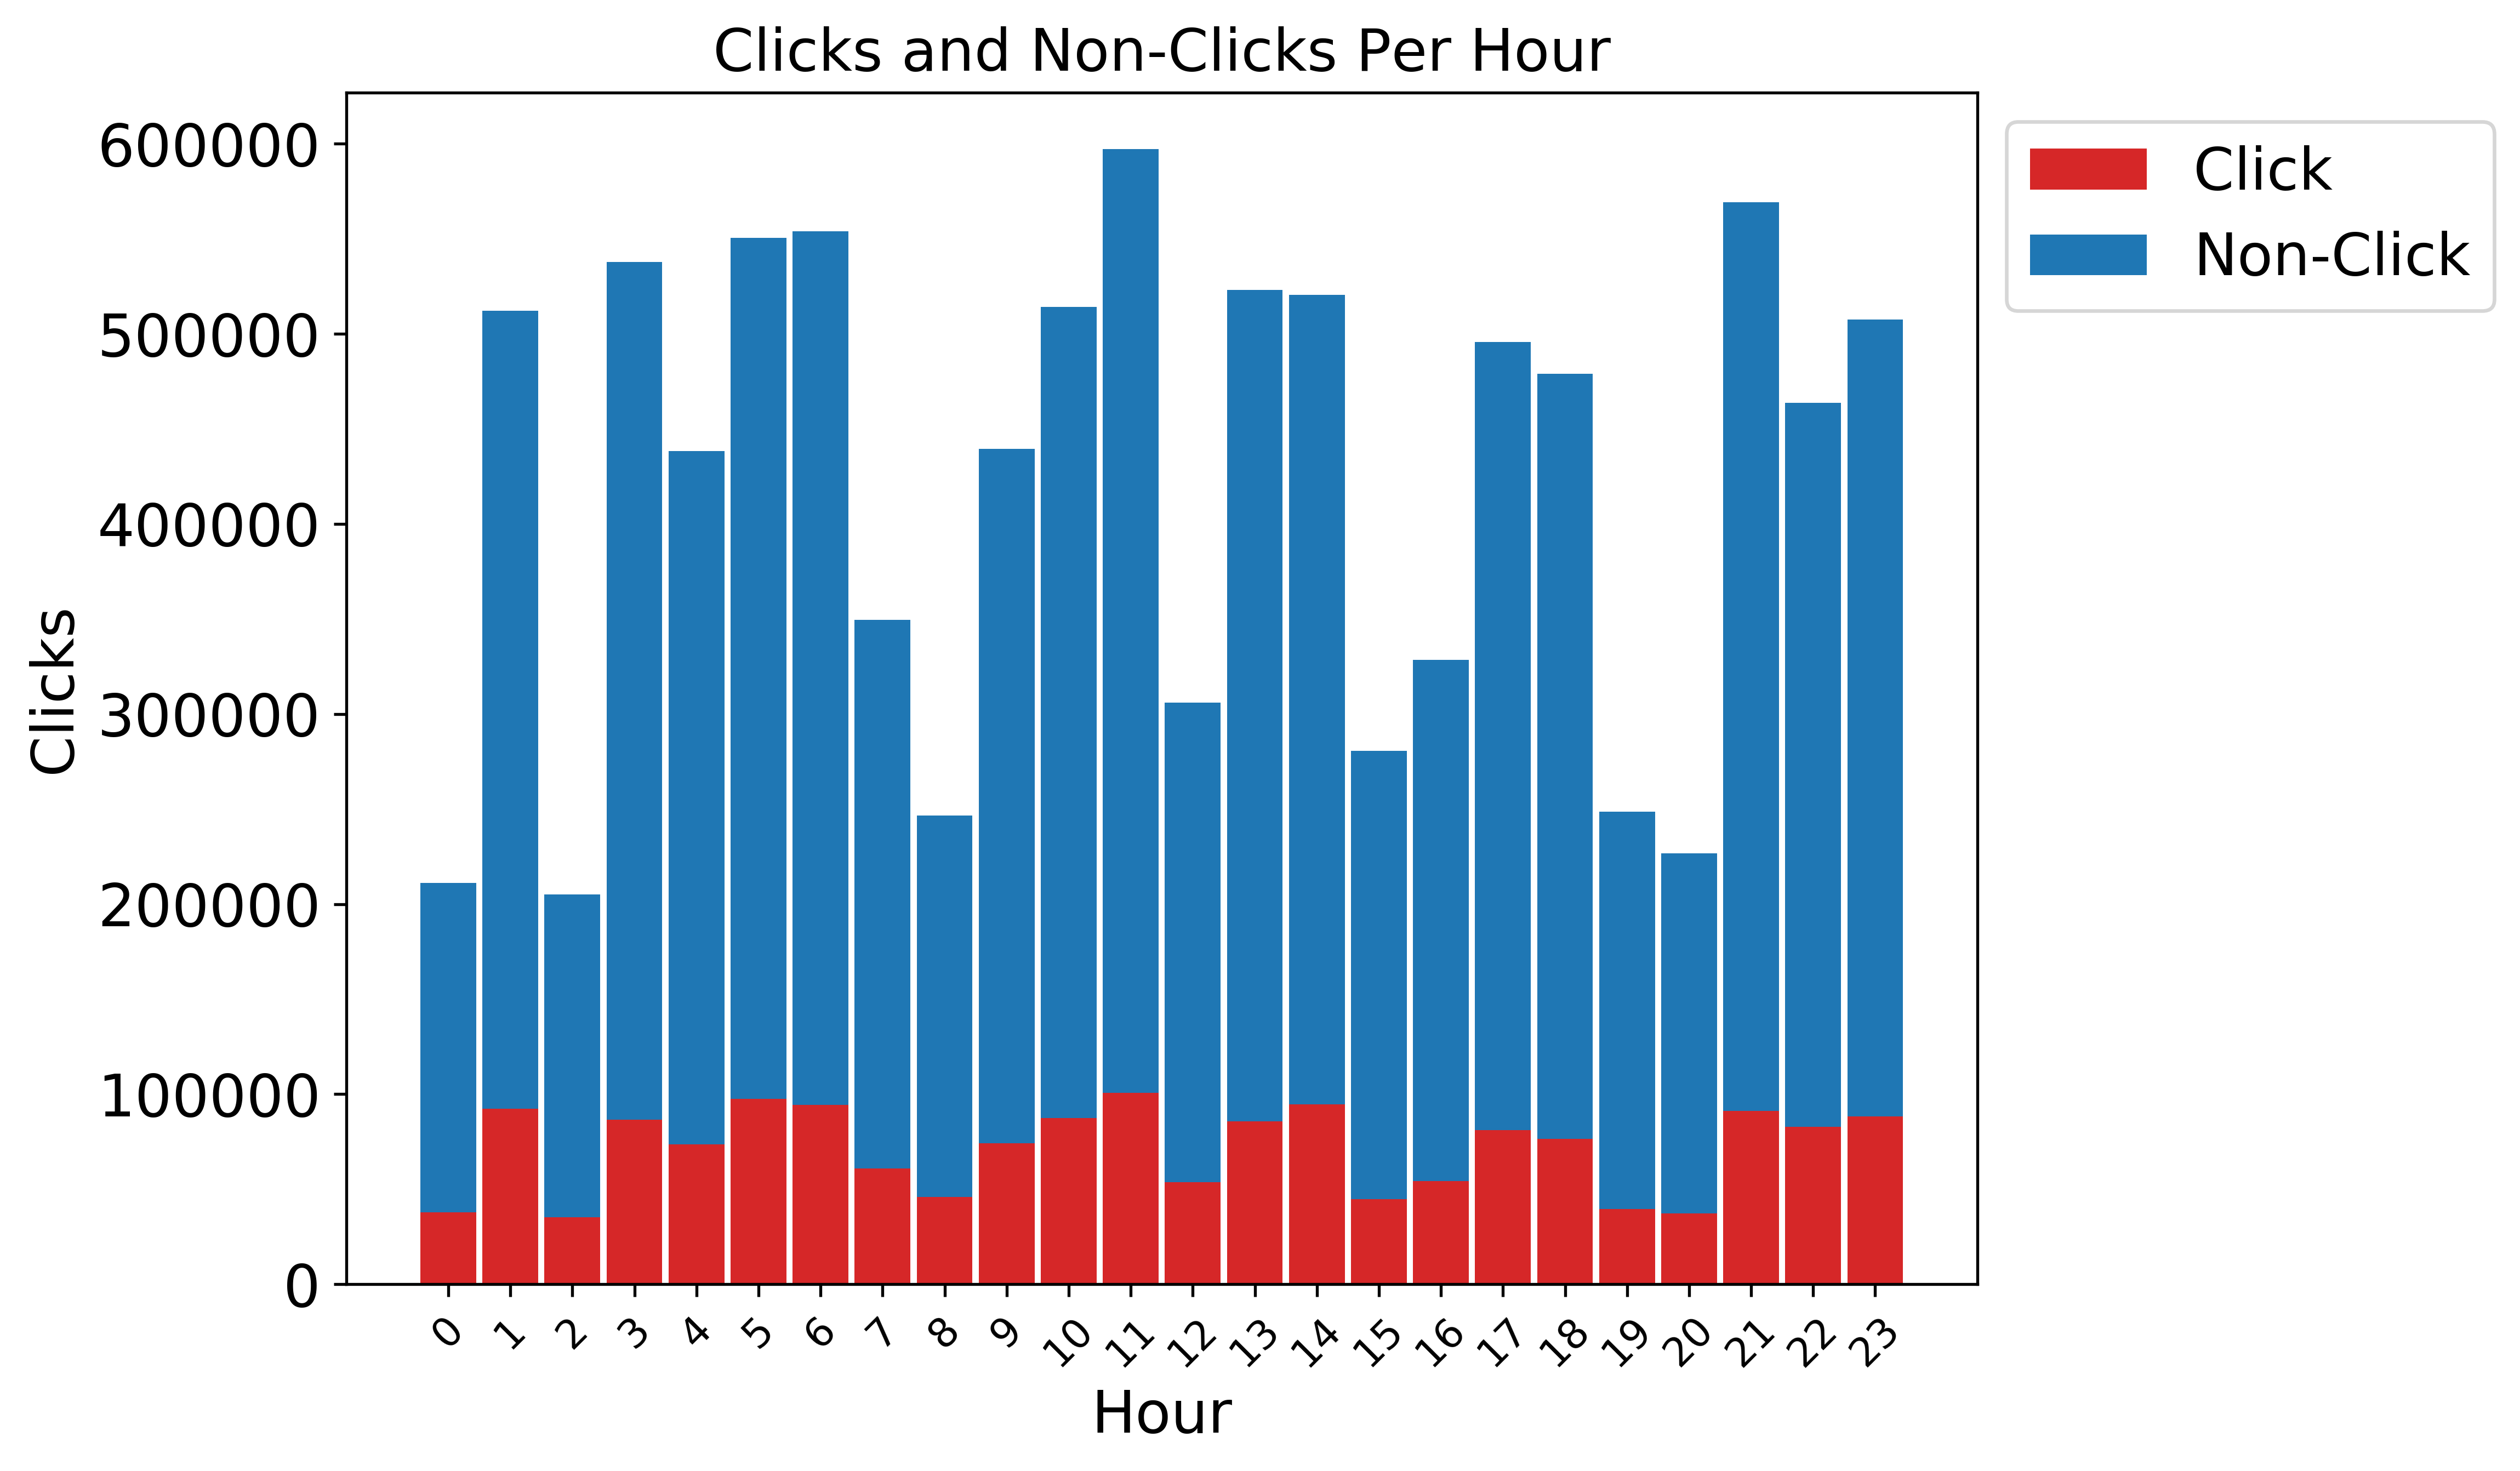

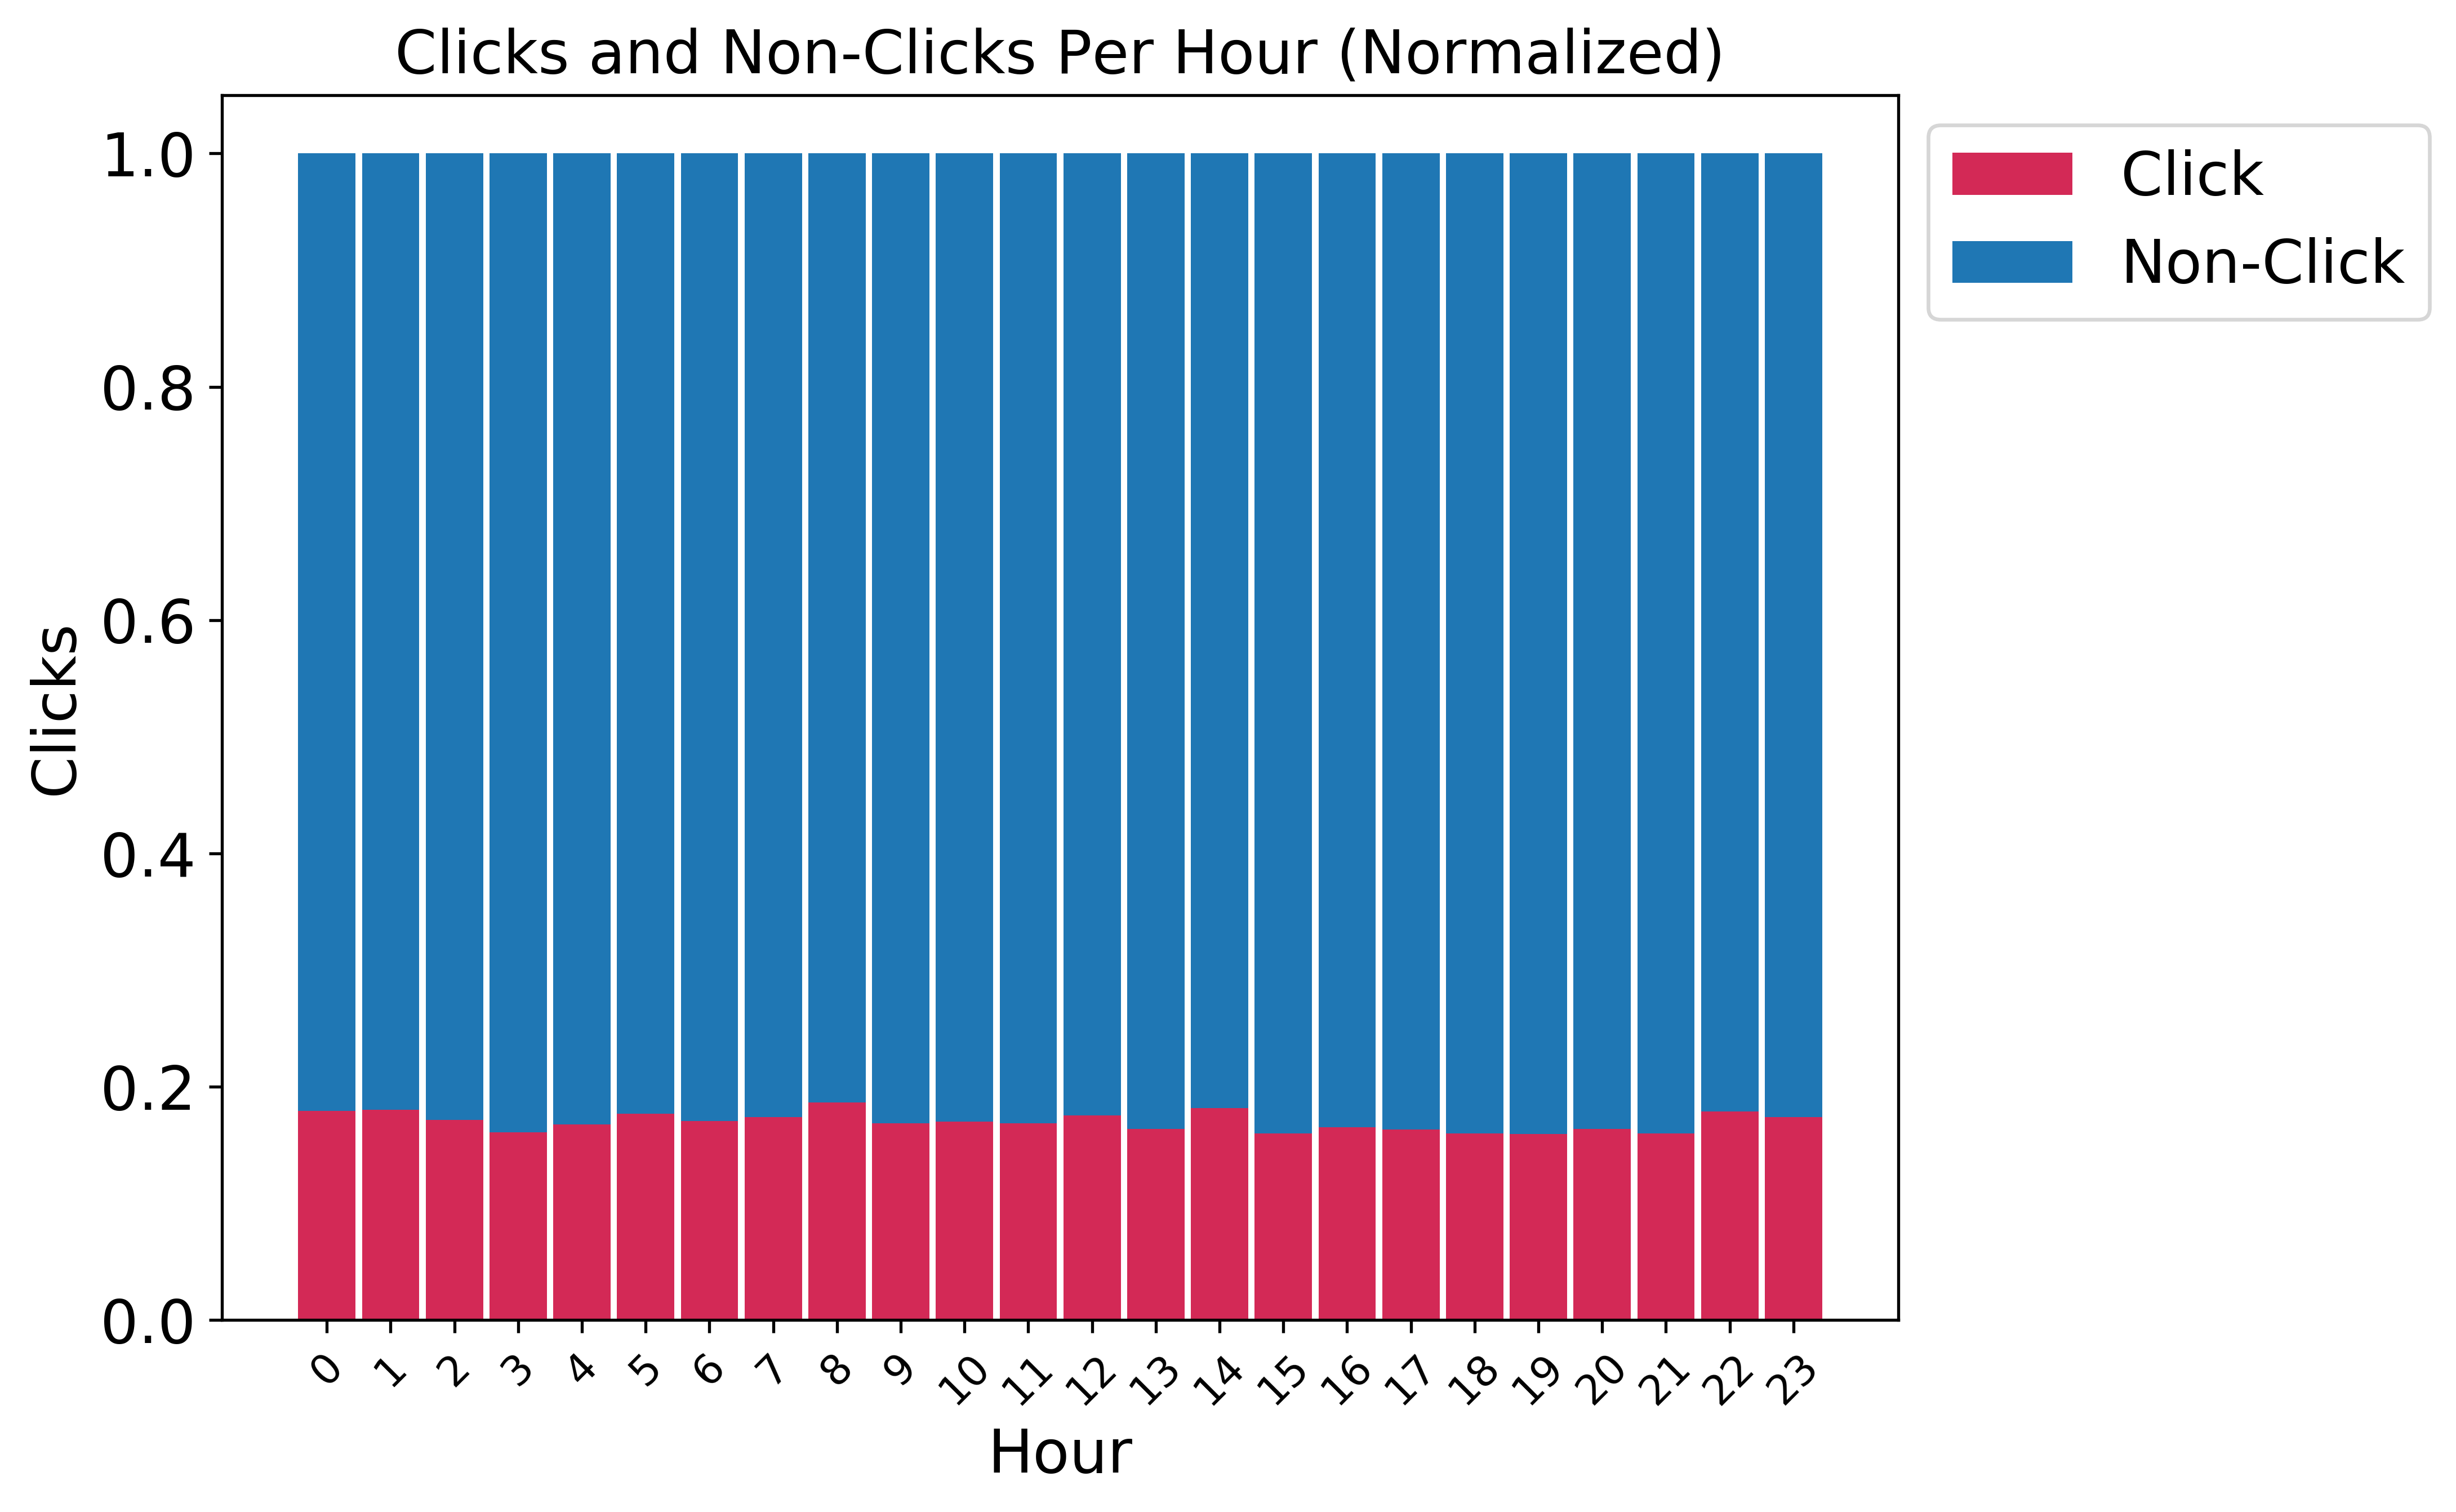

In [17]:
#Plot for Click and Non- Clicks per Hour
fig,ax=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
N = 24
a = adClicksPerHour["CTR"]
b = totalAdNonClicksPerHour
index = np.arange(N)    
width = 0.90       

p1 = plt.bar(index, a, width, color='#d62728')
p2 = plt.bar(index, b, width,
             bottom=a)

plt.xticks(index,rotation=45, fontsize = 11)
plt.yticks(fontsize = 16)
plt.ylabel('Clicks',fontsize = 16)
plt.xlabel('Hour',fontsize = 16)
plt.title('Clicks and Non-Clicks Per Hour',fontsize = 16)
plt.legend((p1[0], p2[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1),fontsize = 16)

plt.show()
fig.savefig('ClickPerHour.png', bbox_inches='tight')

#Plot for Click Rate per Hours
fig1,ax1=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
N = 24
a = adClicksPerHour["CTR"]/totalAdsPerHour["CTR"]
b = 1-(adClicksPerHour["CTR"]/totalAdsPerHour["CTR"])
index = np.arange(N)    
width = 0.90       
p1 = plt.bar(index, a, width, color='#d32956')
p2 = plt.bar(index, b, width,
             bottom=a)

plt.xticks(index,rotation=45, fontsize = 11)
plt.yticks(fontsize = 16)
plt.ylabel('Clicks',fontsize = 16)
plt.xlabel('Hour',fontsize = 16)
plt.title('Clicks and Non-Clicks Per Hour (Normalized)',fontsize = 16)
plt.legend((p1[0], p2[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1),fontsize = 16)

plt.show()

fig1.savefig('ClickRatePerHour.png', bbox_inches='tight')

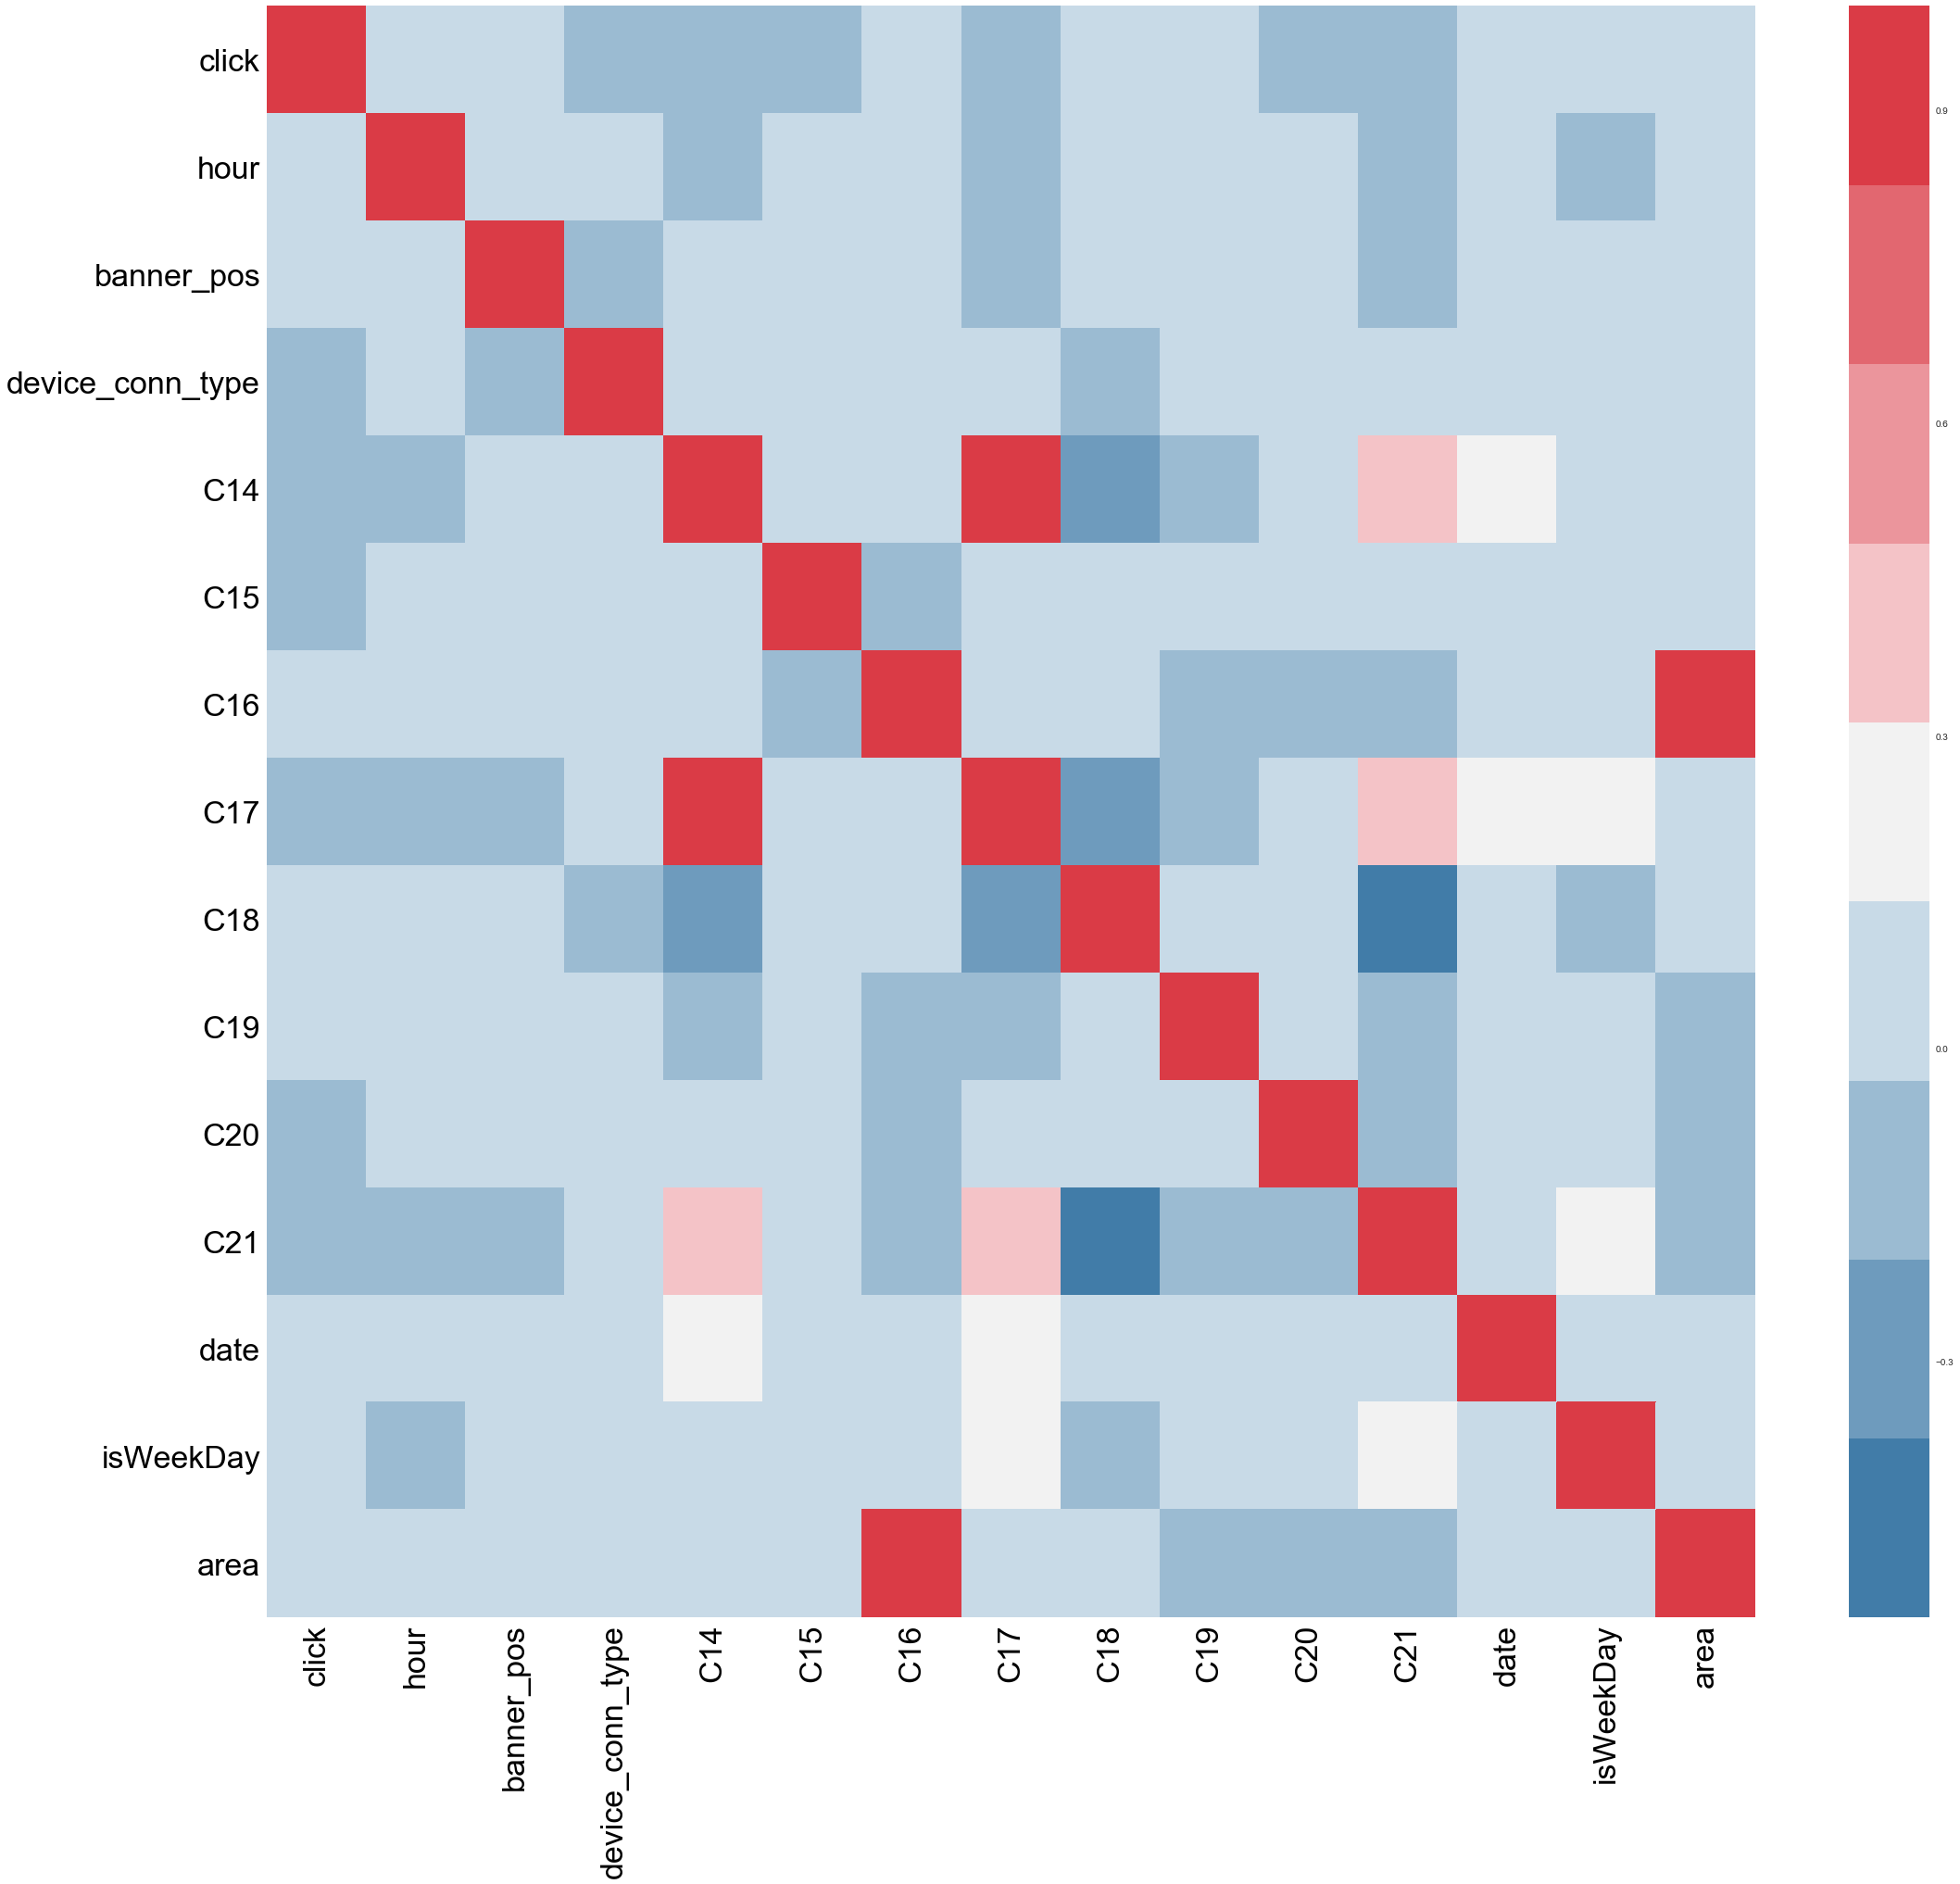

In [33]:
#Correlation Matrix HeatMap

data['date'] = data['date'].astype(int)
# Set up the matplotlib figure for the Correlation Matrix
fig, ax = plt.subplots(figsize=(11, 9))


sns.set(style="white")

dataFrame=gl.SFrame.to_dataframe(data)

# Compute the correlation matrix of the DataSet
correlationMatrix = dataFrame.corr()


# Generate the colormap
colorMap =sns.diverging_palette(240, 10, n=9)

corrHeatmap=sns.heatmap(correlationMatrix, cmap=colorMap)
corrHeatmap.figure.set_size_inches(36,32)
corrHeatmap.tick_params(labelsize=34,labelcolor="black")
fig.savefig("Heatmap.png")

In [32]:
data.head(1)

Columns:
	id	str
	click	int
	hour	int
	C1	str
	banner_pos	int
	site_id	str
	site_domain	str
	site_category	str
	app_id	str
	app_domain	str
	app_category	str
	device_id	str
	device_ip	str
	device_model	str
	device_type	str
	device_conn_type	int
	C14	int
	C15	int
	C16	int
	C17	int
	C18	int
	C19	int
	C20	int
	C21	int
	date	str
	isWeekDay	int
	area	int

Rows: 1

Data:
+----------------------+-------+------+------+------------+----------+-------------+
|          id          | click | hour |  C1  | banner_pos | site_id  | site_domain |
+----------------------+-------+------+------+------------+----------+-------------+
| 10000720757801103869 |   0   |  0   | 1005 |     0      | d6137915 |   bb1ef334  |
+----------------------+-------+------+------+------------+----------+-------------+
+---------------+----------+------------+--------------+-----------+-----------+
| site_category |  app_id  | app_domain | app_category | device_id | device_ip |
+---------------+----------+------------+--------------+-----------+-----------+
|    f028772b   | ecad2386 |  7801e8d9  |   07d7df22   |  a99f214a |  05241af0 |
+---------------+----------+------------+--------------+-----------+-----------+
+--------------+-------------+------------------+-------+-----+-----+------+-----+
| device_model | device_type | device_conn_type |  C14  | C15 | C16 | C17  | ... |
+--------------+-------------+------------------+-------+-----+-----+------+-----+
|   8a4875bd   |      1      |        0         | 16920 | 320 |  50 | 1899 | ... |
+--------------+-------------+------------------+-------+-----+-----+------+-----+
[1 rows x 27 columns]

In [19]:
adClicksForWeekdays=data.groupby('isWeekDay', {'CTR':gl.aggregate.SUM('click')})
print adClicksForWeekdays

+-----------+---------+
| isWeekDay |   CTR   |
+-----------+---------+
|     0     |  328107 |
|     1     | 1388331 |
+-----------+---------+
[2 rows x 2 columns]



In [20]:
totalClicksForWeek=data.groupby('isWeekDay', {'CTR':gl.aggregate.COUNT('click')})
print totalClicksForWeek

+-----------+---------+
| isWeekDay |   CTR   |
+-----------+---------+
|     0     | 1799408 |
|     1     | 8305702 |
+-----------+---------+
[2 rows x 2 columns]



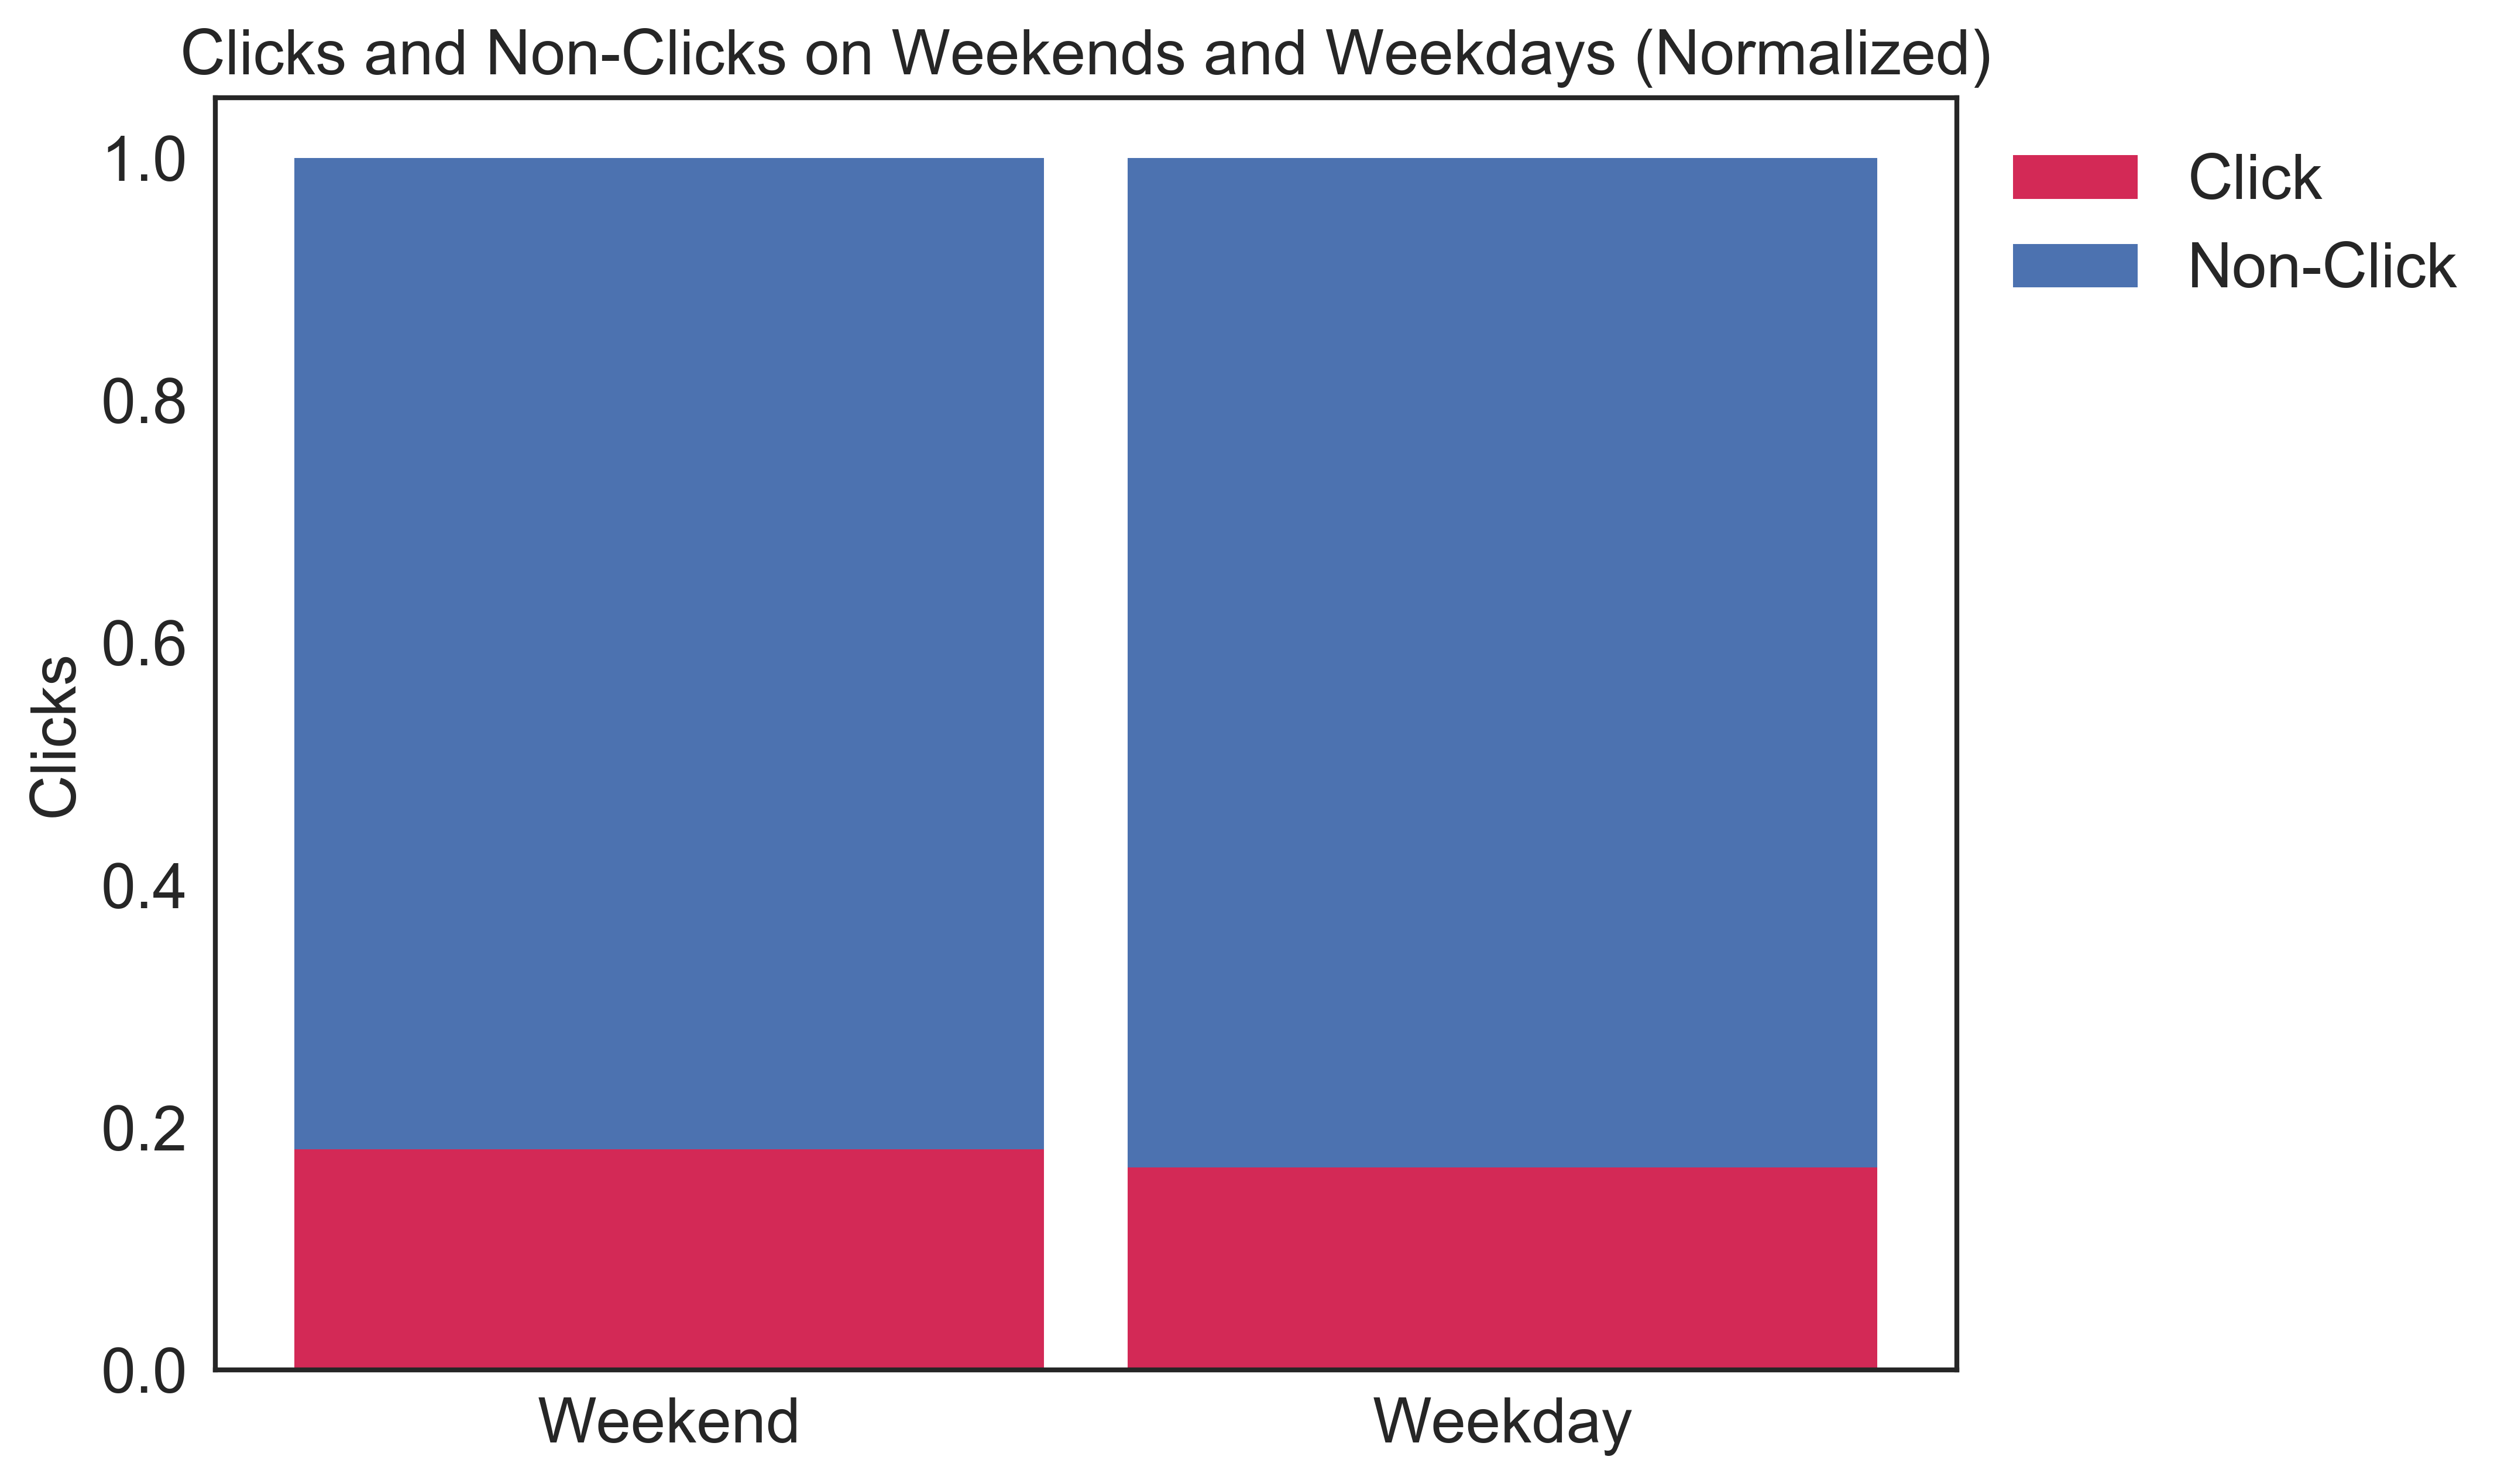

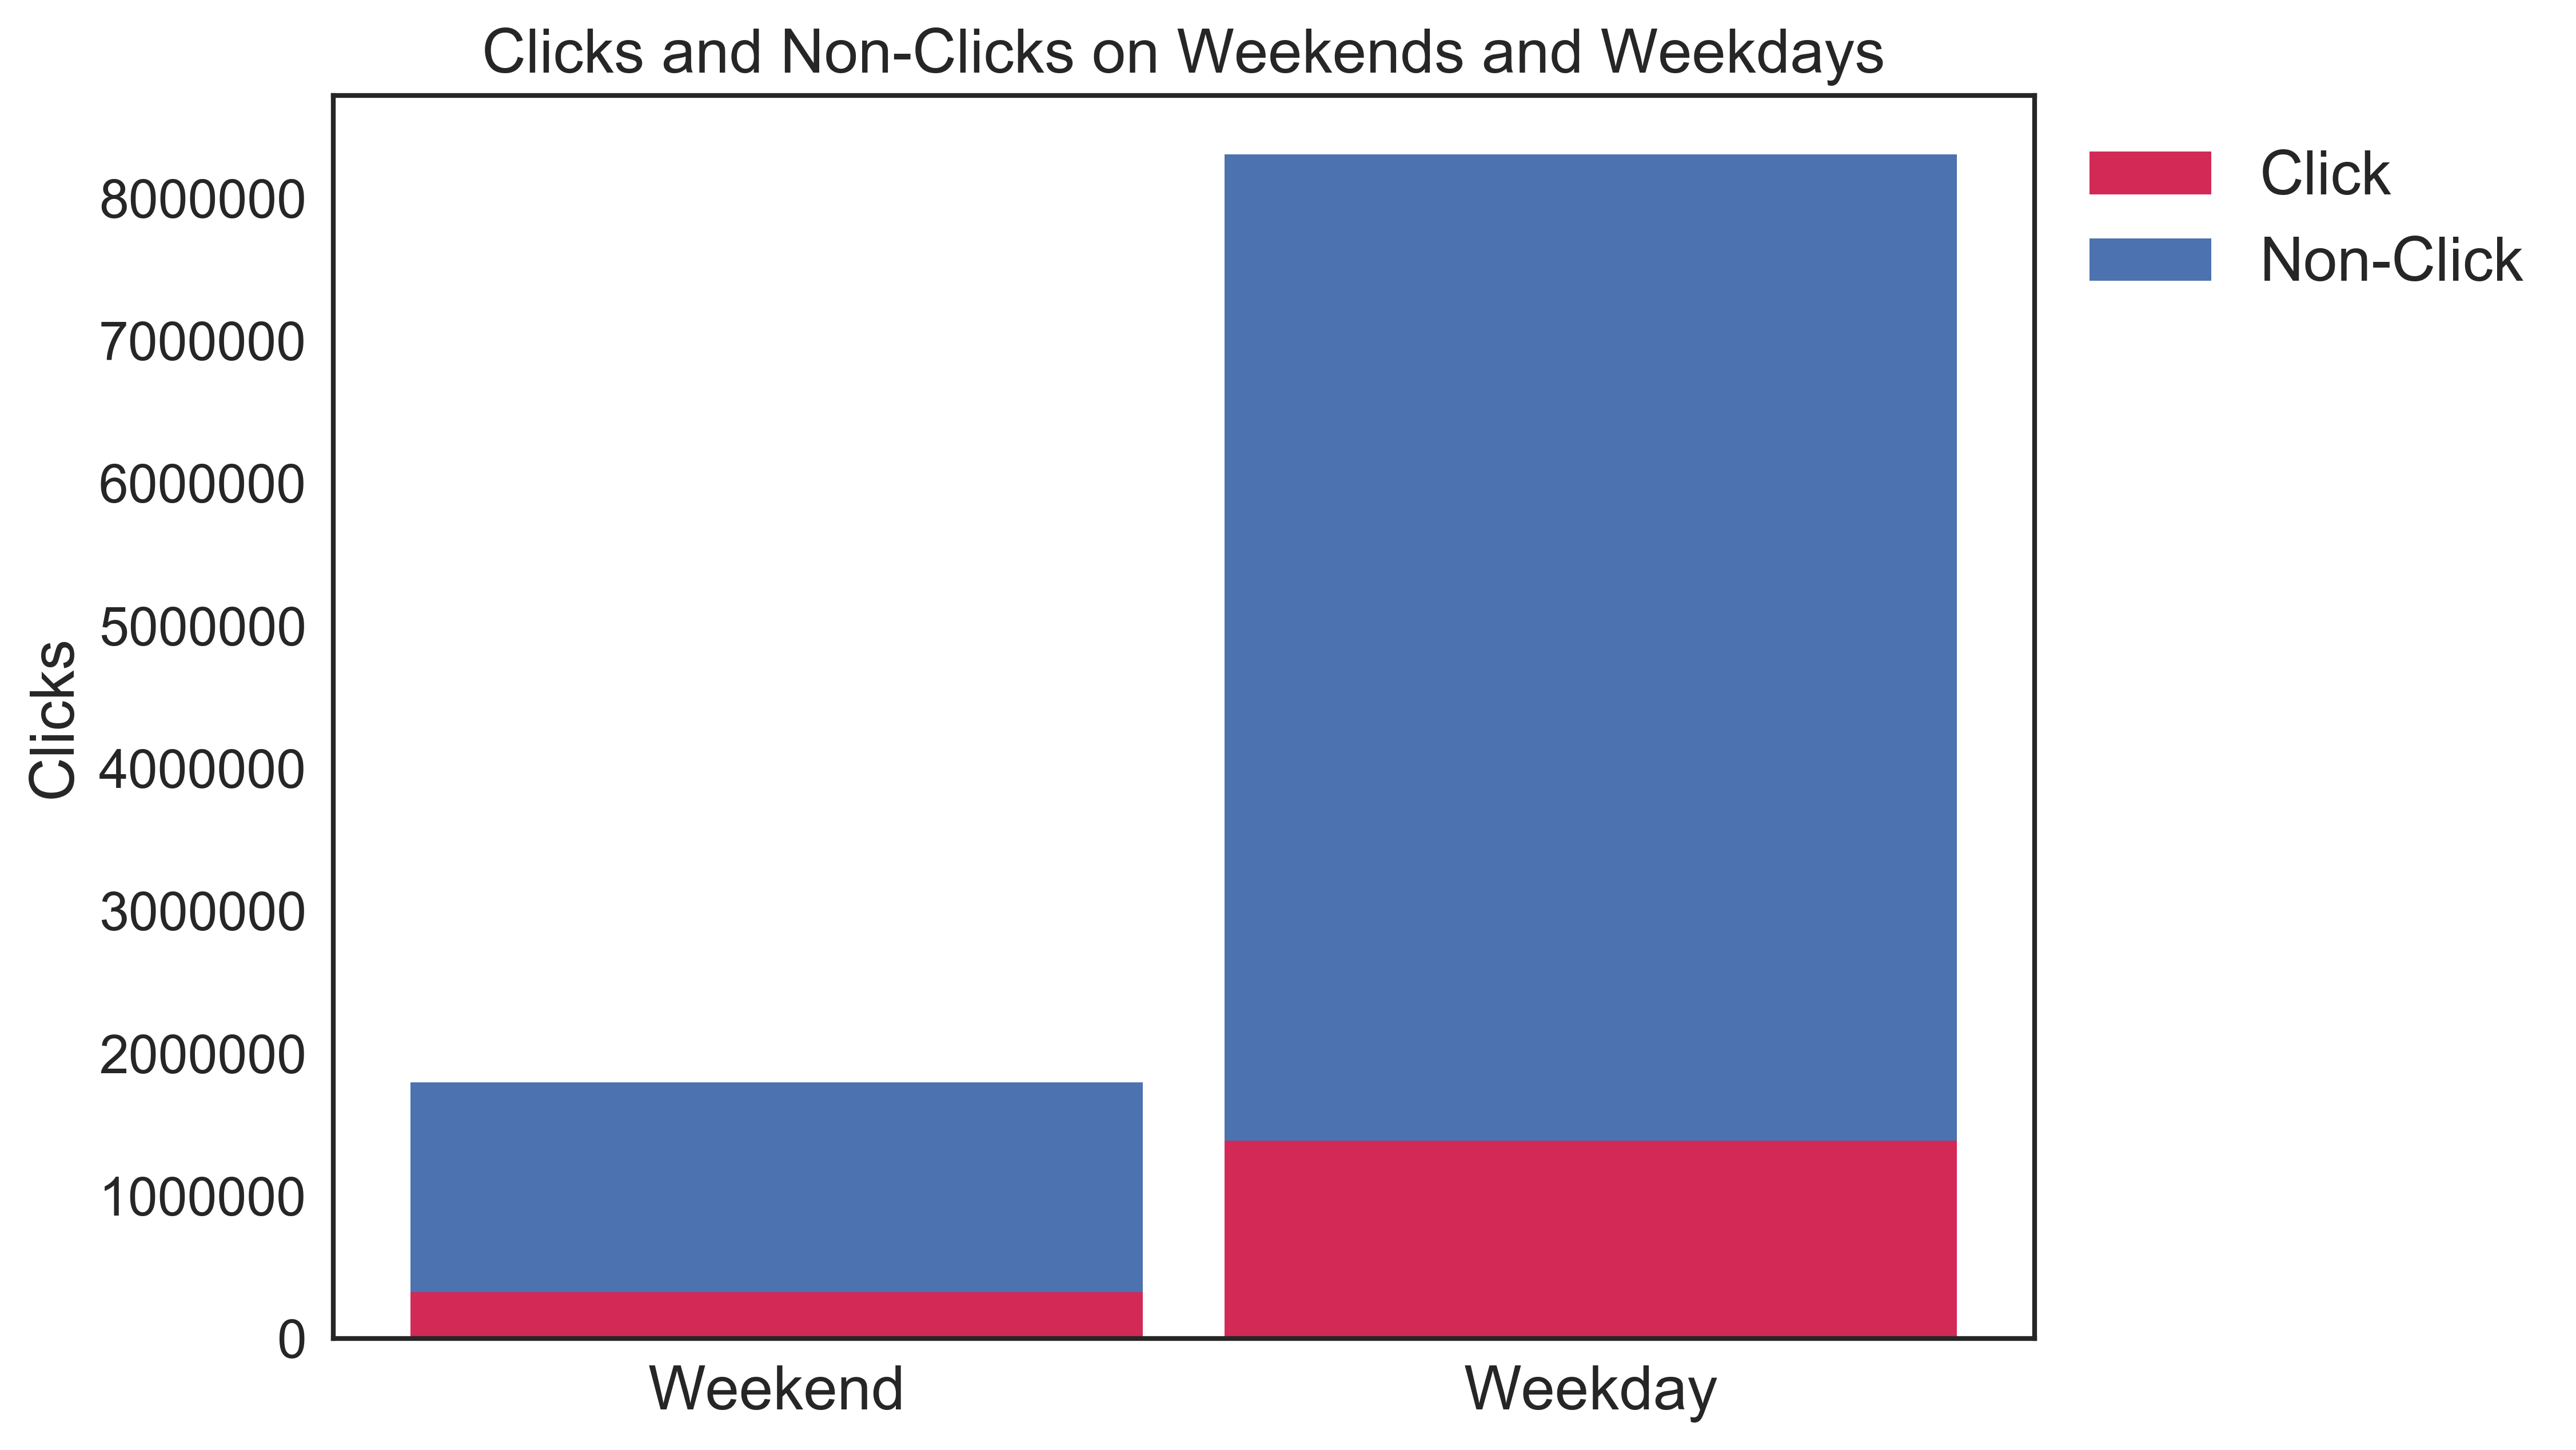

In [21]:
#Plot for Click and Non- Clicks For weekends and weekdays

fig,ax=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
#Plot for Click per Day of Week
N = 2
a = adClicksForWeekdays["CTR"]/totalClicksForWeek["CTR"]
b = 1-(adClicksForWeekdays["CTR"]/totalClicksForWeek["CTR"])
index = np.arange(N)    
width = 0.90       
p1 = plt.bar(index, a, width, color='#d32956')
p2 = plt.bar(index, b, width,
             bottom=a)

plt.xticks(index,("Weekend","Weekday"), fontsize=16)
plt.ylabel('Clicks', fontsize=16)
plt.yticks(fontsize=16)
plt.title('Clicks and Non-Clicks on Weekends and Weekdays (Normalized)', fontsize=16)
plt.legend((p1[0], p2[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1), fontsize=16)

plt.show()
fig.savefig('ClicksPerDayTypeNorm.png', bbox_inches='tight')

fig1,ax1=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
c= adClicksForWeekdays["CTR"];
d= totalClicksForWeek["CTR"]-(adClicksForWeekdays["CTR"])
p3 = plt.bar(index, c, width, color='#d32956')
p4 = plt.bar(index, d, width,
             bottom=c)

plt.xticks(index,("Weekend","Weekday"), fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('Clicks', fontsize=16)
plt.title('Clicks and Non-Clicks on Weekends and Weekdays', fontsize=16)
plt.legend((p3[0], p4[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1), fontsize=16)

plt.show()
fig1.savefig('ClicksPerDayType.png', bbox_inches='tight')

In [22]:
adClicksForC1=data.groupby('C1', {'CTR':gl.aggregate.SUM('click')})
print adClicksForC1

+------+---------+
|  C1  |   CTR   |
+------+---------+
| 1007 |   355   |
| 1005 | 1572186 |
| 1008 |   161   |
| 1010 |  21728  |
| 1002 |  117062 |
| 1012 |   4861  |
| 1001 |    85   |
+------+---------+
[7 rows x 2 columns]



In [23]:
adClicksForArea=data.groupby('area', {'CTR':gl.aggregate.SUM('click')})
print adClicksForArea

TotalAdsForArea=data.groupby('area', {'CTR':gl.aggregate.COUNT('click')})
print TotalAdsForArea

+--------+---------+
|  area  |   CTR   |
+--------+---------+
| 15000  |  19785  |
|  2400  |    16   |
| 786432 |   359   |
| 153600 |   5619  |
|  7776  |   9303  |
| 75000  |  190273 |
| 65520  |   1065  |
| 16000  | 1490018 |
+--------+---------+
[8 rows x 2 columns]

+--------+---------+
|  area  |   CTR   |
+--------+---------+
| 15000  |  132267 |
|  2400  |   791   |
| 786432 |   1067  |
| 153600 |  26306  |
|  7776  |  74896  |
| 75000  |  451360 |
| 65520  |  18607  |
| 16000  | 9399816 |
+--------+---------+
[8 rows x 2 columns]



In [24]:
CTRForArea=adClicksForArea["CTR"]/TotalAdsForArea["CTR"]
print CTRForArea

[0.1495837964118034, 0.020227560050568902, 0.3364573570759138, 0.2136014597430244, 0.12421224097415082, 0.4215548564338887, 0.05723652388885903, 0.15851565605113974]


[1, 4, 0, 7, 6, 5, 3, 2]
[2400, 7776, 15000, 16000, 65520, 75000, 153600, 786432]


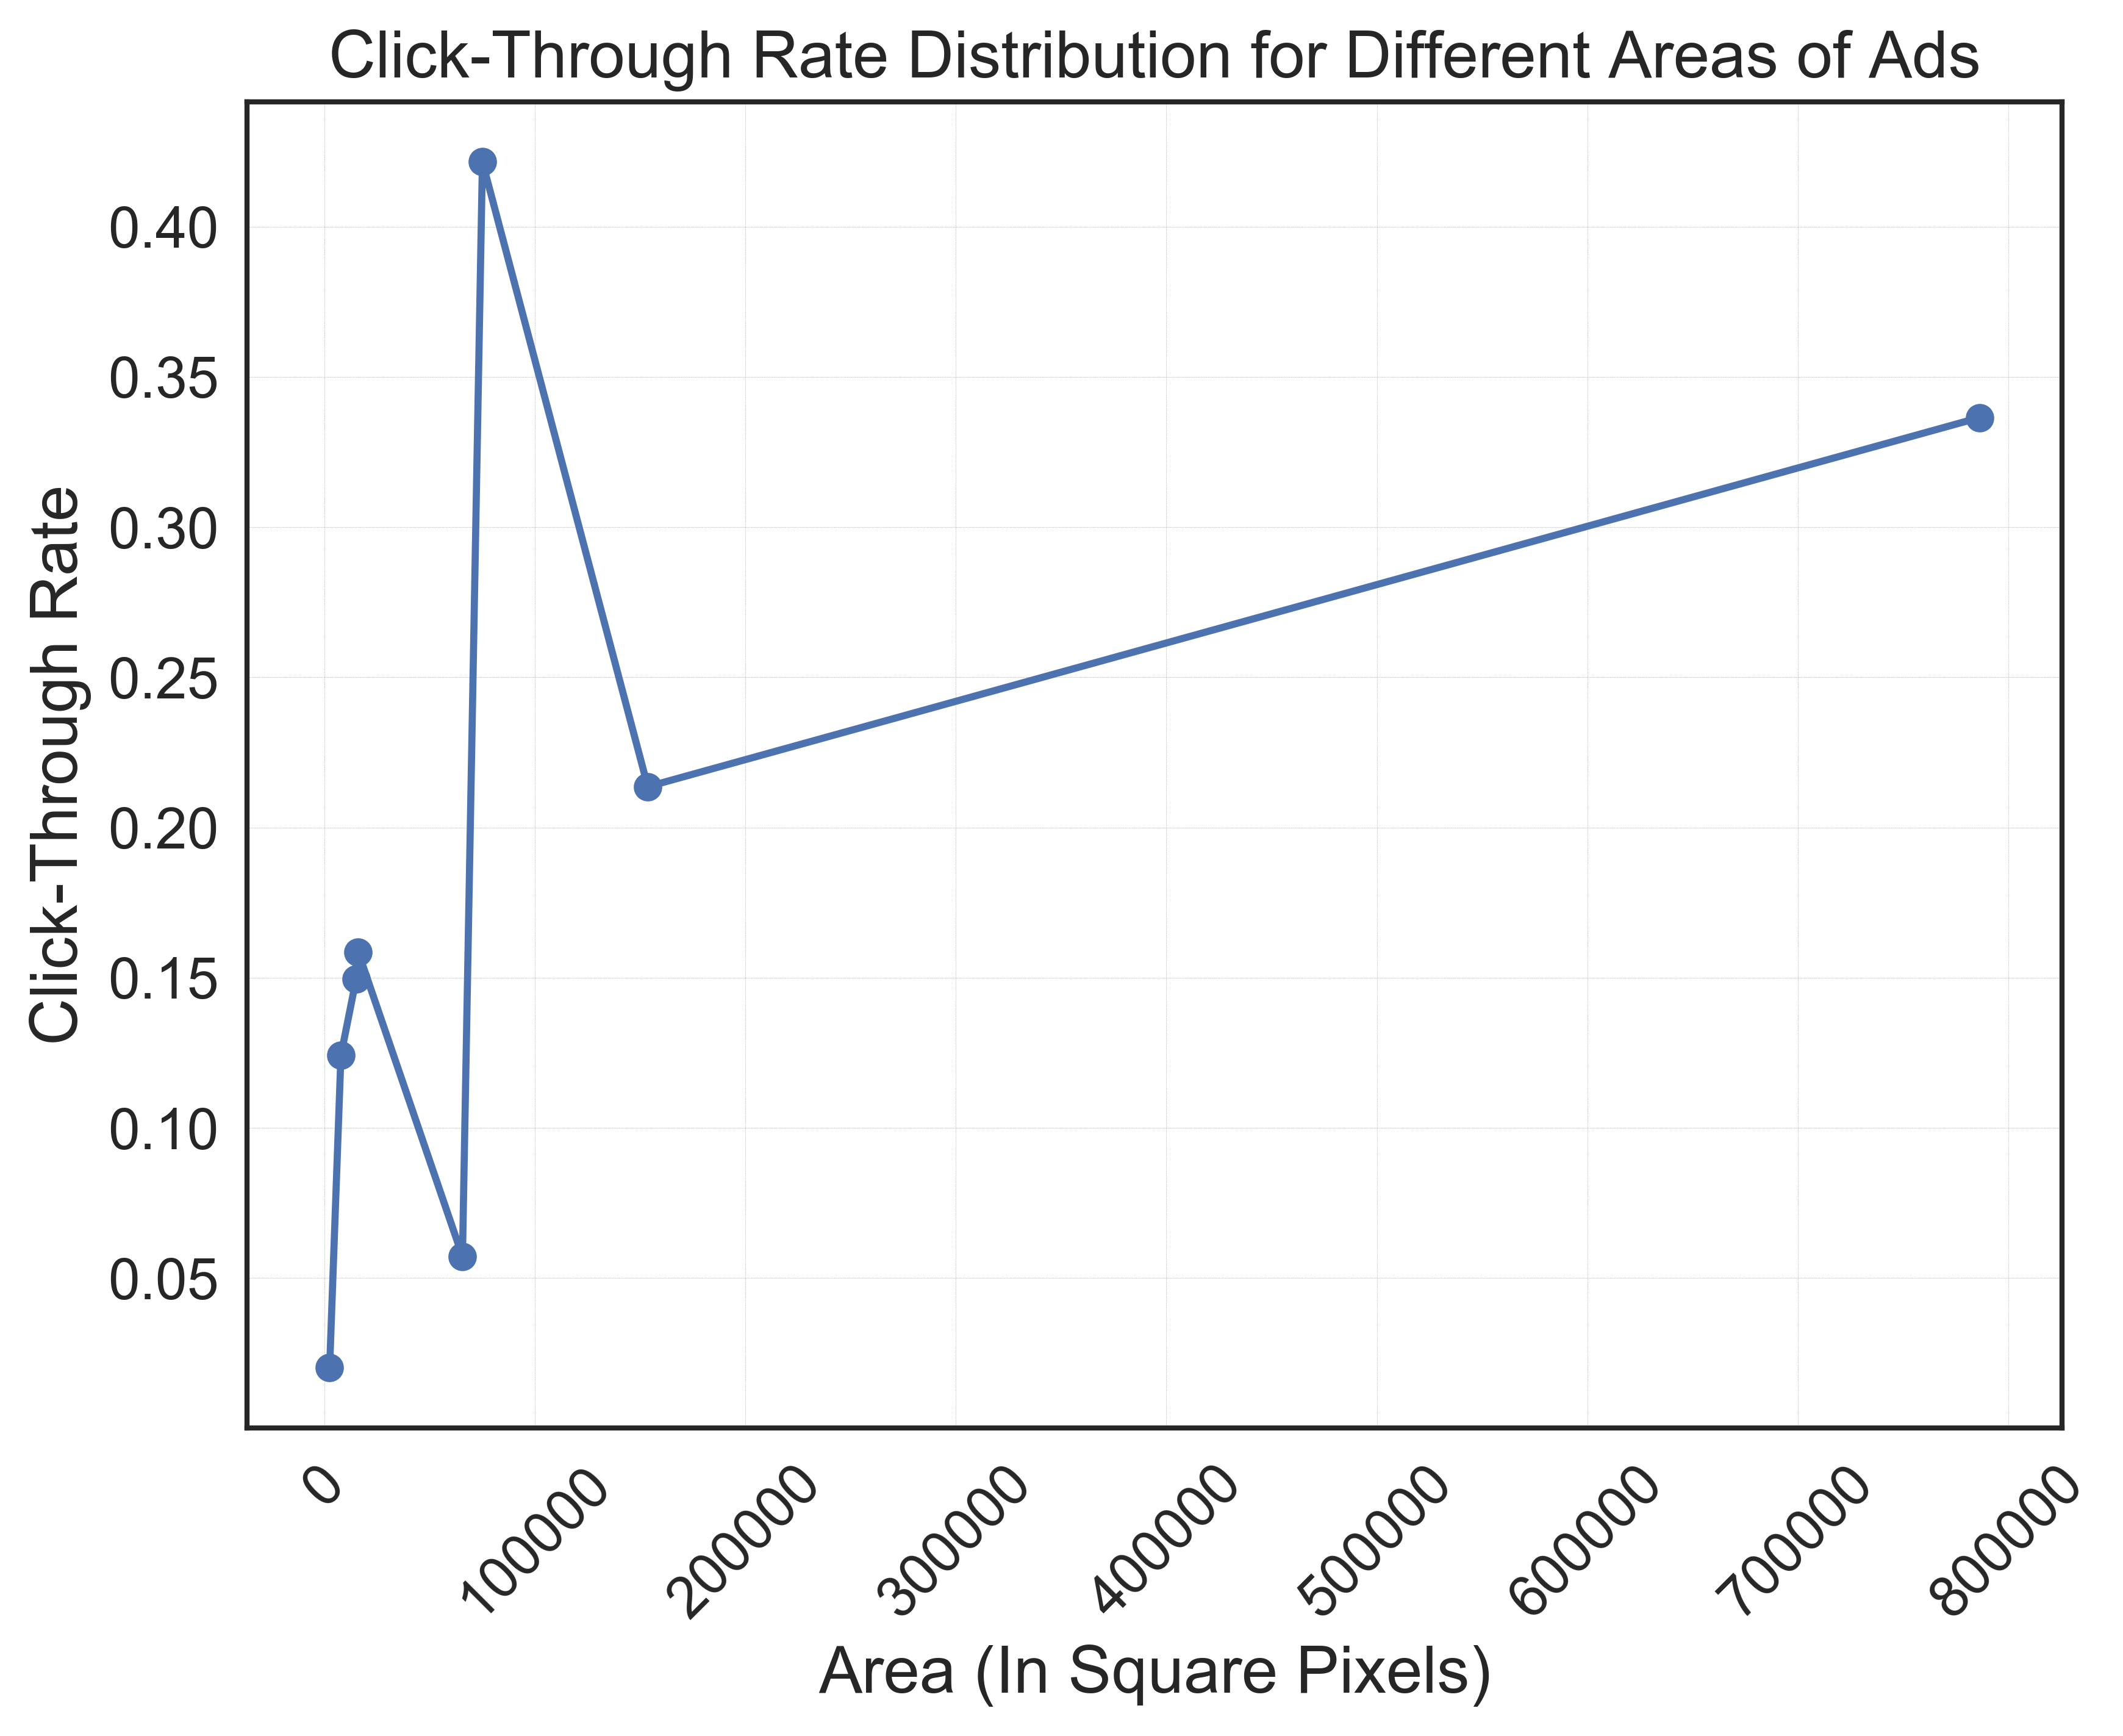

In [25]:
#Plot for CTR for different Ad areas
fig,ax=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
x = adClicksForArea["area"]
y = CTRForArea

ind = [i[0] for i in sorted(enumerate(x), key=lambda x:x[1])]
print ind
x = [x[ind[i]] for i in range(len(ind))]
y = [y[ind[i]] for i in range(len(ind))]
print x

ax.plot(x, y,'o-')
plt.ylabel('Click-Through Rate',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14,rotation=45)
plt.xlabel('Area (In Square Pixels)', fontsize=16)
plt.title('Click-Through Rate Distribution for Different Areas of Ads', fontsize=16)
ax.grid(color='grey', linestyle=':', linewidth=0.1)

plt.show()
fig.savefig('CTR_Area.png', bbox_inches='tight')

In [26]:
weekdayHourClick=data.groupby(key_columns=["hour","isWeekDay"], operations={'CTR':gl.aggregate.SUM('click')},)
#print weekdayHourClick
weekdayHourClick=weekdayHourClick.sort(["isWeekDay","hour"], ascending=True)
#weekdayHourClick.print_rows(num_rows=48, num_columns=3)

TotalWeekdayHourClick=data.groupby(key_columns=["hour","isWeekDay"], operations={'CTR':gl.aggregate.COUNT('click')},)
#print TotalWeekdayHourClick
TotalWeekdayHourClick=TotalWeekdayHourClick.sort(["isWeekDay","hour"], ascending=True)
#TotalWeekdayHourClick.print_rows(num_rows=48, num_columns=3)

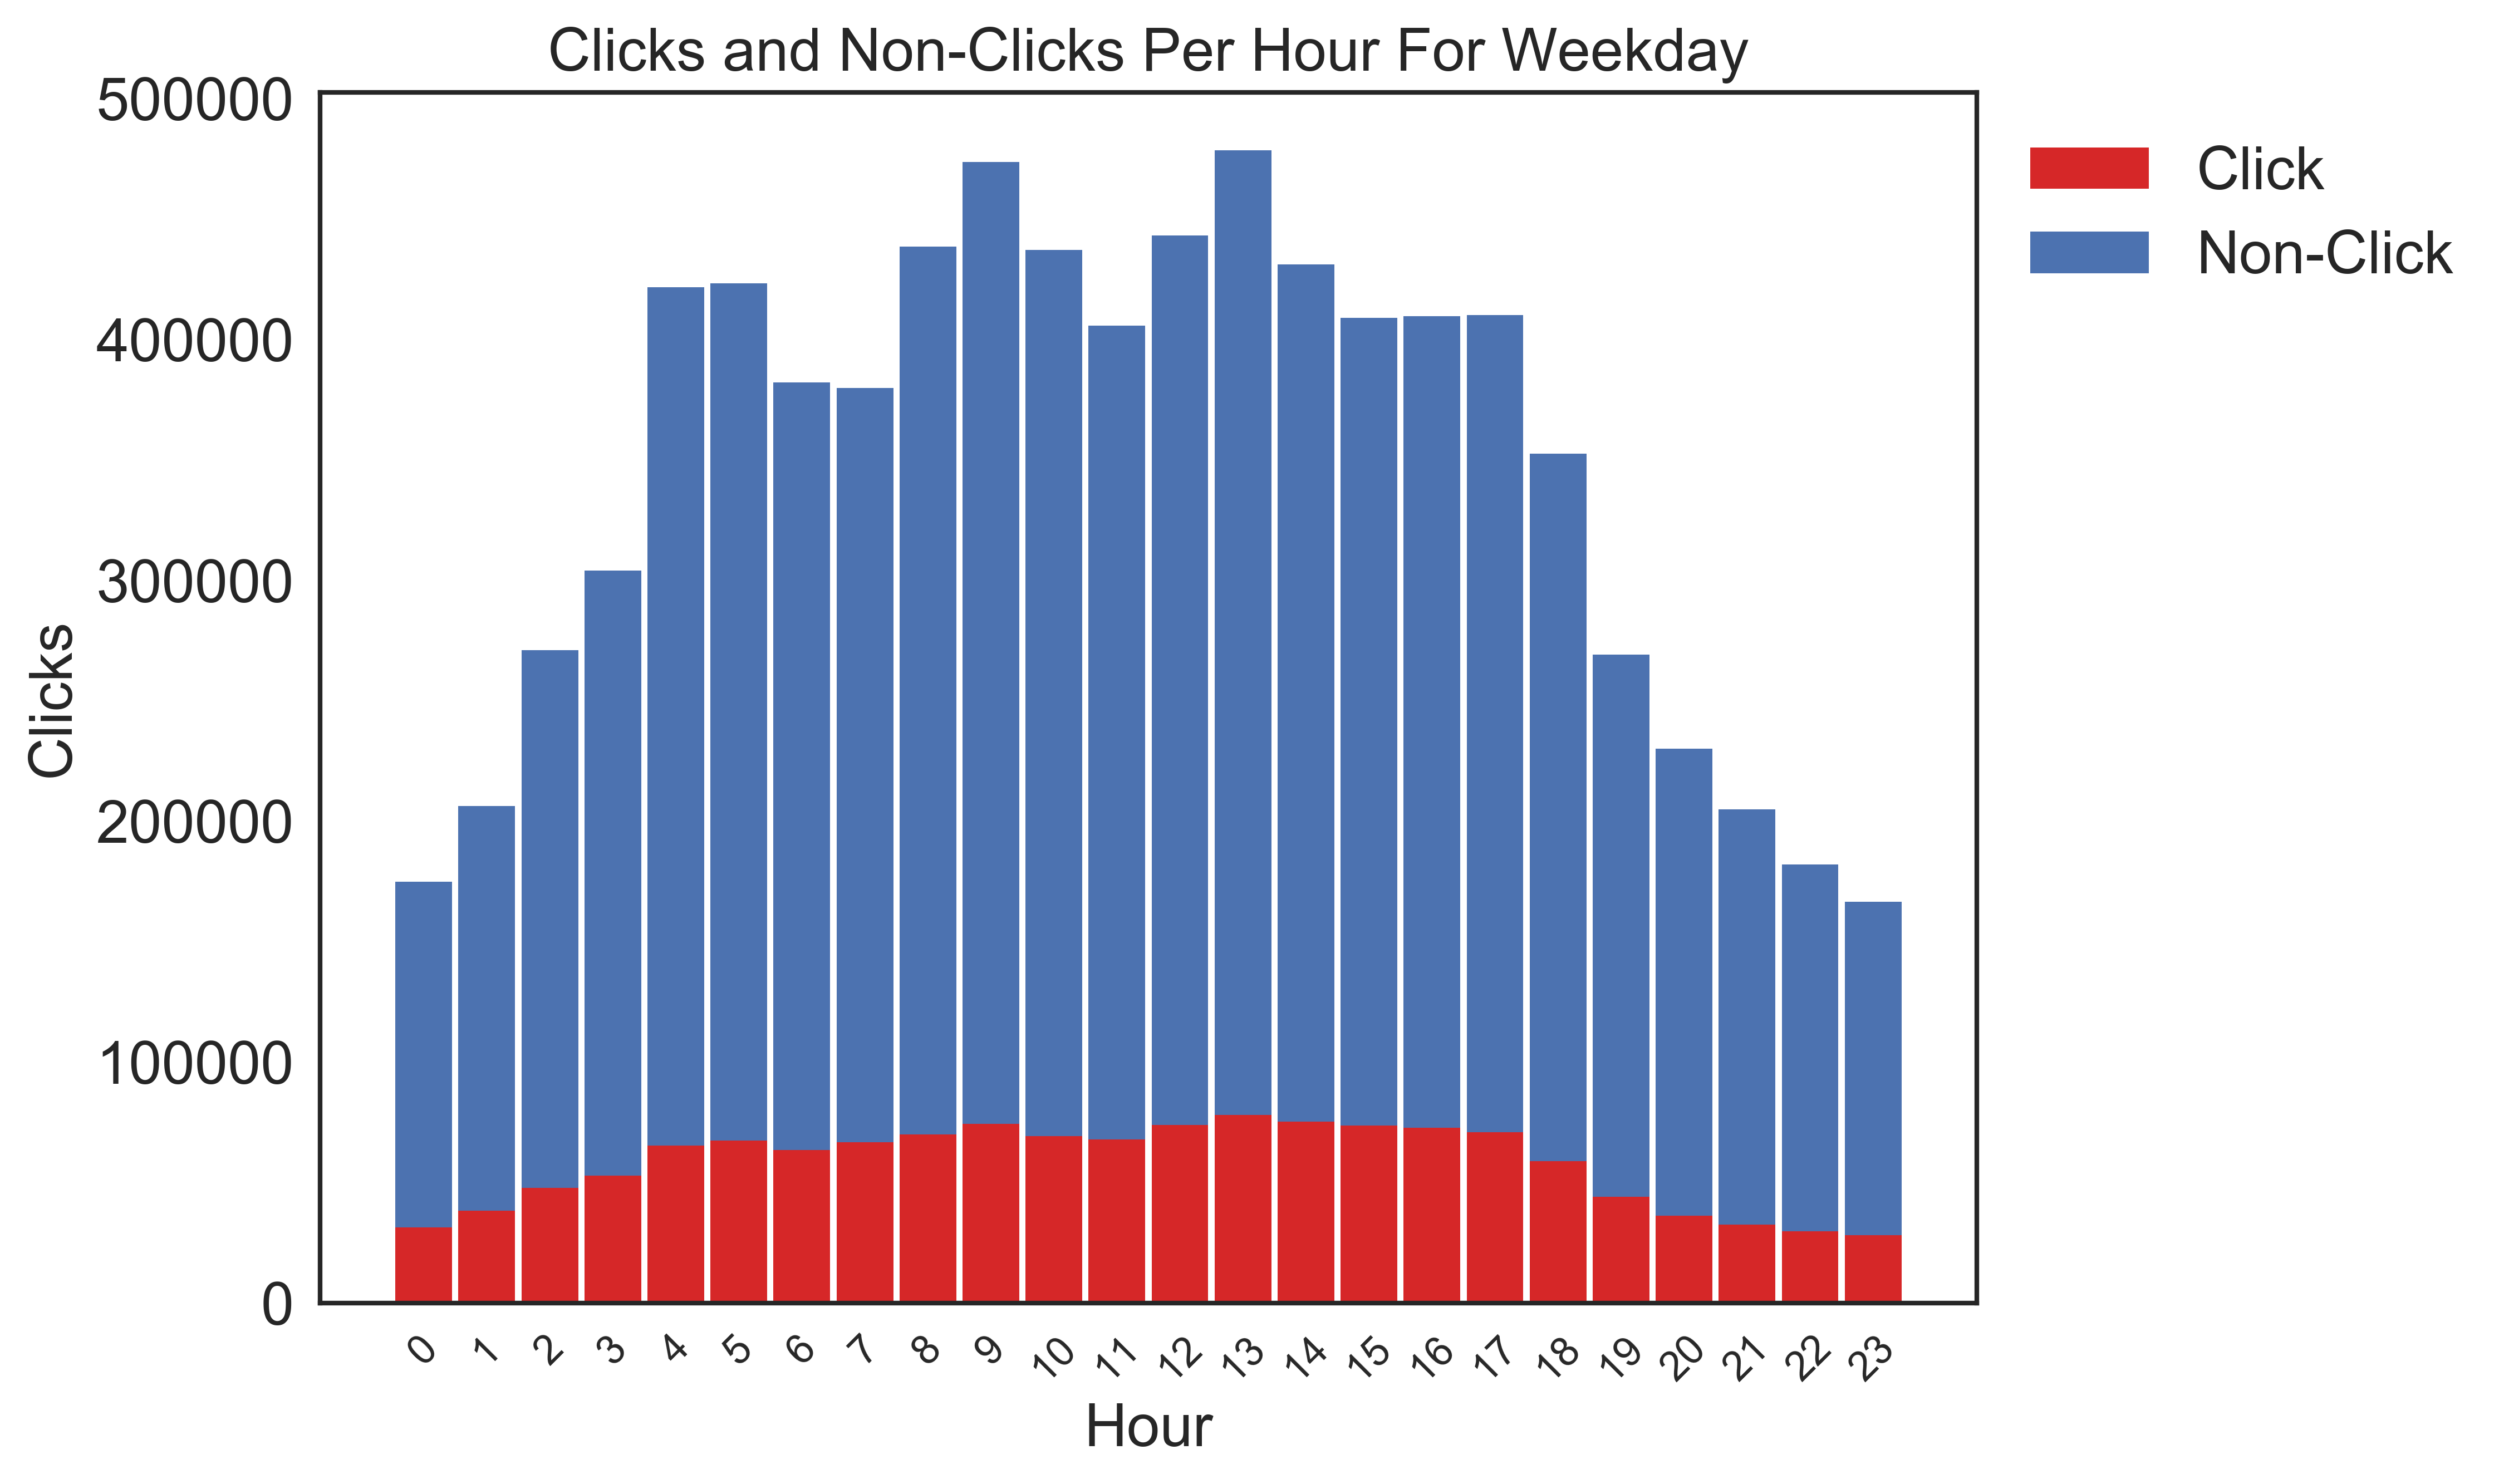

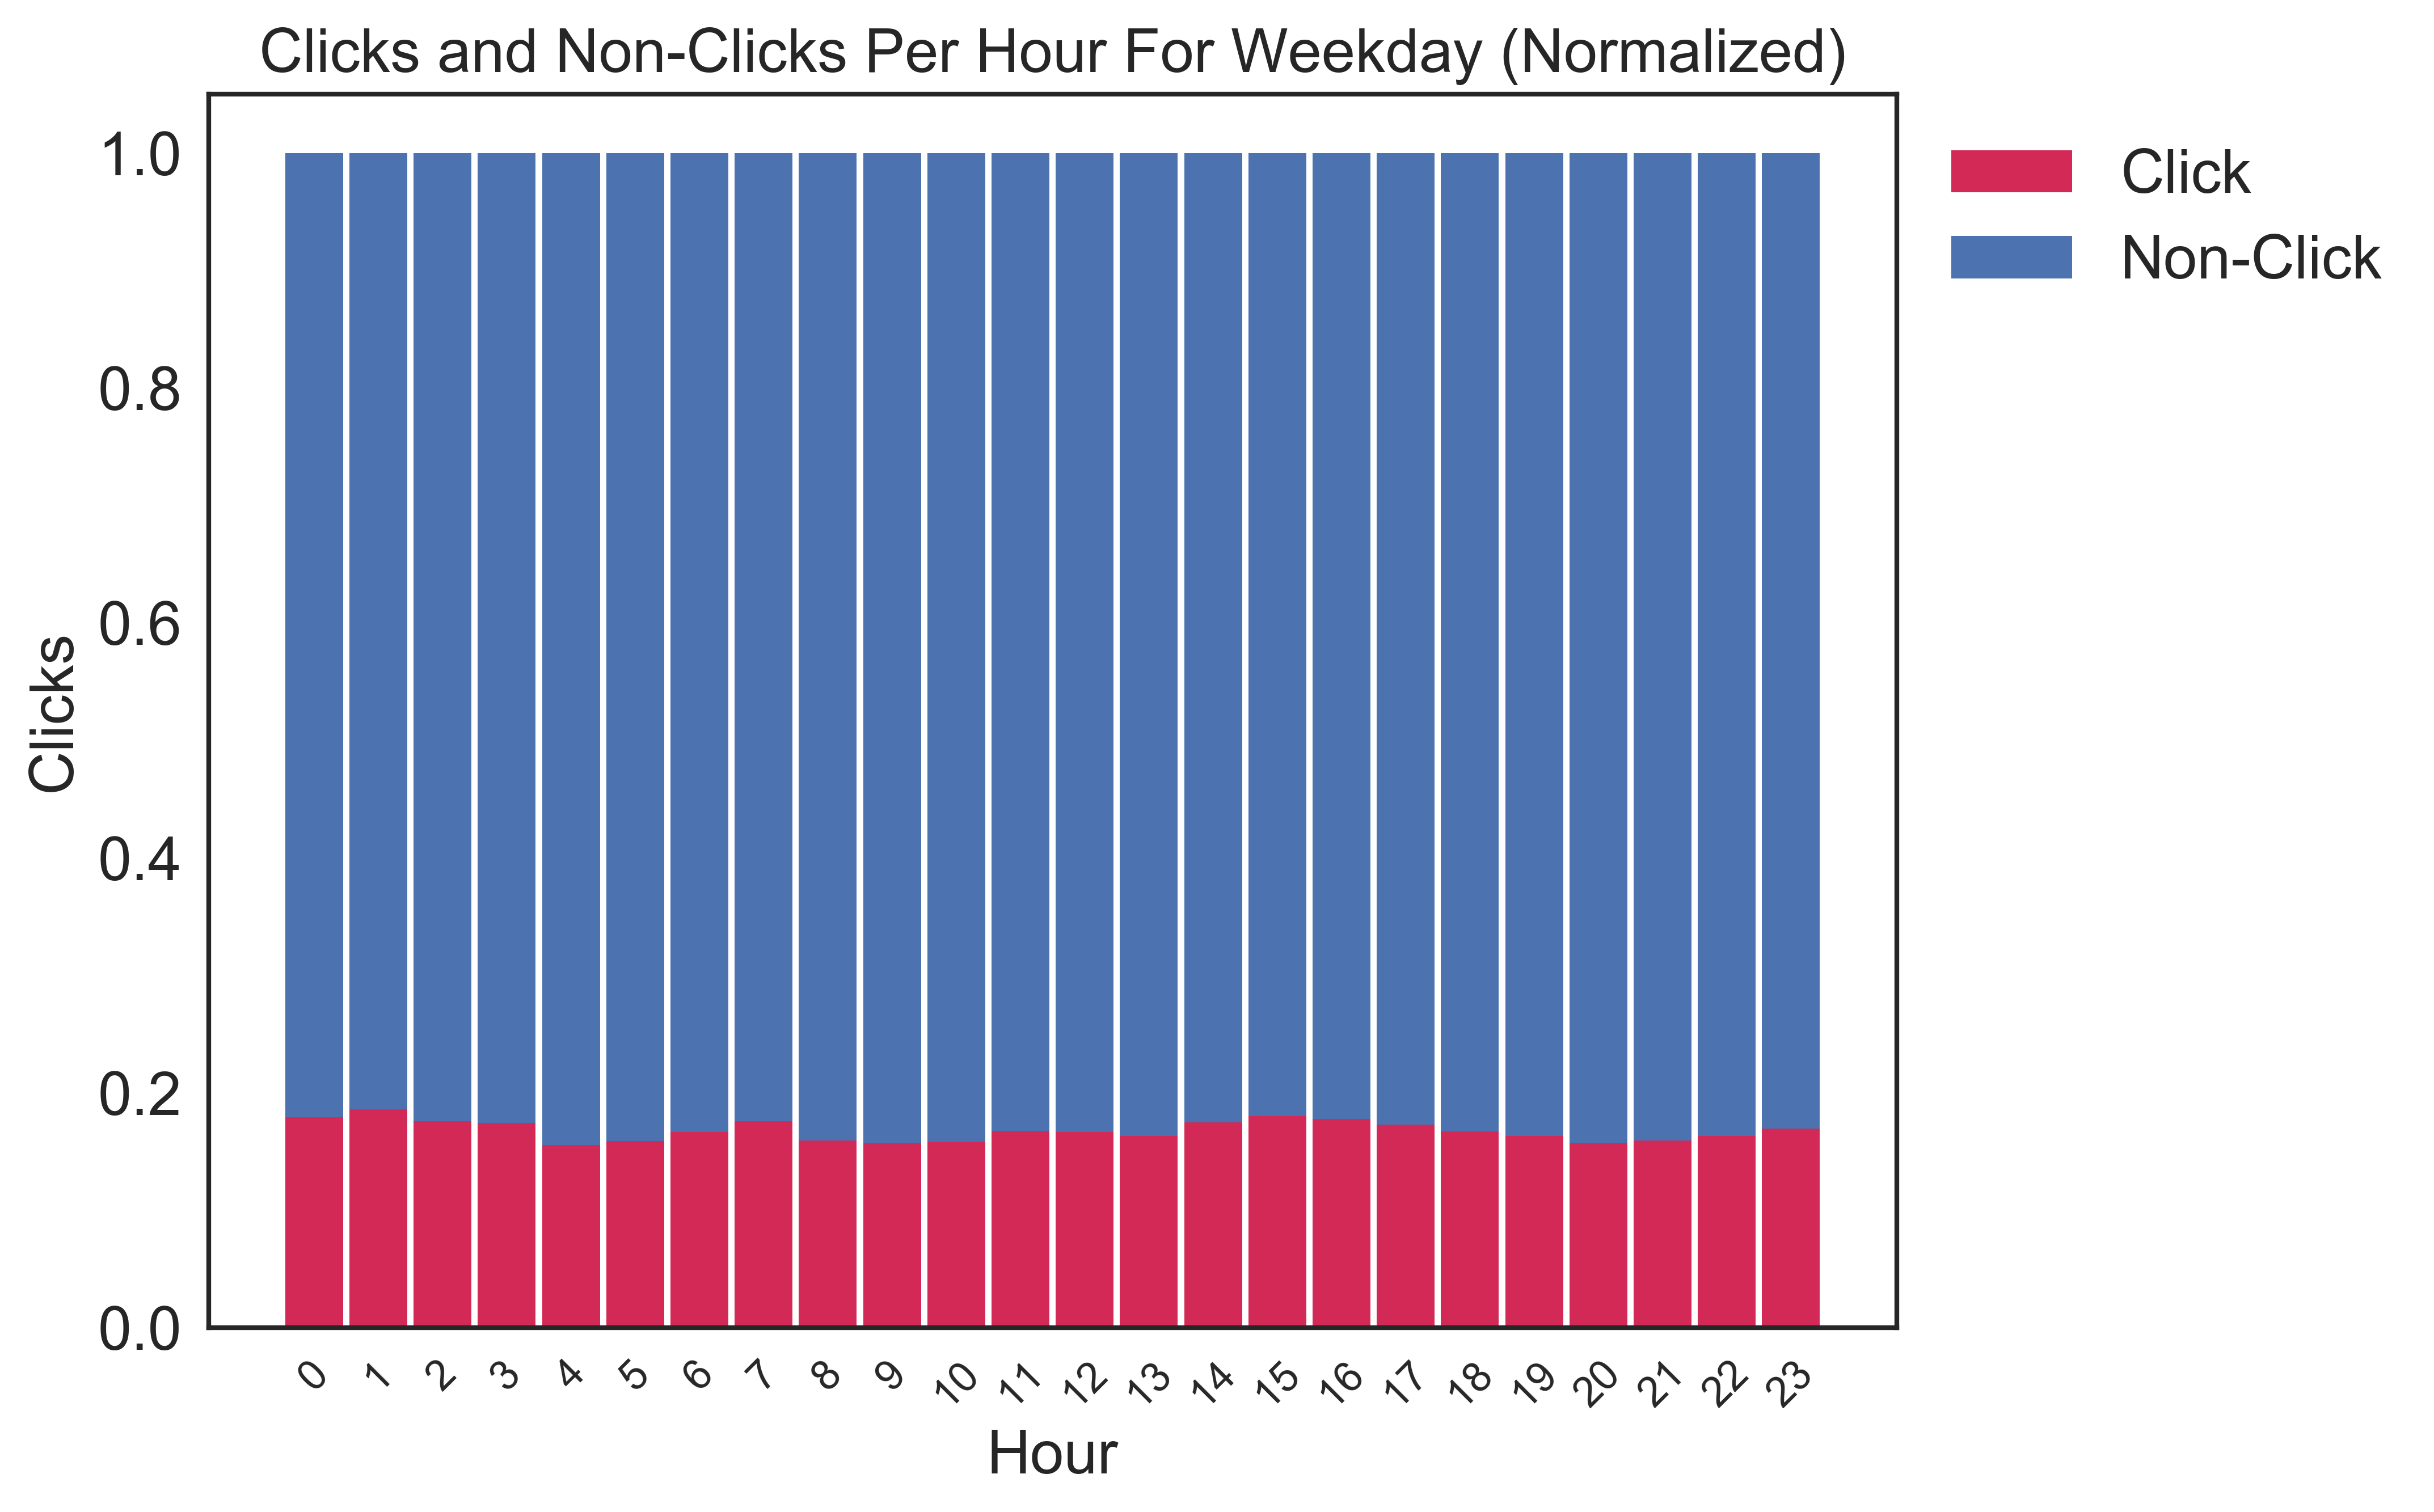

In [27]:
#Plot for Click per Hours (For Weekday)
fig,ax=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
N = 24
a = weekdayHourClick["CTR"][24:48]
b = (TotalWeekdayHourClick["CTR"][24:48]-weekdayHourClick["CTR"][24:48])
index = np.arange(N)    
width = 0.90       
p1 = plt.bar(index, a, width, color='#d62728')
p2 = plt.bar(index, b, width,
             bottom=a)

plt.xticks(index,rotation=45, fontsize = 11)
plt.yticks(fontsize = 16)
plt.ylabel('Clicks',fontsize = 16)
plt.xlabel('Hour',fontsize = 16)
plt.title('Clicks and Non-Clicks Per Hour For Weekday',fontsize = 16)
plt.legend((p1[0], p2[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1),fontsize = 16)

plt.show()
fig.savefig('weekdayHourClick.png', bbox_inches='tight')

#Plot for CTR (Weekday)
fig1,ax1=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
N = 24
a = weekdayHourClick["CTR"][24:48]/TotalWeekdayHourClick["CTR"][24:48]
b = 1-(weekdayHourClick["CTR"][24:48]/TotalWeekdayHourClick["CTR"][24:48])
index = np.arange(N)   
width = 0.90       
p1 = plt.bar(index, a, width, color='#d32956')
p2 = plt.bar(index, b, width,
             bottom=a)

plt.xticks(index,rotation=45, fontsize = 11)
plt.yticks(fontsize = 16)
plt.ylabel('Clicks',fontsize = 16)
plt.xlabel('Hour',fontsize = 16)
plt.title('Clicks and Non-Clicks Per Hour For Weekday (Normalized)',fontsize = 16)
plt.legend((p1[0], p2[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1),fontsize = 16)

plt.show()
fig1.savefig('weekdayHourClickNorm.png', bbox_inches='tight')

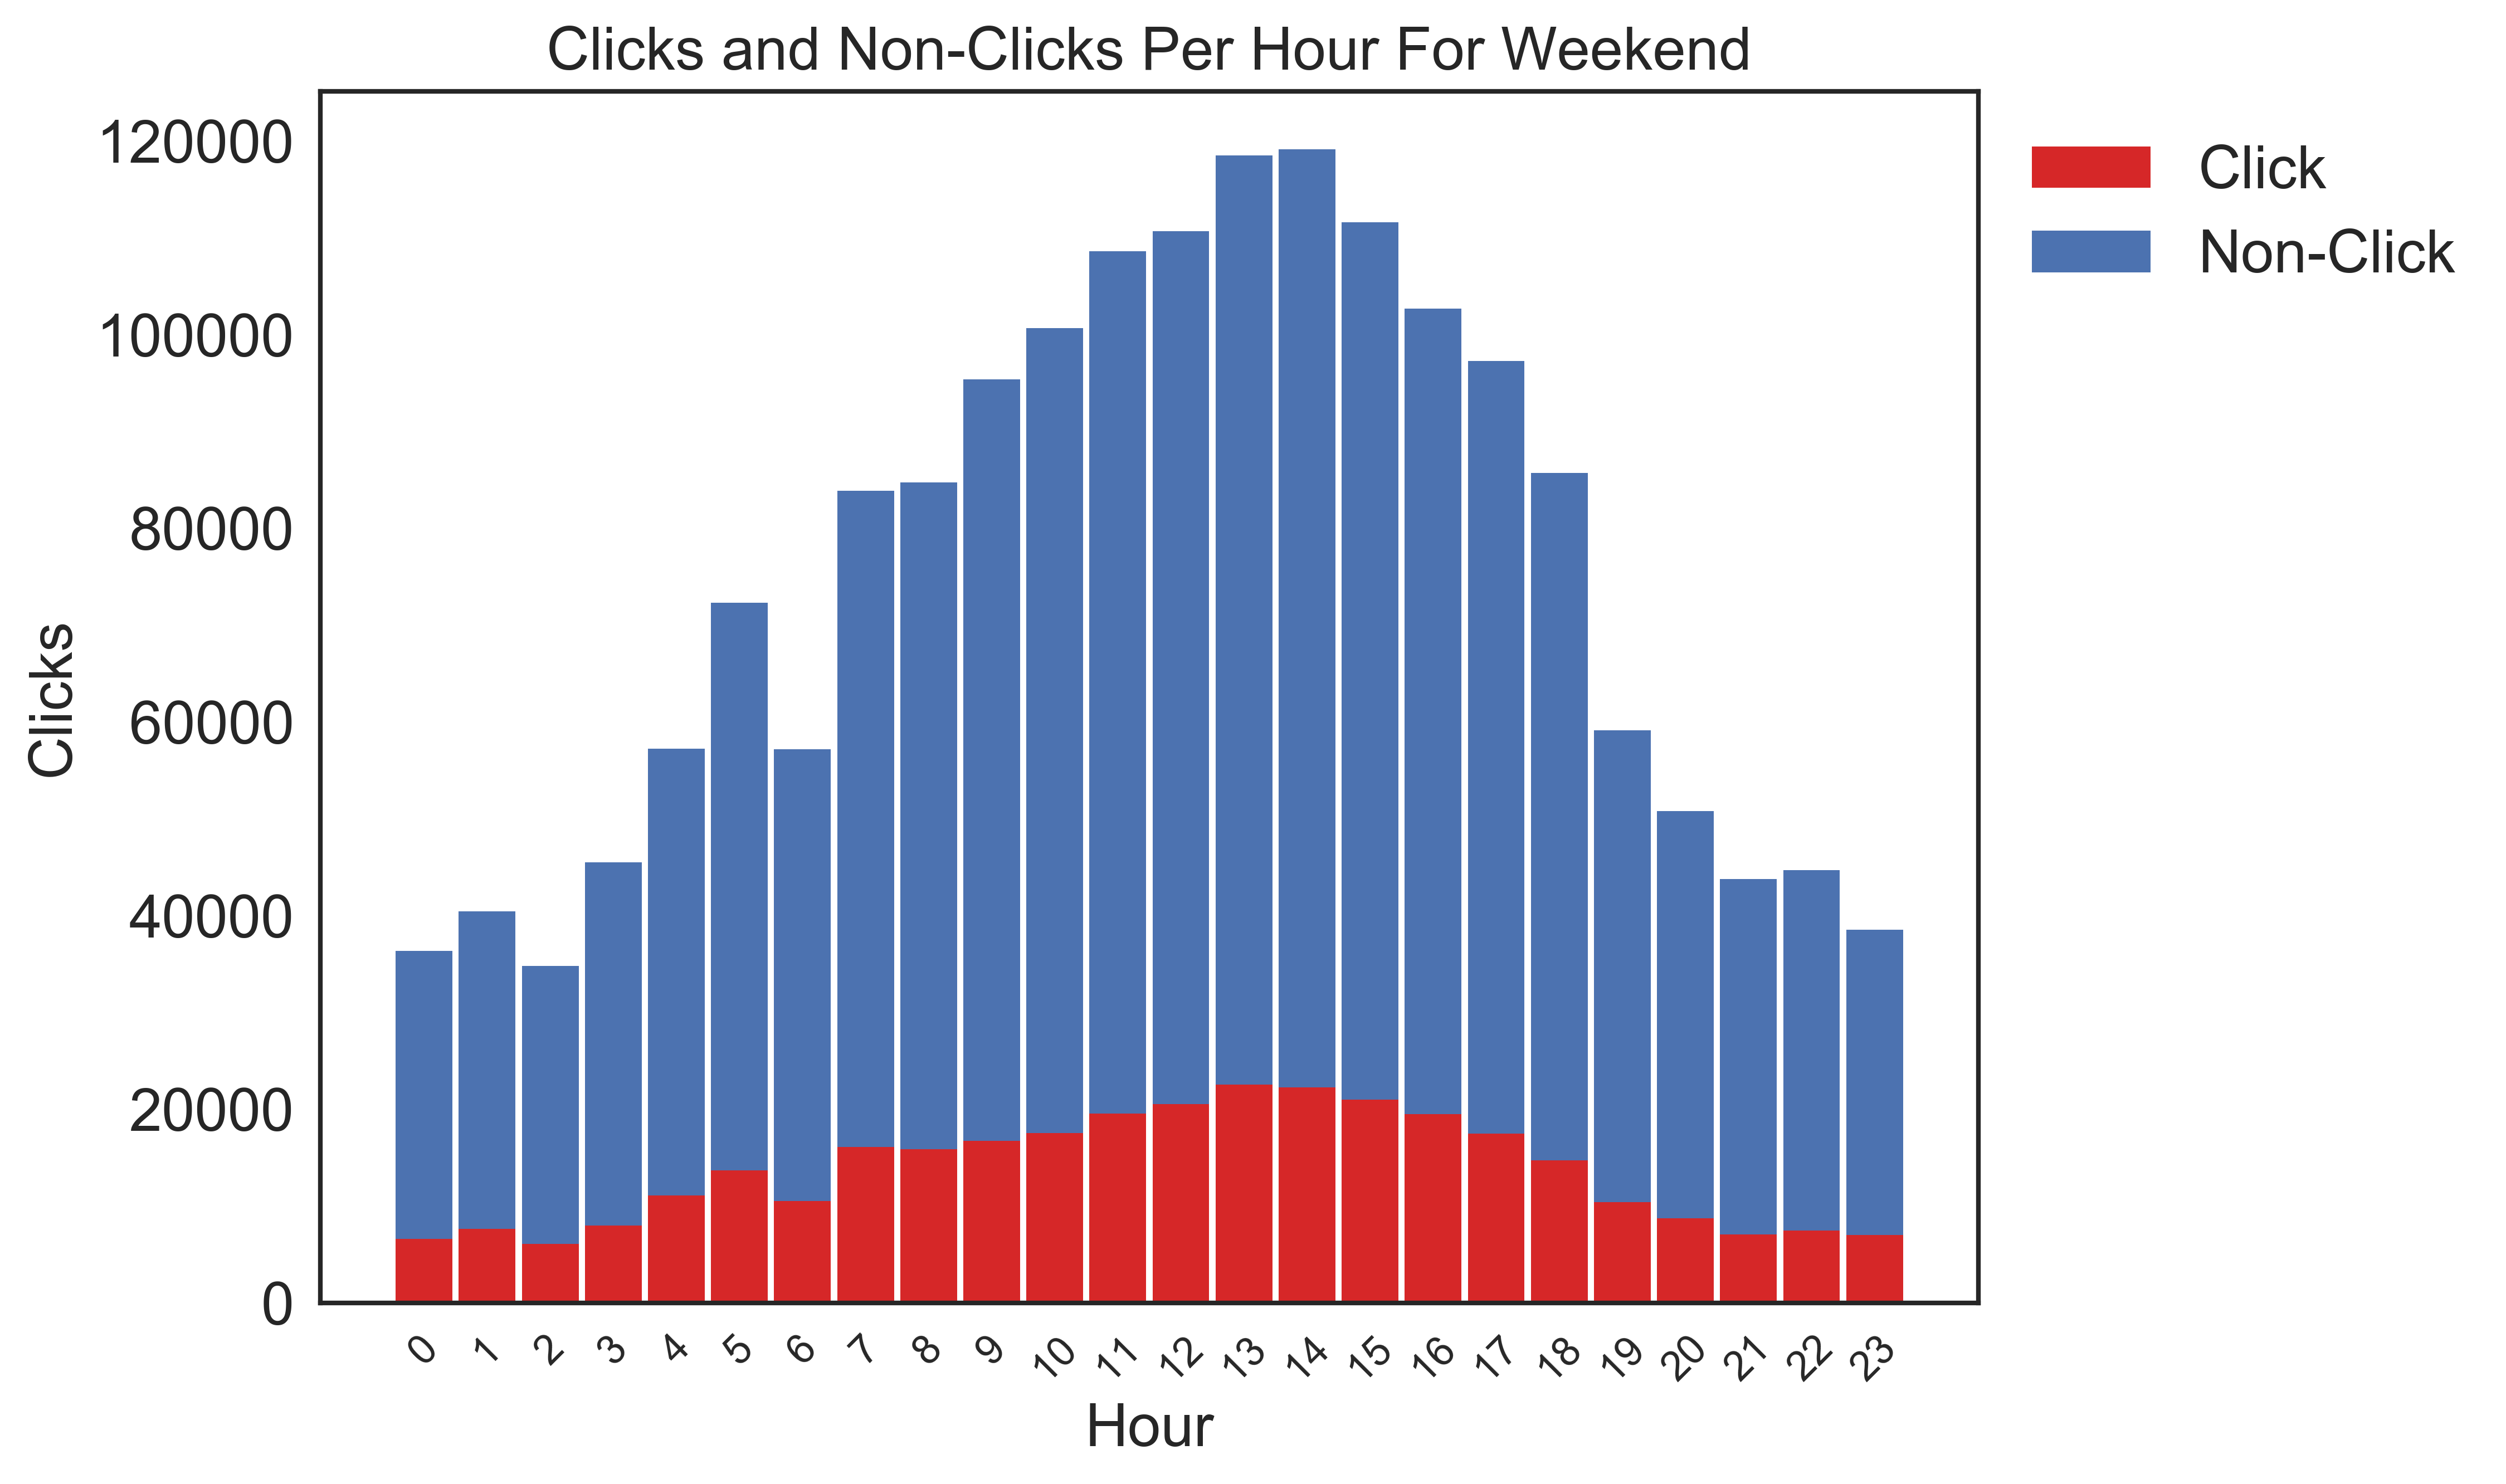

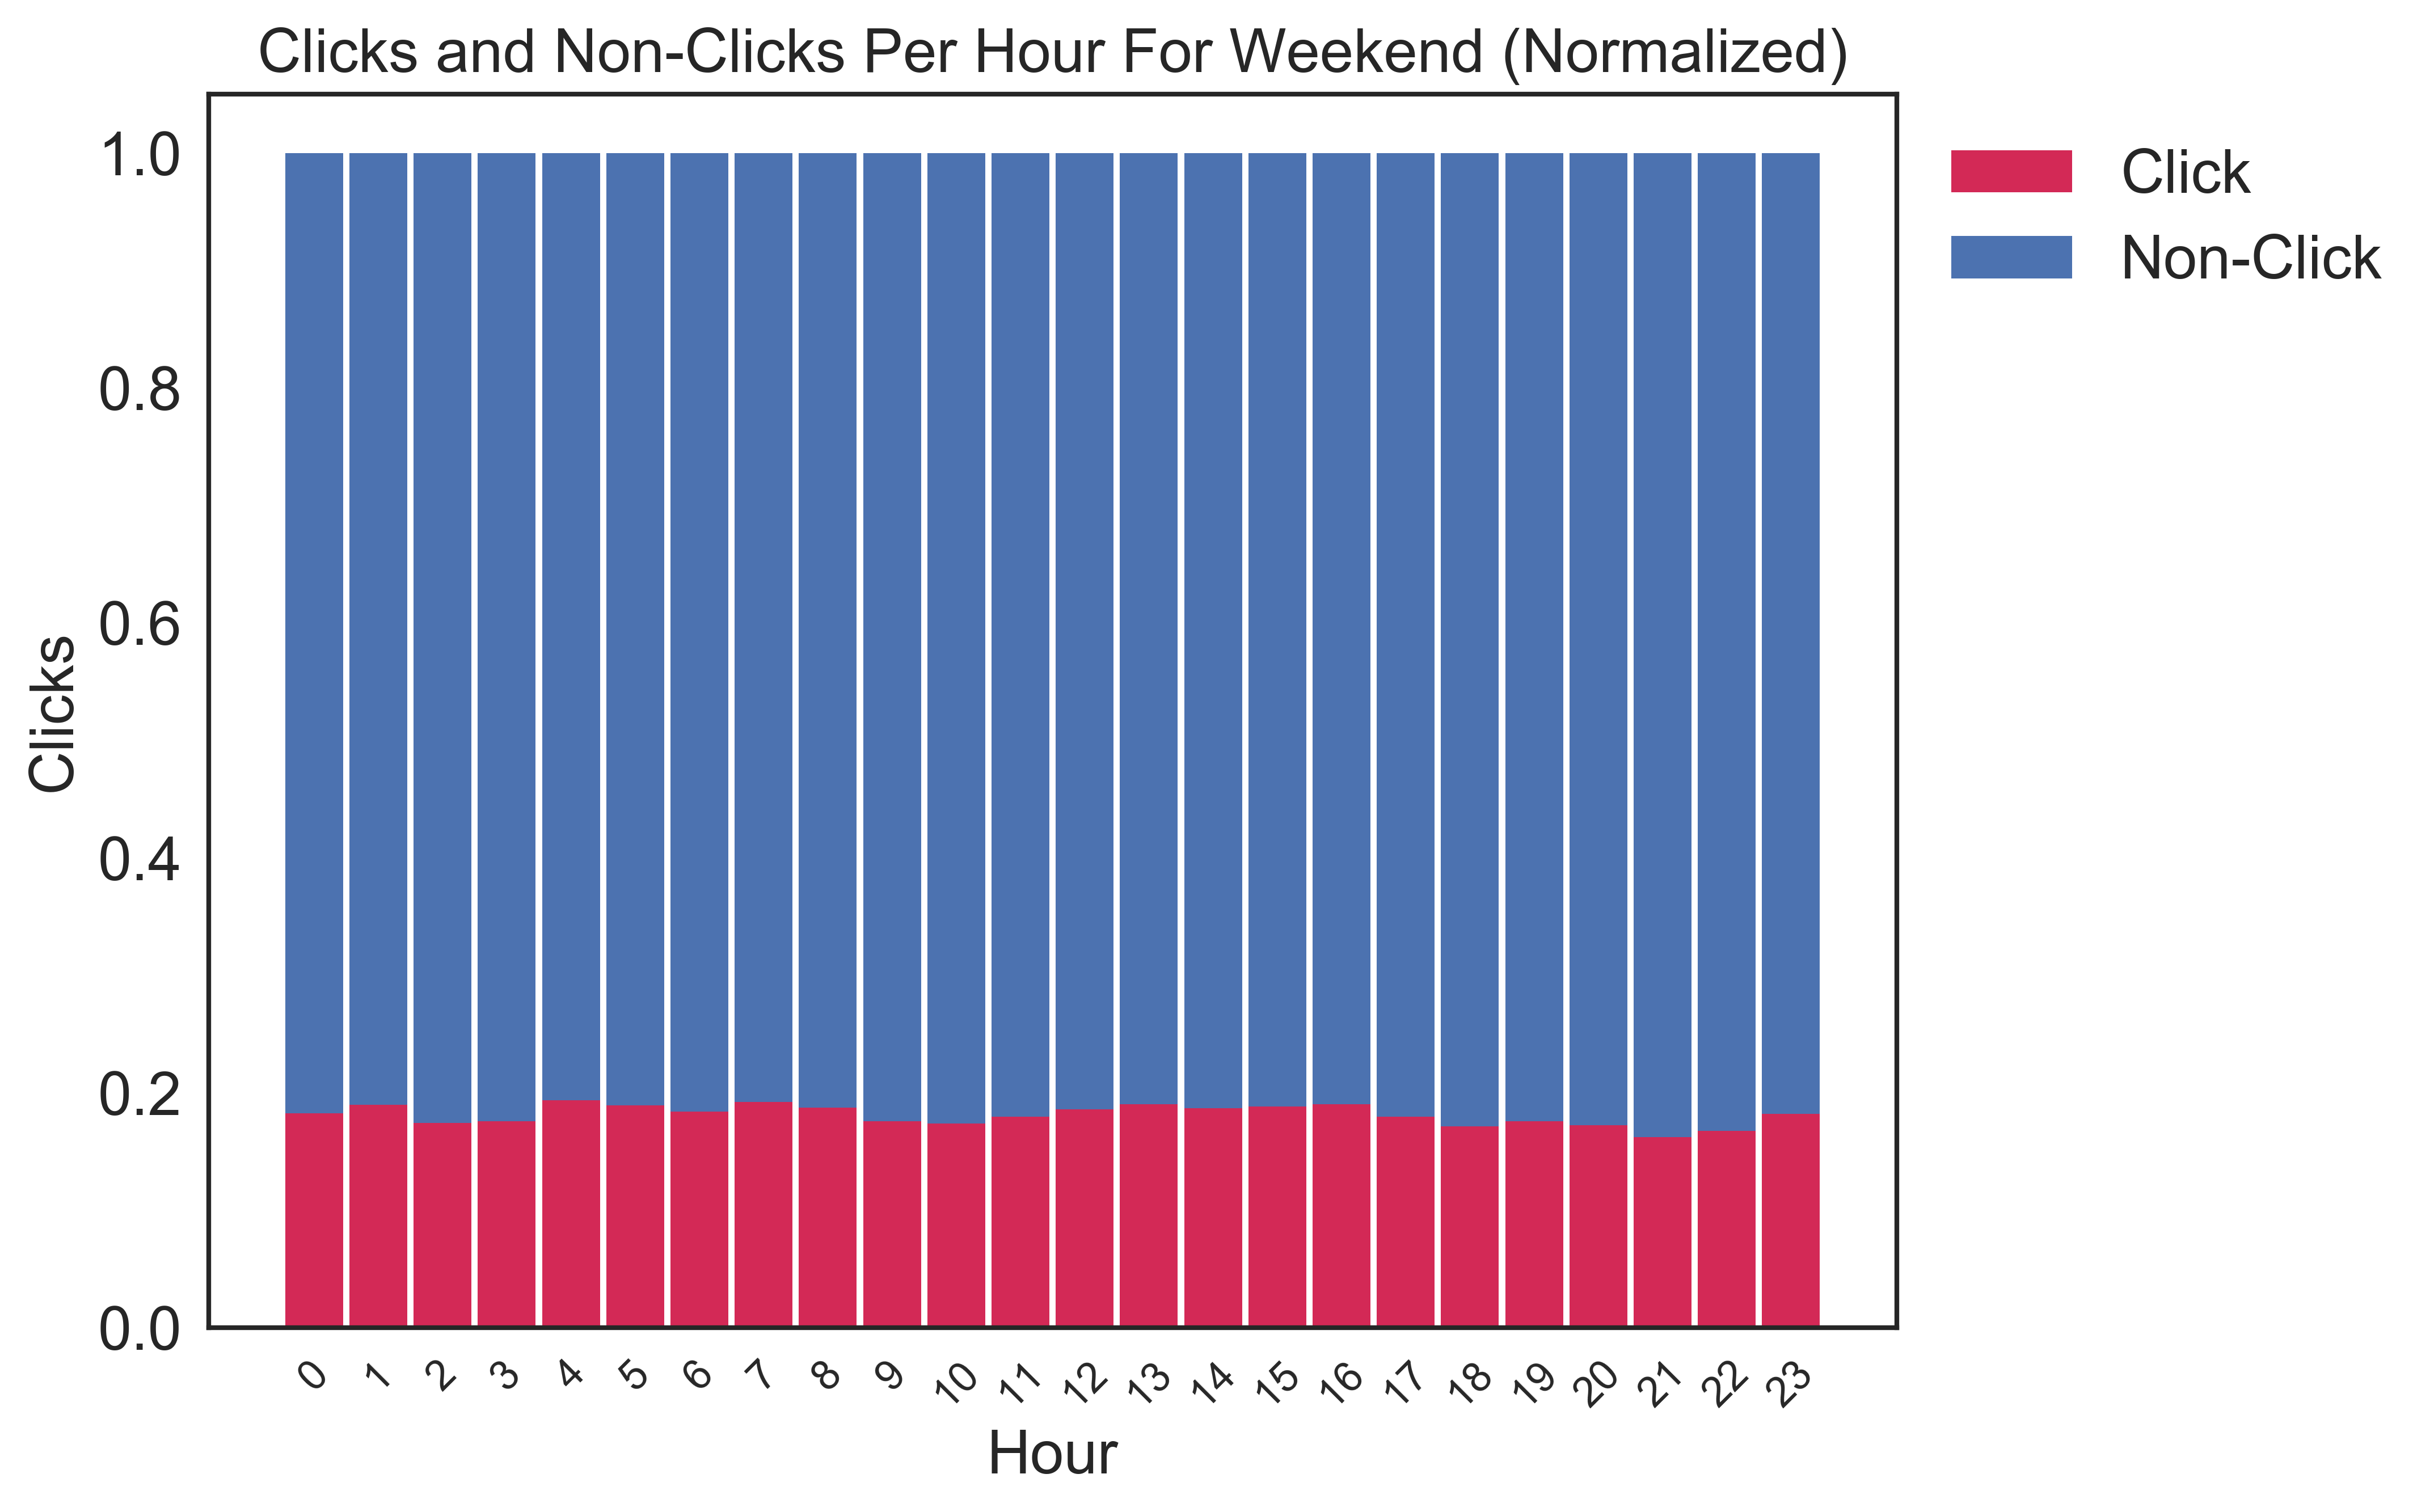

In [28]:
#Plot for Click and Non- Clicks per Hours (For Weekend )

N = 24
a = weekdayHourClick["CTR"][0:24]
b = (TotalWeekdayHourClick["CTR"][0:24]-weekdayHourClick["CTR"][0:24])
index = np.arange(N)    
width = 0.90       
p1 = plt.bar(index, a, width, color='#d62728')
p2 = plt.bar(index, b, width,
             bottom=a)

plt.xticks(index,rotation=45, fontsize = 11)
plt.yticks(fontsize = 16)
plt.ylabel('Clicks',fontsize = 16)
plt.xlabel('Hour',fontsize = 16)
plt.title('Clicks and Non-Clicks Per Hour For Weekend',fontsize = 16)
plt.legend((p1[0], p2[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1),fontsize = 16)

#Plot for CTR (For Weekend )

fig.savefig('weekendHourClick.png', bbox_inches='tight')

#Plot for Click Rate per Hours
fig1,ax1=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
N = 24
a = weekdayHourClick["CTR"][0:24]/TotalWeekdayHourClick["CTR"][0:24]
b = 1-(weekdayHourClick["CTR"][0:24]/TotalWeekdayHourClick["CTR"][0:24])
index = np.arange(N)    
width = 0.90       
p1 = plt.bar(index, a, width, color='#d32956')
p2 = plt.bar(index, b, width,
             bottom=a)

plt.xticks(index,rotation=45, fontsize = 11)
plt.yticks(fontsize = 16)
plt.ylabel('Clicks',fontsize = 16)
plt.xlabel('Hour',fontsize = 16)
plt.title('Clicks and Non-Clicks Per Hour For Weekend (Normalized)',fontsize = 16)
plt.legend((p1[0], p2[0]), ('Click', 'Non-Click'), loc="upper left", bbox_to_anchor=(1,1),fontsize = 16)

plt.show()
fig1.savefig('weekendHourClickNorm.png', bbox_inches='tight')

In [29]:
DateClick=data.groupby(key_columns=["date"], operations={'CTR':gl.aggregate.SUM('click')},)
DateTotal=data.groupby(key_columns=["date"], operations={'CTR':gl.aggregate.COUNT('click')},)
print DateClick
print DateTotal

+------+--------+
| date |  CTR   |
+------+--------+
|  23  | 176607 |
|  26  | 174771 |
|  29  | 150285 |
|  30  | 178842 |
|  25  | 153336 |
|  27  | 146718 |
|  21  | 179474 |
|  28  | 200802 |
|  24  | 145658 |
|  22  | 209945 |
+------+--------+
[10 rows x 2 columns]

+------+---------+
| date |   CTR   |
+------+---------+
|  23  |  967249 |
|  26  |  957963 |
|  29  |  957408 |
|  30  | 1054673 |
|  25  |  841445 |
|  27  |  806990 |
|  21  | 1030204 |
|  28  | 1321535 |
|  24  |  833554 |
|  22  | 1334089 |
+------+---------+
[10 rows x 2 columns]



['10/21/14 (Tue)', '10/22/14 (Wed)', '10/23/14 (Thu)', '10/24/14 (Fri)', '10/25/14 (Sat)', '10/26/14 (Sun)', '10/27/14 (Mon)', '10/28/14 (Tue)', '10/29/14 (Wed)', '10/30/14 (Thu)']
[0.18258690368250574, 0.18244024038506707, 0.15697069587887297, 0.16957104239892365, 0.18222937922264676, 0.18180894434875278, 0.174212097798106, 0.15194603245468338, 0.1747433279667544, 0.1573695608014158]


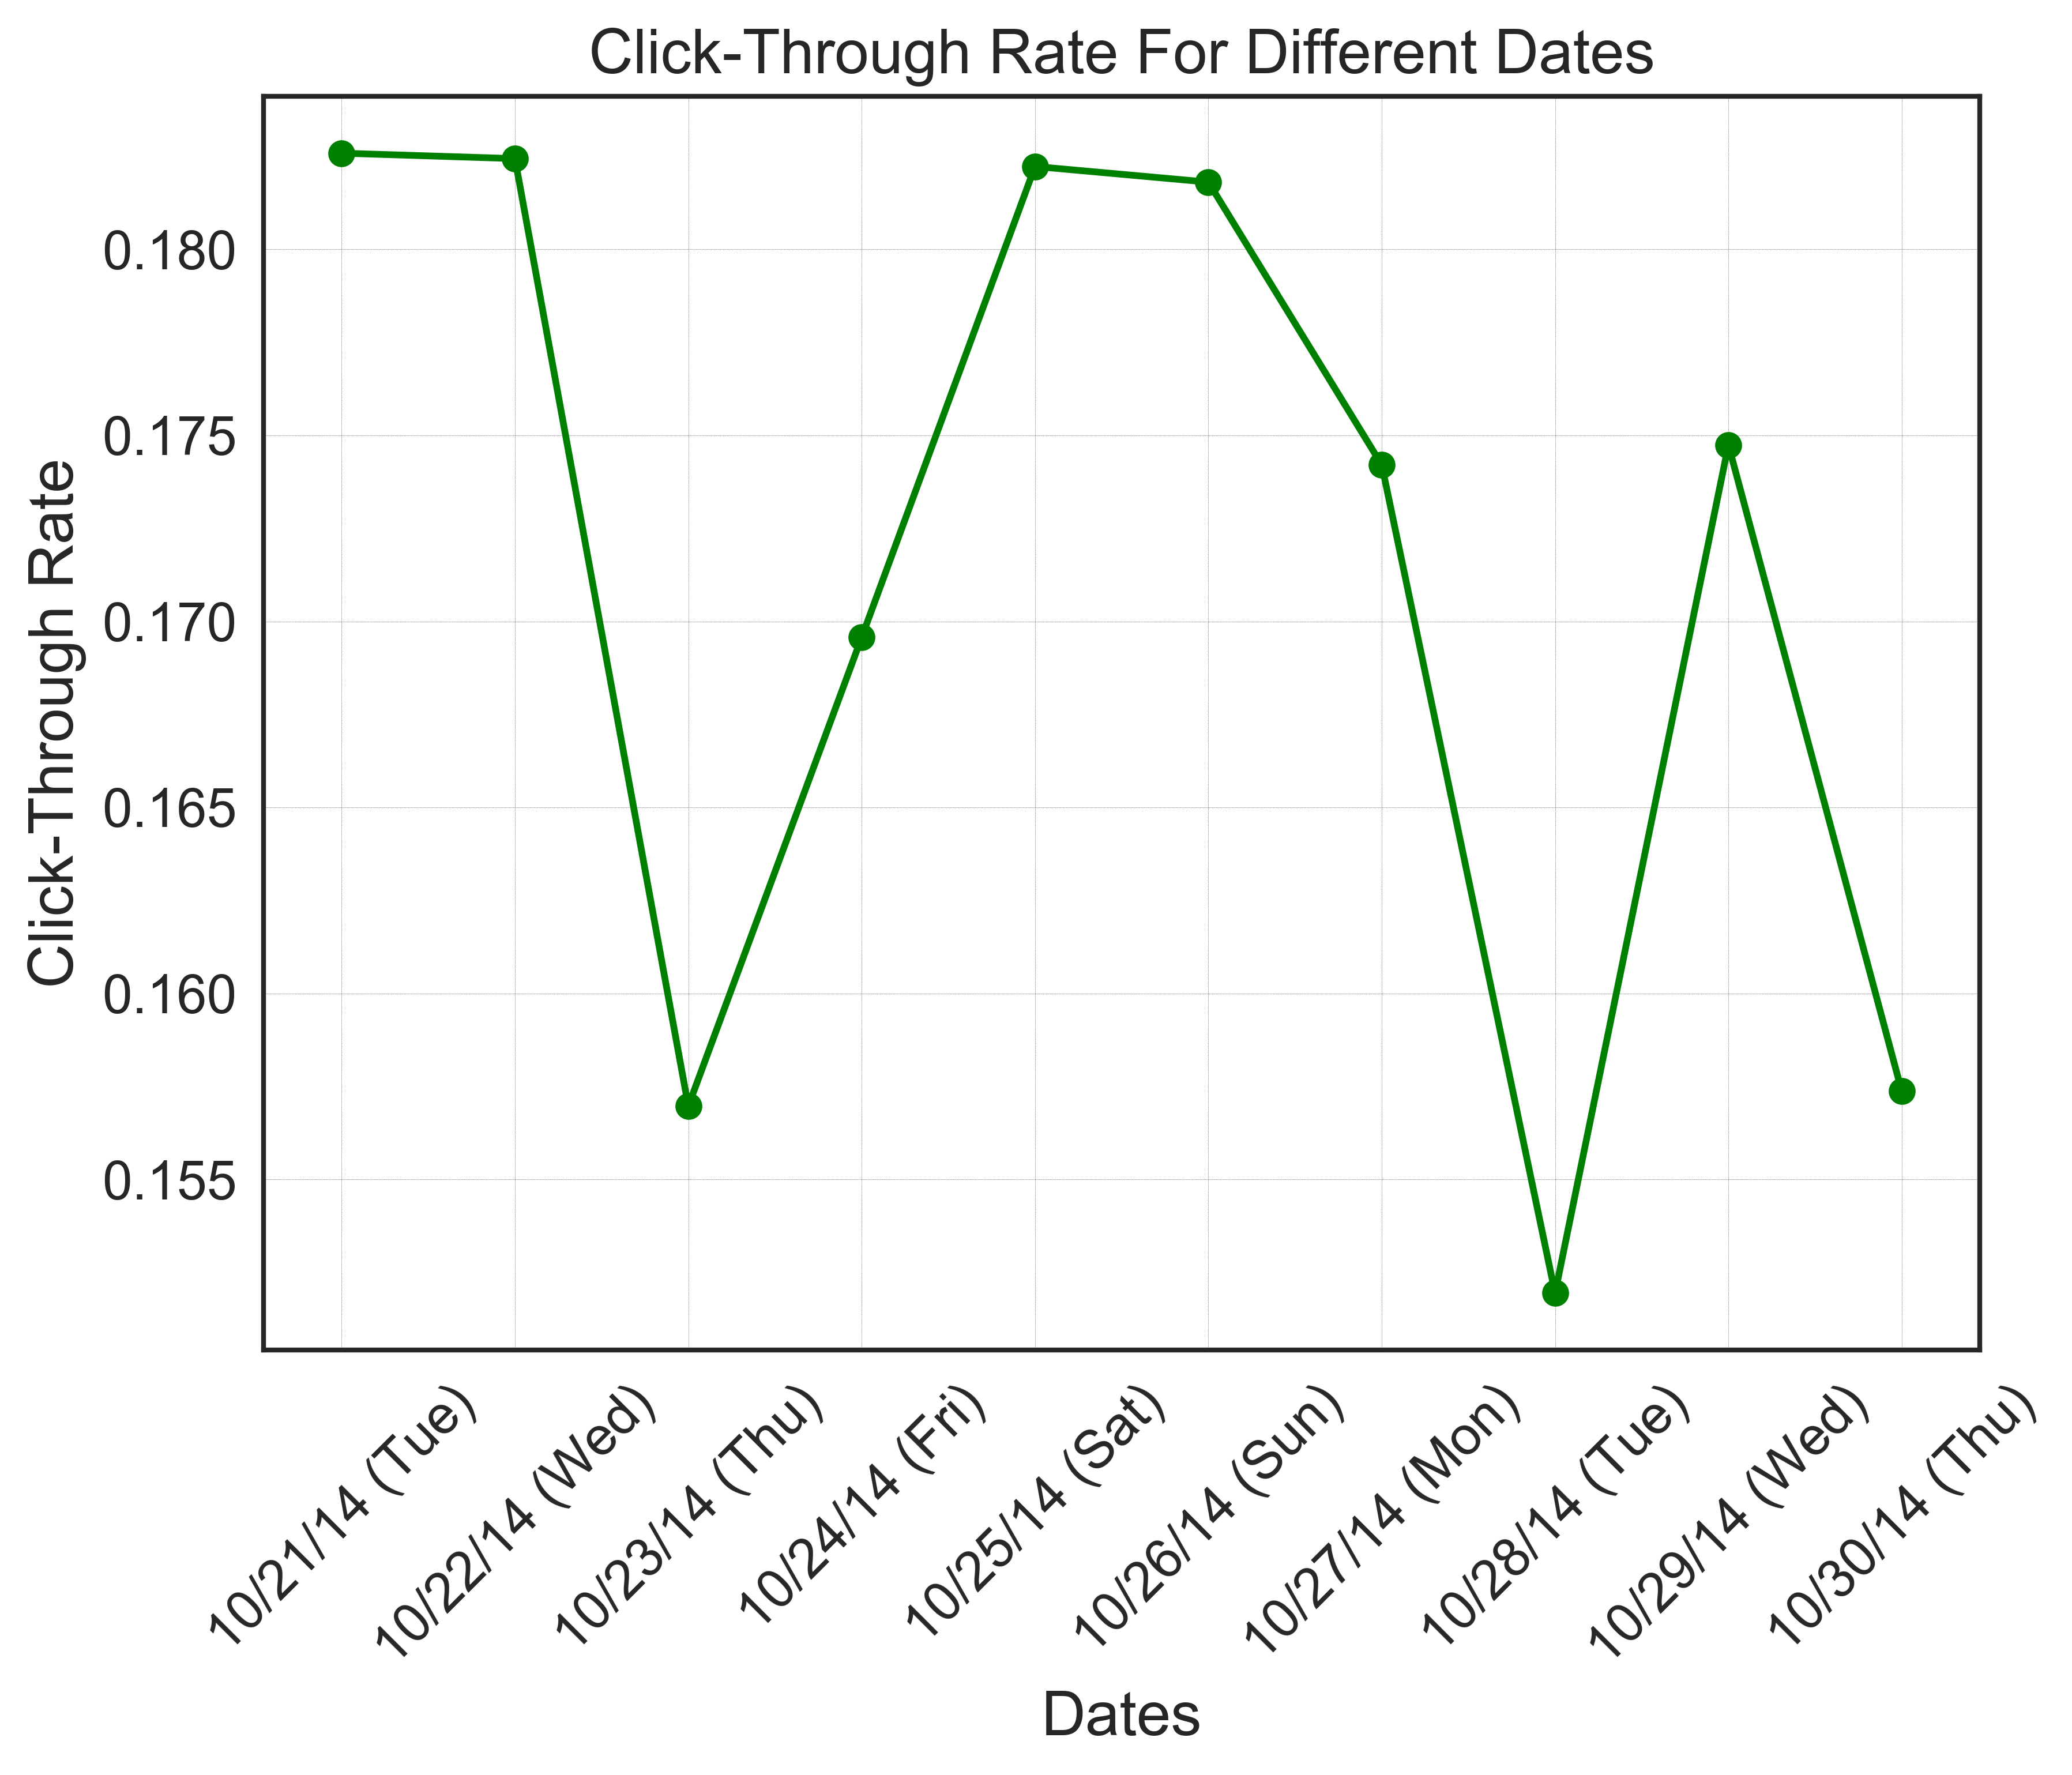

In [30]:
#Plot for CTR for differnt dates

DateClick=data.groupby(key_columns=["date"], operations={'CTR':gl.aggregate.SUM('click')},)
DateTotal=data.groupby(key_columns=["date"], operations={'CTR':gl.aggregate.COUNT('click')},)
x = ['10/21/14 (Tue)','10/22/14 (Wed)','10/23/14 (Thu)','10/24/14 (Fri)','10/25/14 (Sat)','10/26/14 (Sun)','10/27/14 (Mon)','10/28/14 (Tue)','10/29/14 (Wed)','10/30/14 (Thu)',]
y = DateClick['CTR']/DateTotal['CTR']
fig,ax=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');

print x
print y

ax.plot(x, y,'o-',color='green')
plt.ylabel('Click-Through Rate',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(range(len(x)),x,fontsize=14,rotation=45)
plt.xlabel('Dates', fontsize=16)
plt.title('Click-Through Rate For Different Dates', fontsize=16)
ax.grid(color='black', linestyle=':', linewidth=0.1)

plt.show()
fig.savefig('Day_CT.png', bbox_inches='tight')

In [121]:
#Basleline Classification

#print data['click'].shape
#print len(data['click'])

predictions = [0]*len(data['click'])
predictions = gl.SArray(predictions)

Baseline_Log_Loss=gl.evaluation.log_loss(data['click'], predictions)
Baseline_Accuracy=1-(data['click'].mean())

print 'BaseLine Accuracy:', Baseline_Accuracy
print 'BaseLine Log Loss:', Baseline_Log_Loss


BaseLine Accuracy: 0.829427623393
BaseLine Log Loss: 5.89136117479


In [47]:
#Logistic Classifier
#For K fold validation
K=10
folds = gl.cross_validation.KFold(data, K)
accuracy=range(10);
logLoss=range(10);
j=0

for training, valid in folds:
    model_logistic_class_1 = gl.logistic_classifier.create(training, target='click', features=['hour','C17','C20','app_id','area','C15','isWeekDay','date'],max_iterations=1000)
    print model_logistic_class_1.evaluate(valid);
    accuracy[j] = model_logistic_class_1.evaluate(valid,'accuracy');
    logLoss[j] =model_logistic_class_1.evaluate(valid,'log_loss');
    j=j+1
print logLoss
print accuracy

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 173100

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1645

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.181611     | 0.829648          | 0.830662            |

| 2         | 5        | 1.000000  | 0.335684     | 0.829671          | 0.830662            |

| 3         | 6        | 1.000000  | 0.429264     | 0.831306          | 0.832297            |

| 4         | 7        | 1.000000  | 0.531037     | 0.831438          | 0.832625            |

| 5         | 8        | 1.000000  | 0.615871     | 0.830826          | 0.831643            |

| 6         | 9        | 1.000000  | 0.708570     | 0.831040          | 0.831861            |

| 10        | 14       | 1.000000  | 1.120024     | 0.830786          | 0.830989            |

| 11        | 15       | 1.000000  | 1.210909     | 0.831109          | 0.831316            |

| 20        | 25       | 1.000000  | 2.153288     | 0.831288          | 0.831970            |

| 30        | 36       | 1.000000  | 3.027676     | 0.831427          | 0.832406            |

| 40        | 46       | 1.000000  | 3.831992     | 0.831433          | 0.832297            |

| 50        | 56       | 1.000000  | 4.632810     | 0.831421          | 0.832297            |

| 51        | 57       | 1.000000  | 4.735999     | 0.831415          | 0.832297            |

| 60        | 66       | 1.000000  | 5.635079     | 0.831450          | 0.832406            |

| 70        | 77       | 1.000000  | 6.614811     | 0.831456          | 0.832406            |

| 80        | 87       | 1.000000  | 7.608723     | 0.831450          | 0.832406            |

| 90        | 97       | 1.000000  | 8.961080     | 0.831473          | 0.832406            |

| 100       | 107      | 1.000000  | 10.046644    | 0.831462          | 0.832406            |

| 101       | 108      | 1.000000  | 10.138114    | 0.831462          | 0.832406            |

| 110       | 117      | 1.000000  | 11.003934    | 0.831456          | 0.832406            |

| 120       | 128      | 1.000000  | 11.919709    | 0.831450          | 0.832406            |

| 130       | 138      | 1.000000  | 12.773569    | 0.831456          | 0.832406            |

| 140       | 150      | 1.000000  | 13.738528    | 0.831462          | 0.832406            |

| 150       | 165      | 1.000000  | 14.810608    | 0.831462          | 0.832406            |

| 160       | 177      | 1.000000  | 15.754771    | 0.831450          | 0.832406            |

| 170       | 192      | 1.000000  | 16.903661    | 0.831456          | 0.832406            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.012899607403252944, 'auc': 0.6382723626108968, 'recall': 0.006563926940639269, 'precision': 0.3709677419354839, 'log_loss': 0.46267122230316754, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 3504 | 16749 |
|   1e-05   | 0.956892948833 | 0.988299086758 | 3504 | 16749 |
|   2e-05   | 0.956892948833 | 0.988299086758 | 3504 | 16749 |
|   3e-05   | 0.956892948833 | 0.988299086758 | 3504 | 16749 |
|   4e-05   | 0.956892948833 | 0.988299086758 | 3504 | 16749 |
|   5e-05   | 0.956892948833 | 0.988299086758 | 3504 | 16749 |
|   6e-05   | 0.956892948833 | 0.988299086758 | 3504 | 16749 |
|   7e-05   | 0.956892948833 | 0.988299086758 | 3504 | 16749 |
|   8e-05   | 0.956892948833 | 0.988299086758 | 350

Logistic regression:

--------------------------------------------------------

Number of examples          : 172921

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1663

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.180666     | 0.827569          | 0.828021            |

| 2         | 5        | 1.000000  | 0.318883     | 0.827592          | 0.828128            |

| 3         | 6        | 1.000000  | 0.410029     | 0.829061          | 0.828770            |

| 4         | 7        | 1.000000  | 0.500643     | 0.829113          | 0.828877            |

| 5         | 8        | 1.000000  | 0.599394     | 0.828933          | 0.828449            |

| 6         | 9        | 1.000000  | 0.702856     | 0.828962          | 0.828128            |

| 10        | 13       | 1.000000  | 1.044709     | 0.828396          | 0.828342            |

| 11        | 14       | 1.000000  | 1.129244     | 0.829176          | 0.828342            |

| 20        | 23       | 1.000000  | 1.981132     | 0.829142          | 0.828556            |

| 30        | 33       | 1.000000  | 2.980174     | 0.829101          | 0.828449            |

| 40        | 44       | 1.000000  | 4.022979     | 0.829147          | 0.828449            |

| 50        | 54       | 1.000000  | 4.987066     | 0.829142          | 0.828449            |

| 51        | 55       | 1.000000  | 5.084138     | 0.829147          | 0.828449            |

| 60        | 64       | 1.000000  | 5.926656     | 0.829142          | 0.828449            |

| 70        | 74       | 1.000000  | 6.759237     | 0.829153          | 0.828449            |

| 80        | 84       | 1.000000  | 7.631464     | 0.829147          | 0.828449            |

| 90        | 95       | 1.000000  | 8.529810     | 0.829147          | 0.828449            |

| 100       | 111      | 1.000000  | 9.663540     | 0.829147          | 0.828449            |

| 101       | 113      | 1.000000  | 9.799693     | 0.829147          | 0.828449            |

| 110       | 129      | 0.500000  | 10.903285    | 0.829147          | 0.828449            |

| 120       | 147      | 1.000000  | 12.137559    | 0.829147          | 0.828449            |

| 130       | 168      | 1.000000  | 13.778846    | 0.829147          | 0.828449            |

| 140       | 185      | 1.000000  | 15.372862    | 0.829147          | 0.828449            |

| 150       | 205      | 1.000000  | 16.929598    | 0.829147          | 0.828449            |

| 160       | 222      | 1.000000  | 18.271635    | 0.829147          | 0.828449            |

| 170       | 240      | 1.000000  | 20.842899    | 0.829147          | 0.828449            |

| 180       | 254      | 1.000000  | 22.183513    | 0.829147          | 0.828449            |

| 190       | 267      | 1.000000  | 23.316768    | 0.829147          | 0.828449            |

| 200       | 278      | 1.000000  | 24.494991    | 0.829147          | 0.828449            |

| 210       | 293      | 1.000000  | 25.714037    | 0.829147          | 0.828449            |

| 220       | 305      | 1.000000  | 26.717717    | 0.829147          | 0.828449            |

| 230       | 315      | 1.000000  | 27.665159    | 0.829147          | 0.828449            |

| 240       | 331      | 1.000000  | 28.879086    | 0.829147          | 0.828449            |

| 250       | 343      | 0.500000  | 30.152472    | 0.829147          | 0.828449            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.019539867633154743, 'auc': 0.6671258850441559, 'recall': 0.009935897435897435, 'precision': 0.5849056603773585, 'log_loss': 0.43702999746429805, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+---------------+------+-------+
| threshold |      fpr       |      tpr      |  p   |   n   |
+-----------+----------------+---------------+------+-------+
|    0.0    |      1.0       |      1.0      | 3120 | 17133 |
|   1e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |
|   2e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |
|   3e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |
|   4e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |
|   5e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |
|   6e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |
|   7e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |
|   8e-05   | 0.958501138154 | 0.98141025641 | 3120 | 17133 |


Logistic regression:

--------------------------------------------------------

Number of examples          : 173188

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1666

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.201936     | 0.830606          | 0.830012            |

| 2         | 5        | 1.000000  | 0.344768     | 0.830629          | 0.830012            |

| 3         | 6        | 1.000000  | 0.434827     | 0.832298          | 0.830012            |

| 4         | 7        | 1.000000  | 0.533326     | 0.832350          | 0.830342            |

| 5         | 8        | 1.000000  | 0.631706     | 0.831830          | 0.829462            |

| 6         | 9        | 1.000000  | 0.751080     | 0.832130          | 0.830012            |

| 10        | 14       | 1.000000  | 1.211451     | 0.831495          | 0.829572            |

| 11        | 15       | 1.000000  | 1.309594     | 0.831865          | 0.829131            |

| 20        | 25       | 1.000000  | 2.211151     | 0.832379          | 0.829902            |

| 30        | 35       | 1.000000  | 3.120847     | 0.832356          | 0.829902            |

| 40        | 45       | 1.000000  | 4.045507     | 0.832408          | 0.829902            |

| 50        | 55       | 1.000000  | 4.974168     | 0.832396          | 0.829902            |

| 51        | 56       | 1.000000  | 5.069616     | 0.832402          | 0.829902            |

| 60        | 66       | 1.000000  | 6.071014     | 0.832408          | 0.829902            |

| 70        | 76       | 1.000000  | 7.128880     | 0.832402          | 0.829902            |

| 80        | 87       | 1.000000  | 8.182460     | 0.832408          | 0.829902            |

| 90        | 98       | 1.000000  | 9.295414     | 0.832408          | 0.829902            |

| 100       | 108      | 1.000000  | 10.300396    | 0.832408          | 0.829902            |

| 101       | 110      | 1.000000  | 10.466070    | 0.832408          | 0.829902            |

| 110       | 122      | 1.000000  | 11.561896    | 0.832408          | 0.829902            |

| 120       | 136      | 1.000000  | 12.863741    | 0.832408          | 0.829902            |

| 130       | 147      | 1.000000  | 13.978512    | 0.832408          | 0.829902            |

| 140       | 160      | 1.000000  | 15.205236    | 0.832408          | 0.829902            |

| 150       | 175      | 1.000000  | 16.595143    | 0.832408          | 0.829902            |

| 160       | 191      | 1.000000  | 17.813642    | 0.832408          | 0.829902            |

| 170       | 201      | 1.000000  | 18.744066    | 0.832408          | 0.829902            |

| 180       | 215      | 1.000000  | 19.860533    | 0.832408          | 0.829902            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.018255033557046982, 'auc': 0.6143892438325929, 'recall': 0.009279475982532752, 'precision': 0.5573770491803278, 'log_loss': 0.4696073480558691, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 3664 | 16589 |
|   1e-05   | 0.976611007294 | 0.993995633188 | 3664 | 16589 |
|   2e-05   | 0.976611007294 | 0.993995633188 | 3664 | 16589 |
|   3e-05   | 0.976611007294 | 0.993995633188 | 3664 | 16589 |
|   4e-05   | 0.976611007294 | 0.993995633188 | 3664 | 16589 |
|   5e-05   | 0.976611007294 | 0.993995633188 | 3664 | 16589 |
|   6e-05   | 0.976611007294 | 0.993995633188 | 3664 | 16589 |
|   7e-05   | 0.976611007294 | 0.993995633188 | 3664 | 16589 |
|   8e-05   | 0.976611007294 | 0.993995633188 | 3664

Logistic regression:

--------------------------------------------------------

Number of examples          : 173112

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1695

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.172291     | 0.829954          | 0.833606            |

| 2         | 5        | 1.000000  | 0.315554     | 0.829983          | 0.833606            |

| 3         | 6        | 1.000000  | 0.410668     | 0.831658          | 0.834480            |

| 4         | 7        | 1.000000  | 0.501050     | 0.831814          | 0.834371            |

| 5         | 8        | 1.000000  | 0.599500     | 0.831317          | 0.833934            |

| 6         | 9        | 1.000000  | 0.699580     | 0.831641          | 0.834480            |

| 10        | 13       | 1.000000  | 1.085418     | 0.830965          | 0.833060            |

| 11        | 14       | 1.000000  | 1.176006     | 0.831727          | 0.834371            |

| 20        | 23       | 1.000000  | 2.001974     | 0.831785          | 0.834371            |

| 30        | 33       | 1.000000  | 2.891505     | 0.831751          | 0.834480            |

| 40        | 43       | 1.000000  | 3.817984     | 0.831820          | 0.834371            |

| 50        | 53       | 1.000000  | 4.745370     | 0.831826          | 0.834371            |

| 51        | 54       | 1.000000  | 4.839820     | 0.831814          | 0.834371            |

| 60        | 64       | 1.000000  | 5.716840     | 0.831831          | 0.834371            |

| 70        | 74       | 1.000000  | 6.982637     | 0.831831          | 0.834371            |

| 80        | 84       | 1.000000  | 8.133644     | 0.831826          | 0.834480            |

| 90        | 94       | 1.000000  | 9.074988     | 0.831826          | 0.834480            |

| 100       | 109      | 1.000000  | 10.362053    | 0.831826          | 0.834480            |

| 101       | 111      | 1.000000  | 10.509913    | 0.831826          | 0.834371            |

| 110       | 126      | 0.500000  | 11.707648    | 0.831831          | 0.834480            |

| 120       | 146      | 1.000000  | 13.194603    | 0.831831          | 0.834371            |

| 130       | 166      | 1.000000  | 14.546007    | 0.831826          | 0.834480            |

| 140       | 185      | 1.000000  | 15.943539    | 0.831831          | 0.834371            |

| 150       | 200      | 1.000000  | 17.125616    | 0.831831          | 0.834480            |

| 160       | 213      | 1.000000  | 18.335923    | 0.831831          | 0.834371            |

| 170       | 223      | 1.000000  | 19.261262    | 0.831831          | 0.834371            |

| 180       | 236      | 1.000000  | 20.603364    | 0.831831          | 0.834480            |

| 190       | 252      | 1.000000  | 21.923868    | 0.831831          | 0.834371            |

| 200       | 271      | 1.000000  | 23.449626    | 0.831831          | 0.834371            |

| 210       | 290      | 1.000000  | 24.766031    | 0.831831          | 0.834371            |

| 220       | 309      | 1.000000  | 26.189609    | 0.831831          | 0.834371            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.01644286105782406, 'auc': 0.6393964108417649, 'recall': 0.008370535714285714, 'precision': 0.46153846153846156, 'log_loss': 0.4517304112513267, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 3584 | 16669 |
|   1e-05   | 0.975043493911 | 0.997209821429 | 3584 | 16669 |
|   2e-05   | 0.975043493911 | 0.997209821429 | 3584 | 16669 |
|   3e-05   | 0.975043493911 | 0.997209821429 | 3584 | 16669 |
|   4e-05   | 0.975043493911 | 0.997209821429 | 3584 | 16669 |
|   5e-05   | 0.975043493911 | 0.997209821429 | 3584 | 16669 |
|   6e-05   | 0.975043493911 | 0.997209821429 | 3584 | 16669 |
|   7e-05   | 0.975043493911 | 0.997209821429 | 3584 | 16669 |
|   8e-05   | 0.975043493911 | 0.997209821429 | 3584

Logistic regression:

--------------------------------------------------------

Number of examples          : 173152

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1677

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.176898     | 0.830513          | 0.832127            |

| 2         | 5        | 1.000000  | 0.341922     | 0.830530          | 0.832127            |

| 3         | 6        | 1.000000  | 0.432174     | 0.832240          | 0.832237            |

| 4         | 7        | 1.000000  | 0.523689     | 0.832344          | 0.832127            |

| 5         | 8        | 1.000000  | 0.618042     | 0.831541          | 0.831579            |

| 6         | 9        | 1.000000  | 0.717907     | 0.831853          | 0.832018            |

| 10        | 14       | 1.000000  | 1.196052     | 0.831813          | 0.831908            |

| 11        | 15       | 1.000000  | 1.299918     | 0.831853          | 0.831250            |

| 20        | 24       | 1.000000  | 2.239558     | 0.832303          | 0.832018            |

| 30        | 34       | 1.000000  | 3.243420     | 0.832361          | 0.832018            |

| 40        | 44       | 1.000000  | 4.280628     | 0.832373          | 0.832018            |

| 50        | 54       | 1.000000  | 5.218725     | 0.832355          | 0.832127            |

| 51        | 55       | 1.000000  | 5.313357     | 0.832361          | 0.832127            |

| 60        | 64       | 1.000000  | 6.197243     | 0.832367          | 0.832127            |

| 70        | 75       | 1.000000  | 7.203322     | 0.832367          | 0.832127            |

| 80        | 86       | 1.000000  | 8.170452     | 0.832373          | 0.832127            |

| 90        | 96       | 1.000000  | 9.083098     | 0.832367          | 0.832127            |

| 100       | 111      | 1.000000  | 10.617085    | 0.832361          | 0.832127            |

| 101       | 112      | 1.000000  | 10.715030    | 0.832361          | 0.832127            |

| 110       | 124      | 1.000000  | 11.895116    | 0.832361          | 0.832127            |

| 120       | 135      | 1.000000  | 13.193887    | 0.832367          | 0.832127            |

| 130       | 150      | 1.000000  | 14.654726    | 0.832367          | 0.832127            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.20564686051411712, 'auc': 0.6641014436788839, 'recall': 0.13307881101718025, 'precision': 0.4522706209453197, 'log_loss': 0.4799134109335822, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+---------------+------+-------+
| threshold |      fpr       |      tpr      |  p   |   n   |
+-----------+----------------+---------------+------+-------+
|    0.0    |      1.0       |      1.0      | 3667 | 16585 |
|   1e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|   2e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|   3e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|   4e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|   5e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|   6e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|   7e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|   8e-05   | 0.968224299065 | 0.99481865285 | 3667 | 16585 |
|  

Logistic regression:

--------------------------------------------------------

Number of examples          : 173272

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1684

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.184173     | 0.829851          | 0.838778            |

| 2         | 5        | 1.000000  | 0.360970     | 0.829863          | 0.838778            |

| 3         | 6        | 1.000000  | 0.497324     | 0.831531          | 0.839667            |

| 4         | 7        | 1.000000  | 0.603309     | 0.831531          | 0.839889            |

| 5         | 8        | 1.000000  | 0.693559     | 0.830925          | 0.839667            |

| 6         | 9        | 1.000000  | 0.779253     | 0.831242          | 0.839333            |

| 10        | 14       | 1.000000  | 1.246558     | 0.830884          | 0.838222            |

| 11        | 15       | 1.000000  | 1.340766     | 0.830959          | 0.838111            |

| 20        | 24       | 1.000000  | 2.244060     | 0.831231          | 0.839556            |

| 30        | 35       | 1.000000  | 3.461927     | 0.831600          | 0.839556            |

| 40        | 46       | 1.000000  | 4.572800     | 0.831594          | 0.839444            |

| 50        | 57       | 1.000000  | 5.671492     | 0.831600          | 0.839444            |

| 51        | 58       | 1.000000  | 5.762197     | 0.831606          | 0.839556            |

| 60        | 67       | 1.000000  | 6.676545     | 0.831583          | 0.839444            |

| 70        | 77       | 1.000000  | 7.599645     | 0.831583          | 0.839444            |

| 80        | 89       | 1.000000  | 8.667936     | 0.831600          | 0.839444            |

| 90        | 99       | 1.000000  | 9.715392     | 0.831600          | 0.839444            |

| 100       | 110      | 1.000000  | 10.824891    | 0.831594          | 0.839444            |

| 101       | 111      | 1.000000  | 10.922573    | 0.831600          | 0.839444            |

| 110       | 123      | 1.000000  | 12.043685    | 0.831594          | 0.839444            |

| 120       | 142      | 1.000000  | 13.480928    | 0.831594          | 0.839444            |

| 130       | 160      | 1.000000  | 14.741878    | 0.831600          | 0.839444            |

| 140       | 180      | 1.000000  | 16.055559    | 0.831594          | 0.839444            |

| 150       | 193      | 1.000000  | 17.079589    | 0.831606          | 0.839444            |

| 160       | 205      | 1.000000  | 18.006382    | 0.831594          | 0.839444            |

| 170       | 218      | 1.000000  | 18.978405    | 0.831594          | 0.839444            |

| 180       | 230      | 1.000000  | 19.954045    | 0.831600          | 0.839444            |

| 190       | 241      | 1.000000  | 20.890504    | 0.831594          | 0.839444            |

| 200       | 252      | 1.000000  | 21.835404    | 0.831594          | 0.839444            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.01637107776261937, 'auc': 0.6472028418226649, 'recall': 0.008305647840531562, 'precision': 0.5660377358490566, 'log_loss': 0.45644859800783283, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 3612 | 16640 |
|   1e-05   | 0.975600961538 | 0.993909191584 | 3612 | 16640 |
|   2e-05   | 0.975600961538 | 0.993909191584 | 3612 | 16640 |
|   3e-05   | 0.975600961538 | 0.993909191584 | 3612 | 16640 |
|   4e-05   | 0.975600961538 | 0.993909191584 | 3612 | 16640 |
|   5e-05   | 0.975600961538 | 0.993909191584 | 3612 | 16640 |
|   6e-05   | 0.975600961538 | 0.993909191584 | 3612 | 16640 |
|   7e-05   | 0.975600961538 | 0.993909191584 | 3612 | 16640 |
|   8e-05   | 0.975600961538 | 0.993909191584 | 3612

Logistic regression:

--------------------------------------------------------

Number of examples          : 173138

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1698

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.176121     | 0.830840          | 0.824721            |

| 2         | 5        | 1.000000  | 0.318036     | 0.830863          | 0.824721            |

| 3         | 6        | 1.000000  | 0.409268     | 0.832521          | 0.824830            |

| 4         | 7        | 1.000000  | 0.507765     | 0.832515          | 0.824940            |

| 5         | 8        | 1.000000  | 0.597550     | 0.832082          | 0.824064            |

| 6         | 9        | 1.000000  | 0.692319     | 0.832371          | 0.824721            |

| 10        | 13       | 1.000000  | 1.061917     | 0.831562          | 0.824064            |

| 11        | 14       | 1.000000  | 1.159859     | 0.832296          | 0.824830            |

| 20        | 23       | 1.000000  | 1.963604     | 0.832538          | 0.824611            |

| 30        | 34       | 1.000000  | 2.958305     | 0.832573          | 0.824611            |

| 40        | 44       | 1.000000  | 3.900228     | 0.832596          | 0.824721            |

| 50        | 55       | 1.000000  | 4.808152     | 0.832579          | 0.824721            |

| 51        | 56       | 1.000000  | 4.908688     | 0.832573          | 0.824611            |

| 60        | 65       | 1.000000  | 5.684762     | 0.832596          | 0.824721            |

| 70        | 75       | 1.000000  | 6.644789     | 0.832573          | 0.824721            |

| 80        | 85       | 1.000000  | 7.535582     | 0.832573          | 0.824721            |

| 90        | 97       | 1.000000  | 8.498314     | 0.832573          | 0.824721            |

| 100       | 111      | 1.000000  | 9.611959     | 0.832567          | 0.824721            |

| 101       | 112      | 1.000000  | 9.708458     | 0.832573          | 0.824721            |

| 110       | 128      | 0.500000  | 10.914917    | 0.832573          | 0.824721            |

| 120       | 138      | 0.500000  | 11.773472    | 0.832573          | 0.824721            |

| 130       | 148      | 0.500000  | 12.638525    | 0.832573          | 0.824721            |

| 140       | 158      | 0.500000  | 13.497596    | 0.832573          | 0.824721            |

| 150       | 170      | 0.500000  | 14.429809    | 0.832567          | 0.824721            |

| 160       | 190      | 1.000000  | 15.719063    | 0.832567          | 0.824721            |

| 170       | 207      | 1.000000  | 16.870299    | 0.832573          | 0.824721            |

| 180       | 225      | 1.000000  | 18.050896    | 0.832567          | 0.824721            |

| 190       | 239      | 1.000000  | 19.086621    | 0.832573          | 0.824721            |

| 200       | 256      | 1.000000  | 20.249882    | 0.832567          | 0.824721            |

| 210       | 268      | 1.000000  | 21.162719    | 0.832573          | 0.824721            |

| 220       | 283      | 1.000000  | 22.235329    | 0.832567          | 0.824721            |

| 230       | 296      | 1.000000  | 23.223802    | 0.832567          | 0.824721            |

| 240       | 310      | 0.500000  | 24.255825    | 0.832573          | 0.824721            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.03194888178913738, 'auc': 0.6545636458100954, 'recall': 0.016411378555798686, 'precision': 0.6, 'log_loss': 0.4480299045797505, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 3656 | 16596 |
|   1e-05   | 0.979151602796 | 0.996991247265 | 3656 | 16596 |
|   2e-05   | 0.979151602796 | 0.996991247265 | 3656 | 16596 |
|   3e-05   | 0.978970836346 | 0.996991247265 | 3656 | 16596 |
|   4e-05   | 0.978970836346 | 0.996991247265 | 3656 | 16596 |
|   5e-05   | 0.978970836346 | 0.996991247265 | 3656 | 16596 |
|   6e-05   | 0.978970836346 | 0.996991247265 | 3656 | 16596 |
|   7e-05   | 0.978970836346 | 0.996991247265 | 3656 | 16596 |
|   8e-05   | 0.978970836346 | 0.996991247265 | 3656 | 16596 |
|   9

Logistic regression:

--------------------------------------------------------

Number of examples          : 173208

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1685

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.160426     | 0.826769          | 0.829545            |

| 2         | 5        | 1.000000  | 0.316018     | 0.826798          | 0.829545            |

| 3         | 6        | 1.000000  | 0.406674     | 0.828489          | 0.829325            |

| 4         | 7        | 1.000000  | 0.508570     | 0.828547          | 0.829656            |

| 5         | 8        | 1.000000  | 0.604867     | 0.828247          | 0.829325            |

| 6         | 9        | 1.000000  | 0.698696     | 0.826942          | 0.829214            |

| 10        | 13       | 1.000000  | 1.064455     | 0.828449          | 0.829766            |

| 11        | 14       | 1.000000  | 1.151698     | 0.828536          | 0.829766            |

| 20        | 23       | 1.000000  | 1.929321     | 0.828530          | 0.829656            |

| 30        | 33       | 1.000000  | 2.766840     | 0.828507          | 0.829435            |

| 40        | 44       | 1.000000  | 3.714482     | 0.828524          | 0.829656            |

| 50        | 55       | 1.000000  | 4.687101     | 0.828524          | 0.829656            |

| 51        | 56       | 1.000000  | 4.780897     | 0.828530          | 0.829656            |

| 60        | 65       | 1.000000  | 5.571840     | 0.828541          | 0.829656            |

| 70        | 76       | 1.000000  | 6.489861     | 0.828536          | 0.829656            |

| 80        | 86       | 1.000000  | 7.476084     | 0.828530          | 0.829656            |

| 90        | 96       | 1.000000  | 8.488287     | 0.828541          | 0.829656            |

| 100       | 108      | 1.000000  | 9.602817     | 0.828536          | 0.829656            |

| 101       | 109      | 1.000000  | 9.699137     | 0.828541          | 0.829656            |

| 110       | 120      | 1.000000  | 10.695471    | 0.828541          | 0.829656            |

| 120       | 133      | 1.000000  | 11.881507    | 0.828541          | 0.829656            |

| 130       | 149      | 1.000000  | 13.213304    | 0.828536          | 0.829656            |

| 140       | 169      | 1.000000  | 14.696728    | 0.828541          | 0.829656            |

| 150       | 186      | 1.000000  | 16.082884    | 0.828536          | 0.829656            |

| 160       | 202      | 1.000000  | 17.380931    | 0.828541          | 0.829656            |

| 170       | 213      | 1.000000  | 18.487421    | 0.828536          | 0.829656            |

| 180       | 225      | 0.500000  | 19.501416    | 0.828536          | 0.829656            |

| 190       | 235      | 0.500000  | 20.488128    | 0.828541          | 0.829656            |

| 200       | 252      | 1.000000  | 21.873466    | 0.828536          | 0.829656            |

| 210       | 262      | 1.000000  | 22.809228    | 0.828541          | 0.829656            |

| 220       | 279      | 1.000000  | 24.127782    | 0.828536          | 0.829656            |

| 230       | 293      | 1.000000  | 25.425262    | 0.828541          | 0.829656            |

| 240       | 304      | 1.000000  | 26.443238    | 0.828541          | 0.829656            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.017763157894736842, 'auc': 0.6554897323125429, 'recall': 0.009015025041736227, 'precision': 0.6, 'log_loss': 0.3994817467015475, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 2995 | 17257 |
|   1e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   2e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   3e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   4e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   5e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   6e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   7e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   8e-05   | 0.979370690155 | 0.995325542571 | 2995 | 17257 |
|   

Logistic regression:

--------------------------------------------------------

Number of examples          : 173317

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1686

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.190736     | 0.828286          | 0.828587            |

| 2         | 5        | 1.000000  | 0.337220     | 0.828309          | 0.828587            |

| 3         | 6        | 1.000000  | 0.436389     | 0.829901          | 0.829816            |

| 4         | 7        | 1.000000  | 0.531248     | 0.830011          | 0.830039            |

| 5         | 8        | 1.000000  | 0.625722     | 0.829347          | 0.829146            |

| 6         | 9        | 1.000000  | 0.733299     | 0.829682          | 0.828811            |

| 10        | 14       | 1.000000  | 1.199391     | 0.829036          | 0.829146            |

| 11        | 15       | 1.000000  | 1.292962     | 0.829440          | 0.829592            |

| 20        | 25       | 1.000000  | 2.238492     | 0.830017          | 0.830039            |

| 30        | 35       | 1.000000  | 3.233880     | 0.829999          | 0.830151            |

| 40        | 46       | 1.000000  | 4.261792     | 0.830034          | 0.830039            |

| 50        | 56       | 1.000000  | 5.249210     | 0.830051          | 0.830151            |

| 51        | 57       | 1.000000  | 5.349791     | 0.830051          | 0.830151            |

| 60        | 66       | 1.000000  | 6.304506     | 0.830051          | 0.830151            |

| 70        | 76       | 1.000000  | 7.295288     | 0.830051          | 0.830151            |

| 80        | 89       | 1.000000  | 8.416820     | 0.830046          | 0.830151            |

| 90        | 102      | 1.000000  | 9.562506     | 0.830046          | 0.830151            |

| 100       | 114      | 1.000000  | 10.652289    | 0.830046          | 0.830151            |

| 101       | 117      | 0.500000  | 10.877953    | 0.830046          | 0.830151            |

| 110       | 134      | 1.000000  | 12.249268    | 0.830046          | 0.830151            |

| 120       | 154      | 1.000000  | 13.830212    | 0.830046          | 0.830151            |

| 130       | 168      | 1.000000  | 14.883950    | 0.830046          | 0.830151            |

| 140       | 179      | 1.000000  | 15.931751    | 0.830046          | 0.830151            |

| 150       | 193      | 1.000000  | 17.175381    | 0.830046          | 0.830151            |

| 160       | 212      | 1.000000  | 18.624377    | 0.830046          | 0.830151            |

| 170       | 226      | 1.000000  | 19.746298    | 0.830046          | 0.830151            |

| 180       | 236      | 1.000000  | 20.590281    | 0.830046          | 0.830151            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.013357619914996965, 'auc': 0.6566119983135497, 'recall': 0.006771314250538628, 'precision': 0.4888888888888889, 'log_loss': 0.4269214002280382, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 3249 | 17003 |
|   1e-05   | 0.974181026878 | 0.994152046784 | 3249 | 17003 |
|   2e-05   | 0.974181026878 | 0.994152046784 | 3249 | 17003 |
|   3e-05   | 0.974122213727 | 0.994152046784 | 3249 | 17003 |
|   4e-05   | 0.974122213727 | 0.994152046784 | 3249 | 17003 |
|   5e-05   | 0.974122213727 | 0.994152046784 | 3249 | 17003 |
|   6e-05   | 0.974122213727 | 0.994152046784 | 3249 | 17003 |
|   7e-05   | 0.974122213727 | 0.994152046784 | 3249 | 17003 |
|   8e-05   | 0.974122213727 | 0.994152046784 | 3249

Logistic regression:

--------------------------------------------------------

Number of examples          : 173083

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 1681

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000006  | 0.168304     | 0.829538          | 0.831647            |

| 2         | 5        | 1.000000  | 0.316558     | 0.829556          | 0.831755            |

| 3         | 6        | 1.000000  | 0.417616     | 0.831301          | 0.832626            |

| 4         | 7        | 1.000000  | 0.507511     | 0.831341          | 0.832517            |

| 5         | 8        | 1.000000  | 0.605759     | 0.830833          | 0.831647            |

| 6         | 9        | 1.000000  | 0.711744     | 0.831121          | 0.832299            |

| 10        | 13       | 1.000000  | 1.074237     | 0.830238          | 0.831429            |

| 11        | 14       | 1.000000  | 1.158890     | 0.830815          | 0.832191            |

| 20        | 23       | 1.000000  | 1.932147     | 0.831381          | 0.832626            |

| 30        | 33       | 1.000000  | 2.791554     | 0.831387          | 0.832626            |

| 40        | 45       | 0.500000  | 3.713547     | 0.831358          | 0.832517            |

| 50        | 55       | 0.500000  | 4.564098     | 0.831364          | 0.832517            |

| 51        | 56       | 0.500000  | 4.652278     | 0.831364          | 0.832517            |

| 60        | 65       | 0.500000  | 5.416804     | 0.831370          | 0.832517            |

| 70        | 75       | 0.500000  | 6.274112     | 0.831376          | 0.832517            |

| 80        | 85       | 0.500000  | 7.114863     | 0.831364          | 0.832517            |

| 90        | 95       | 0.500000  | 7.961176     | 0.831370          | 0.832517            |

| 100       | 105      | 0.500000  | 8.799679     | 0.831364          | 0.832517            |

| 101       | 106      | 0.500000  | 8.883099     | 0.831364          | 0.832517            |

| 110       | 115      | 0.500000  | 9.627273     | 0.831364          | 0.832517            |

| 120       | 125      | 0.500000  | 10.507319    | 0.831364          | 0.832517            |

| 130       | 135      | 0.500000  | 11.360889    | 0.831364          | 0.832517            |

| 140       | 145      | 0.500000  | 12.218633    | 0.831364          | 0.832517            |

| 150       | 159      | 1.000000  | 13.251965    | 0.831364          | 0.832517            |

| 160       | 169      | 1.000000  | 14.110462    | 0.831364          | 0.832517            |

| 170       | 182      | 1.000000  | 15.102570    | 0.831364          | 0.832517            |

| 180       | 194      | 1.000000  | 16.054090    | 0.831364          | 0.832517            |

| 190       | 209      | 1.000000  | 17.109027    | 0.831364          | 0.832517            |

| 200       | 223      | 1.000000  | 18.151828    | 0.831364          | 0.832517            |

| 210       | 241      | 1.000000  | 19.420535    | 0.831364          | 0.832517            |

| 220       | 260      | 1.000000  | 20.655161    | 0.831364          | 0.832517            |

| 230       | 280      | 0.500000  | 22.001993    | 0.831364          | 0.832517            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

{'f1_score': 0.13558504221954162, 'auc': 0.6631672572824071, 'recall': 0.08042358328563251, 'precision': 0.43164362519201227, 'log_loss': 0.4429675774155032, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+-------+
| threshold |      fpr       |      tpr       |  p   |   n   |
+-----------+----------------+----------------+------+-------+
|    0.0    |      1.0       |      1.0       | 3494 | 16758 |
|   1e-05   | 0.965926721566 | 0.996565540927 | 3494 | 16758 |
|   2e-05   | 0.965926721566 | 0.996565540927 | 3494 | 16758 |
|   3e-05   | 0.965926721566 | 0.996565540927 | 3494 | 16758 |
|   4e-05   | 0.965926721566 | 0.996565540927 | 3494 | 16758 |
|   5e-05   | 0.965926721566 | 0.996565540927 | 3494 | 16758 |
|   6e-05   | 0.965926721566 | 0.996565540927 | 3494 | 16758 |
|   7e-05   | 0.965926721566 | 0.996565540927 | 3494 | 16758 |
|   8e-05   | 0.965926721566 | 0.996565540927 | 3494 

In [48]:
log_loss_total=0
accuracy_total=0
for i in range(0,10):
    log_loss_total=log_loss_total+(logLoss)[i]['log_loss']
    accuracy_total=accuracy_total+(accuracy)[i]['accuracy']
log_loss_mean=log_loss_total/10
accracy_mean=accuracy_total/10
print log_loss_mean
print accracy_mean



0.447480161694
0.828627716682


In [49]:
#To split the data into testing and training in a 80:20 split
training_data, testing_data = data.random_split(0.8)

In [610]:
gl.show()

Canvas is accessible via web browser at the URL: http://localhost:58475/index.html
Opening Canvas in default web browser.


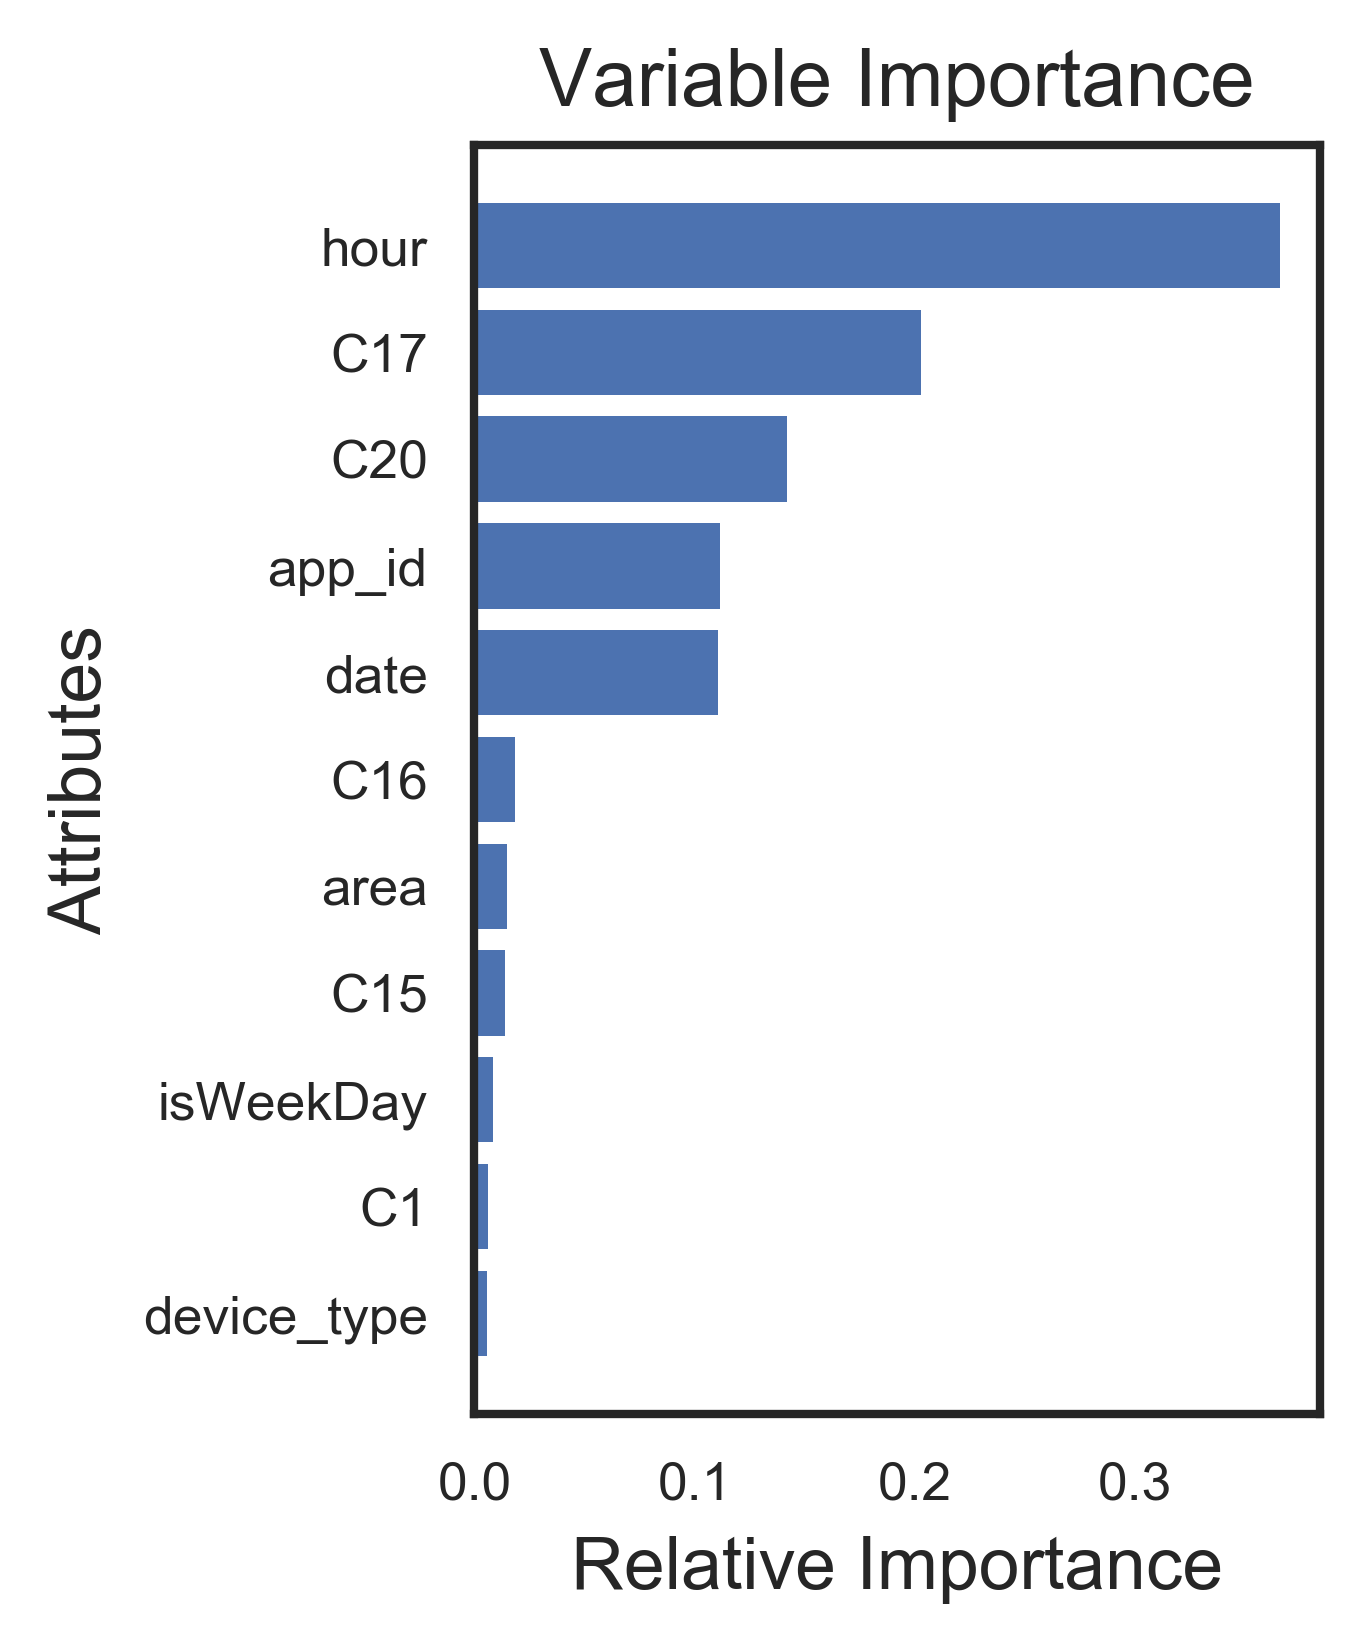

In [219]:
#Variable Importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
features = [ 'hour','device_type','isWeekDay','area','C1', 'C15','C16','C20','C17','app_id','date']
X=gl.SFrame.to_dataframe(training_data)
X=X[features]

enc = LabelEncoder()

enc.fit(X['app_id'])
X['app_id'] = enc.transform(X['app_id'])

enc.fit(X['device_type'])
X['device_type'] = enc.transform(X['device_type'])

Y=gl.SFrame.to_dataframe(training_data)
Y=Y['click']


trained_model = RandomForestClassifier()
trained_model.fit(X, Y)

fig,ax=plt.subplots(num=None, figsize=(5, 3.5), dpi=480, facecolor='w', edgecolor='k');

feature_importance=trained_model.feature_importances_
features = np.asarray(features)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) 
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx],fontsize = 8)
plt.xticks(fontsize = 8)
plt.xlabel('Relative Importance',fontsize = 11)
plt.ylabel('Attributes',fontsize = 11)
plt.title('Variable Importance',fontsize = 12)
plt.show()

fig.savefig('VariableImportance.png', bbox_inches='tight')

In [28]:
training_data_random_forest= training_data[ 'hour','device_type','isWeekDay','area','C1', 'C15','C16','C20','C17','app_id','click']
testing_data_random_forest= testing_data[ 'hour','device_type','isWeekDay','area','C1', 'C15','C16','C20','C17','app_id','click']
model_random = gl.random_forest_classifier.create(training_data_random_forest, target='click',max_iterations=20,max_depth =20)
model_random.evaluate(testing_data_random_forest)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154534

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.227851     | 0.835784          | 0.835055            | 0.426223          | 0.427860            |

| 2         | 0.482251     | 0.839039          | 0.835802            | 0.420329          | 0.427334            |

| 3         | 0.685290     | 0.838586          | 0.836051            | 0.422869          | 0.428259            |

| 4         | 0.914761     | 0.839226          | 0.836425            | 0.421130          | 0.426980            |

| 5         | 1.192915     | 0.839298          | 0.836425            | 0.420007          | 0.426823            |

| 6         | 1.399037     | 0.839052          | 0.837047            | 0.419880          | 0.426532            |

| 10        | 2.283055     | 0.839013          | 0.836923            | 0.419507          | 0.426059            |

| 11        | 2.521855     | 0.839272          | 0.836798            | 0.419169          | 0.426079            |

| 15        | 3.410176     | 0.838599          | 0.837296            | 0.419973          | 0.425517            |

| 20        | 4.526523     | 0.838411          | 0.837421            | 0.420390          | 0.425754            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

{'accuracy': 0.8296668919088019,
 'auc': 0.7061715322581489,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  335  |
 |      0       |        0        | 32731 |
 |      1       |        1        |  420  |
 |      1       |        0        |  6471 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.10986136541982736,
 'log_loss': 0.4360046846989875,
 'precision': 0.5562913907284768,
 'recall': 0.06094906399651719,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+-------+
 | threshold | fpr | tpr |  p   |   n   |
 +-----------+-----+-----+------+-------+
 |    0.0    | 1.0 | 1.0 | 6891 | 33066 |
 |   1e-05   | 1.0 | 1.0 | 6891 | 33066 |
 |   2e-05  

In [50]:
#Random Forest Classifer 1
#For K=10 for 10 fold Cross validation
K=10
folds = gl.cross_validation.KFold(data, K)
accuracy=range(10);
logLoss=range(10);
j=0

for training, valid in folds:
    training_data_random_forest= training[ 'hour','device_type','isWeekDay','area','C1','C16','C20','C17','app_id','click','date']
    testing_data_random_forest= valid[ 'hour','device_type','isWeekDay','area','C1', 'C16','C20','C17','app_id','click','date']
    model_random_1 = gl.random_forest_classifier.create(training_data_random_forest, target='click',max_iterations=20,max_depth =25)
    model_random_1.evaluate(testing_data_random_forest)
    accuracy[j] =  model_random_1.evaluate(testing_data_random_forest,'accuracy')
    logLoss[j] = model_random_1.evaluate(testing_data_random_forest,'log_loss')
    j=j+1
print logLoss
print accuracy

log_loss_total=0
accuracy_total=0
for i in range(0,10):
    log_loss_total=log_loss_total+(logLoss)[i]['log_loss']
    accuracy_total=accuracy_total+(accuracy)[i]['accuracy']
log_loss_mean=log_loss_total/10
accracy_mean=accuracy_total/10
print log_loss_mean
print accracy_mean


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173194

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.261338     | 0.834509          | 0.834306            | 0.428714          | 0.428734            |

| 2         | 0.639012     | 0.842235          | 0.830451            | 0.417648          | 0.429412            |

| 3         | 0.963756     | 0.844175          | 0.830340            | 0.414066          | 0.429328            |

| 4         | 1.294387     | 0.845249          | 0.831552            | 0.411911          | 0.429175            |

| 5         | 1.630530     | 0.845832          | 0.831222            | 0.410793          | 0.429454            |

| 6         | 1.943204     | 0.846080          | 0.831001            | 0.410153          | 0.429254            |

| 10        | 3.193422     | 0.845330          | 0.831993            | 0.410469          | 0.429025            |

| 11        | 3.514189     | 0.844833          | 0.833095            | 0.410580          | 0.428463            |

| 15        | 4.663469     | 0.843499          | 0.834527            | 0.411926          | 0.428481            |

| 20        | 6.186870     | 0.843886          | 0.833535            | 0.411493          | 0.428453            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173146

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.345446     | 0.844946          | 0.826192            | 0.417425          | 0.439971            |

| 2         | 0.615094     | 0.841700          | 0.831233            | 0.416596          | 0.434347            |

| 3         | 0.887251     | 0.840990          | 0.832548            | 0.418227          | 0.432091            |

| 4         | 1.257389     | 0.841637          | 0.833096            | 0.416253          | 0.431469            |

| 5         | 1.567359     | 0.842532          | 0.832438            | 0.414846          | 0.431295            |

| 6         | 1.884187     | 0.842971          | 0.832877            | 0.413741          | 0.431398            |

| 10        | 3.025508     | 0.841348          | 0.833096            | 0.415533          | 0.431887            |

| 11        | 3.291275     | 0.840539          | 0.832986            | 0.416400          | 0.432073            |

| 15        | 4.473968     | 0.840782          | 0.834192            | 0.415700          | 0.432059            |

| 20        | 5.920197     | 0.840250          | 0.833534            | 0.416525          | 0.431682            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 172985

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.193279     | 0.831338          | 0.835020            | 0.441489          | 0.435903            |

| 2         | 0.490346     | 0.836200          | 0.834913            | 0.426115          | 0.428703            |

| 3         | 0.764289     | 0.838419          | 0.836420            | 0.421933          | 0.426606            |

| 4         | 1.133580     | 0.840847          | 0.833944            | 0.417178          | 0.426330            |

| 5         | 1.435514     | 0.842530          | 0.834697            | 0.414632          | 0.426105            |

| 6         | 1.812324     | 0.842165          | 0.835451            | 0.415189          | 0.424937            |

| 10        | 3.027920     | 0.842154          | 0.837174            | 0.414661          | 0.423917            |

| 11        | 3.275884     | 0.841668          | 0.837282            | 0.415349          | 0.424213            |

| 15        | 4.379085     | 0.841986          | 0.837497            | 0.414542          | 0.424492            |

| 20        | 5.928809     | 0.842616          | 0.836743            | 0.413223          | 0.424138            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173162

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.284676     | 0.842939          | 0.824569            | 0.418527          | 0.436541            |

| 2         | 0.622831     | 0.840825          | 0.830168            | 0.416254          | 0.431394            |

| 3         | 0.898416     | 0.839965          | 0.830936            | 0.416991          | 0.430462            |

| 4         | 1.270152     | 0.840144          | 0.831815            | 0.416304          | 0.430703            |

| 5         | 1.522669     | 0.839185          | 0.832473            | 0.417637          | 0.430088            |

| 6         | 1.879257     | 0.840981          | 0.831815            | 0.415269          | 0.430144            |

| 10        | 3.107963     | 0.841807          | 0.831485            | 0.414533          | 0.431169            |

| 11        | 3.399744     | 0.841963          | 0.831266            | 0.414267          | 0.430962            |

| 15        | 4.672733     | 0.841848          | 0.831595            | 0.414510          | 0.431743            |

| 20        | 6.297762     | 0.842696          | 0.830278            | 0.413316          | 0.431507            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173175

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.332116     | 0.849695          | 0.821919            | 0.411079          | 0.442203            |

| 2         | 0.611068     | 0.842402          | 0.830933            | 0.415150          | 0.436755            |

| 3         | 1.010703     | 0.844296          | 0.829834            | 0.411544          | 0.434667            |

| 4         | 1.367365     | 0.845480          | 0.829724            | 0.410037          | 0.434219            |

| 5         | 1.691252     | 0.845786          | 0.830274            | 0.409389          | 0.433465            |

| 6         | 1.953562     | 0.844025          | 0.830933            | 0.411612          | 0.433539            |

| 10        | 3.113661     | 0.842778          | 0.832252            | 0.413689          | 0.432907            |

| 11        | 3.538568     | 0.843147          | 0.832362            | 0.412770          | 0.432685            |

| 15        | 4.716724     | 0.842922          | 0.833791            | 0.412484          | 0.431716            |

| 20        | 6.355710     | 0.844158          | 0.833571            | 0.410584          | 0.431225            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173033

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.355459     | 0.838950          | 0.826929            | 0.422657          | 0.437374            |

| 2         | 0.725915     | 0.843336          | 0.826280            | 0.414849          | 0.437133            |

| 3         | 1.110266     | 0.845313          | 0.826388            | 0.411780          | 0.437291            |

| 4         | 1.508214     | 0.845411          | 0.827146            | 0.409925          | 0.437172            |

| 5         | 1.734408     | 0.842995          | 0.828445            | 0.414068          | 0.436718            |

| 6         | 2.126411     | 0.843787          | 0.828553            | 0.412377          | 0.436438            |

| 10        | 3.547501     | 0.844989          | 0.827579            | 0.409356          | 0.435890            |

| 11        | 3.924775     | 0.844995          | 0.827471            | 0.409154          | 0.435933            |

| 15        | 5.203084     | 0.845480          | 0.828228            | 0.408262          | 0.435758            |

| 20        | 6.606626     | 0.844879          | 0.828553            | 0.409295          | 0.434863            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173184

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.355749     | 0.849264          | 0.821853            | 0.412258          | 0.444827            |

| 2         | 0.636485     | 0.841088          | 0.828455            | 0.416316          | 0.438723            |

| 3         | 0.951410     | 0.842953          | 0.830106            | 0.414871          | 0.437143            |

| 4         | 1.261397     | 0.844443          | 0.829005            | 0.412351          | 0.436468            |

| 5         | 1.522454     | 0.842780          | 0.830326            | 0.414453          | 0.436699            |

| 6         | 1.775869     | 0.841377          | 0.830436            | 0.417337          | 0.437086            |

| 10        | 2.918003     | 0.842145          | 0.830986            | 0.415161          | 0.435184            |

| 11        | 3.269038     | 0.842370          | 0.831096            | 0.414122          | 0.435199            |

| 15        | 4.400185     | 0.841833          | 0.830326            | 0.415256          | 0.435473            |

| 20        | 5.806722     | 0.842093          | 0.830326            | 0.414765          | 0.435313            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173178

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.274930     | 0.836371          | 0.827909            | 0.435328          | 0.444717            |

| 2         | 0.606327     | 0.838022          | 0.832417            | 0.421319          | 0.436150            |

| 3         | 0.902847     | 0.840280          | 0.834396            | 0.418585          | 0.433756            |

| 4         | 1.224739     | 0.841331          | 0.834066            | 0.416140          | 0.433441            |

| 5         | 1.476742     | 0.840915          | 0.834836            | 0.416123          | 0.432354            |

| 6         | 1.828070     | 0.841210          | 0.834286            | 0.414672          | 0.431930            |

| 10        | 2.958367     | 0.840320          | 0.835716            | 0.415821          | 0.431205            |

| 11        | 3.217750     | 0.839697          | 0.835936            | 0.416716          | 0.431399            |

| 15        | 4.383103     | 0.839737          | 0.835496            | 0.416548          | 0.431665            |

| 20        | 5.861158     | 0.840084          | 0.835716            | 0.416011          | 0.431540            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173272

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.300898     | 0.846357          | 0.817444            | 0.416789          | 0.445451            |

| 2         | 0.566319     | 0.843073          | 0.825556            | 0.414527          | 0.437956            |

| 3         | 0.865024     | 0.843154          | 0.827444            | 0.414739          | 0.435568            |

| 4         | 1.314631     | 0.843985          | 0.828111            | 0.412761          | 0.434789            |

| 5         | 1.562184     | 0.842173          | 0.828333            | 0.414629          | 0.434693            |

| 6         | 1.885746     | 0.843079          | 0.828556            | 0.413604          | 0.434932            |

| 10        | 3.297507     | 0.843951          | 0.827667            | 0.411690          | 0.435572            |

| 11        | 3.679133     | 0.843847          | 0.828111            | 0.411338          | 0.435607            |

| 15        | 4.827504     | 0.842514          | 0.829333            | 0.413315          | 0.435558            |

| 20        | 6.278482     | 0.841284          | 0.830222            | 0.414905          | 0.435365            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173119

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.363246     | 0.848902          | 0.823992            | 0.412445          | 0.437022            |

| 2         | 0.657665     | 0.845702          | 0.830766            | 0.410001          | 0.430581            |

| 3         | 0.923137     | 0.846083          | 0.831858            | 0.411460          | 0.428447            |

| 4         | 1.321839     | 0.846031          | 0.833606            | 0.409825          | 0.428390            |

| 5         | 1.653654     | 0.846135          | 0.834699            | 0.409412          | 0.427894            |

| 6         | 1.932368     | 0.844685          | 0.834918            | 0.411316          | 0.427833            |

| 10        | 3.159045     | 0.843281          | 0.837758            | 0.412907          | 0.425699            |

| 11        | 3.536633     | 0.843431          | 0.837212            | 0.412282          | 0.425766            |

| 15        | 4.795893     | 0.842773          | 0.836338            | 0.413173          | 0.425803            |

| 20        | 6.264833     | 0.842132          | 0.837867            | 0.413857          | 0.425978            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

[{'log_loss': 0.44522568151016767}, {'log_loss': 0.4381450126576929}, {'log_loss': 0.45854126569169656}, {'log_loss': 0.44542112951124563}, {'log_loss': 0.44723773003267303}, {'log_loss': 0.4478300726039675}, {'log_loss': 0.44834957607072146}, {'log_loss': 0.40416771761511866}, {'log_loss': 0.42493015156654607}, {'log_loss': 0.44509233998449477}]
[{'accuracy': 0.828617982521108}, {'accuracy': 0.8472818841653088}, {'accuracy': 0.8218041771589394}, {'accuracy': 0.8247667012294475}, {'accuracy': 0.8193758641121864}, {'accuracy': 0.8213015998419909}, {'accuracy': 0.8199683981828955}, {'accuracy': 0.8555698202646652}, {'accuracy': 0.8416452696030021}, {'accuracy': 0.8275725854236619}]
0.440494067724
0.83079042825


In [51]:
print ('Random Forest Classifier 1')
print 'Log Loss:',log_loss_mean
print 'Accuracy:',accracy_mean

Random Forest Classifier 1
Log Loss: 0.440494067724
Accuracy: 0.83079042825


In [56]:
#Random Forest Classifer 2
#For K=10 for 10 fold Cross validation
K=10
folds = gl.cross_validation.KFold(data, K)
accuracy=range(10);
logLoss=range(10);
j=0

for training, valid in folds:
    training_data_random_forest= training[ 'device_type','area','C1','C15','C20','C17','app_id','click','date']
    testing_data_random_forest= valid[ 'device_type','area','C1', 'C15','C20','C17','app_id','click','date']
    model_random_2 = gl.random_forest_classifier.create(training_data_random_forest, target='click',max_iterations=20,max_depth =25)
    model_random_2.evaluate(testing_data_random_forest)
    accuracy[j] =  model_random_2.evaluate(testing_data_random_forest,'accuracy')
    logLoss[j] = model_random_2.evaluate(testing_data_random_forest,'log_loss')
    j=j+1
print logLoss
print accuracy

log_loss_total=0
accuracy_total=0
for i in range(0,10):
    log_loss_total=log_loss_total+(logLoss)[i]['log_loss']
    accuracy_total=accuracy_total+(accuracy)[i]['accuracy']
log_loss_mean=log_loss_total/10
accracy_mean=accuracy_total/10
print log_loss_mean
print accracy_mean

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173156

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.246023     | 0.837551          | 0.835107            | 0.423960          | 0.430512            |

| 2         | 0.614770     | 0.836644          | 0.835656            | 0.422039          | 0.429533            |

| 3         | 0.883704     | 0.836910          | 0.836753            | 0.421673          | 0.428884            |

| 4         | 1.178571     | 0.837147          | 0.836753            | 0.421786          | 0.428392            |

| 5         | 1.443094     | 0.837078          | 0.837191            | 0.421805          | 0.427970            |

| 6         | 1.766360     | 0.837014          | 0.836753            | 0.421695          | 0.428109            |

| 10        | 2.846129     | 0.836500          | 0.837301            | 0.422727          | 0.428251            |

| 11        | 3.121651     | 0.836633          | 0.837191            | 0.422672          | 0.428261            |

| 15        | 4.145084     | 0.836581          | 0.837630            | 0.422723          | 0.428169            |

| 20        | 5.375013     | 0.836263          | 0.836862            | 0.423231          | 0.428275            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 172942

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.311919     | 0.835783          | 0.829028            | 0.426967          | 0.435188            |

| 2         | 0.575823     | 0.834875          | 0.832672            | 0.425507          | 0.433450            |

| 3         | 0.864333     | 0.835124          | 0.831815            | 0.425361          | 0.432748            |

| 4         | 1.154761     | 0.835176          | 0.832351            | 0.425286          | 0.432204            |

| 5         | 1.323750     | 0.834557          | 0.832780            | 0.428116          | 0.432853            |

| 6         | 1.597432     | 0.834656          | 0.832351            | 0.427335          | 0.432317            |

| 10        | 2.560665     | 0.834361          | 0.832994            | 0.427268          | 0.431461            |

| 11        | 2.852010     | 0.834447          | 0.833208            | 0.427057          | 0.431358            |

| 15        | 3.944123     | 0.834095          | 0.833101            | 0.426942          | 0.431164            |

| 20        | 5.219983     | 0.833823          | 0.833423            | 0.427478          | 0.431166            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173174

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.253070     | 0.835362          | 0.831923            | 0.426119          | 0.430962            |

| 2         | 0.486957     | 0.834871          | 0.834451            | 0.425157          | 0.429559            |

| 3         | 0.752706     | 0.836199          | 0.831813            | 0.423015          | 0.428669            |

| 4         | 1.040890     | 0.837043          | 0.832362            | 0.422094          | 0.428457            |

| 5         | 1.299733     | 0.837418          | 0.832472            | 0.421654          | 0.428154            |

| 6         | 1.563016     | 0.837556          | 0.831923            | 0.421329          | 0.428228            |

| 10        | 2.688690     | 0.837152          | 0.833791            | 0.421484          | 0.428534            |

| 11        | 2.959370     | 0.837325          | 0.833132            | 0.421309          | 0.428429            |

| 15        | 4.092137     | 0.837441          | 0.833022            | 0.420815          | 0.428122            |

| 20        | 5.351751     | 0.837285          | 0.834011            | 0.421057          | 0.428298            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173142

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.220011     | 0.834748          | 0.828897            | 0.438185          | 0.444211            |

| 2         | 0.432462     | 0.834165          | 0.829554            | 0.436779          | 0.443035            |

| 3         | 0.696895     | 0.835320          | 0.829445            | 0.429575          | 0.437778            |

| 4         | 0.968817     | 0.835470          | 0.829335            | 0.427588          | 0.436135            |

| 5         | 1.222783     | 0.836025          | 0.830321            | 0.425766          | 0.434843            |

| 6         | 1.472677     | 0.836244          | 0.831307            | 0.424938          | 0.434384            |

| 10        | 2.512833     | 0.836527          | 0.831307            | 0.424120          | 0.433906            |

| 11        | 2.686540     | 0.836129          | 0.831307            | 0.425239          | 0.434380            |

| 15        | 3.742209     | 0.836527          | 0.830650            | 0.424605          | 0.434193            |

| 20        | 5.091515     | 0.836758          | 0.830431            | 0.423918          | 0.434157            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173253

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.319471     | 0.838669          | 0.825923            | 0.423519          | 0.436731            |

| 2         | 0.568700     | 0.837590          | 0.827143            | 0.421864          | 0.434890            |

| 3         | 0.880570     | 0.837694          | 0.829804            | 0.420569          | 0.433733            |

| 4         | 1.089372     | 0.837353          | 0.831023            | 0.422440          | 0.434373            |

| 5         | 1.396347     | 0.837417          | 0.830802            | 0.421635          | 0.433782            |

| 6         | 1.650187     | 0.836915          | 0.829471            | 0.423023          | 0.434527            |

| 10        | 2.738909     | 0.837273          | 0.830691            | 0.421997          | 0.433554            |

| 11        | 2.965397     | 0.837175          | 0.830469            | 0.422146          | 0.433332            |

| 15        | 4.035647     | 0.837123          | 0.830580            | 0.422523          | 0.433550            |

| 20        | 5.329493     | 0.837111          | 0.830802            | 0.422012          | 0.433579            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173313

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.272851     | 0.837987          | 0.830227            | 0.423795          | 0.433653            |

| 2         | 0.507678     | 0.835898          | 0.830227            | 0.426958          | 0.435713            |

| 3         | 0.799775     | 0.836492          | 0.830896            | 0.424646          | 0.432940            |

| 4         | 1.082969     | 0.836931          | 0.832013            | 0.423514          | 0.432180            |

| 5         | 1.357027     | 0.836966          | 0.830785            | 0.422593          | 0.431937            |

| 6         | 1.608045     | 0.837017          | 0.831008            | 0.422440          | 0.431670            |

| 10        | 2.608471     | 0.837294          | 0.831454            | 0.421684          | 0.430689            |

| 11        | 2.821977     | 0.836983          | 0.832124            | 0.422403          | 0.431197            |

| 15        | 3.824840     | 0.836931          | 0.832124            | 0.422648          | 0.431311            |

| 20        | 5.149730     | 0.837075          | 0.831120            | 0.422190          | 0.430946            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173166

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.228425     | 0.835158          | 0.829453            | 0.435026          | 0.443679            |

| 2         | 0.553015     | 0.836417          | 0.828904            | 0.425776          | 0.437297            |

| 3         | 0.829129     | 0.836879          | 0.829783            | 0.423843          | 0.435398            |

| 4         | 1.144285     | 0.837127          | 0.830112            | 0.422529          | 0.434481            |

| 5         | 1.403649     | 0.836504          | 0.830661            | 0.424179          | 0.435697            |

| 6         | 1.671885     | 0.836694          | 0.830441            | 0.423473          | 0.434821            |

| 10        | 2.605141     | 0.836128          | 0.830881            | 0.426104          | 0.436434            |

| 11        | 2.887897     | 0.836082          | 0.830991            | 0.425693          | 0.435954            |

| 15        | 3.876889     | 0.836007          | 0.831430            | 0.425268          | 0.435457            |

| 20        | 5.092129     | 0.836065          | 0.831540            | 0.424891          | 0.435021            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173188

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.268459     | 0.834388          | 0.828380            | 0.429118          | 0.435762            |

| 2         | 0.535329     | 0.833147          | 0.829370            | 0.428276          | 0.433629            |

| 3         | 0.881879     | 0.833245          | 0.831462            | 0.427468          | 0.433484            |

| 4         | 1.092216     | 0.832760          | 0.830912            | 0.428969          | 0.434716            |

| 5         | 1.312961     | 0.832633          | 0.830912            | 0.428870          | 0.434222            |

| 6         | 1.646561     | 0.833106          | 0.831242            | 0.427978          | 0.434014            |

| 10        | 2.800634     | 0.833251          | 0.830471            | 0.427440          | 0.433999            |

| 11        | 3.085475     | 0.833204          | 0.830581            | 0.427455          | 0.433620            |

| 15        | 4.193716     | 0.833372          | 0.830912            | 0.426911          | 0.433252            |

| 20        | 5.503386     | 0.833262          | 0.830912            | 0.427031          | 0.433369            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173249

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.275217     | 0.836011          | 0.830655            | 0.426454          | 0.432568            |

| 2         | 0.531812     | 0.835283          | 0.833537            | 0.425594          | 0.431534            |

| 3         | 0.804906     | 0.834989          | 0.833093            | 0.426123          | 0.431260            |

| 4         | 1.059480     | 0.835185          | 0.833093            | 0.425860          | 0.431188            |

| 5         | 1.306810     | 0.835041          | 0.833315            | 0.425635          | 0.430616            |

| 6         | 1.567795     | 0.835191          | 0.832761            | 0.425493          | 0.430646            |

| 10        | 2.560442     | 0.834412          | 0.833537            | 0.426956          | 0.431150            |

| 11        | 2.756226     | 0.834273          | 0.833758            | 0.427559          | 0.431466            |

| 15        | 3.750956     | 0.834331          | 0.834312            | 0.427353          | 0.431182            |

| 20        | 5.107676     | 0.834504          | 0.833980            | 0.426848          | 0.431007            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 173180

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.257652     | 0.834490          | 0.830290            | 0.428362          | 0.434573            |

| 2         | 0.489130     | 0.833884          | 0.830620            | 0.427743          | 0.433513            |

| 3         | 0.764892     | 0.835287          | 0.829960            | 0.425755          | 0.433216            |

| 4         | 0.981325     | 0.835195          | 0.831610            | 0.426770          | 0.433673            |

| 5         | 1.181282     | 0.834941          | 0.831610            | 0.427978          | 0.434124            |

| 6         | 1.409229     | 0.834796          | 0.831940            | 0.428917          | 0.434669            |

| 10        | 2.392002     | 0.835553          | 0.832600            | 0.425825          | 0.433130            |

| 11        | 2.646171     | 0.835478          | 0.832380            | 0.425785          | 0.432916            |

| 15        | 3.517512     | 0.835316          | 0.832710            | 0.426567          | 0.433500            |

| 20        | 4.657645     | 0.835102          | 0.832490            | 0.426980          | 0.433580            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

[{'log_loss': 0.4496193627540733}, {'log_loss': 0.4273998092936888}, {'log_loss': 0.4574566179735521}, {'log_loss': 0.4456948651340984}, {'log_loss': 0.4455374629305442}, {'log_loss': 0.4463581389491529}, {'log_loss': 0.44761937007471203}, {'log_loss': 0.40218769231621443}, {'log_loss': 0.42125663613025827}, {'log_loss': 0.44390038077665533}]
[{'accuracy': 0.8283711055152323}, {'accuracy': 0.8471831333629586}, {'accuracy': 0.821310423147188}, {'accuracy': 0.8247667012294475}, {'accuracy': 0.82026466521825}, {'accuracy': 0.8238198696425044}, {'accuracy': 0.8214003555204424}, {'accuracy': 0.853594706695635}, {'accuracy': 0.842879715583646}, {'accuracy': 0.8286095200474027}]
0.438703033633
0.831220019596


In [57]:
print ('Random Forest Classifier 2')
print 'Log Loss:',log_loss_mean
print 'Accuracy:',accracy_mean

Random Forest Classifier 2
Log Loss: 0.438703033633
Accuracy: 0.831220019596


In [60]:
#Decsion Tree Classifer
#For K=10 for 10 fold Cross validation
K=10
folds = gl.cross_validation.KFold(data, K)
accuracy=range(10);
logLoss=range(10);
j=0

for training, valid in folds:
    training_data_decision_tree= training[ 'hour','device_type','isWeekDay','area','C1', 'C15','C20','C17','app_id','click','date']
    testing_data_decision_tree= valid[ 'hour','device_type','isWeekDay','area','C1', 'C15','C20','C17','app_id','click','date']
    model_decision_tree_1 = gl.decision_tree_classifier.create(training_data_decision_tree, target='click',max_depth =20)
    model_decision_tree_1.evaluate(testing_data_decision_tree)
    accuracy[j] =  model_decision_tree_1.evaluate(testing_data_decision_tree,'accuracy')
    logLoss[j] = model_decision_tree_1.evaluate(testing_data_decision_tree,'log_loss')
    j=j+1
print logLoss
print accuracy

log_loss_total=0
accuracy_total=0
for i in range(0,10):
    log_loss_total=log_loss_total+(logLoss)[i]['log_loss']
    accuracy_total=accuracy_total+(accuracy)[i]['accuracy']
log_loss_mean=log_loss_total/10
accracy_mean=accuracy_total/10
print log_loss_mean
print accracy_mean

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173119

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.321417     | 0.850848          | 0.822006            | 0.562142          | 0.572291            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173310

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.309241     | 0.849282          | 0.814753            | 0.563275          | 0.574289            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173199

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.309414     | 0.851200          | 0.828153            | 0.561635          | 0.568775            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173331

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.296344     | 0.850419          | 0.830313            | 0.562298          | 0.568726            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173133

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.302504     | 0.851669          | 0.829522            | 0.561713          | 0.568580            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173031

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.292146     | 0.851264          | 0.827508            | 0.562002          | 0.569724            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173151

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.326529     | 0.852066          | 0.825677            | 0.561526          | 0.570233            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173242

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.300357     | 0.847981          | 0.819491            | 0.564130          | 0.574137            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 172939

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.294276     | 0.849600          | 0.818815            | 0.563024          | 0.572907            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Decision tree classifier:

--------------------------------------------------------

Number of examples          : 173051

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.288370     | 0.850830          | 0.820627            | 0.562319          | 0.571755            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

[{'log_loss': 0.5825485655004151}, {'log_loss': 0.5684928919297495}, {'log_loss': 0.5873752589946917}, {'log_loss': 0.5764714937783704}, {'log_loss': 0.5781955578843746}, {'log_loss': 0.5793716579238194}, {'log_loss': 0.5780258780277372}, {'log_loss': 0.5566761944511134}, {'log_loss': 0.5731425645094583}, {'log_loss': 0.5790128081751266}]
[{'accuracy': 0.7943514541055646}, {'accuracy': 0.8375549301338073}, {'accuracy': 0.7971164765713722}, {'accuracy': 0.8135091097615168}, {'accuracy': 0.8029330436500098}, {'accuracy': 0.8077226940549082}, {'accuracy': 0.8003653960102706}, {'accuracy': 0.8412502468891961}, {'accuracy': 0.814438080189611}, {'accuracy': 0.7922674303772467}]
0.575931287117
0.810150886174


In [61]:
print ('Decision Tree Classifier')
print 'Log Loss:',log_loss_mean
print 'Accuracy:',accracy_mean

Decision Tree Classifier
Log Loss: 0.575931287117
Accuracy: 0.810150886174


In [87]:
#Gradient Boosted Decision Tree
#For K=10 for 10 fold Cross validation
K=10
folds = gl.cross_validation.KFold(data, K)
accuracy=range(10);
logLoss=range(10);
j=0

for training, valid in folds:
    training_data_gbdt= training[ 'hour','device_type','isWeekDay','area','C1','C15','C20','C17','app_id','click','date']
    testing_data_gbdt= valid[ 'hour','device_type','isWeekDay','area','C1','C15','C20','C17','app_id','click','date']
    model_gbdt_1 = gl.boosted_trees_classifier.create(training_data_gbdt, target='click',max_depth =20)
    model_gbdt_1.evaluate(testing_data_gbdt)
    accuracy[j] =  model_gbdt_1.evaluate(testing_data_gbdt,'accuracy')
    logLoss[j] = model_gbdt_1.evaluate(testing_data_gbdt,'log_loss')
    j=j+1
print logLoss
print accuracy

log_loss_total=0
accuracy_total=0
for i in range(0,10):
    log_loss_total=log_loss_total+(logLoss)[i]['log_loss']
    accuracy_total=accuracy_total+(accuracy)[i]['accuracy']
log_loss_mean=log_loss_total/10
accracy_mean=accuracy_total/10
print log_loss_mean
print accracy_mean

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173246

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.299970     | 0.850392          | 0.820609            | 0.562440          | 0.572832            |

| 2         | 0.639747     | 0.849434          | 0.821496            | 0.489910          | 0.510124            |

| 3         | 1.004206     | 0.850929          | 0.821939            | 0.445304          | 0.474684            |

| 4         | 1.371119     | 0.851546          | 0.821496            | 0.416650          | 0.454704            |

| 5         | 1.718445     | 0.852418          | 0.821053            | 0.397085          | 0.443226            |

| 6         | 2.060313     | 0.852810          | 0.821828            | 0.383745          | 0.437096            |

| 10        | 3.124582     | 0.852880          | 0.821274            | 0.362086          | 0.430454            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173074

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.324472     | 0.849434          | 0.812548            | 0.563120          | 0.575490            |

| 2         | 0.591292     | 0.848030          | 0.814505            | 0.491642          | 0.515041            |

| 3         | 0.901989     | 0.849619          | 0.812113            | 0.447349          | 0.482160            |

| 4         | 1.235539     | 0.850711          | 0.813417            | 0.418469          | 0.463216            |

| 5         | 1.554422     | 0.851462          | 0.811569            | 0.398698          | 0.453531            |

| 6         | 1.874380     | 0.852167          | 0.812004            | 0.385181          | 0.448816            |

| 10        | 3.126086     | 0.853230          | 0.811569            | 0.361318          | 0.445488            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173242

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.285133     | 0.851422          | 0.823569            | 0.561543          | 0.569888            |

| 2         | 0.598021     | 0.850290          | 0.825008            | 0.488599          | 0.505701            |

| 3         | 0.905801     | 0.851872          | 0.823236            | 0.443731          | 0.469616            |

| 4         | 1.217997     | 0.852686          | 0.823236            | 0.414759          | 0.448684            |

| 5         | 1.505419     | 0.853529          | 0.824344            | 0.394926          | 0.436817            |

| 6         | 1.798017     | 0.853852          | 0.824122            | 0.381493          | 0.430479            |

| 10        | 2.882965     | 0.854135          | 0.824676            | 0.360240          | 0.423569            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173305

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.269260     | 0.851406          | 0.822775            | 0.561775          | 0.571214            |

| 2         | 0.579882     | 0.850085          | 0.825340            | 0.489114          | 0.507202            |

| 3         | 0.875958     | 0.851580          | 0.825229            | 0.444597          | 0.471597            |

| 4         | 1.180973     | 0.852018          | 0.825675            | 0.415928          | 0.450489            |

| 5         | 1.490439     | 0.852653          | 0.826232            | 0.396298          | 0.438660            |

| 6         | 1.788017     | 0.853368          | 0.826902            | 0.382685          | 0.431753            |

| 10        | 2.868212     | 0.853293          | 0.827571            | 0.361594          | 0.425794            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173002

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.269162     | 0.851961          | 0.824056            | 0.561449          | 0.570560            |

| 2         | 0.561390     | 0.850458          | 0.825674            | 0.488543          | 0.507051            |

| 3         | 0.854297     | 0.851979          | 0.824703            | 0.444267          | 0.471463            |

| 4         | 1.141909     | 0.852765          | 0.824488            | 0.415348          | 0.451914            |

| 5         | 1.419757     | 0.853574          | 0.824703            | 0.395860          | 0.440622            |

| 6         | 1.704668     | 0.854187          | 0.824919            | 0.382518          | 0.434561            |

| 10        | 2.721001     | 0.853614          | 0.826537            | 0.362313          | 0.427011            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173212

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.304656     | 0.850842          | 0.829912            | 0.562022          | 0.568085            |

| 2         | 0.607368     | 0.849797          | 0.831457            | 0.489517          | 0.502017            |

| 3         | 0.894967     | 0.851246          | 0.830022            | 0.445067          | 0.463960            |

| 4         | 1.242091     | 0.851650          | 0.831236            | 0.416556          | 0.441150            |

| 5         | 1.605340     | 0.852556          | 0.831788            | 0.396775          | 0.428644            |

| 6         | 1.933459     | 0.853140          | 0.832009            | 0.383817          | 0.421222            |

| 10        | 3.039435     | 0.853197          | 0.832230            | 0.362713          | 0.413218            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173437

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.298162     | 0.851744          | 0.824222            | 0.561734          | 0.571067            |

| 2         | 0.627341     | 0.850574          | 0.825580            | 0.488923          | 0.507973            |

| 3         | 0.958938     | 0.851398          | 0.826486            | 0.444887          | 0.471957            |

| 4         | 1.293089     | 0.851589          | 0.827391            | 0.416643          | 0.451342            |

| 5         | 1.611659     | 0.852690          | 0.827391            | 0.396382          | 0.440611            |

| 6         | 1.923181     | 0.852805          | 0.827731            | 0.384676          | 0.434081            |

| 10        | 3.063750     | 0.853376          | 0.827278            | 0.363052          | 0.428523            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173129

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.300547     | 0.847524          | 0.821722            | 0.564465          | 0.572679            |

| 2         | 0.628430     | 0.845953          | 0.824237            | 0.493459          | 0.509612            |

| 3         | 0.956559     | 0.847726          | 0.824237            | 0.449854          | 0.474647            |

| 4         | 1.302400     | 0.848691          | 0.823690            | 0.421489          | 0.454189            |

| 5         | 1.649649     | 0.849482          | 0.823034            | 0.401544          | 0.442438            |

| 6         | 1.962811     | 0.850089          | 0.823581            | 0.388654          | 0.436087            |

| 10        | 3.113477     | 0.850458          | 0.824784            | 0.366160          | 0.427757            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 173033

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.325027     | 0.849179          | 0.820219            | 0.563270          | 0.572150            |

| 2         | 0.601679     | 0.848214          | 0.822383            | 0.490946          | 0.509128            |

| 3         | 0.900473     | 0.850144          | 0.821084            | 0.446702          | 0.474126            |

| 4         | 1.193081     | 0.851000          | 0.820760            | 0.417984          | 0.454115            |

| 5         | 1.510372     | 0.851624          | 0.820219            | 0.398939          | 0.443589            |

| 6         | 1.786713     | 0.852196          | 0.819894            | 0.385898          | 0.437266            |

| 10        | 2.742670     | 0.851375          | 0.821842            | 0.367535          | 0.430422            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 172993

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.272353     | 0.850861          | 0.826059            | 0.562419          | 0.570815            |

| 2         | 0.547740     | 0.849416          | 0.827675            | 0.490066          | 0.506752            |

| 3         | 0.850387     | 0.850497          | 0.828430            | 0.445726          | 0.470800            |

| 4         | 1.123162     | 0.851774          | 0.828645            | 0.417153          | 0.450034            |

| 5         | 1.412819     | 0.852468          | 0.828861            | 0.397514          | 0.438557            |

| 6         | 1.692322     | 0.852121          | 0.829292            | 0.385322          | 0.430836            |

| 10        | 2.711797     | 0.852682          | 0.828322            | 0.362886          | 0.424063            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

[{'log_loss': 0.43818780720923245}, {'log_loss': 0.43433542131436803}, {'log_loss': 0.46237172170261526}, {'log_loss': 0.44103007152986523}, {'log_loss': 0.4415162686196896}, {'log_loss': 0.44705155562319787}, {'log_loss': 0.44695584358844276}, {'log_loss': 0.39538193957293266}, {'log_loss': 0.41514351187564125}, {'log_loss': 0.4404371841274472}]
[{'accuracy': 0.8228410605836173}, {'accuracy': 0.8266923418752777}, {'accuracy': 0.8080284402310769}, {'accuracy': 0.8185947760825557}, {'accuracy': 0.8141911909934821}, {'accuracy': 0.8131542563697413}, {'accuracy': 0.8155737704918032}, {'accuracy': 0.8552241753900849}, {'accuracy': 0.838040687339522}, {'accuracy': 0.817845151096188}]
0.436241132516
0.823018585045


In [88]:
print ('GBDT Classifier ')
print 'Log Loss:',log_loss_mean
print 'Accuracy:',accracy_mean

GBDT Classifier 
Log Loss: 0.436241132516
Accuracy: 0.823018585045


In [68]:
#SVM Classifier
model_svm_1 = gl.svm_classifier.create(training_data, target='click',features = [ 'hour','device_type','isWeekDay','area','C1','C15','C20','C17','app_id','date'],max_iterations=10000)
model_svm_1_evaluate=model_svm_1.evaluate(testing_data)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



SVM:

--------------------------------------------------------

Number of examples          : 153842

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

Number of coefficients    : 1618

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000007  | 0.207883     | 0.829461          | 0.830600            |

| 2         | 10       | 3.628538  | 0.842029     | 0.831262          | 0.829877            |

| 3         | 11       | 3.628538  | 0.980339     | 0.289453          | 0.279600            |

| 4         | 13       | 1.000000  | 1.138246     | 0.831457          | 0.829877            |

| 5         | 14       | 1.000000  | 1.240740     | 0.820420          | 0.819629            |

| 6         | 18       | 3.000000  | 1.554909     | 0.831086          | 0.828671            |

| 10        | 24       | 1.000000  | 2.067832     | 0.831288          | 0.829274            |

| 11        | 25       | 1.000000  | 2.178544     | 0.717047          | 0.723656            |

| 15        | 30       | 1.000000  | 2.687703     | 0.831405          | 0.829636            |

| 20        | 37       | 1.000000  | 3.305399     | 0.831424          | 0.829636            |

| 25        | 43       | 1.000000  | 3.897018     | 0.831437          | 0.829756            |

| 30        | 49       | 1.000000  | 4.507079     | 0.831444          | 0.829756            |

| 35        | 54       | 1.000000  | 5.052681     | 0.831450          | 0.829756            |

| 40        | 60       | 1.000000  | 5.566749     | 0.831450          | 0.829756            |

| 45        | 65       | 1.000000  | 6.119265     | 0.831450          | 0.829756            |

| 50        | 70       | 1.000000  | 6.628087     | 0.831450          | 0.829756            |

| 51        | 71       | 1.000000  | 6.727414     | 0.831450          | 0.829756            |

| 55        | 76       | 1.000000  | 7.179384     | 0.831450          | 0.829756            |

| 60        | 82       | 1.000000  | 7.728601     | 0.831450          | 0.829756            |

| 65        | 90       | 0.500000  | 8.385949     | 0.831450          | 0.829756            |

| 70        | 95       | 0.500000  | 8.913759     | 0.831450          | 0.829756            |

| 75        | 104      | 0.500000  | 9.634215     | 0.831450          | 0.829756            |

| 80        | 112      | 1.000000  | 10.262028    | 0.831450          | 0.829756            |

| 85        | 118      | 1.000000  | 10.842670    | 0.831457          | 0.829756            |

| 90        | 125      | 0.500000  | 11.469700    | 0.831457          | 0.829756            |

| 95        | 132      | 1.000000  | 12.055694    | 0.831457          | 0.829756            |

| 100       | 138      | 1.000000  | 12.572747    | 0.831457          | 0.829756            |

| 101       | 139      | 1.000000  | 12.668045    | 0.831437          | 0.829756            |

| 105       | 144      | 1.000000  | 13.092332    | 0.831444          | 0.829756            |

| 110       | 149      | 1.000000  | 13.556625    | 0.831444          | 0.829756            |

| 115       | 155      | 1.000000  | 14.084062    | 0.831444          | 0.829756            |

| 120       | 160      | 1.000000  | 14.540516    | 0.831444          | 0.829756            |

| 125       | 165      | 1.000000  | 14.999036    | 0.831444          | 0.829756            |

| 130       | 170      | 1.000000  | 15.447970    | 0.831444          | 0.829756            |

| 135       | 175      | 1.000000  | 15.920089    | 0.831450          | 0.829756            |

| 140       | 180      | 1.000000  | 16.389914    | 0.831450          | 0.829756            |

| 145       | 185      | 1.000000  | 16.854283    | 0.831457          | 0.829756            |

| 150       | 190      | 1.000000  | 17.312746    | 0.831457          | 0.829756            |

| 155       | 195      | 1.000000  | 17.787914    | 0.831450          | 0.829756            |

| 160       | 201      | 1.000000  | 18.312783    | 0.831457          | 0.829756            |

| 165       | 208      | 1.000000  | 18.877880    | 0.831457          | 0.829756            |

| 170       | 215      | 1.000000  | 19.448084    | 0.831450          | 0.829756            |

| 175       | 222      | 1.000000  | 20.017511    | 0.831450          | 0.829756            |

| 180       | 228      | 1.000000  | 20.533974    | 0.831450          | 0.829756            |

| 185       | 234      | 1.000000  | 21.048169    | 0.831450          | 0.829756            |

| 190       | 240      | 1.000000  | 21.560501    | 0.831450          | 0.829756            |

| 195       | 248      | 1.000000  | 22.188803    | 0.831450          | 0.829756            |

| 200       | 256      | 1.000000  | 22.807336    | 0.831457          | 0.829756            |

| 205       | 263      | 0.500000  | 23.384060    | 0.831457          | 0.829756            |

| 210       | 271      | 0.500000  | 24.015188    | 0.831457          | 0.829756            |

| 215       | 278      | 1.000000  | 24.586376    | 0.831457          | 0.829756            |

| 220       | 286      | 1.000000  | 25.203613    | 0.831457          | 0.829756            |

| 225       | 296      | 1.000000  | 25.920256    | 0.831457          | 0.829756            |

| 230       | 304      | 1.000000  | 26.537033    | 0.831457          | 0.829756            |

| 235       | 311      | 1.000000  | 27.109683    | 0.831457          | 0.829756            |

| 240       | 322      | 5.000000  | 27.913703    | 0.831463          | 0.829998            |

| 245       | 329      | 1.000000  | 28.484930    | 0.831457          | 0.829756            |

| 250       | 343      | 0.250000  | 29.470162    | 0.831457          | 0.829756            |

| 255       | 352      | 0.076591  | 30.150269    | 0.831457          | 0.829877            |

| 260       | 361      | 0.116411  | 30.837225    | 0.831463          | 0.829877            |

| 265       | 368      | 0.500000  | 31.415326    | 0.831457          | 0.829877            |

| 270       | 378      | 1.000000  | 32.162976    | 0.831457          | 0.829877            |

| 275       | 387      | 0.500000  | 32.843897    | 0.831457          | 0.829877            |

| 280       | 397      | 0.107661  | 33.584769    | 0.831457          | 0.829877            |

| 285       | 402      | 0.107661  | 34.038159    | 0.831457          | 0.829877            |

| 290       | 410      | 1.000000  | 34.664891    | 0.831457          | 0.829877            |

| 295       | 416      | 1.000000  | 35.170830    | 0.831457          | 0.829877            |

| 300       | 427      | 1.000000  | 35.958428    | 0.831457          | 0.829877            |

| 305       | 436      | 1.000000  | 36.624747    | 0.831457          | 0.829877            |

| 310       | 444      | 1.000000  | 37.250806    | 0.831457          | 0.829877            |

| 315       | 451      | 1.000000  | 37.829029    | 0.831457          | 0.829877            |

| 320       | 461      | 0.500000  | 38.574031    | 0.831457          | 0.829877            |

| 325       | 472      | 0.136723  | 39.356149    | 0.831457          | 0.829877            |

| 330       | 477      | 0.136723  | 39.841233    | 0.831457          | 0.829877            |

| 335       | 485      | 1.000000  | 40.464743    | 0.831457          | 0.829877            |

| 340       | 497      | 1.000000  | 41.310039    | 0.831450          | 0.829877            |

| 345       | 505      | 1.000000  | 41.939819    | 0.831457          | 0.829877            |

| 350       | 513      | 1.000000  | 42.577823    | 0.831457          | 0.829877            |

| 355       | 522      | 1.000000  | 43.258591    | 0.831457          | 0.829877            |

| 360       | 528      | 1.000000  | 43.789918    | 0.831457          | 0.829877            |

| 365       | 535      | 0.500000  | 44.357959    | 0.831457          | 0.829877            |

| 370       | 541      | 1.000000  | 44.879591    | 0.831457          | 0.829877            |

| 375       | 549      | 1.000000  | 45.504201    | 0.831457          | 0.829877            |

| 380       | 557      | 1.000000  | 46.123795    | 0.831457          | 0.829877            |

| 385       | 568      | 1.000000  | 46.918440    | 0.831457          | 0.829877            |

| 390       | 577      | 0.500000  | 47.591598    | 0.831457          | 0.829877            |

| 395       | 586      | 1.000000  | 48.290810    | 0.831457          | 0.829877            |

| 400       | 597      | 0.500000  | 49.082123    | 0.831457          | 0.829877            |

| 405       | 605      | 0.250000  | 49.701202    | 0.831457          | 0.829877            |

| 410       | 615      | 1.000000  | 50.445936    | 0.831457          | 0.829877            |

| 415       | 622      | 1.000000  | 51.027337    | 0.831457          | 0.829877            |

| 420       | 631      | 1.000000  | 51.721830    | 0.831457          | 0.829877            |

| 425       | 638      | 1.000000  | 52.291099    | 0.831457          | 0.829877            |

| 430       | 646      | 1.000000  | 52.915644    | 0.831457          | 0.829877            |

| 435       | 653      | 1.000000  | 53.476430    | 0.831457          | 0.829877            |

| 440       | 662      | 1.000000  | 54.149350    | 0.831457          | 0.829877            |

| 445       | 670      | 1.000000  | 54.767662    | 0.831457          | 0.829877            |

| 450       | 678      | 1.000000  | 55.385655    | 0.831457          | 0.829877            |

| 455       | 688      | 0.500000  | 56.115130    | 0.831457          | 0.829877            |

| 460       | 693      | 0.500000  | 56.576019    | 0.831457          | 0.829877            |

| 465       | 699      | 1.000000  | 57.091715    | 0.831457          | 0.829877            |

| 470       | 709      | 1.000000  | 57.835220    | 0.831457          | 0.829877            |

| 475       | 717      | 1.000000  | 58.462763    | 0.831457          | 0.829877            |

| 480       | 727      | 1.000000  | 59.205457    | 0.831457          | 0.829877            |

| 485       | 734      | 1.000000  | 59.788025    | 0.831457          | 0.829877            |

| 490       | 743      | 1.000000  | 60.475273    | 0.831457          | 0.829877            |

| 495       | 752      | 1.000000  | 61.168319    | 0.831457          | 0.829877            |

| 500       | 759      | 1.000000  | 61.734111    | 0.831457          | 0.829877            |

| 501       | 761      | 1.000000  | 61.888031    | 0.831457          | 0.829877            |

| 505       | 768      | 0.500000  | 62.454294    | 0.831457          | 0.829877            |

| 510       | 777      | 1.000000  | 63.127288    | 0.831457          | 0.829877            |

| 515       | 785      | 1.000000  | 63.771444    | 0.831457          | 0.829877            |

| 520       | 794      | 1.000000  | 64.493241    | 0.831457          | 0.829877            |

| 525       | 802      | 0.500000  | 65.137824    | 0.831457          | 0.829877            |

| 530       | 808      | 1.000000  | 65.659602    | 0.831457          | 0.829877            |

| 535       | 814      | 1.000000  | 66.181452    | 0.831457          | 0.829877            |

| 540       | 822      | 1.000000  | 66.804204    | 0.831457          | 0.829877            |

| 545       | 832      | 1.000000  | 67.555989    | 0.831457          | 0.829877            |

| 550       | 838      | 1.000000  | 68.075694    | 0.831457          | 0.829877            |

| 555       | 848      | 0.250000  | 68.809573    | 0.828818          | 0.828430            |

| 560       | 857      | 0.423501  | 69.489464    | 0.831002          | 0.829154            |

| 565       | 863      | 1.000000  | 70.013319    | 0.830963          | 0.829756            |

| 570       | 875      | 0.500000  | 70.853042    | 0.830774          | 0.829998            |

| 575       | 887      | 0.500000  | 71.692171    | 0.694108          | 0.697251            |

| 580       | 892      | 0.500000  | 72.147229    | 0.731575          | 0.737280            |

| 585       | 901      | 0.123947  | 72.818574    | 0.828018          | 0.823728            |

| 590       | 908      | 0.500000  | 73.394592    | 0.799749          | 0.803111            |

| 595       | 916      | 1.000000  | 74.058508    | 0.819328          | 0.817579            |

| 600       | 922      | 1.000000  | 74.620684    | 0.673204          | 0.677478            |

| 605       | 929      | 1.000000  | 75.193499    | 0.826062          | 0.822522            |

| 610       | 937      | 1.000000  | 75.846193    | 0.830527          | 0.828671            |

| 615       | 943      | 1.000000  | 76.360215    | 0.533742          | 0.535086            |

| 620       | 950      | 1.000000  | 76.931728    | 0.750679          | 0.758259            |

| 625       | 958      | 1.000000  | 77.556105    | 0.822682          | 0.825898            |

| 630       | 969      | 1.000000  | 78.344336    | 0.830371          | 0.829154            |

| 635       | 976      | 1.000000  | 78.925833    | 0.831268          | 0.829274            |

| 640       | 983      | 1.000000  | 79.516465    | 0.830781          | 0.829998            |

| 645       | 989      | 1.000000  | 80.039876    | 0.754274          | 0.752713            |

| 650       | 998      | 1.000000  | 80.741948    | 0.817092          | 0.814685            |

| 655       | 1007     | 0.129294  | 81.451410    | 0.830443          | 0.827466            |

| 660       | 1012     | 0.129294  | 81.927717    | 0.828889          | 0.827224            |

| 665       | 1017     | 0.129294  | 82.394320    | 0.828863          | 0.825416            |

| 670       | 1022     | 0.129294  | 82.859591    | 0.828896          | 0.825778            |

| 675       | 1027     | 0.129294  | 83.330079    | 0.827485          | 0.825175            |

| 680       | 1034     | 0.500000  | 83.907552    | 0.827115          | 0.826139            |

| 685       | 1041     | 1.000000  | 84.476563    | 0.827719          | 0.825898            |

| 690       | 1048     | 1.000000  | 85.052896    | 0.831359          | 0.829395            |

| 695       | 1054     | 1.000000  | 85.577022    | 0.831353          | 0.829395            |

| 700       | 1060     | 1.000000  | 86.114606    | 0.831236          | 0.829395            |

| 705       | 1068     | 0.500000  | 86.746487    | 0.831294          | 0.829515            |

| 710       | 1076     | 0.250000  | 87.372812    | 0.831307          | 0.829515            |

| 715       | 1083     | 1.000000  | 87.957315    | 0.831405          | 0.829756            |

| 720       | 1090     | 1.000000  | 88.555904    | 0.831418          | 0.829756            |

| 725       | 1097     | 1.000000  | 89.122477    | 0.831418          | 0.829756            |

| 730       | 1103     | 1.000000  | 89.642679    | 0.831411          | 0.829756            |

| 735       | 1109     | 1.000000  | 90.180274    | 0.831411          | 0.829636            |

| 740       | 1116     | 1.000000  | 90.869830    | 0.831411          | 0.829636            |

| 745       | 1121     | 1.000000  | 91.415677    | 0.831307          | 0.829515            |

| 750       | 1127     | 1.000000  | 91.966272    | 0.831190          | 0.829154            |

| 755       | 1132     | 1.000000  | 92.480567    | 0.831333          | 0.829515            |

| 760       | 1140     | 0.500000  | 93.178336    | 0.831424          | 0.829515            |

| 765       | 1148     | 1.000000  | 94.207765    | 0.831411          | 0.829515            |

| 770       | 1155     | 1.000000  | 94.956146    | 0.831418          | 0.829515            |

| 775       | 1162     | 1.000000  | 95.648813    | 0.831411          | 0.829636            |

| 780       | 1168     | 1.000000  | 96.337602    | 0.831411          | 0.829636            |

| 785       | 1175     | 1.000000  | 96.953322    | 0.831411          | 0.829636            |

| 790       | 1184     | 1.000000  | 97.678087    | 0.831411          | 0.829636            |

| 795       | 1190     | 1.000000  | 98.299660    | 0.831411          | 0.829636            |

| 800       | 1196     | 1.000000  | 98.889700    | 0.831411          | 0.829636            |

| 805       | 1203     | 1.000000  | 99.492605    | 0.831411          | 0.829515            |

| 810       | 1209     | 1.000000  | 100.014819   | 0.831431          | 0.829756            |

| 815       | 1214     | 1.000000  | 100.488434   | 0.831431          | 0.829756            |

| 820       | 1219     | 1.000000  | 100.961012   | 0.831431          | 0.829756            |

| 825       | 1225     | 1.000000  | 101.492931   | 0.831431          | 0.829756            |

| 830       | 1234     | 1.000000  | 102.182362   | 0.831431          | 0.829756            |

| 835       | 1240     | 1.000000  | 102.706664   | 0.831431          | 0.829756            |

| 840       | 1247     | 1.000000  | 103.295127   | 0.831431          | 0.829756            |

| 845       | 1254     | 1.000000  | 103.899949   | 0.831431          | 0.829756            |

| 850       | 1261     | 0.500000  | 104.480810   | 0.831437          | 0.829756            |

| 855       | 1269     | 0.250000  | 105.117374   | 0.831450          | 0.829756            |

| 860       | 1274     | 0.250000  | 105.607714   | 0.831450          | 0.829756            |

| 865       | 1279     | 0.250000  | 106.065882   | 0.831288          | 0.829636            |

| 870       | 1288     | 0.009666  | 106.757934   | 0.831444          | 0.829515            |

| 875       | 1293     | 0.009666  | 107.221141   | 0.831444          | 0.829515            |

| 880       | 1298     | 0.009666  | 107.784954   | 0.831444          | 0.829515            |

| 885       | 1303     | 0.009666  | 108.341404   | 0.831444          | 0.829515            |

| 890       | 1308     | 0.009666  | 108.829978   | 0.831444          | 0.829515            |

| 895       | 1313     | 0.009666  | 109.292641   | 0.831444          | 0.829515            |

| 900       | 1318     | 0.009666  | 109.758775   | 0.831444          | 0.829515            |

| 905       | 1323     | 0.009666  | 110.217798   | 0.831444          | 0.829515            |

| 910       | 1328     | 0.009666  | 110.682418   | 0.831444          | 0.829515            |

| 915       | 1333     | 0.009666  | 111.150671   | 0.831444          | 0.829515            |

| 920       | 1338     | 0.009666  | 111.630508   | 0.831444          | 0.829515            |

| 925       | 1343     | 0.009666  | 112.094011   | 0.831444          | 0.829515            |

| 930       | 1348     | 0.009666  | 112.565142   | 0.831444          | 0.829515            |

| 935       | 1353     | 0.009666  | 113.014042   | 0.831444          | 0.829515            |

| 940       | 1358     | 0.009666  | 113.479263   | 0.831346          | 0.829515            |

| 945       | 1363     | 0.009666  | 113.965414   | 0.831346          | 0.829515            |

| 950       | 1368     | 0.009666  | 114.431558   | 0.831249          | 0.829395            |

| 955       | 1373     | 0.009666  | 114.899719   | 0.831346          | 0.829515            |

| 960       | 1378     | 0.009666  | 115.367839   | 0.831444          | 0.829515            |

| 965       | 1383     | 0.009666  | 115.839592   | 0.831444          | 0.829515            |

| 970       | 1392     | 0.007216  | 116.515003   | 0.831444          | 0.829515            |

| 975       | 1397     | 0.007216  | 116.975230   | 0.831444          | 0.829515            |

| 980       | 1402     | 0.007216  | 117.449694   | 0.831444          | 0.829515            |

| 985       | 1407     | 0.007216  | 117.925574   | 0.831444          | 0.829515            |

| 990       | 1412     | 0.007216  | 118.385589   | 0.831444          | 0.829515            |

| 995       | 1417     | 0.007216  | 118.846463   | 0.831444          | 0.829515            |

| 1000      | 1422     | 0.007216  | 119.311261   | 0.831444          | 0.829515            |

| 1001      | 1423     | 0.007216  | 119.411316   | 0.831444          | 0.829515            |

| 1005      | 1427     | 0.007216  | 119.778384   | 0.831444          | 0.829515            |

| 1010      | 1432     | 0.007216  | 120.247206   | 0.831444          | 0.829515            |

| 1015      | 1437     | 0.007216  | 120.717034   | 0.831444          | 0.829515            |

| 1020      | 1442     | 0.007216  | 121.183476   | 0.831444          | 0.829515            |

| 1025      | 1447     | 0.007216  | 121.656596   | 0.831444          | 0.829515            |

| 1030      | 1452     | 0.007216  | 122.123687   | 0.831444          | 0.829515            |

| 1035      | 1457     | 0.007216  | 122.625230   | 0.831444          | 0.829395            |

| 1040      | 1462     | 0.007216  | 123.097076   | 0.831444          | 0.829395            |

| 1045      | 1467     | 0.007216  | 123.572630   | 0.831444          | 0.829395            |

| 1050      | 1472     | 0.007216  | 124.028914   | 0.831444          | 0.829395            |

| 1055      | 1477     | 0.007216  | 124.496560   | 0.831444          | 0.829395            |

| 1060      | 1482     | 0.007216  | 125.103764   | 0.831444          | 0.829395            |

| 1065      | 1487     | 0.007216  | 125.650539   | 0.831444          | 0.829515            |

| 1070      | 1492     | 0.007216  | 126.157304   | 0.831444          | 0.829515            |

| 1075      | 1501     | 0.009196  | 126.911118   | 0.831444          | 0.829515            |

| 1080      | 1514     | 0.105600  | 127.903545   | 0.831444          | 0.829395            |

| 1085      | 1522     | 1.000000  | 128.594729   | 0.831444          | 0.829515            |

| 1090      | 1531     | 0.250000  | 129.358057   | 0.831444          | 0.829515            |

| 1095      | 1538     | 1.000000  | 129.993974   | 0.831444          | 0.829395            |

| 1100      | 1546     | 1.000000  | 130.669857   | 0.831444          | 0.829515            |

| 1105      | 1553     | 1.000000  | 131.319062   | 0.831444          | 0.829515            |

| 1110      | 1561     | 1.000000  | 132.023478   | 0.831444          | 0.829515            |

| 1115      | 1568     | 1.000000  | 132.632434   | 0.831444          | 0.829395            |

| 1120      | 1575     | 0.500000  | 133.331912   | 0.831444          | 0.829395            |

| 1125      | 1581     | 1.000000  | 133.863704   | 0.831444          | 0.829395            |

| 1130      | 1588     | 1.000000  | 134.516719   | 0.831444          | 0.829395            |

| 1135      | 1596     | 1.000000  | 135.224491   | 0.831444          | 0.829395            |

| 1140      | 1603     | 1.000000  | 135.817114   | 0.831444          | 0.829395            |

| 1145      | 1609     | 1.000000  | 136.340509   | 0.831444          | 0.829395            |

| 1150      | 1616     | 1.000000  | 136.920767   | 0.831444          | 0.829395            |

| 1155      | 1622     | 1.000000  | 137.458478   | 0.831444          | 0.829395            |

| 1160      | 1627     | 1.000000  | 137.923870   | 0.831197          | 0.829515            |

| 1165      | 1635     | 1.000000  | 138.552212   | 0.831106          | 0.829274            |

| 1170      | 1644     | 0.250000  | 139.235762   | 0.825555          | 0.822763            |

| 1175      | 1651     | 0.500000  | 139.811137   | 0.831093          | 0.829274            |

| 1180      | 1659     | 0.500000  | 140.443334   | 0.831249          | 0.829274            |

| 1185      | 1669     | 0.046284  | 141.208711   | 0.821629          | 0.819388            |

| 1190      | 1674     | 0.046284  | 141.676919   | 0.824118          | 0.820352            |

| 1195      | 1682     | 0.250000  | 142.300317   | 0.818197          | 0.812756            |

| 1200      | 1692     | 1.000000  | 143.037669   | 0.811748          | 0.811189            |

| 1205      | 1698     | 1.000000  | 143.558769   | 0.721961          | 0.721365            |

| 1210      | 1706     | 0.500000  | 144.191451   | 0.542238          | 0.531589            |

| 1215      | 1726     | 0.062226  | 145.477668   | 0.382938          | 0.373161            |

| 1220      | 1742     | 0.140871  | 146.503703   | 0.262971          | 0.265493            |

| 1225      | 1750     | 1.000000  | 147.114158   | 0.784682          | 0.781770            |

| 1230      | 1757     | 1.000000  | 147.670721   | 0.829630          | 0.830600            |

| 1235      | 1764     | 1.000000  | 148.219404   | 0.785293          | 0.781408            |

| 1240      | 1772     | 0.250000  | 148.814811   | 0.809909          | 0.807933            |

| 1245      | 1782     | 0.500000  | 149.576433   | 0.707915          | 0.711237            |

| 1250      | 1788     | 1.000000  | 150.118384   | 0.625980          | 0.629250            |

| 1255      | 1797     | 1.000000  | 150.792262   | 0.830924          | 0.829636            |

| 1260      | 1806     | 1.000000  | 151.454338   | 0.825977          | 0.826501            |

| 1265      | 1811     | 1.000000  | 151.898171   | 0.794185          | 0.785749            |

| 1270      | 1817     | 1.000000  | 152.430006   | 0.809662          | 0.809863            |

| 1275      | 1824     | 1.000000  | 152.994114   | 0.804000          | 0.804799            |

| 1280      | 1830     | 1.000000  | 153.501143   | 0.174504          | 0.176393            |

| 1285      | 1839     | 1.000000  | 154.164750   | 0.293710          | 0.288884            |

| 1290      | 1846     | 1.000000  | 154.707588   | 0.812587          | 0.814926            |

| 1295      | 1853     | 1.000000  | 155.336296   | 0.170740          | 0.169641            |

| 1300      | 1863     | 0.095392  | 156.132045   | 0.763563          | 0.764167            |

| 1305      | 1868     | 0.095392  | 156.651163   | 0.728085          | 0.729564            |

| 1310      | 1873     | 0.095392  | 157.158039   | 0.763881          | 0.767663            |

| 1315      | 1878     | 0.095392  | 157.667875   | 0.781224          | 0.776224            |

| 1320      | 1887     | 1.000000  | 158.435983   | 0.638499          | 0.630938            |

| 1325      | 1894     | 1.000000  | 159.043227   | 0.767482          | 0.771522            |

| 1330      | 1901     | 1.000000  | 159.642551   | 0.789414          | 0.795274            |

| 1335      | 1909     | 0.500000  | 160.319831   | 0.627982          | 0.615626            |

| 1340      | 1916     | 1.000000  | 160.918266   | 0.727539          | 0.729443            |

| 1345      | 1924     | 1.000000  | 161.610649   | 0.807952          | 0.810224            |

| 1350      | 1931     | 1.000000  | 162.227902   | 0.772305          | 0.770678            |

| 1355      | 1938     | 1.000000  | 162.861771   | 0.829845          | 0.828189            |

| 1360      | 1945     | 1.000000  | 163.493601   | 0.749087          | 0.745961            |

| 1365      | 1952     | 1.000000  | 164.118192   | 0.780795          | 0.787678            |

| 1370      | 1961     | 0.500000  | 164.834512   | 0.750913          | 0.744394            |

| 1375      | 1968     | 1.000000  | 165.474491   | 0.805677          | 0.798891            |

| 1380      | 1974     | 1.000000  | 166.055920   | 0.542713          | 0.544008            |

| 1385      | 1980     | 1.000000  | 166.621615   | 0.802395          | 0.797565            |

| 1390      | 1987     | 1.000000  | 167.248802   | 0.745297          | 0.746925            |

| 1395      | 1993     | 1.000000  | 167.787986   | 0.739752          | 0.739571            |

| 1400      | 1999     | 1.000000  | 168.329882   | 0.762646          | 0.765493            |

| 1405      | 2005     | 1.000000  | 168.877386   | 0.737061          | 0.726670            |

| 1410      | 2014     | 1.000000  | 169.600297   | 0.673717          | 0.666385            |

| 1415      | 2023     | 0.250000  | 170.436631   | 0.770895          | 0.770075            |

| 1420      | 2028     | 0.250000  | 170.914316   | 0.747221          | 0.744755            |

| 1425      | 2033     | 0.250000  | 171.425867   | 0.707570          | 0.711237            |

| 1430      | 2043     | 0.096002  | 172.209300   | 0.773852          | 0.778756            |

| 1435      | 2048     | 0.096002  | 172.813285   | 0.741865          | 0.740415            |

| 1440      | 2053     | 0.096002  | 173.353431   | 0.765383          | 0.763805            |

| 1445      | 2058     | 0.096002  | 173.846316   | 0.789986          | 0.789969            |

| 1450      | 2063     | 0.096002  | 174.323885   | 0.772604          | 0.770316            |

| 1455      | 2072     | 0.075909  | 175.040460   | 0.748047          | 0.746564            |

| 1460      | 2077     | 0.075909  | 175.531341   | 0.780106          | 0.774898            |

| 1465      | 2083     | 1.000000  | 176.074367   | 0.775146          | 0.777671            |

| 1470      | 2090     | 1.000000  | 176.663344   | 0.789739          | 0.784302            |

| 1475      | 2097     | 1.000000  | 177.248170   | 0.771707          | 0.764167            |

| 1480      | 2102     | 1.000000  | 177.727725   | 0.758603          | 0.753798            |

| 1485      | 2112     | 0.250000  | 178.484522   | 0.734546          | 0.731252            |

| 1490      | 2119     | 1.000000  | 179.056002   | 0.799450          | 0.795033            |

| 1495      | 2132     | 0.013685  | 179.960464   | 0.788393          | 0.788522            |

| 1500      | 2143     | 1.000000  | 180.777647   | 0.801173          | 0.799373            |

| 1505      | 2150     | 1.000000  | 181.597909   | 0.813627          | 0.809139            |

| 1510      | 2157     | 1.000000  | 182.321298   | 0.798690          | 0.796962            |

| 1515      | 2165     | 1.000000  | 183.038392   | 0.736431          | 0.737642            |

| 1520      | 2172     | 1.000000  | 183.664543   | 0.740175          | 0.732939            |

| 1525      | 2179     | 1.000000  | 184.365189   | 0.797520          | 0.796118            |

| 1530      | 2189     | 1.000000  | 185.344095   | 0.792339          | 0.791415            |

| 1535      | 2197     | 1.000000  | 186.077835   | 0.738088          | 0.739209            |

| 1540      | 2204     | 1.000000  | 186.778395   | 0.641619          | 0.643236            |

| 1545      | 2213     | 0.500000  | 187.679428   | 0.777089          | 0.779841            |

| 1550      | 2221     | 1.000000  | 188.477489   | 0.827115          | 0.825657            |

| 1555      | 2228     | 1.000000  | 189.172392   | 0.617842          | 0.605016            |

| 1560      | 2235     | 1.000000  | 189.852491   | 0.762087          | 0.761635            |

| 1565      | 2243     | 1.000000  | 190.569036   | 0.650694          | 0.643236            |

| 1570      | 2250     | 1.000000  | 191.247416   | 0.754378          | 0.755486            |

| 1575      | 2259     | 0.123459  | 192.099906   | 0.805170          | 0.806245            |

| 1580      | 2264     | 0.123459  | 192.565621   | 0.829286          | 0.829395            |

| 1585      | 2270     | 1.000000  | 193.067947   | 0.687199          | 0.678201            |

| 1590      | 2279     | 1.000000  | 193.735883   | 0.819061          | 0.820593            |

| 1595      | 2286     | 1.000000  | 194.322856   | 0.831281          | 0.829636            |

| 1600      | 2293     | 1.000000  | 194.941519   | 0.829819          | 0.828310            |

| 1605      | 2300     | 1.000000  | 195.550491   | 0.799411          | 0.796600            |

| 1610      | 2306     | 1.000000  | 196.212919   | 0.395458          | 0.383048            |

| 1615      | 2313     | 1.000000  | 196.898429   | 0.487045          | 0.472028            |

| 1620      | 2320     | 1.000000  | 197.817651   | 0.808251          | 0.811430            |

| 1625      | 2330     | 2.000000  | 198.698499   | 0.222755          | 0.221124            |

| 1630      | 2339     | 1.000000  | 199.433848   | 0.174848          | 0.172173            |

| 1635      | 2346     | 1.000000  | 200.076390   | 0.734208          | 0.733542            |

| 1640      | 2353     | 1.000000  | 200.656688   | 0.820888          | 0.821317            |

| 1645      | 2362     | 0.250000  | 201.362196   | 0.638077          | 0.632264            |

| 1650      | 2367     | 0.250000  | 201.845977   | 0.759936          | 0.755245            |

| 1655      | 2372     | 0.250000  | 202.339568   | 0.739479          | 0.745117            |

| 1660      | 2379     | 0.500000  | 202.887963   | 0.758889          | 0.758862            |

| 1665      | 2385     | 1.000000  | 203.393020   | 0.739622          | 0.737883            |

| 1670      | 2392     | 1.000000  | 203.969792   | 0.801251          | 0.800096            |

| 1675      | 2397     | 1.000000  | 204.469306   | 0.699035          | 0.691223            |

| 1680      | 2404     | 1.000000  | 205.071022   | 0.783557          | 0.780685            |

| 1685      | 2410     | 1.000000  | 205.582824   | 0.773384          | 0.775139            |

| 1690      | 2417     | 1.000000  | 206.159335   | 0.794549          | 0.797203            |

| 1695      | 2424     | 0.500000  | 206.746320   | 0.719927          | 0.719797            |

| 1700      | 2431     | 0.500000  | 207.338808   | 0.709455          | 0.714372            |

| 1705      | 2438     | 1.000000  | 207.922792   | 0.337210          | 0.334579            |

| 1710      | 2445     | 1.000000  | 208.499224   | 0.591490          | 0.591271            |

| 1715      | 2452     | 1.000000  | 209.075158   | 0.787659          | 0.782132            |

| 1720      | 2462     | 2.000000  | 209.863990   | 0.779930          | 0.777429            |

| 1725      | 2471     | 1.000000  | 210.526486   | 0.826998          | 0.825295            |

| 1730      | 2480     | 1.000000  | 211.203293   | 0.830248          | 0.829877            |

| 1735      | 2487     | 1.000000  | 211.755289   | 0.829741          | 0.829756            |

| 1740      | 2494     | 1.000000  | 212.344073   | 0.235046          | 0.236798            |

| 1745      | 2501     | 1.000000  | 212.906088   | 0.818600          | 0.819267            |

| 1750      | 2508     | 1.000000  | 213.453036   | 0.216235          | 0.211478            |

| 1755      | 2515     | 1.000000  | 213.997189   | 0.773170          | 0.765252            |

| 1760      | 2523     | 1.000000  | 214.604104   | 0.826172          | 0.824331            |

| 1765      | 2530     | 1.000000  | 215.151601   | 0.830326          | 0.829515            |

| 1770      | 2537     | 0.500000  | 215.696530   | 0.805651          | 0.799855            |

| 1775      | 2544     | 1.000000  | 216.251937   | 0.821310          | 0.820593            |

| 1780      | 2552     | 1.000000  | 216.875655   | 0.760560          | 0.756812            |

| 1785      | 2560     | 1.000000  | 217.479431   | 0.806145          | 0.805643            |

| 1790      | 2568     | 0.500000  | 218.081344   | 0.724588          | 0.722209            |

| 1795      | 2576     | 0.500000  | 218.702467   | 0.763680          | 0.762961            |

| 1800      | 2583     | 1.000000  | 219.264141   | 0.790850          | 0.788522            |

| 1805      | 2589     | 1.000000  | 219.791573   | 0.748905          | 0.749578            |

| 1810      | 2597     | 1.000000  | 220.439269   | 0.775133          | 0.773933            |

| 1815      | 2604     | 1.000000  | 221.021114   | 0.787093          | 0.786231            |

| 1820      | 2612     | 0.500000  | 221.673619   | 0.623347          | 0.617796            |

| 1825      | 2620     | 1.000000  | 222.302016   | 0.817625          | 0.815168            |

| 1830      | 2625     | 1.000000  | 222.782137   | 0.582006          | 0.580781            |

| 1835      | 2632     | 1.000000  | 223.378474   | 0.607006          | 0.606583            |

| 1840      | 2640     | 1.000000  | 224.021893   | 0.709351          | 0.710152            |

| 1845      | 2647     | 1.000000  | 224.611119   | 0.780093          | 0.777429            |

| 1850      | 2654     | 1.000000  | 225.193005   | 0.573835          | 0.565228            |

| 1855      | 2661     | 1.000000  | 225.786472   | 0.813568          | 0.810827            |

| 1860      | 2667     | 1.000000  | 226.333086   | 0.718094          | 0.720883            |

| 1865      | 2674     | 0.500000  | 226.938417   | 0.772617          | 0.770195            |

| 1870      | 2679     | 0.500000  | 227.410541   | 0.748794          | 0.744755            |

| 1875      | 2684     | 0.500000  | 227.885474   | 0.797143          | 0.793224            |

| 1880      | 2690     | 1.000000  | 228.429039   | 0.640761          | 0.641066            |

| 1885      | 2697     | 1.000000  | 228.998527   | 0.766832          | 0.761755            |

| 1890      | 2703     | 1.000000  | 229.519729   | 0.790675          | 0.785869            |

| 1895      | 2711     | 1.000000  | 230.141899   | 0.774080          | 0.771160            |

| 1900      | 2718     | 1.000000  | 230.722267   | 0.806210          | 0.804316            |

| 1905      | 2724     | 1.000000  | 231.244895   | 0.386962          | 0.381239            |

| 1910      | 2732     | 1.000000  | 231.885477   | 0.783239          | 0.783578            |

| 1915      | 2740     | 0.250000  | 232.531529   | 0.528159          | 0.522064            |

| 1920      | 2749     | 1.000000  | 233.212674   | 0.821700          | 0.818905            |

| 1925      | 2758     | 0.250000  | 233.898097   | 0.818392          | 0.821075            |

| 1930      | 2763     | 0.250000  | 234.361905   | 0.799333          | 0.802026            |

| 1935      | 2768     | 0.250000  | 234.822834   | 0.768288          | 0.766217            |

| 1940      | 2776     | 0.250000  | 235.479868   | 0.743497          | 0.740415            |

| 1945      | 2781     | 0.250000  | 235.940417   | 0.749184          | 0.749578            |

| 1950      | 2786     | 0.250000  | 236.416193   | 0.798287          | 0.797806            |

| 1955      | 2791     | 0.250000  | 236.878431   | 0.784084          | 0.784543            |

| 1960      | 2796     | 0.250000  | 237.352381   | 0.788250          | 0.787437            |

| 1965      | 2801     | 0.250000  | 237.817561   | 0.788081          | 0.792983            |

| 1970      | 2806     | 0.250000  | 238.299536   | 0.803948          | 0.800820            |

| 1975      | 2811     | 0.250000  | 238.778827   | 0.815096          | 0.814203            |

| 1980      | 2816     | 0.250000  | 239.256956   | 0.809675          | 0.808657            |

| 1985      | 2821     | 0.250000  | 239.731891   | 0.802863          | 0.801182            |

| 1990      | 2826     | 0.250000  | 240.205843   | 0.791760          | 0.787919            |

| 1995      | 2831     | 0.250000  | 240.674406   | 0.793886          | 0.788884            |

| 2000      | 2839     | 0.250000  | 241.306513   | 0.810253          | 0.806125            |

| 2005      | 2844     | 0.250000  | 241.794733   | 0.822630          | 0.819749            |

| 2010      | 2849     | 0.250000  | 242.295816   | 0.827849          | 0.824813            |

| 2015      | 2854     | 0.250000  | 242.792316   | 0.826348          | 0.823849            |

| 2020      | 2859     | 0.250000  | 243.278236   | 0.809675          | 0.802026            |

| 2025      | 2868     | 0.250000  | 243.971339   | 0.808986          | 0.805040            |

| 2030      | 2878     | 0.500000  | 244.729372   | 0.730587          | 0.719436            |

| 2035      | 2886     | 0.250000  | 245.387621   | 0.811599          | 0.813359            |

| 2040      | 2892     | 1.000000  | 245.931251   | 0.607519          | 0.606583            |

| 2045      | 2900     | 1.000000  | 246.583308   | 0.670630          | 0.655655            |

| 2050      | 2908     | 0.500000  | 247.237906   | 0.788848          | 0.786954            |

| 2055      | 2914     | 1.000000  | 247.757985   | 0.764564          | 0.765493            |

| 2060      | 2922     | 1.000000  | 248.404083   | 0.820043          | 0.816856            |

| 2065      | 2928     | 1.000000  | 248.921778   | 0.805905          | 0.801302            |

| 2070      | 2937     | 1.000000  | 249.627564   | 0.820777          | 0.815891            |

| 2075      | 2943     | 1.000000  | 250.144029   | 0.810195          | 0.807692            |

| 2080      | 2948     | 1.000000  | 250.627085   | 0.805430          | 0.802146            |

| 2085      | 2953     | 1.000000  | 251.101296   | 0.788829          | 0.787316            |

| 2090      | 2959     | 1.000000  | 251.637229   | 0.815818          | 0.812033            |

| 2095      | 2966     | 1.000000  | 252.245884   | 0.712302          | 0.715578            |

| 2100      | 2974     | 1.000000  | 252.916138   | 0.821551          | 0.818302            |

| 2105      | 2981     | 1.000000  | 253.600995   | 0.818717          | 0.817338            |

| 2110      | 2992     | 0.250000  | 254.464391   | 0.816468          | 0.813480            |

| 2115      | 2997     | 0.250000  | 254.980366   | 0.824125          | 0.821678            |

| 2120      | 3002     | 0.250000  | 255.571949   | 0.819490          | 0.816132            |

| 2125      | 3007     | 0.250000  | 256.150403   | 0.817722          | 0.814444            |

| 2130      | 3012     | 0.250000  | 256.677798   | 0.822032          | 0.820714            |

| 2135      | 3017     | 0.250000  | 257.220292   | 0.817475          | 0.815409            |

| 2140      | 3022     | 0.250000  | 257.702357   | 0.817696          | 0.815891            |

| 2145      | 3027     | 0.250000  | 258.312075   | 0.825295          | 0.820834            |

| 2150      | 3032     | 0.250000  | 258.786380   | 0.824385          | 0.819629            |

| 2155      | 3037     | 0.250000  | 259.273958   | 0.813939          | 0.808657            |

| 2160      | 3045     | 0.500000  | 259.921246   | 0.812535          | 0.808536            |

| 2165      | 3058     | 0.250000  | 260.828312   | 0.794822          | 0.793224            |

| 2170      | 3066     | 1.000000  | 261.489828   | 0.796805          | 0.788884            |

| 2175      | 3073     | 1.000000  | 262.079810   | 0.568330          | 0.561852            |

| 2180      | 3081     | 1.000000  | 262.744771   | 0.825464          | 0.824090            |

| 2185      | 3088     | 1.000000  | 263.343902   | 0.825906          | 0.823366            |

| 2190      | 3094     | 1.000000  | 263.901842   | 0.798917          | 0.795635            |

| 2195      | 3100     | 1.000000  | 264.451362   | 0.829052          | 0.827345            |

| 2200      | 3107     | 1.000000  | 265.071201   | 0.795959          | 0.789486            |

| 2205      | 3115     | 1.000000  | 265.740868   | 0.823631          | 0.819870            |

| 2210      | 3122     | 1.000000  | 266.400615   | 0.826998          | 0.823849            |

| 2215      | 3128     | 1.000000  | 266.958426   | 0.823494          | 0.821075            |

| 2220      | 3135     | 1.000000  | 267.583057   | 0.810260          | 0.809501            |

| 2225      | 3143     | 0.500000  | 268.247379   | 0.822214          | 0.823487            |

| 2230      | 3149     | 1.000000  | 268.790426   | 0.825028          | 0.824210            |

| 2235      | 3158     | 0.250000  | 269.501667   | 0.824118          | 0.823125            |

| 2240      | 3165     | 0.500000  | 270.113261   | 0.824307          | 0.823487            |

| 2245      | 3173     | 1.000000  | 270.791851   | 0.815733          | 0.812395            |

| 2250      | 3179     | 1.000000  | 271.323474   | 0.822961          | 0.822643            |

| 2255      | 3185     | 1.000000  | 271.859516   | 0.824320          | 0.824331            |

| 2260      | 3196     | 0.020881  | 272.729506   | 0.819152          | 0.819508            |

| 2265      | 3203     | 0.500000  | 273.356845   | 0.803188          | 0.804919            |

| 2270      | 3213     | 0.079192  | 274.118565   | 0.688167          | 0.697854            |

| 2275      | 3222     | 0.072090  | 274.928333   | 0.698171          | 0.684350            |

| 2280      | 3227     | 0.072090  | 275.494517   | 0.813399          | 0.812153            |

| 2285      | 3239     | 0.250000  | 276.412757   | 0.798293          | 0.797926            |

| 2290      | 3249     | 0.500000  | 277.238628   | 0.724646          | 0.722329            |

| 2295      | 3255     | 1.000000  | 277.795546   | 0.422479          | 0.411020            |

| 2300      | 3264     | 0.250000  | 278.504601   | 0.695805          | 0.693152            |

| 2305      | 3272     | 1.000000  | 279.158053   | 0.768379          | 0.766940            |

| 2310      | 3293     | 0.108520  | 280.558253   | 0.799372          | 0.793827            |

| 2315      | 3301     | 0.500000  | 281.240729   | 0.709104          | 0.711116            |

| 2320      | 3311     | 0.250000  | 282.012551   | 0.823930          | 0.823125            |

| 2325      | 3316     | 0.250000  | 282.500152   | 0.793983          | 0.787437            |

| 2330      | 3330     | 0.065914  | 283.491762   | 0.791442          | 0.791054            |

| 2335      | 3339     | 0.072000  | 284.214072   | 0.814576          | 0.810948            |

| 2340      | 3344     | 0.072000  | 284.708147   | 0.819458          | 0.815168            |

| 2345      | 3349     | 0.072000  | 285.217491   | 0.823260          | 0.821196            |

| 2350      | 3354     | 0.072000  | 285.713452   | 0.828207          | 0.827345            |

| 2355      | 3359     | 0.072000  | 286.189454   | 0.828727          | 0.827948            |

| 2360      | 3364     | 0.072000  | 286.661714   | 0.827518          | 0.826863            |

| 2365      | 3369     | 0.072000  | 287.165553   | 0.828324          | 0.827586            |

| 2370      | 3374     | 0.072000  | 287.636386   | 0.830371          | 0.828792            |

| 2375      | 3379     | 0.072000  | 288.128186   | 0.830358          | 0.828912            |

| 2380      | 3384     | 0.072000  | 288.614335   | 0.830391          | 0.828912            |

| 2385      | 3389     | 0.072000  | 289.073938   | 0.830293          | 0.829756            |

| 2390      | 3394     | 0.072000  | 289.538559   | 0.828805          | 0.828310            |

| 2395      | 3399     | 0.072000  | 290.005968   | 0.828759          | 0.827345            |

| 2400      | 3404     | 0.072000  | 290.475521   | 0.827284          | 0.825054            |

| 2405      | 3409     | 0.072000  | 290.940376   | 0.827791          | 0.824934            |

| 2410      | 3414     | 0.072000  | 291.408387   | 0.830131          | 0.827827            |

| 2415      | 3419     | 0.072000  | 291.887769   | 0.830144          | 0.827948            |

| 2420      | 3424     | 0.072000  | 292.354521   | 0.828681          | 0.826139            |

| 2425      | 3429     | 0.072000  | 292.827424   | 0.826107          | 0.823246            |

| 2430      | 3434     | 0.072000  | 293.294640   | 0.827570          | 0.826863            |

| 2435      | 3439     | 0.072000  | 293.767157   | 0.827284          | 0.826983            |

| 2440      | 3444     | 0.072000  | 294.230619   | 0.824489          | 0.824693            |

| 2445      | 3449     | 0.072000  | 294.695692   | 0.823839          | 0.823487            |

| 2450      | 3454     | 0.072000  | 295.175827   | 0.826491          | 0.825778            |

| 2455      | 3459     | 0.072000  | 295.655414   | 0.828187          | 0.827345            |

| 2460      | 3464     | 0.072000  | 296.133038   | 0.828304          | 0.826983            |

| 2465      | 3469     | 0.072000  | 296.607522   | 0.828434          | 0.825778            |

| 2470      | 3474     | 0.072000  | 297.072323   | 0.827940          | 0.825295            |

| 2475      | 3479     | 0.072000  | 297.537512   | 0.828649          | 0.825657            |

| 2480      | 3487     | 0.500000  | 298.180227   | 0.830215          | 0.827948            |

| 2485      | 3496     | 0.250000  | 298.868794   | 0.830170          | 0.829274            |

| 2490      | 3501     | 0.250000  | 299.330137   | 0.828038          | 0.825295            |

| 2495      | 3507     | 1.000000  | 299.862440   | 0.826744          | 0.823969            |

| 2500      | 3514     | 0.500000  | 300.453229   | 0.823182          | 0.822763            |

| 2505      | 3520     | 1.000000  | 301.027333   | 0.771200          | 0.771522            |

| 2510      | 3529     | 1.000000  | 301.726161   | 0.814108          | 0.816614            |

| 2515      | 3536     | 1.000000  | 302.332223   | 0.484146          | 0.473595            |

| 2520      | 3543     | 1.000000  | 302.920480   | 0.830638          | 0.829274            |

| 2525      | 3550     | 0.500000  | 303.510668   | 0.808654          | 0.805643            |

| 2530      | 3557     | 1.000000  | 304.110152   | 0.815844          | 0.812395            |

| 2535      | 3567     | 1.000000  | 304.860917   | 0.827979          | 0.826381            |

| 2540      | 3574     | 1.000000  | 305.438471   | 0.830508          | 0.827586            |

| 2545      | 3580     | 1.000000  | 305.953897   | 0.830664          | 0.828671            |

| 2550      | 3588     | 1.000000  | 306.601551   | 0.830755          | 0.828792            |

| 2555      | 3595     | 1.000000  | 307.191485   | 0.830755          | 0.828792            |

| 2560      | 3601     | 1.000000  | 307.719203   | 0.828142          | 0.825295            |

| 2565      | 3606     | 1.000000  | 308.200060   | 0.829617          | 0.826622            |

| 2570      | 3614     | 1.000000  | 308.848522   | 0.830612          | 0.827827            |

| 2575      | 3620     | 1.000000  | 309.378887   | 0.825977          | 0.825778            |

| 2580      | 3626     | 1.000000  | 309.909297   | 0.826250          | 0.823246            |

| 2585      | 3634     | 1.000000  | 310.555981   | 0.827615          | 0.825054            |

| 2590      | 3639     | 1.000000  | 311.023209   | 0.821154          | 0.818664            |

| 2595      | 3647     | 1.000000  | 311.670288   | 0.823306          | 0.821196            |

| 2600      | 3657     | 2.000000  | 312.437841   | 0.774905          | 0.771280            |

| 2605      | 3668     | 1.000000  | 313.265683   | 0.823579          | 0.820834            |

| 2610      | 3675     | 1.000000  | 313.847640   | 0.565307          | 0.566795            |

| 2615      | 3683     | 1.000000  | 314.471850   | 0.825971          | 0.823607            |

| 2620      | 3693     | 1.000000  | 315.214435   | 0.792202          | 0.789125            |

| 2625      | 3705     | 3.000000  | 316.077396   | 0.740812          | 0.748252            |

| 2630      | 3715     | 1.000000  | 316.828743   | 0.689324          | 0.682421            |

| 2635      | 3723     | 1.000000  | 317.466145   | 0.787691          | 0.786472            |

| 2640      | 3730     | 1.000000  | 318.040671   | 0.824534          | 0.825175            |

| 2645      | 3737     | 1.000000  | 318.611876   | 0.783447          | 0.782373            |

| 2650      | 3744     | 1.000000  | 319.207264   | 0.782290          | 0.785628            |

| 2655      | 3751     | 1.000000  | 319.799253   | 0.569077          | 0.560043            |

| 2660      | 3758     | 1.000000  | 320.386844   | 0.755457          | 0.759706            |

| 2665      | 3764     | 1.000000  | 320.918233   | 0.677026          | 0.678563            |

| 2670      | 3774     | 0.129164  | 321.653600   | 0.786872          | 0.785869            |

| 2675      | 3779     | 0.129164  | 322.123107   | 0.807861          | 0.807692            |

| 2680      | 3784     | 0.129164  | 322.594653   | 0.804715          | 0.802990            |

| 2685      | 3789     | 0.129164  | 323.061626   | 0.821980          | 0.822040            |

| 2690      | 3794     | 0.129164  | 323.544048   | 0.829292          | 0.828189            |

| 2695      | 3799     | 0.129164  | 324.011093   | 0.830703          | 0.828792            |

| 2700      | 3804     | 0.129164  | 324.479789   | 0.830898          | 0.829274            |

| 2705      | 3809     | 0.129164  | 324.943081   | 0.830813          | 0.829274            |

| 2710      | 3814     | 0.129164  | 325.411373   | 0.827622          | 0.826019            |

| 2715      | 3819     | 0.129164  | 325.894946   | 0.825035          | 0.824331            |

| 2720      | 3824     | 0.129164  | 326.362586   | 0.829409          | 0.829274            |

| 2725      | 3829     | 0.129164  | 326.836983   | 0.830631          | 0.829274            |

| 2730      | 3834     | 0.129164  | 327.307209   | 0.830339          | 0.827707            |

| 2735      | 3839     | 0.129164  | 327.781777   | 0.828090          | 0.826260            |

| 2740      | 3844     | 0.129164  | 328.252079   | 0.827882          | 0.826139            |

| 2745      | 3849     | 0.129164  | 328.729620   | 0.829565          | 0.827707            |

| 2750      | 3859     | 0.076388  | 329.484632   | 0.817638          | 0.815650            |

| 2755      | 3864     | 0.076388  | 329.949146   | 0.820972          | 0.818061            |

| 2760      | 3869     | 0.076388  | 330.410296   | 0.829461          | 0.827224            |

| 2765      | 3879     | 0.021769  | 331.183770   | 0.827719          | 0.826019            |

| 2770      | 3884     | 0.021769  | 331.694845   | 0.825678          | 0.824331            |

| 2775      | 3889     | 0.021769  | 332.191234   | 0.825548          | 0.823849            |

| 2780      | 3894     | 0.021769  | 332.652957   | 0.827368          | 0.825657            |

| 2785      | 3899     | 0.021769  | 333.128655   | 0.827570          | 0.825778            |

| 2790      | 3904     | 0.021769  | 333.606331   | 0.829643          | 0.828671            |

| 2795      | 3909     | 0.021769  | 334.072980   | 0.829312          | 0.828430            |

| 2800      | 3914     | 0.021769  | 334.553743   | 0.829097          | 0.828430            |

| 2805      | 3919     | 0.021769  | 335.217532   | 0.827433          | 0.826501            |

| 2810      | 3924     | 0.021769  | 335.740937   | 0.827453          | 0.826501            |

| 2815      | 3929     | 0.021769  | 336.243505   | 0.826419          | 0.824090            |

| 2820      | 3934     | 0.021769  | 336.759108   | 0.826088          | 0.823728            |

| 2825      | 3939     | 0.021769  | 337.253123   | 0.828935          | 0.827707            |

| 2830      | 3944     | 0.021769  | 337.770429   | 0.828369          | 0.826622            |

| 2835      | 3949     | 0.021769  | 338.274596   | 0.824853          | 0.822161            |

| 2840      | 3954     | 0.021769  | 338.757750   | 0.825594          | 0.822281            |

| 2845      | 3959     | 0.021769  | 339.273299   | 0.829500          | 0.826742            |

| 2850      | 3964     | 0.021769  | 339.790402   | 0.829377          | 0.826622            |

| 2855      | 3969     | 0.021769  | 340.309079   | 0.829877          | 0.828068            |

| 2860      | 3980     | 0.057669  | 341.199702   | 0.737074          | 0.738606            |

| 2865      | 3991     | 0.003526  | 342.108211   | 0.754326          | 0.753798            |

| 2870      | 3996     | 0.003526  | 342.624311   | 0.786404          | 0.783699            |

| 2875      | 4001     | 0.003526  | 343.145336   | 0.817514          | 0.817217            |

| 2880      | 4006     | 0.003526  | 343.681257   | 0.817430          | 0.816976            |

| 2885      | 4011     | 0.003526  | 344.196138   | 0.817501          | 0.817217            |

| 2890      | 4016     | 0.003526  | 344.702797   | 0.818379          | 0.818302            |

| 2895      | 4021     | 0.003526  | 345.186572   | 0.821070          | 0.820834            |

| 2900      | 4026     | 0.003526  | 345.676614   | 0.822708          | 0.821437            |

| 2905      | 4031     | 0.003526  | 346.145311   | 0.823364          | 0.822040            |

| 2910      | 4036     | 0.003526  | 346.635940   | 0.824456          | 0.823487            |

| 2915      | 4041     | 0.003526  | 347.103670   | 0.824521          | 0.823487            |

| 2920      | 4046     | 0.003526  | 347.588081   | 0.824482          | 0.823728            |

| 2925      | 4051     | 0.003526  | 348.076754   | 0.824125          | 0.823005            |

| 2930      | 4056     | 0.003526  | 348.583504   | 0.824138          | 0.823005            |

| 2935      | 4061     | 0.003526  | 349.102144   | 0.824066          | 0.822884            |

| 2940      | 4066     | 0.003526  | 349.600572   | 0.828623          | 0.826983            |

| 2945      | 4071     | 0.003526  | 350.103983   | 0.828753          | 0.827586            |

| 2950      | 4076     | 0.003526  | 350.619250   | 0.828746          | 0.827586            |

| 2955      | 4081     | 0.003526  | 351.130315   | 0.828759          | 0.827586            |

| 2960      | 4086     | 0.003526  | 351.730191   | 0.828941          | 0.827948            |

| 2965      | 4091     | 0.003526  | 352.203392   | 0.828961          | 0.827948            |

| 2970      | 4096     | 0.003526  | 352.669605   | 0.829630          | 0.828310            |

| 2975      | 4101     | 0.003526  | 353.142923   | 0.829656          | 0.828310            |

| 2980      | 4106     | 0.003526  | 353.721460   | 0.829663          | 0.828310            |

| 2985      | 4111     | 0.003526  | 354.343673   | 0.829611          | 0.828310            |

| 2990      | 4116     | 0.003526  | 354.929748   | 0.829695          | 0.828189            |

| 2995      | 4121     | 0.003526  | 355.519915   | 0.829702          | 0.828189            |

| 3000      | 4126     | 0.003526  | 356.101560   | 0.830105          | 0.828671            |

| 3005      | 4131     | 0.003526  | 356.701206   | 0.830228          | 0.828430            |

| 3010      | 4136     | 0.003526  | 357.239698   | 0.830222          | 0.828430            |

| 3015      | 4141     | 0.003526  | 357.745604   | 0.830306          | 0.828430            |

| 3020      | 4146     | 0.003526  | 358.295575   | 0.830423          | 0.828792            |

| 3025      | 4151     | 0.003526  | 358.792780   | 0.830423          | 0.828792            |

| 3030      | 4156     | 0.003526  | 359.264918   | 0.830443          | 0.828792            |

| 3035      | 4161     | 0.003526  | 359.748971   | 0.830430          | 0.828792            |

| 3040      | 4166     | 0.003526  | 360.266034   | 0.830248          | 0.828792            |

| 3045      | 4171     | 0.003526  | 360.736305   | 0.830306          | 0.829033            |

| 3050      | 4176     | 0.003526  | 361.191350   | 0.830001          | 0.828551            |

| 3055      | 4181     | 0.003526  | 361.663736   | 0.829968          | 0.828310            |

| 3060      | 4186     | 0.003526  | 362.159296   | 0.829929          | 0.828310            |

| 3065      | 4191     | 0.003526  | 362.649523   | 0.829994          | 0.828430            |

| 3070      | 4196     | 0.003526  | 363.126405   | 0.829994          | 0.828430            |

| 3075      | 4201     | 0.003526  | 363.613605   | 0.830059          | 0.828430            |

| 3080      | 4206     | 0.003526  | 364.091544   | 0.830105          | 0.828430            |

| 3085      | 4211     | 0.003526  | 364.551049   | 0.830066          | 0.828310            |

| 3090      | 4216     | 0.003526  | 365.027349   | 0.830150          | 0.828310            |

| 3095      | 4221     | 0.003526  | 365.502025   | 0.830092          | 0.828189            |

| 3100      | 4226     | 0.003526  | 365.969763   | 0.830241          | 0.828310            |

| 3105      | 4231     | 0.003526  | 366.434861   | 0.830469          | 0.828671            |

| 3110      | 4236     | 0.003526  | 366.894910   | 0.830469          | 0.828671            |

| 3115      | 4241     | 0.003526  | 367.367276   | 0.830462          | 0.828671            |

| 3120      | 4246     | 0.003526  | 367.841397   | 0.830345          | 0.828310            |

| 3125      | 4251     | 0.003526  | 368.307982   | 0.830358          | 0.828310            |

| 3130      | 4256     | 0.003526  | 368.774880   | 0.830358          | 0.828310            |

| 3135      | 4261     | 0.003526  | 369.253284   | 0.830397          | 0.828310            |

| 3140      | 4266     | 0.003526  | 369.728392   | 0.830599          | 0.828551            |

| 3145      | 4271     | 0.003526  | 370.187809   | 0.830612          | 0.828671            |

| 3150      | 4276     | 0.003526  | 370.663239   | 0.830618          | 0.828671            |

| 3155      | 4281     | 0.003526  | 371.136886   | 0.830709          | 0.828792            |

| 3160      | 4286     | 0.003526  | 371.613064   | 0.830748          | 0.828912            |

| 3165      | 4291     | 0.003526  | 372.090279   | 0.830729          | 0.828671            |

| 3170      | 4296     | 0.003526  | 372.560282   | 0.830508          | 0.828792            |

| 3175      | 4301     | 0.003526  | 373.024499   | 0.830514          | 0.828792            |

| 3180      | 4306     | 0.003526  | 373.489905   | 0.830111          | 0.828671            |

| 3185      | 4311     | 0.003526  | 373.968857   | 0.829728          | 0.828310            |

| 3190      | 4316     | 0.003526  | 374.445801   | 0.829565          | 0.828310            |

| 3195      | 4321     | 0.003526  | 374.918257   | 0.829474          | 0.828189            |

| 3200      | 4326     | 0.003526  | 375.390732   | 0.829338          | 0.828068            |

| 3205      | 4331     | 0.003526  | 375.861076   | 0.829110          | 0.827948            |

| 3210      | 4336     | 0.003526  | 376.335351   | 0.829292          | 0.827948            |

| 3215      | 4352     | 0.000089  | 377.428107   | 0.829734          | 0.828189            |

| 3220      | 4357     | 0.000089  | 377.894631   | 0.829734          | 0.828189            |

| 3225      | 4362     | 0.000089  | 378.365096   | 0.829734          | 0.828189            |

| 3230      | 4367     | 0.000089  | 378.823663   | 0.829721          | 0.828310            |

| 3235      | 4372     | 0.000089  | 379.296308   | 0.829715          | 0.828310            |

| 3240      | 4377     | 0.000089  | 379.761049   | 0.829643          | 0.828189            |

| 3245      | 4382     | 0.000089  | 380.234039   | 0.829669          | 0.827948            |

| 3250      | 4387     | 0.000089  | 380.713236   | 0.829669          | 0.827948            |

| 3255      | 4392     | 0.000089  | 381.183247   | 0.829669          | 0.827948            |

| 3260      | 4397     | 0.000089  | 381.657663   | 0.829715          | 0.828068            |

| 3265      | 4402     | 0.000089  | 382.148783   | 0.829890          | 0.828310            |

| 3270      | 4407     | 0.000089  | 382.624170   | 0.829884          | 0.828310            |

| 3275      | 4412     | 0.000089  | 383.087458   | 0.829884          | 0.828310            |

| 3280      | 4417     | 0.000089  | 383.560515   | 0.829884          | 0.828310            |

| 3285      | 4422     | 0.000089  | 384.041936   | 0.829884          | 0.828310            |

| 3290      | 4427     | 0.000089  | 384.520551   | 0.829884          | 0.828310            |

| 3295      | 4432     | 0.000089  | 385.003098   | 0.829884          | 0.828310            |

| 3300      | 4437     | 0.000089  | 385.478120   | 0.829884          | 0.828310            |

| 3305      | 4442     | 0.000089  | 385.954891   | 0.829884          | 0.828310            |

| 3310      | 4447     | 0.000089  | 386.417464   | 0.829845          | 0.828189            |

| 3315      | 4452     | 0.000089  | 386.878069   | 0.829845          | 0.828189            |

| 3320      | 4457     | 0.000089  | 387.357176   | 0.829845          | 0.828189            |

| 3325      | 4462     | 0.000089  | 387.850114   | 0.829845          | 0.828189            |

| 3330      | 4467     | 0.000089  | 388.314770   | 0.829845          | 0.828189            |

| 3335      | 4472     | 0.000089  | 388.790476   | 0.829845          | 0.828189            |

| 3340      | 4477     | 0.000089  | 389.269474   | 0.829845          | 0.828189            |

| 3345      | 4482     | 0.000089  | 389.752251   | 0.829845          | 0.828189            |

| 3350      | 4487     | 0.000089  | 390.214978   | 0.829845          | 0.828189            |

| 3355      | 4492     | 0.000089  | 390.679645   | 0.829845          | 0.828189            |

| 3360      | 4497     | 0.000089  | 391.148946   | 0.829845          | 0.828189            |

| 3365      | 4502     | 0.000089  | 391.623096   | 0.829845          | 0.828189            |

| 3370      | 4507     | 0.000089  | 392.226168   | 0.829845          | 0.828189            |

| 3375      | 4512     | 0.000089  | 392.706570   | 0.829845          | 0.828189            |

| 3380      | 4517     | 0.000089  | 393.183311   | 0.829845          | 0.828189            |

| 3385      | 4522     | 0.000089  | 393.661428   | 0.829845          | 0.828189            |

| 3390      | 4527     | 0.000089  | 394.140079   | 0.829845          | 0.828189            |

| 3395      | 4532     | 0.000089  | 394.619399   | 0.829845          | 0.828189            |

| 3400      | 4537     | 0.000089  | 395.085143   | 0.829851          | 0.828189            |

| 3405      | 4542     | 0.000089  | 395.552992   | 0.829851          | 0.828189            |

| 3410      | 4547     | 0.000089  | 396.025926   | 0.829851          | 0.828189            |

| 3415      | 4552     | 0.000089  | 396.496541   | 0.829851          | 0.828189            |

| 3420      | 4557     | 0.000089  | 396.964587   | 0.829851          | 0.828189            |

| 3425      | 4562     | 0.000089  | 397.433853   | 0.829851          | 0.828189            |

| 3430      | 4567     | 0.000089  | 397.905341   | 0.829916          | 0.828430            |

| 3435      | 4572     | 0.000089  | 398.373679   | 0.829916          | 0.828430            |

| 3440      | 4577     | 0.000089  | 398.852786   | 0.829916          | 0.828430            |

| 3445      | 4582     | 0.000089  | 399.318300   | 0.829916          | 0.828430            |

| 3450      | 4587     | 0.000089  | 399.790500   | 0.830014          | 0.828551            |

| 3455      | 4592     | 0.000089  | 400.252727   | 0.829975          | 0.828430            |

| 3460      | 4597     | 0.000089  | 400.733094   | 0.830001          | 0.828430            |

| 3465      | 4602     | 0.000089  | 401.211019   | 0.830001          | 0.828430            |

| 3470      | 4607     | 0.000089  | 401.687170   | 0.830001          | 0.828430            |

| 3475      | 4612     | 0.000089  | 402.160314   | 0.830001          | 0.828430            |

| 3480      | 4617     | 0.000089  | 402.637736   | 0.830001          | 0.828430            |

| 3485      | 4622     | 0.000089  | 403.104310   | 0.830001          | 0.828430            |

| 3490      | 4627     | 0.000089  | 403.574847   | 0.830001          | 0.828430            |

| 3495      | 4632     | 0.000089  | 404.030625   | 0.830001          | 0.828430            |

| 3500      | 4637     | 0.000089  | 404.504078   | 0.830001          | 0.828430            |

| 3505      | 4642     | 0.000089  | 404.973024   | 0.830001          | 0.828430            |

| 3510      | 4647     | 0.000089  | 405.458955   | 0.830007          | 0.828430            |

| 3515      | 4652     | 0.000089  | 405.923066   | 0.830040          | 0.828430            |

| 3520      | 4657     | 0.000089  | 406.402739   | 0.830046          | 0.828430            |

| 3525      | 4662     | 0.000089  | 406.872619   | 0.830046          | 0.828430            |

| 3530      | 4667     | 0.000089  | 407.332379   | 0.830046          | 0.828430            |

| 3535      | 4672     | 0.000089  | 407.809965   | 0.830046          | 0.828430            |

| 3540      | 4677     | 0.000089  | 408.288558   | 0.830046          | 0.828430            |

| 3545      | 4682     | 0.000089  | 408.764135   | 0.830118          | 0.828551            |

| 3550      | 4687     | 0.000089  | 409.241505   | 0.830118          | 0.828551            |

| 3555      | 4692     | 0.000089  | 409.719167   | 0.830118          | 0.828551            |

| 3560      | 4697     | 0.000089  | 410.191500   | 0.830118          | 0.828551            |

| 3565      | 4702     | 0.000089  | 410.671226   | 0.830118          | 0.828551            |

| 3570      | 4707     | 0.000089  | 411.137471   | 0.830118          | 0.828551            |

| 3575      | 4712     | 0.000089  | 411.606173   | 0.830118          | 0.828551            |

| 3580      | 4717     | 0.000089  | 412.079942   | 0.830118          | 0.828551            |

| 3585      | 4722     | 0.000089  | 412.552119   | 0.830118          | 0.828551            |

| 3590      | 4727     | 0.000089  | 413.023103   | 0.830118          | 0.828551            |

| 3595      | 4732     | 0.000089  | 413.489880   | 0.830118          | 0.828551            |

| 3600      | 4737     | 0.000089  | 413.959999   | 0.830118          | 0.828551            |

| 3605      | 4742     | 0.000089  | 414.437604   | 0.830118          | 0.828551            |

| 3610      | 4747     | 0.000089  | 414.914439   | 0.830189          | 0.828671            |

| 3615      | 4752     | 0.000089  | 415.400724   | 0.830189          | 0.828671            |

| 3620      | 4757     | 0.000089  | 415.869401   | 0.830001          | 0.828551            |

| 3625      | 4762     | 0.000089  | 416.332460   | 0.830001          | 0.828551            |

| 3630      | 4767     | 0.000089  | 416.801209   | 0.830001          | 0.828551            |

| 3635      | 4772     | 0.000089  | 417.278415   | 0.830001          | 0.828551            |

| 3640      | 4777     | 0.000089  | 417.765821   | 0.830001          | 0.828551            |

| 3645      | 4782     | 0.000089  | 418.242477   | 0.830001          | 0.828551            |

| 3650      | 4787     | 0.000089  | 418.705500   | 0.830001          | 0.828551            |

| 3655      | 4792     | 0.000089  | 419.173309   | 0.830001          | 0.828551            |

| 3660      | 4797     | 0.000089  | 419.649276   | 0.830001          | 0.828551            |

| 3665      | 4802     | 0.000089  | 420.139696   | 0.830001          | 0.828551            |

| 3670      | 4807     | 0.000089  | 420.623547   | 0.830001          | 0.828551            |

| 3675      | 4812     | 0.000089  | 421.101141   | 0.830111          | 0.828671            |

| 3680      | 4817     | 0.000089  | 421.574832   | 0.830215          | 0.828671            |

| 3685      | 4822     | 0.000089  | 422.061538   | 0.830378          | 0.828912            |

| 3690      | 4827     | 0.000089  | 422.568490   | 0.830371          | 0.828912            |

| 3695      | 4832     | 0.000089  | 423.045835   | 0.830378          | 0.828912            |

| 3700      | 4837     | 0.000089  | 423.514846   | 0.830384          | 0.828912            |

| 3705      | 4842     | 0.000089  | 423.994767   | 0.830495          | 0.829033            |

| 3710      | 4847     | 0.000089  | 424.471690   | 0.830495          | 0.829033            |

| 3715      | 4852     | 0.000089  | 424.934360   | 0.830495          | 0.829033            |

| 3720      | 4857     | 0.000089  | 425.414292   | 0.830495          | 0.829033            |

| 3725      | 4862     | 0.000089  | 425.885788   | 0.830495          | 0.829033            |

| 3730      | 4867     | 0.000089  | 426.355807   | 0.830495          | 0.829033            |

| 3735      | 4872     | 0.000089  | 426.840085   | 0.830495          | 0.829033            |

| 3740      | 4877     | 0.000089  | 427.298624   | 0.830495          | 0.829033            |

| 3745      | 4882     | 0.000089  | 427.776454   | 0.830495          | 0.829033            |

| 3750      | 4887     | 0.000089  | 428.269849   | 0.830495          | 0.829033            |

| 3755      | 4892     | 0.000089  | 428.749306   | 0.830495          | 0.829033            |

| 3760      | 4897     | 0.000089  | 429.215614   | 0.830495          | 0.829033            |

| 3765      | 4902     | 0.000089  | 429.682598   | 0.830495          | 0.829033            |

| 3770      | 4907     | 0.000089  | 430.159818   | 0.830527          | 0.829033            |

| 3775      | 4912     | 0.000089  | 430.630504   | 0.830527          | 0.829033            |

| 3780      | 4917     | 0.000089  | 431.093471   | 0.830319          | 0.828671            |

| 3785      | 4922     | 0.000089  | 431.578648   | 0.830293          | 0.828671            |

| 3790      | 4927     | 0.000089  | 432.055066   | 0.830248          | 0.828551            |

| 3795      | 4932     | 0.000089  | 432.517886   | 0.830248          | 0.828551            |

| 3800      | 4937     | 0.000089  | 432.989369   | 0.830248          | 0.828551            |

| 3805      | 4942     | 0.000089  | 433.468610   | 0.830248          | 0.828551            |

| 3810      | 4947     | 0.000089  | 433.941416   | 0.830150          | 0.828430            |

| 3815      | 4952     | 0.000089  | 434.407863   | 0.830150          | 0.828430            |

| 3820      | 4957     | 0.000089  | 434.878427   | 0.830150          | 0.828430            |

| 3825      | 4962     | 0.000089  | 435.349027   | 0.830150          | 0.828430            |

| 3830      | 4967     | 0.000089  | 435.826447   | 0.830183          | 0.828430            |

| 3835      | 4972     | 0.000089  | 436.302442   | 0.830183          | 0.828430            |

| 3840      | 4977     | 0.000089  | 436.781752   | 0.830118          | 0.828551            |

| 3845      | 4982     | 0.000089  | 437.264409   | 0.829981          | 0.828310            |

| 3850      | 4987     | 0.000089  | 437.737870   | 0.829981          | 0.828310            |

| 3855      | 4992     | 0.000089  | 438.201434   | 0.829474          | 0.828430            |

| 3860      | 5003     | 0.000279  | 438.995674   | 0.830638          | 0.828792            |

| 3865      | 5008     | 0.000279  | 439.462556   | 0.830664          | 0.828912            |

| 3870      | 5013     | 0.000279  | 439.924016   | 0.830664          | 0.829033            |

| 3875      | 5018     | 0.000279  | 440.399851   | 0.830664          | 0.829033            |

| 3880      | 5023     | 0.000279  | 440.867985   | 0.830664          | 0.829033            |

| 3885      | 5028     | 0.000279  | 441.331764   | 0.830664          | 0.829033            |

| 3890      | 5033     | 0.000279  | 441.803237   | 0.830709          | 0.829154            |

| 3895      | 5038     | 0.000279  | 442.276775   | 0.830709          | 0.829154            |

| 3900      | 5043     | 0.000279  | 442.749937   | 0.830709          | 0.829154            |

| 3905      | 5048     | 0.000279  | 443.220600   | 0.830709          | 0.829154            |

| 3910      | 5053     | 0.000279  | 443.707275   | 0.830709          | 0.829154            |

| 3915      | 5058     | 0.000279  | 444.172209   | 0.830709          | 0.829154            |

| 3920      | 5063     | 0.000279  | 444.642502   | 0.830709          | 0.829154            |

| 3925      | 5068     | 0.000279  | 445.111226   | 0.830709          | 0.829154            |

| 3930      | 5073     | 0.000279  | 445.591809   | 0.830709          | 0.829154            |

| 3935      | 5078     | 0.000279  | 446.068283   | 0.830709          | 0.829154            |

| 3940      | 5083     | 0.000279  | 446.544085   | 0.830735          | 0.829154            |

| 3945      | 5088     | 0.000279  | 447.011531   | 0.830742          | 0.829154            |

| 3950      | 5093     | 0.000279  | 447.483570   | 0.830742          | 0.829154            |

| 3955      | 5098     | 0.000279  | 447.951518   | 0.830742          | 0.829154            |

| 3960      | 5103     | 0.000279  | 448.415073   | 0.830742          | 0.829154            |

| 3965      | 5108     | 0.000279  | 448.892056   | 0.830781          | 0.829274            |

| 3970      | 5113     | 0.000279  | 449.372991   | 0.830781          | 0.829274            |

| 3975      | 5118     | 0.000279  | 449.853395   | 0.830794          | 0.829274            |

| 3980      | 5123     | 0.000279  | 450.337394   | 0.830768          | 0.829154            |

| 3985      | 5128     | 0.000279  | 450.825960   | 0.830768          | 0.829154            |

| 3990      | 5133     | 0.000279  | 451.294133   | 0.830781          | 0.829154            |

| 3995      | 5138     | 0.000279  | 451.782946   | 0.830781          | 0.829154            |

| 4000      | 5143     | 0.000279  | 452.305415   | 0.830781          | 0.829154            |

| 4005      | 5148     | 0.000279  | 452.782293   | 0.830781          | 0.829154            |

| 4010      | 5153     | 0.000279  | 453.256936   | 0.830800          | 0.829154            |

| 4015      | 5158     | 0.000279  | 453.724200   | 0.830807          | 0.829154            |

| 4020      | 5163     | 0.000279  | 454.192943   | 0.830813          | 0.829274            |

| 4025      | 5168     | 0.000279  | 454.665384   | 0.830813          | 0.829274            |

| 4030      | 5173     | 0.000279  | 455.129850   | 0.830911          | 0.829395            |

| 4035      | 5178     | 0.000279  | 455.607536   | 0.830911          | 0.829395            |

| 4040      | 5183     | 0.000279  | 456.074160   | 0.830911          | 0.829395            |

| 4045      | 5188     | 0.000279  | 456.540367   | 0.830911          | 0.829395            |

| 4050      | 5193     | 0.000279  | 457.016011   | 0.830911          | 0.829395            |

| 4055      | 5198     | 0.000279  | 457.484775   | 0.830911          | 0.829395            |

| 4060      | 5203     | 0.000279  | 457.951101   | 0.830911          | 0.829395            |

| 4065      | 5208     | 0.000279  | 458.432888   | 0.830911          | 0.829395            |

| 4070      | 5213     | 0.000279  | 458.909122   | 0.830911          | 0.829395            |

| 4075      | 5218     | 0.000279  | 459.385324   | 0.830911          | 0.829395            |

| 4080      | 5223     | 0.000279  | 459.848268   | 0.830794          | 0.829154            |

| 4085      | 5228     | 0.000279  | 460.318702   | 0.830794          | 0.829154            |

| 4090      | 5233     | 0.000279  | 460.799156   | 0.830787          | 0.829154            |

| 4095      | 5238     | 0.000279  | 461.360603   | 0.830787          | 0.829154            |

| 4100      | 5243     | 0.000279  | 461.942475   | 0.830787          | 0.829154            |

| 4105      | 5248     | 0.000279  | 462.543892   | 0.830787          | 0.829154            |

| 4110      | 5253     | 0.000279  | 463.067099   | 0.830787          | 0.829154            |

| 4115      | 5258     | 0.000279  | 463.572955   | 0.830787          | 0.829154            |

| 4120      | 5263     | 0.000279  | 464.051304   | 0.830787          | 0.829154            |

| 4125      | 5268     | 0.000279  | 464.540083   | 0.830787          | 0.829154            |

| 4130      | 5273     | 0.000279  | 465.015668   | 0.830787          | 0.829154            |

| 4135      | 5278     | 0.000279  | 465.481958   | 0.830787          | 0.829154            |

| 4140      | 5283     | 0.000279  | 465.971897   | 0.830787          | 0.829154            |

| 4145      | 5288     | 0.000279  | 466.480205   | 0.830787          | 0.829154            |

| 4150      | 5293     | 0.000279  | 466.996909   | 0.830787          | 0.829154            |

| 4155      | 5298     | 0.000279  | 467.553436   | 0.830787          | 0.829154            |

| 4160      | 5303     | 0.000279  | 468.040713   | 0.830787          | 0.829154            |

| 4165      | 5308     | 0.000279  | 468.527671   | 0.830787          | 0.829154            |

| 4170      | 5313     | 0.000279  | 469.029927   | 0.830787          | 0.829154            |

| 4175      | 5318     | 0.000279  | 469.882977   | 0.830787          | 0.829154            |

| 4180      | 5323     | 0.000279  | 470.382983   | 0.830787          | 0.829154            |

| 4185      | 5328     | 0.000279  | 470.885234   | 0.830787          | 0.829154            |

| 4190      | 5333     | 0.000279  | 471.390209   | 0.830911          | 0.829395            |

| 4195      | 5338     | 0.000279  | 471.938665   | 0.830911          | 0.829395            |

| 4200      | 5343     | 0.000279  | 472.471233   | 0.830911          | 0.829395            |

| 4205      | 5348     | 0.000279  | 473.001156   | 0.830794          | 0.829395            |

| 4210      | 5353     | 0.000279  | 473.509293   | 0.830794          | 0.829395            |

| 4215      | 5358     | 0.000279  | 474.028033   | 0.830781          | 0.829395            |

| 4220      | 5363     | 0.000279  | 474.543336   | 0.830781          | 0.829395            |

| 4225      | 5368     | 0.000279  | 475.098013   | 0.830774          | 0.829395            |

| 4230      | 5373     | 0.000279  | 475.617767   | 0.830729          | 0.829274            |

| 4235      | 5378     | 0.000279  | 476.120690   | 0.830703          | 0.829274            |

| 4240      | 5383     | 0.000279  | 476.630035   | 0.830703          | 0.829274            |

| 4245      | 5388     | 0.000279  | 477.136174   | 0.830703          | 0.829274            |

| 4250      | 5393     | 0.000279  | 477.635717   | 0.830703          | 0.829274            |

| 4255      | 5398     | 0.000279  | 478.169166   | 0.830592          | 0.828912            |

| 4260      | 5403     | 0.000279  | 478.662770   | 0.830592          | 0.828912            |

| 4265      | 5408     | 0.000279  | 479.157552   | 0.830592          | 0.828912            |

| 4270      | 5413     | 0.000279  | 479.668422   | 0.830579          | 0.828912            |

| 4275      | 5418     | 0.000279  | 480.161451   | 0.830579          | 0.828912            |

| 4280      | 5423     | 0.000279  | 480.633549   | 0.830748          | 0.829274            |

| 4285      | 5428     | 0.000279  | 481.145069   | 0.830748          | 0.829274            |

| 4290      | 5433     | 0.000279  | 481.650470   | 0.830748          | 0.829274            |

| 4295      | 5438     | 0.000279  | 482.144763   | 0.830748          | 0.829274            |

| 4300      | 5443     | 0.000279  | 482.683637   | 0.830748          | 0.829274            |

| 4305      | 5448     | 0.000279  | 483.185376   | 0.830748          | 0.829274            |

| 4310      | 5453     | 0.000279  | 483.673863   | 0.830742          | 0.829274            |

| 4315      | 5458     | 0.000279  | 484.162283   | 0.830436          | 0.829033            |

| 4320      | 5463     | 0.000279  | 484.659844   | 0.830436          | 0.829033            |

| 4325      | 5468     | 0.000279  | 485.158932   | 0.830436          | 0.829033            |

| 4330      | 5473     | 0.000279  | 485.828512   | 0.830436          | 0.829033            |

| 4335      | 5478     | 0.000279  | 486.324755   | 0.830430          | 0.828912            |

| 4340      | 5483     | 0.000279  | 486.823482   | 0.830423          | 0.828912            |

| 4345      | 5488     | 0.000279  | 487.313147   | 0.830423          | 0.828912            |

| 4350      | 5493     | 0.000279  | 487.833990   | 0.830423          | 0.828912            |

| 4355      | 5498     | 0.000279  | 488.382791   | 0.830423          | 0.828912            |

| 4360      | 5503     | 0.000279  | 488.916398   | 0.830423          | 0.828912            |

| 4365      | 5508     | 0.000279  | 489.412183   | 0.830423          | 0.828912            |

| 4370      | 5513     | 0.000279  | 489.898889   | 0.830423          | 0.828912            |

| 4375      | 5518     | 0.000279  | 490.395727   | 0.830404          | 0.828912            |

| 4380      | 5523     | 0.000279  | 490.865244   | 0.830404          | 0.828912            |

| 4385      | 5528     | 0.000279  | 491.350550   | 0.830404          | 0.828912            |

| 4390      | 5533     | 0.000279  | 491.843350   | 0.830404          | 0.828912            |

| 4395      | 5538     | 0.000279  | 492.319905   | 0.830404          | 0.828912            |

| 4400      | 5547     | 0.024503  | 493.007289   | 0.830248          | 0.828671            |

| 4405      | 5554     | 1.000000  | 493.591234   | 0.827719          | 0.826863            |

| 4410      | 5566     | 0.110637  | 494.462793   | 0.686497          | 0.688570            |

| 4415      | 5571     | 0.110637  | 494.935395   | 0.816669          | 0.817338            |

| 4420      | 5578     | 0.500000  | 495.539585   | 0.709358          | 0.705209            |

| 4425      | 5589     | 0.021885  | 496.386197   | 0.813334          | 0.813480            |

| 4430      | 5594     | 0.021885  | 496.888512   | 0.825347          | 0.822763            |

| 4435      | 5599     | 0.021885  | 497.431680   | 0.825730          | 0.823005            |

| 4440      | 5604     | 0.021885  | 497.952356   | 0.826016          | 0.823125            |

| 4445      | 5619     | 0.250000  | 499.052808   | 0.825717          | 0.822884            |

| 4450      | 5628     | 1.000000  | 499.805336   | 0.828317          | 0.826381            |

| 4455      | 5634     | 1.000000  | 500.412754   | 0.825932          | 0.823487            |

| 4460      | 5641     | 1.000000  | 501.033290   | 0.827407          | 0.826019            |

| 4465      | 5652     | 0.197225  | 501.910633   | 0.814712          | 0.813480            |

| 4470      | 5661     | 0.070011  | 502.666820   | 0.828402          | 0.827345            |

| 4475      | 5666     | 0.070011  | 503.146835   | 0.825893          | 0.826260            |

| 4480      | 5671     | 0.070011  | 503.632016   | 0.822311          | 0.822040            |

| 4485      | 5680     | 0.017406  | 504.387680   | 0.822064          | 0.821799            |

| 4490      | 5685     | 0.017406  | 504.893587   | 0.826198          | 0.825898            |

| 4495      | 5690     | 0.017406  | 505.426845   | 0.826185          | 0.825778            |

| 4500      | 5695     | 0.017406  | 505.925816   | 0.826192          | 0.825898            |

| 4505      | 5700     | 0.017406  | 506.419214   | 0.825652          | 0.824693            |

| 4510      | 5705     | 0.017406  | 506.920179   | 0.825906          | 0.824210            |

| 4515      | 5710     | 0.017406  | 507.432452   | 0.830326          | 0.827345            |

| 4520      | 5715     | 0.017406  | 507.935020   | 0.830625          | 0.828792            |

| 4525      | 5720     | 0.017406  | 508.435625   | 0.830625          | 0.828792            |

| 4530      | 5728     | 1.000000  | 509.105684   | 0.712146          | 0.715216            |

| 4535      | 5736     | 1.000000  | 509.759053   | 0.829604          | 0.828310            |

| 4540      | 5746     | 2.000000  | 510.551128   | 0.361293          | 0.350856            |

| 4545      | 5753     | 1.000000  | 511.147314   | 0.341981          | 0.336870            |

| 4550      | 5761     | 1.000000  | 511.818914   | 0.787139          | 0.783458            |

| 4555      | 5768     | 0.500000  | 512.484101   | 0.798384          | 0.795756            |

| 4560      | 5773     | 0.500000  | 512.964724   | 0.690657          | 0.673861            |

| 4565      | 5780     | 1.000000  | 513.572903   | 0.740272          | 0.741018            |

| 4570      | 5788     | 1.000000  | 514.227034   | 0.750705          | 0.752592            |

| 4575      | 5795     | 1.000000  | 514.813863   | 0.312138          | 0.300820            |

| 4580      | 5804     | 0.250000  | 515.513846   | 0.807803          | 0.806245            |

| 4585      | 5813     | 1.000000  | 516.251799   | 0.515659          | 0.503014            |

| 4590      | 5822     | 1.000000  | 516.948085   | 0.818762          | 0.818664            |

| 4595      | 5828     | 1.000000  | 517.467734   | 0.430806          | 0.416325            |

| 4600      | 5837     | 0.250000  | 518.155334   | 0.808888          | 0.807331            |

| 4605      | 5845     | 0.500000  | 518.799764   | 0.698073          | 0.700868            |

| 4610      | 5854     | 0.500000  | 519.492545   | 0.781594          | 0.782976            |

| 4615      | 5860     | 1.000000  | 520.029627   | 0.791338          | 0.789245            |

| 4620      | 5867     | 1.000000  | 520.603437   | 0.764668          | 0.761755            |

| 4625      | 5873     | 1.000000  | 521.133465   | 0.828122          | 0.827104            |

| 4630      | 5880     | 1.000000  | 521.744338   | 0.526670          | 0.520376            |

| 4635      | 5888     | 1.000000  | 522.421891   | 0.801706          | 0.796359            |

| 4640      | 5894     | 1.000000  | 522.978299   | 0.829383          | 0.828068            |

| 4645      | 5901     | 1.000000  | 523.610122   | 0.691905          | 0.691584            |

| 4650      | 5908     | 1.000000  | 524.212524   | 0.826595          | 0.823246            |

| 4655      | 5915     | 1.000000  | 524.841922   | 0.829981          | 0.827104            |

| 4660      | 5921     | 1.000000  | 525.408731   | 0.828168          | 0.826260            |

| 4665      | 5927     | 1.000000  | 525.976699   | 0.823377          | 0.820834            |

| 4670      | 5934     | 1.000000  | 526.566944   | 0.830085          | 0.828671            |

| 4675      | 5944     | 2.000000  | 527.340795   | 0.822526          | 0.820834            |

| 4680      | 5951     | 1.000000  | 527.937800   | 0.830163          | 0.828792            |

| 4685      | 5958     | 1.000000  | 528.571001   | 0.830599          | 0.827345            |

| 4690      | 5963     | 1.000000  | 529.072295   | 0.825795          | 0.823849            |

| 4695      | 5968     | 1.000000  | 529.563502   | 0.829214          | 0.826863            |

| 4700      | 5973     | 1.000000  | 530.045723   | 0.808622          | 0.808295            |

| 4705      | 5981     | 1.000000  | 530.696837   | 0.828207          | 0.826863            |

| 4710      | 5988     | 0.500000  | 531.311969   | 0.828720          | 0.826501            |

| 4715      | 5995     | 0.500000  | 531.935594   | 0.829838          | 0.827345            |

| 4720      | 6002     | 0.500000  | 532.518057   | 0.829156          | 0.827707            |

| 4725      | 6008     | 1.000000  | 533.043633   | 0.808713          | 0.805281            |

| 4730      | 6016     | 1.000000  | 533.695469   | 0.825490          | 0.823125            |

| 4735      | 6023     | 1.000000  | 534.271771   | 0.828259          | 0.828068            |

| 4740      | 6030     | 1.000000  | 534.863709   | 0.828889          | 0.828189            |

| 4745      | 6042     | 2.000000  | 535.762850   | 0.830423          | 0.828792            |

| 4750      | 6050     | 1.000000  | 536.423782   | 0.830592          | 0.828671            |

| 4755      | 6056     | 1.000000  | 536.958322   | 0.829578          | 0.828189            |

| 4760      | 6063     | 1.000000  | 537.587811   | 0.830553          | 0.829033            |

| 4765      | 6070     | 0.500000  | 538.163022   | 0.830306          | 0.828671            |

| 4770      | 6077     | 0.500000  | 538.776872   | 0.830462          | 0.828912            |

| 4775      | 6082     | 0.500000  | 539.274910   | 0.829786          | 0.827707            |

| 4780      | 6089     | 1.000000  | 539.895032   | 0.830729          | 0.829274            |

| 4785      | 6096     | 1.000000  | 540.480794   | 0.830222          | 0.828068            |

| 4790      | 6101     | 1.000000  | 540.974174   | 0.829097          | 0.826622            |

| 4795      | 6108     | 1.000000  | 541.572626   | 0.826978          | 0.824331            |

| 4800      | 6114     | 1.000000  | 542.097682   | 0.825834          | 0.824813            |

| 4805      | 6121     | 1.000000  | 542.713484   | 0.827882          | 0.825898            |

| 4810      | 6129     | 0.500000  | 543.349931   | 0.830332          | 0.827827            |

| 4815      | 6135     | 1.000000  | 543.883712   | 0.830683          | 0.828912            |

| 4820      | 6142     | 1.000000  | 544.484422   | 0.829487          | 0.828430            |

| 4825      | 6154     | 0.250000  | 545.551773   | 0.829832          | 0.828310            |

| 4830      | 6159     | 0.250000  | 546.071898   | 0.829578          | 0.828671            |

| 4835      | 6165     | 1.000000  | 546.664771   | 0.830807          | 0.829395            |

| 4840      | 6172     | 0.500000  | 547.302030   | 0.830787          | 0.829154            |

| 4845      | 6179     | 0.500000  | 547.914774   | 0.830846          | 0.829154            |

| 4850      | 6185     | 1.000000  | 548.479410   | 0.830839          | 0.829154            |

| 4855      | 6191     | 1.000000  | 549.048244   | 0.829156          | 0.828792            |

| 4860      | 6197     | 1.000000  | 549.612501   | 0.828330          | 0.828189            |

| 4865      | 6203     | 1.000000  | 550.185801   | 0.829780          | 0.828671            |

| 4870      | 6209     | 1.000000  | 550.736187   | 0.829793          | 0.828310            |

| 4875      | 6215     | 1.000000  | 551.408910   | 0.821908          | 0.819388            |

| 4880      | 6225     | 0.250000  | 552.239773   | 0.827050          | 0.824934            |

| 4885      | 6232     | 1.000000  | 552.889530   | 0.373058          | 0.363034            |

| 4890      | 6240     | 1.000000  | 553.678194   | 0.825288          | 0.822884            |

| 4895      | 6250     | 2.000000  | 554.491898   | 0.784799          | 0.776585            |

| 4900      | 6258     | 0.250000  | 555.198011   | 0.820966          | 0.819749            |

| 4905      | 6267     | 0.095855  | 555.921160   | 0.816591          | 0.813359            |

| 4910      | 6272     | 0.095855  | 556.404687   | 0.814830          | 0.810104            |

| 4915      | 6277     | 0.095855  | 556.895030   | 0.818697          | 0.815168            |

| 4920      | 6288     | 0.500000  | 557.694757   | 0.819256          | 0.822281            |

| 4925      | 6297     | 1.000000  | 558.399356   | 0.816234          | 0.815650            |

| 4930      | 6305     | 1.000000  | 559.044243   | 0.818827          | 0.814444            |

| 4935      | 6317     | 3.000000  | 559.928141   | 0.485797          | 0.477574            |

| 4940      | 6326     | 1.000000  | 560.636296   | 0.796024          | 0.791536            |

| 4945      | 6336     | 1.000000  | 561.394301   | 0.802141          | 0.797685            |

| 4950      | 6342     | 1.000000  | 561.904060   | 0.828213          | 0.826742            |

| 4955      | 6349     | 1.000000  | 562.486387   | 0.390277          | 0.386906            |

| 4960      | 6359     | 0.500000  | 563.224186   | 0.830514          | 0.829154            |

| 4965      | 6368     | 1.000000  | 563.882845   | 0.750361          | 0.752231            |

| 4970      | 6374     | 1.000000  | 564.385826   | 0.792976          | 0.791777            |

| 4975      | 6382     | 1.000000  | 565.000312   | 0.819159          | 0.820714            |

| 4980      | 6389     | 1.000000  | 565.572716   | 0.794692          | 0.794068            |

| 4985      | 6396     | 1.000000  | 566.130345   | 0.829312          | 0.828189            |

| 4990      | 6403     | 1.000000  | 566.708060   | 0.782472          | 0.774777            |

| 4995      | 6410     | 1.000000  | 567.294859   | 0.581473          | 0.582469            |

| 5000      | 6417     | 1.000000  | 567.873999   | 0.818665          | 0.815047            |

| 5001      | 6418     | 1.000000  | 567.970831   | 0.545482          | 0.545455            |

| 5005      | 6424     | 1.000000  | 568.481756   | 0.679769          | 0.682542            |

| 5010      | 6432     | 1.000000  | 569.126720   | 0.787145          | 0.784543            |

| 5015      | 6439     | 1.000000  | 569.715927   | 0.777993          | 0.768146            |

| 5020      | 6446     | 1.000000  | 570.292518   | 0.785189          | 0.789486            |

| 5025      | 6453     | 0.500000  | 570.874691   | 0.690351          | 0.689535            |

| 5030      | 6460     | 1.000000  | 571.449635   | 0.738901          | 0.738003            |

| 5035      | 6469     | 0.500000  | 572.199530   | 0.750666          | 0.745840            |

| 5040      | 6477     | 1.000000  | 572.871300   | 0.630069          | 0.620207            |

| 5045      | 6484     | 0.500000  | 573.637664   | 0.747507          | 0.738245            |

| 5050      | 6490     | 1.000000  | 574.253676   | 0.821037          | 0.824331            |

| 5055      | 6503     | 0.500000  | 575.494662   | 0.740695          | 0.740174            |

| 5060      | 6509     | 1.000000  | 576.147796   | 0.227025          | 0.229081            |

| 5065      | 6517     | 1.000000  | 576.865332   | 0.830085          | 0.827586            |

| 5070      | 6524     | 1.000000  | 577.549632   | 0.785410          | 0.783096            |

| 5075      | 6532     | 0.500000  | 578.285142   | 0.691703          | 0.683024            |

| 5080      | 6541     | 0.500000  | 579.009157   | 0.795699          | 0.795997            |

| 5085      | 6548     | 1.000000  | 579.633107   | 0.572516          | 0.569568            |

| 5090      | 6555     | 1.000000  | 580.220706   | 0.763316          | 0.764167            |

| 5095      | 6560     | 1.000000  | 580.702736   | 0.766559          | 0.761153            |

| 5100      | 6568     | 0.500000  | 581.338268   | 0.743438          | 0.740656            |

| 5105      | 6573     | 0.500000  | 581.820834   | 0.663187          | 0.659031            |

| 5110      | 6578     | 0.500000  | 582.288549   | 0.747065          | 0.742947            |

| 5115      | 6586     | 1.000000  | 582.939292   | 0.781601          | 0.781167            |

| 5120      | 6591     | 1.000000  | 583.418490   | 0.743094          | 0.739571            |

| 5125      | 6597     | 1.000000  | 583.954854   | 0.815428          | 0.815168            |

| 5130      | 6602     | 1.000000  | 584.427019   | 0.807198          | 0.807572            |

| 5135      | 6609     | 1.000000  | 585.007338   | 0.560159          | 0.559923            |

| 5140      | 6618     | 1.000000  | 585.729052   | 0.519397          | 0.520617            |

| 5145      | 6624     | 1.000000  | 586.258197   | 0.682824          | 0.683265            |

| 5150      | 6633     | 0.500000  | 586.946003   | 0.779638          | 0.774415            |

| 5155      | 6638     | 0.500000  | 587.418351   | 0.816318          | 0.818664            |

| 5160      | 6643     | 0.500000  | 587.888475   | 0.812970          | 0.809983            |

| 5165      | 6650     | 1.000000  | 588.473294   | 0.826400          | 0.825175            |

| 5170      | 6660     | 2.000000  | 589.240095   | 0.635724          | 0.626115            |

| 5175      | 6671     | 1.000000  | 590.040158   | 0.827050          | 0.826019            |

| 5180      | 6677     | 1.000000  | 590.573236   | 0.775978          | 0.770195            |

| 5185      | 6685     | 0.500000  | 591.208366   | 0.805541          | 0.801423            |

| 5190      | 6694     | 1.000000  | 591.931160   | 0.701070          | 0.698698            |

| 5195      | 6701     | 1.000000  | 592.518838   | 0.827186          | 0.824451            |

| 5200      | 6708     | 0.500000  | 593.116000   | 0.818353          | 0.815891            |

| 5205      | 6717     | 0.500000  | 593.830923   | 0.717905          | 0.715578            |

| 5210      | 6724     | 1.000000  | 594.423106   | 0.829409          | 0.826260            |

| 5215      | 6731     | 0.500000  | 595.013490   | 0.825334          | 0.823849            |

| 5220      | 6739     | 1.000000  | 595.663929   | 0.829305          | 0.827827            |

| 5225      | 6744     | 1.000000  | 596.137971   | 0.826887          | 0.825175            |

| 5230      | 6750     | 1.000000  | 596.667253   | 0.822903          | 0.820111            |

| 5235      | 6755     | 1.000000  | 597.136534   | 0.817293          | 0.816132            |

| 5240      | 6761     | 1.000000  | 597.685254   | 0.820576          | 0.819870            |

| 5245      | 6766     | 1.000000  | 598.161389   | 0.823026          | 0.820714            |

| 5250      | 6772     | 1.000000  | 598.684712   | 0.828753          | 0.826742            |

| 5255      | 6777     | 1.000000  | 599.152557   | 0.816585          | 0.818302            |

| 5260      | 6783     | 1.000000  | 599.690333   | 0.793691          | 0.791777            |

| 5265      | 6792     | 0.250000  | 600.388501   | 0.819120          | 0.821075            |

| 5270      | 6802     | 0.250000  | 601.143338   | 0.738979          | 0.731493            |

| 5275      | 6813     | 0.084004  | 601.950891   | 0.819770          | 0.818061            |

| 5280      | 6818     | 0.084004  | 602.453252   | 0.811618          | 0.808416            |

| 5285      | 6823     | 0.084004  | 602.936988   | 0.821531          | 0.819870            |

| 5290      | 6828     | 0.084004  | 603.418081   | 0.819146          | 0.817458            |

| 5295      | 6833     | 0.084004  | 603.893529   | 0.821083          | 0.819388            |

| 5300      | 6838     | 0.084004  | 604.368165   | 0.826738          | 0.825778            |

| 5305      | 6843     | 0.084004  | 604.857112   | 0.825477          | 0.823969            |

| 5310      | 6853     | 0.500000  | 605.606852   | 0.781074          | 0.784302            |

| 5315      | 6865     | 0.098926  | 606.470191   | 0.641262          | 0.644683            |

| 5320      | 6870     | 0.098926  | 606.946908   | 0.819009          | 0.819388            |

| 5325      | 6879     | 0.105695  | 607.653543   | 0.816929          | 0.815650            |

| 5330      | 6889     | 0.500000  | 608.428676   | 0.824996          | 0.824090            |

| 5335      | 6898     | 0.250000  | 609.135058   | 0.531168          | 0.524596            |

| 5340      | 6905     | 1.000000  | 609.728138   | 0.829949          | 0.828912            |

| 5345      | 6913     | 1.000000  | 610.361954   | 0.785702          | 0.780444            |

| 5350      | 6919     | 1.000000  | 610.885336   | 0.815850          | 0.818182            |

| 5355      | 6927     | 0.500000  | 611.546306   | 0.823624          | 0.821919            |

| 5360      | 6935     | 0.500000  | 612.190745   | 0.823793          | 0.819870            |

| 5365      | 6944     | 0.587717  | 612.890070   | 0.691677          | 0.699783            |

| 5370      | 6952     | 0.250000  | 613.593919   | 0.817072          | 0.818302            |

| 5375      | 6958     | 1.000000  | 614.131225   | 0.811898          | 0.813238            |

| 5380      | 6967     | 0.500000  | 614.841492   | 0.794282          | 0.795033            |

| 5385      | 6973     | 1.000000  | 615.369644   | 0.830456          | 0.828430            |

| 5390      | 6980     | 1.000000  | 615.947298   | 0.563546          | 0.549674            |

| 5395      | 6988     | 1.000000  | 616.597907   | 0.830358          | 0.827948            |

| 5400      | 6995     | 1.000000  | 617.179738   | 0.823923          | 0.822281            |

| 5405      | 7007     | 1.000000  | 618.033829   | 0.829526          | 0.826863            |

| 5410      | 7014     | 1.000000  | 618.624943   | 0.830735          | 0.829274            |

| 5415      | 7026     | 1.836554  | 619.479863   | 0.476885          | 0.462744            |

| 5420      | 7033     | 1.000000  | 620.060784   | 0.830612          | 0.827948            |

| 5425      | 7042     | 0.053374  | 620.773243   | 0.830644          | 0.827948            |

| 5430      | 7047     | 0.053374  | 621.233976   | 0.830703          | 0.827827            |

| 5435      | 7052     | 0.053374  | 621.708845   | 0.830709          | 0.827827            |

| 5440      | 7057     | 0.053374  | 622.169576   | 0.830787          | 0.828068            |

| 5445      | 7062     | 0.053374  | 622.643282   | 0.830787          | 0.828912            |

| 5450      | 7067     | 0.053374  | 623.122220   | 0.830755          | 0.829033            |

| 5455      | 7072     | 0.053374  | 623.575796   | 0.830755          | 0.829033            |

| 5460      | 7077     | 0.053374  | 624.028515   | 0.830742          | 0.829154            |

| 5465      | 7082     | 0.053374  | 624.506267   | 0.830826          | 0.829154            |

| 5470      | 7087     | 0.053374  | 624.978997   | 0.830859          | 0.829154            |

| 5475      | 7092     | 0.053374  | 625.441059   | 0.830469          | 0.829033            |

| 5480      | 7102     | 0.043631  | 626.188604   | 0.830742          | 0.829274            |

| 5485      | 7107     | 0.043631  | 626.649461   | 0.830521          | 0.829154            |

| 5490      | 7112     | 0.043631  | 627.115825   | 0.830397          | 0.828912            |

| 5495      | 7117     | 0.043631  | 627.590723   | 0.829734          | 0.828551            |

| 5500      | 7122     | 0.043631  | 628.057253   | 0.827901          | 0.827466            |

| 5505      | 7127     | 0.043631  | 628.531481   | 0.826627          | 0.826019            |

| 5510      | 7132     | 0.043631  | 629.005349   | 0.827531          | 0.825778            |

| 5515      | 7137     | 0.043631  | 629.490603   | 0.827349          | 0.825898            |

| 5520      | 7142     | 0.043631  | 629.966424   | 0.826770          | 0.824451            |

| 5525      | 7147     | 0.043631  | 630.440014   | 0.827765          | 0.826742            |

| 5530      | 7152     | 0.043631  | 630.934491   | 0.827693          | 0.827224            |

| 5535      | 7157     | 0.043631  | 631.416512   | 0.828038          | 0.827224            |

| 5540      | 7162     | 0.043631  | 631.889569   | 0.828863          | 0.828430            |

| 5545      | 7172     | 1.000000  | 632.700009   | 0.825483          | 0.823005            |

| 5550      | 7179     | 1.000000  | 633.295827   | 0.820446          | 0.820714            |

| 5555      | 7186     | 1.000000  | 633.869047   | 0.811527          | 0.808295            |

| 5560      | 7198     | 3.000000  | 634.726956   | 0.779716          | 0.785146            |

| 5565      | 7211     | 1.000000  | 635.619155   | 0.780743          | 0.788160            |

| 5570      | 7218     | 1.000000  | 636.182578   | 0.816552          | 0.818544            |

| 5575      | 7225     | 1.000000  | 636.774707   | 0.794477          | 0.793103            |

| 5580      | 7233     | 0.250000  | 637.400641   | 0.799671          | 0.802990            |

| 5585      | 7240     | 0.500000  | 637.967707   | 0.820732          | 0.822522            |

| 5590      | 7247     | 1.000000  | 638.547509   | 0.731517          | 0.729564            |

| 5595      | 7256     | 0.078722  | 639.238062   | 0.771720          | 0.771160            |

| 5600      | 7261     | 0.078722  | 639.710240   | 0.759090          | 0.755486            |

| 5605      | 7266     | 0.078722  | 640.179230   | 0.785267          | 0.781288            |

| 5610      | 7271     | 0.078722  | 640.648499   | 0.733551          | 0.720883            |

| 5615      | 7276     | 0.078722  | 641.130300   | 0.713427          | 0.713769            |

| 5620      | 7281     | 0.078722  | 641.602971   | 0.799301          | 0.800579            |

| 5625      | 7289     | 1.000000  | 642.230116   | 0.757264          | 0.761997            |

| 5630      | 7296     | 1.000000  | 642.808734   | 0.491238          | 0.478056            |

| 5635      | 7303     | 1.000000  | 643.375596   | 0.812106          | 0.812997            |

| 5640      | 7310     | 1.000000  | 643.969290   | 0.477821          | 0.463468            |

| 5645      | 7318     | 0.500000  | 644.624915   | 0.722449          | 0.723897            |

| 5650      | 7325     | 1.000000  | 645.211327   | 0.675914          | 0.659875            |

| 5655      | 7332     | 0.500000  | 645.789192   | 0.829507          | 0.828671            |

| 5660      | 7340     | 1.000000  | 646.429576   | 0.773371          | 0.772848            |

| 5665      | 7345     | 1.000000  | 646.888459   | 0.780262          | 0.778997            |

| 5670      | 7350     | 1.000000  | 647.357952   | 0.791747          | 0.788763            |

| 5675      | 7356     | 1.000000  | 647.884579   | 0.810702          | 0.808416            |

| 5680      | 7361     | 1.000000  | 648.371681   | 0.791455          | 0.790933            |

| 5685      | 7367     | 1.000000  | 648.894976   | 0.806464          | 0.802508            |

| 5690      | 7374     | 1.000000  | 649.480031   | 0.739239          | 0.740053            |

| 5695      | 7382     | 0.250000  | 650.133097   | 0.710814          | 0.705932            |

| 5700      | 7388     | 1.000000  | 650.662642   | 0.736093          | 0.727514            |

| 5705      | 7397     | 3.000000  | 651.354521   | 0.575565          | 0.574632            |

| 5710      | 7408     | 3.000000  | 652.130578   | 0.783759          | 0.781288            |

| 5715      | 7415     | 1.000000  | 652.691244   | 0.688577          | 0.691102            |

| 5720      | 7423     | 0.500000  | 653.302219   | 0.815720          | 0.815650            |

| 5725      | 7429     | 1.000000  | 653.818106   | 0.536758          | 0.529419            |

| 5730      | 7436     | 1.000000  | 654.399512   | 0.816162          | 0.816132            |

| 5735      | 7443     | 1.000000  | 654.988832   | 0.806919          | 0.809501            |

| 5740      | 7450     | 1.000000  | 655.570601   | 0.345094          | 0.335061            |

| 5745      | 7457     | 1.000000  | 656.137782   | 0.632324          | 0.630094            |

| 5750      | 7464     | 1.000000  | 656.696853   | 0.787009          | 0.779479            |

| 5755      | 7471     | 1.000000  | 657.266654   | 0.712796          | 0.704003            |

| 5760      | 7479     | 1.000000  | 657.879980   | 0.796115          | 0.791295            |

| 5765      | 7486     | 1.000000  | 658.466420   | 0.449013          | 0.442971            |

| 5770      | 7493     | 1.000000  | 659.053284   | 0.565450          | 0.570051            |

| 5775      | 7500     | 1.000000  | 659.736510   | 0.715656          | 0.724017            |

| 5780      | 7507     | 1.000000  | 660.319480   | 0.668400          | 0.664456            |

| 5785      | 7514     | 0.500000  | 660.904987   | 0.781653          | 0.779359            |

| 5790      | 7521     | 1.000000  | 661.484467   | 0.647398          | 0.647456            |

| 5795      | 7529     | 1.000000  | 662.162019   | 0.738017          | 0.737280            |

| 5800      | 7536     | 1.000000  | 662.755797   | 0.741397          | 0.735351            |

| 5805      | 7543     | 1.000000  | 663.356055   | 0.777499          | 0.774777            |

| 5810      | 7550     | 1.000000  | 663.946533   | 0.828519          | 0.826742            |

| 5815      | 7557     | 0.500000  | 664.537406   | 0.828811          | 0.827104            |

| 5820      | 7564     | 1.000000  | 665.128770   | 0.816884          | 0.813600            |

| 5825      | 7571     | 1.000000  | 665.720817   | 0.825984          | 0.823005            |

| 5830      | 7577     | 1.000000  | 666.254570   | 0.820043          | 0.816735            |

| 5835      | 7583     | 1.000000  | 666.778696   | 0.824014          | 0.821558            |

| 5840      | 7590     | 0.500000  | 667.359443   | 0.805326          | 0.804678            |

| 5845      | 7595     | 0.500000  | 667.828215   | 0.818658          | 0.816494            |

| 5850      | 7600     | 0.500000  | 668.298814   | 0.817053          | 0.815529            |

| 5855      | 7607     | 0.500000  | 668.893923   | 0.825782          | 0.824934            |

| 5860      | 7616     | 0.104468  | 669.585878   | 0.828649          | 0.827104            |

| 5865      | 7624     | 0.250000  | 670.229671   | 0.828909          | 0.828671            |

| 5870      | 7630     | 1.000000  | 670.770870   | 0.816494          | 0.819388            |

| 5875      | 7638     | 1.000000  | 671.403348   | 0.828415          | 0.826742            |

| 5880      | 7648     | 0.081175  | 672.165117   | 0.748456          | 0.742223            |

| 5885      | 7653     | 0.081175  | 672.641812   | 0.826185          | 0.824331            |

| 5890      | 7658     | 0.081175  | 673.118060   | 0.820823          | 0.820834            |

| 5895      | 7666     | 1.000000  | 673.765365   | 0.822760          | 0.822281            |

| 5900      | 7672     | 1.000000  | 674.295311   | 0.827056          | 0.824090            |

| 5905      | 7680     | 1.000000  | 674.932319   | 0.826003          | 0.825175            |

| 5910      | 7686     | 1.000000  | 675.468090   | 0.825958          | 0.825537            |

| 5915      | 7691     | 1.000000  | 675.955780   | 0.826218          | 0.823246            |

| 5920      | 7697     | 1.000000  | 676.529030   | 0.828369          | 0.826863            |

| 5925      | 7702     | 1.000000  | 677.048247   | 0.820465          | 0.820111            |

| 5930      | 7708     | 1.000000  | 677.692734   | 0.829474          | 0.827827            |

| 5935      | 7715     | 0.500000  | 678.367176   | 0.829253          | 0.827586            |

| 5940      | 7721     | 1.000000  | 678.945788   | 0.828967          | 0.828671            |

| 5945      | 7728     | 1.000000  | 679.567150   | 0.828070          | 0.827827            |

| 5950      | 7734     | 1.000000  | 680.156335   | 0.827882          | 0.825657            |

| 5955      | 7739     | 1.000000  | 680.625104   | 0.823644          | 0.822522            |

| 5960      | 7745     | 1.000000  | 681.223045   | 0.818717          | 0.815770            |

| 5965      | 7752     | 0.500000  | 681.845440   | 0.828603          | 0.826019            |

| 5970      | 7758     | 1.000000  | 682.379169   | 0.822129          | 0.821437            |

| 5975      | 7767     | 0.250000  | 683.543666   | 0.821687          | 0.818785            |

| 5980      | 7774     | 0.500000  | 684.359008   | 0.829130          | 0.828068            |

| 5985      | 7780     | 1.000000  | 685.295700   | 0.821934          | 0.819749            |

| 5990      | 7789     | 0.500000  | 686.213792   | 0.829793          | 0.827345            |

| 5995      | 7795     | 1.000000  | 687.038517   | 0.827284          | 0.826019            |

| 6000      | 7802     | 1.000000  | 687.775515   | 0.825574          | 0.826381            |

| 6005      | 7807     | 1.000000  | 688.517398   | 0.825399          | 0.824451            |

| 6010      | 7817     | 0.077470  | 689.593483   | 0.783538          | 0.778997            |

| 6015      | 7827     | 0.007905  | 690.986009   | 0.666144          | 0.673137            |

| 6020      | 7832     | 0.007905  | 691.959265   | 0.685288          | 0.692308            |

| 6025      | 7837     | 0.007905  | 692.698877   | 0.722508          | 0.726790            |

| 6030      | 7842     | 0.007905  | 693.330351   | 0.775152          | 0.780323            |

| 6035      | 7847     | 0.007905  | 693.956732   | 0.820127          | 0.818423            |

| 6040      | 7852     | 0.007905  | 694.783576   | 0.824138          | 0.821196            |

| 6045      | 7857     | 0.007905  | 695.573306   | 0.823826          | 0.821558            |

| 6050      | 7862     | 0.007905  | 696.419810   | 0.824456          | 0.822161            |

| 6055      | 7867     | 0.007905  | 697.321052   | 0.824482          | 0.822161            |

| 6060      | 7872     | 0.007905  | 698.123249   | 0.826172          | 0.824210            |

| 6065      | 7877     | 0.007905  | 698.853984   | 0.827199          | 0.824693            |

| 6070      | 7882     | 0.007905  | 699.439660   | 0.829078          | 0.826622            |

| 6075      | 7887     | 0.007905  | 700.044470   | 0.829214          | 0.826742            |

| 6080      | 7892     | 0.007905  | 700.598585   | 0.829266          | 0.826863            |

| 6085      | 7897     | 0.007905  | 701.146747   | 0.825535          | 0.823969            |

| 6090      | 7902     | 0.007905  | 701.715558   | 0.830436          | 0.829154            |

| 6095      | 7907     | 0.007905  | 702.263573   | 0.830391          | 0.828912            |

| 6100      | 7912     | 0.007905  | 702.800853   | 0.830410          | 0.828912            |

| 6105      | 7917     | 0.007905  | 703.325736   | 0.830410          | 0.828912            |

| 6110      | 7922     | 0.007905  | 703.839488   | 0.830391          | 0.828912            |

| 6115      | 7927     | 0.007905  | 704.353648   | 0.830547          | 0.828912            |

| 6120      | 7932     | 0.007905  | 704.875064   | 0.830547          | 0.828912            |

| 6125      | 7937     | 0.007905  | 705.431643   | 0.829708          | 0.828551            |

| 6130      | 7942     | 0.007905  | 706.015014   | 0.829513          | 0.828792            |

| 6135      | 7947     | 0.007905  | 706.587534   | 0.828961          | 0.828912            |

| 6140      | 7952     | 0.007905  | 707.125543   | 0.828551          | 0.828792            |

| 6145      | 7957     | 0.007905  | 707.689436   | 0.828558          | 0.828792            |

| 6150      | 7962     | 0.007905  | 708.218928   | 0.828928          | 0.828671            |

| 6155      | 7967     | 0.007905  | 708.758216   | 0.829000          | 0.828671            |

| 6160      | 7972     | 0.007905  | 709.296653   | 0.827940          | 0.827586            |

| 6165      | 7977     | 0.007905  | 709.942148   | 0.827778          | 0.827345            |

| 6170      | 7982     | 0.007905  | 710.486494   | 0.827940          | 0.827104            |

| 6175      | 7987     | 0.007905  | 711.027471   | 0.827583          | 0.825898            |

| 6180      | 7992     | 0.007905  | 711.540017   | 0.828213          | 0.826742            |

| 6185      | 7997     | 0.007905  | 712.136981   | 0.828486          | 0.826863            |

| 6190      | 8002     | 0.007905  | 712.747379   | 0.828454          | 0.826863            |

| 6195      | 8007     | 0.007905  | 713.586832   | 0.828415          | 0.826863            |

| 6200      | 8012     | 0.007905  | 714.222285   | 0.828402          | 0.826983            |

| 6205      | 8017     | 0.007905  | 714.949523   | 0.829351          | 0.827827            |

| 6210      | 8022     | 0.007905  | 715.519373   | 0.827076          | 0.826260            |

| 6215      | 8027     | 0.007905  | 716.176189   | 0.827063          | 0.826139            |

| 6220      | 8032     | 0.007905  | 716.739994   | 0.827459          | 0.826742            |

| 6225      | 8037     | 0.007905  | 717.262222   | 0.827758          | 0.827466            |

| 6230      | 8042     | 0.007905  | 717.809602   | 0.829136          | 0.828189            |

| 6235      | 8047     | 0.007905  | 718.341882   | 0.829344          | 0.828430            |

| 6240      | 8052     | 0.007905  | 718.856874   | 0.829312          | 0.828551            |

| 6245      | 8057     | 0.007905  | 719.391096   | 0.829364          | 0.828551            |

| 6250      | 8062     | 0.007905  | 719.916019   | 0.830722          | 0.829274            |

| 6255      | 8067     | 0.007905  | 720.426166   | 0.830742          | 0.829274            |

| 6260      | 8072     | 0.007905  | 720.923991   | 0.830761          | 0.829274            |

| 6265      | 8077     | 0.007905  | 721.460247   | 0.830293          | 0.829033            |

| 6270      | 8082     | 0.007905  | 721.973870   | 0.830001          | 0.829154            |

| 6275      | 8087     | 0.007905  | 722.529158   | 0.829728          | 0.829274            |

| 6280      | 8092     | 0.007905  | 723.034377   | 0.829734          | 0.829274            |

| 6285      | 8097     | 0.007905  | 723.542041   | 0.829461          | 0.828912            |

| 6290      | 8102     | 0.007905  | 724.143084   | 0.829149          | 0.828430            |

| 6295      | 8107     | 0.007905  | 724.760951   | 0.829266          | 0.828671            |

| 6300      | 8112     | 0.007905  | 725.281186   | 0.828675          | 0.828310            |

| 6305      | 8117     | 0.007905  | 725.815977   | 0.828538          | 0.826983            |

| 6310      | 8122     | 0.007905  | 726.425707   | 0.828532          | 0.827104            |

| 6315      | 8127     | 0.007905  | 726.987746   | 0.828317          | 0.826742            |

| 6320      | 8132     | 0.007905  | 727.569772   | 0.828187          | 0.826622            |

| 6325      | 8137     | 0.007905  | 728.130282   | 0.830391          | 0.828912            |

| 6330      | 8142     | 0.007905  | 728.653941   | 0.830020          | 0.828671            |

| 6335      | 8147     | 0.007905  | 729.161306   | 0.830248          | 0.828671            |

| 6340      | 8154     | 1.000000  | 729.845304   | 0.394470          | 0.396069            |

| 6345      | 8163     | 1.000000  | 730.590583   | 0.518812          | 0.510007            |

| 6350      | 8171     | 1.000000  | 731.278945   | 0.337288          | 0.332168            |

| 6355      | 8181     | 1.000000  | 732.060023   | 0.827089          | 0.828189            |

| 6360      | 8189     | 1.000000  | 732.711806   | 0.829760          | 0.830721            |

| 6365      | 8195     | 1.000000  | 733.256041   | 0.776751          | 0.779238            |

| 6370      | 8204     | 0.113227  | 733.947022   | 0.743438          | 0.742947            |

| 6375      | 8211     | 1.000000  | 734.527509   | 0.824066          | 0.825054            |

| 6380      | 8221     | 2.000000  | 735.272042   | 0.520482          | 0.515071            |

| 6385      | 8227     | 1.000000  | 735.795224   | 0.440400          | 0.447914            |

| 6390      | 8235     | 0.250000  | 736.443796   | 0.795361          | 0.798770            |

| 6395      | 8242     | 1.000000  | 737.022410   | 0.731842          | 0.736918            |

| 6400      | 8248     | 1.000000  | 737.560154   | 0.799704          | 0.798650            |

| 6405      | 8255     | 1.000000  | 738.152215   | 0.703007          | 0.696769            |

| 6410      | 8262     | 1.000000  | 738.738010   | 0.803864          | 0.800699            |

| 6415      | 8268     | 1.000000  | 739.286260   | 0.707999          | 0.714734            |

| 6420      | 8274     | 1.000000  | 739.833255   | 0.737263          | 0.728237            |

| 6425      | 8281     | 1.000000  | 740.488621   | 0.806074          | 0.805643            |

| 6430      | 8290     | 0.250000  | 741.244605   | 0.805385          | 0.802267            |

| 6435      | 8296     | 1.000000  | 741.815585   | 0.440868          | 0.422715            |

| 6440      | 8306     | 0.133399  | 742.620953   | 0.775971          | 0.767784            |

| 6445      | 8313     | 1.000000  | 743.249979   | 0.523921          | 0.518085            |

| 6450      | 8320     | 1.000000  | 743.900177   | 0.767671          | 0.763323            |

| 6455      | 8327     | 1.000000  | 744.552063   | 0.729079          | 0.722691            |

| 6460      | 8335     | 1.000000  | 745.274050   | 0.789050          | 0.786713            |

| 6465      | 8342     | 1.000000  | 745.922559   | 0.688791          | 0.687244            |

| 6470      | 8349     | 1.000000  | 746.563317   | 0.779605          | 0.775259            |

| 6475      | 8356     | 1.000000  | 747.153912   | 0.635873          | 0.635761            |

| 6480      | 8363     | 1.000000  | 747.770450   | 0.709364          | 0.705932            |

| 6485      | 8371     | 1.000000  | 748.450916   | 0.804923          | 0.803472            |

| 6490      | 8377     | 1.000000  | 749.032858   | 0.691898          | 0.683144            |

| 6495      | 8386     | 0.042927  | 749.795963   | 0.790486          | 0.787557            |

| 6500      | 8391     | 0.042927  | 750.285722   | 0.764986          | 0.764046            |

| 6505      | 8396     | 0.042927  | 750.767578   | 0.766540          | 0.765011            |

| 6510      | 8401     | 0.042927  | 751.261632   | 0.764759          | 0.762238            |

| 6515      | 8406     | 0.042927  | 751.758214   | 0.751849          | 0.749096            |

| 6520      | 8411     | 0.042927  | 752.262631   | 0.753078          | 0.751145            |

| 6525      | 8416     | 0.042927  | 752.774890   | 0.774964          | 0.771280            |

| 6530      | 8421     | 0.042927  | 753.303698   | 0.813614          | 0.807572            |

| 6535      | 8426     | 0.042927  | 753.813199   | 0.829910          | 0.827224            |

| 6540      | 8431     | 0.042927  | 754.406755   | 0.828889          | 0.826381            |

| 6545      | 8436     | 0.042927  | 754.936019   | 0.828538          | 0.826139            |

| 6550      | 8441     | 0.042927  | 755.607327   | 0.828694          | 0.826983            |

| 6555      | 8446     | 0.042927  | 756.134475   | 0.828272          | 0.826863            |

| 6560      | 8451     | 0.042927  | 756.673096   | 0.825620          | 0.824331            |

| 6565      | 8456     | 0.042927  | 757.204083   | 0.823728          | 0.823125            |

| 6570      | 8461     | 0.042927  | 757.748801   | 0.824677          | 0.823366            |

| 6575      | 8466     | 0.042927  | 758.258370   | 0.824554          | 0.822281            |

| 6580      | 8471     | 0.042927  | 758.799611   | 0.817033          | 0.814324            |

| 6585      | 8476     | 0.042927  | 759.350498   | 0.824196          | 0.823487            |

| 6590      | 8481     | 0.042927  | 760.058021   | 0.821655          | 0.823005            |

| 6595      | 8486     | 0.042927  | 760.623314   | 0.821076          | 0.821919            |

| 6600      | 8491     | 0.042927  | 761.299629   | 0.822051          | 0.822402            |

| 6605      | 8496     | 0.042927  | 761.899267   | 0.821726          | 0.821558            |

| 6610      | 8501     | 0.042927  | 762.443167   | 0.821713          | 0.821558            |

| 6615      | 8506     | 0.042927  | 763.031775   | 0.822584          | 0.823366            |

| 6620      | 8511     | 0.042927  | 763.596474   | 0.821681          | 0.822402            |

| 6625      | 8516     | 0.042927  | 764.130628   | 0.816845          | 0.817700            |

| 6630      | 8521     | 0.042927  | 764.677418   | 0.820316          | 0.819629            |

| 6635      | 8526     | 0.042927  | 765.410797   | 0.815798          | 0.813238            |

| 6640      | 8531     | 0.042927  | 765.985765   | 0.819295          | 0.818544            |

| 6645      | 8536     | 0.042927  | 766.555515   | 0.820062          | 0.819026            |

| 6650      | 8541     | 0.042927  | 767.083174   | 0.821986          | 0.820714            |

| 6655      | 8546     | 0.042927  | 767.611492   | 0.821811          | 0.821075            |

| 6660      | 8551     | 0.042927  | 768.132125   | 0.821960          | 0.820473            |

| 6665      | 8556     | 0.042927  | 768.631387   | 0.821505          | 0.818785            |

| 6670      | 8561     | 0.042927  | 769.141645   | 0.822500          | 0.820834            |

| 6675      | 8566     | 0.042927  | 769.624476   | 0.822188          | 0.820955            |

| 6680      | 8571     | 0.042927  | 770.133549   | 0.817683          | 0.815891            |

| 6685      | 8576     | 0.042927  | 770.635004   | 0.809623          | 0.806728            |

| 6690      | 8581     | 0.042927  | 771.111909   | 0.814017          | 0.812033            |

| 6695      | 8586     | 0.042927  | 771.593291   | 0.817313          | 0.815650            |

| 6700      | 8591     | 0.042927  | 772.074737   | 0.818333          | 0.817820            |

| 6705      | 8596     | 0.042927  | 772.572766   | 0.822688          | 0.822281            |

| 6710      | 8601     | 0.042927  | 773.138997   | 0.823000          | 0.824210            |

| 6715      | 8606     | 0.042927  | 773.711242   | 0.824021          | 0.824331            |

| 6720      | 8611     | 0.042927  | 774.257478   | 0.826237          | 0.825175            |

| 6725      | 8616     | 0.042927  | 774.788203   | 0.825795          | 0.824934            |

| 6730      | 8621     | 0.042927  | 775.340052   | 0.825672          | 0.823849            |

| 6735      | 8626     | 0.042927  | 775.854062   | 0.826803          | 0.825416            |

| 6740      | 8631     | 0.042927  | 776.359246   | 0.827186          | 0.826139            |

| 6745      | 8636     | 0.042927  | 776.983256   | 0.828889          | 0.827224            |

| 6750      | 8641     | 0.042927  | 777.633929   | 0.828031          | 0.826863            |

| 6755      | 8646     | 0.042927  | 778.378860   | 0.829071          | 0.827104            |

| 6760      | 8651     | 0.042927  | 778.926532   | 0.828831          | 0.826983            |

| 6765      | 8656     | 0.042927  | 779.550048   | 0.828883          | 0.826983            |

| 6770      | 8661     | 0.042927  | 780.102337   | 0.827797          | 0.827827            |

| 6775      | 8666     | 0.042927  | 780.675770   | 0.827648          | 0.827104            |

| 6780      | 8671     | 0.042927  | 781.190495   | 0.828187          | 0.827104            |

| 6785      | 8676     | 0.042927  | 781.670592   | 0.827186          | 0.826381            |

| 6790      | 8681     | 0.042927  | 782.183980   | 0.826803          | 0.825778            |

| 6795      | 8686     | 0.042927  | 782.661386   | 0.821505          | 0.818905            |

| 6800      | 8691     | 0.042927  | 783.155512   | 0.821083          | 0.818664            |

| 6805      | 8696     | 0.042927  | 783.653143   | 0.821876          | 0.818302            |

| 6810      | 8701     | 0.042927  | 784.144541   | 0.825685          | 0.823849            |

| 6815      | 8706     | 0.042927  | 784.652263   | 0.824911          | 0.822763            |

| 6820      | 8711     | 0.042927  | 785.167317   | 0.827810          | 0.826863            |

| 6825      | 8716     | 0.042927  | 785.670609   | 0.827297          | 0.825898            |

| 6830      | 8721     | 0.042927  | 786.153006   | 0.827700          | 0.826139            |

| 6835      | 8726     | 0.042927  | 786.628223   | 0.828252          | 0.826139            |

| 6840      | 8731     | 0.042927  | 787.102449   | 0.827518          | 0.825295            |

| 6845      | 8736     | 0.042927  | 787.582154   | 0.827264          | 0.825778            |

| 6850      | 8741     | 0.042927  | 788.075230   | 0.819861          | 0.817700            |

| 6855      | 8746     | 0.042927  | 788.564686   | 0.822214          | 0.820714            |

| 6860      | 8751     | 0.042927  | 789.053543   | 0.822552          | 0.820352            |

| 6865      | 8759     | 0.250000  | 789.727555   | 0.823793          | 0.821317            |

| 6870      | 8769     | 0.006417  | 790.516907   | 0.815506          | 0.812756            |

| 6875      | 8778     | 0.074538  | 791.238692   | 0.829663          | 0.826983            |

| 6880      | 8783     | 0.074538  | 791.755568   | 0.829279          | 0.825898            |

| 6885      | 8788     | 0.074538  | 792.242326   | 0.830131          | 0.828912            |

| 6890      | 8793     | 0.074538  | 792.730836   | 0.825204          | 0.825295            |

| 6895      | 8798     | 0.074538  | 793.224152   | 0.823709          | 0.823246            |

| 6900      | 8803     | 0.074538  | 793.705959   | 0.822168          | 0.820714            |

| 6905      | 8808     | 0.074538  | 794.201103   | 0.822376          | 0.820231            |

| 6910      | 8813     | 0.074538  | 794.694522   | 0.820927          | 0.817941            |

| 6915      | 8820     | 1.000000  | 795.300943   | 0.822285          | 0.821919            |

| 6920      | 8826     | 1.000000  | 795.841379   | 0.829247          | 0.827586            |

| 6925      | 8835     | 1.000000  | 796.562198   | 0.825860          | 0.823969            |

| 6930      | 8844     | 0.075645  | 797.306438   | 0.826140          | 0.824813            |

| 6935      | 8849     | 0.075645  | 797.784250   | 0.826809          | 0.826139            |

| 6940      | 8854     | 0.075645  | 798.252225   | 0.829715          | 0.829154            |

| 6945      | 8859     | 0.075645  | 798.744517   | 0.829643          | 0.829033            |

| 6950      | 8864     | 0.075645  | 799.248321   | 0.828350          | 0.827466            |

| 6955      | 8869     | 0.075645  | 799.723097   | 0.824937          | 0.823969            |

| 6960      | 8874     | 0.075645  | 800.203082   | 0.823039          | 0.822763            |

| 6965      | 8879     | 0.075645  | 800.687680   | 0.822857          | 0.821919            |

| 6970      | 8884     | 0.075645  | 801.163294   | 0.823397          | 0.821799            |

| 6975      | 8889     | 0.075645  | 801.646510   | 0.809824          | 0.808416            |

| 6980      | 8898     | 0.049937  | 802.354252   | 0.828226          | 0.825295            |

| 6985      | 8906     | 0.250000  | 803.010533   | 0.822688          | 0.820231            |

| 6990      | 8918     | 0.250000  | 803.894137   | 0.812827          | 0.808295            |

| 6995      | 8924     | 1.000000  | 804.423306   | 0.827381          | 0.825657            |

| 7000      | 8931     | 1.000000  | 805.019982   | 0.829221          | 0.828792            |

| 7005      | 8938     | 0.500000  | 805.609351   | 0.827966          | 0.826742            |

| 7010      | 8944     | 1.000000  | 806.128369   | 0.825880          | 0.824331            |

| 7015      | 8951     | 1.000000  | 806.722262   | 0.825815          | 0.824090            |

| 7020      | 8958     | 1.000000  | 807.320867   | 0.819048          | 0.816012            |

| 7025      | 8965     | 0.500000  | 807.900629   | 0.819354          | 0.816132            |

| 7030      | 8972     | 1.000000  | 808.501398   | 0.824502          | 0.825537            |

| 7035      | 8980     | 1.000000  | 809.154644   | 0.818574          | 0.821196            |

| 7040      | 8987     | 1.000000  | 809.744269   | 0.823852          | 0.821799            |

| 7045      | 8993     | 1.000000  | 810.270432   | 0.823923          | 0.822161            |

| 7050      | 9001     | 0.250000  | 810.908471   | 0.824762          | 0.823366            |

| 7055      | 9006     | 0.250000  | 811.381540   | 0.823943          | 0.822643            |

| 7060      | 9011     | 0.250000  | 811.858300   | 0.813490          | 0.811430            |

| 7065      | 9019     | 0.250000  | 812.528658   | 0.822162          | 0.820352            |

| 7070      | 9024     | 0.250000  | 813.009462   | 0.827180          | 0.823607            |

| 7075      | 9029     | 0.250000  | 813.500295   | 0.821310          | 0.818785            |

| 7080      | 9034     | 0.250000  | 813.972303   | 0.821700          | 0.819146            |

| 7085      | 9040     | 1.000000  | 814.507670   | 0.820771          | 0.819388            |

| 7090      | 9048     | 0.500000  | 815.159977   | 0.818203          | 0.816494            |

| 7095      | 9054     | 1.000000  | 815.689772   | 0.828181          | 0.826019            |

| 7100      | 9060     | 1.000000  | 816.215450   | 0.819633          | 0.817700            |

| 7105      | 9067     | 1.000000  | 816.801117   | 0.823039          | 0.823125            |

| 7110      | 9074     | 1.000000  | 817.381879   | 0.829221          | 0.828792            |

| 7115      | 9082     | 1.000000  | 818.041238   | 0.830001          | 0.827466            |

| 7120      | 9088     | 1.000000  | 818.585431   | 0.829364          | 0.826983            |

| 7125      | 9095     | 0.500000  | 819.211544   | 0.829507          | 0.826983            |

| 7130      | 9102     | 1.000000  | 819.807058   | 0.829266          | 0.827586            |

| 7135      | 9109     | 1.000000  | 820.457015   | 0.827700          | 0.826501            |

| 7140      | 9115     | 1.000000  | 821.008357   | 0.825867          | 0.824813            |

| 7145      | 9122     | 0.500000  | 821.609408   | 0.816624          | 0.814444            |

| 7150      | 9129     | 1.000000  | 822.303902   | 0.815519          | 0.814444            |

| 7155      | 9137     | 1.000000  | 823.048474   | 0.830644          | 0.829274            |

| 7160      | 9144     | 1.000000  | 823.794552   | 0.821869          | 0.820231            |

| 7165      | 9152     | 1.000000  | 824.566384   | 0.827713          | 0.827104            |

| 7170      | 9159     | 1.000000  | 825.206582   | 0.805645          | 0.805281            |

| 7175      | 9173     | 2.000000  | 826.353787   | 0.783083          | 0.775259            |

| 7180      | 9180     | 1.000000  | 827.047620   | 0.663349          | 0.664456            |

| 7185      | 9187     | 1.000000  | 827.721884   | 0.803363          | 0.797323            |

| 7190      | 9194     | 1.000000  | 828.374495   | 0.513949          | 0.508922            |

| 7195      | 9206     | 1.515394  | 829.307627   | 0.826523          | 0.824572            |

| 7200      | 9213     | 1.000000  | 829.924788   | 0.820368          | 0.820593            |

| 7205      | 9221     | 1.000000  | 830.620647   | 0.826868          | 0.825416            |

| 7210      | 9228     | 1.000000  | 831.358533   | 0.828512          | 0.826019            |

| 7215      | 9235     | 1.000000  | 832.113843   | 0.829819          | 0.828912            |

| 7220      | 9240     | 1.000000  | 832.707221   | 0.829422          | 0.828310            |

| 7225      | 9247     | 1.000000  | 833.345483   | 0.828850          | 0.827948            |

| 7230      | 9254     | 1.000000  | 834.032884   | 0.828870          | 0.827466            |

| 7235      | 9259     | 1.000000  | 834.598841   | 0.830371          | 0.829274            |

| 7240      | 9266     | 1.000000  | 835.221024   | 0.829955          | 0.828912            |

| 7245      | 9272     | 1.000000  | 835.797338   | 0.829117          | 0.828430            |

| 7250      | 9279     | 0.500000  | 836.496022   | 0.829286          | 0.828310            |

| 7255      | 9285     | 1.000000  | 837.121444   | 0.823475          | 0.824451            |

| 7260      | 9292     | 1.000000  | 837.833365   | 0.825854          | 0.825295            |

| 7265      | 9300     | 1.000000  | 838.576558   | 0.823072          | 0.822402            |

| 7270      | 9307     | 1.000000  | 839.177121   | 0.820023          | 0.818905            |

| 7275      | 9316     | 0.500000  | 839.898904   | 0.826042          | 0.824934            |

| 7280      | 9323     | 1.000000  | 840.490348   | 0.822558          | 0.818785            |

| 7285      | 9329     | 1.000000  | 841.036659   | 0.826536          | 0.825416            |

| 7290      | 9338     | 1.000000  | 841.753006   | 0.818866          | 0.816132            |

| 7295      | 9345     | 1.000000  | 842.377659   | 0.828759          | 0.826863            |

| 7300      | 9351     | 1.000000  | 843.081741   | 0.789323          | 0.787316            |

| 7305      | 9362     | 1.000000  | 843.906926   | 0.829383          | 0.826742            |

| 7310      | 9368     | 1.000000  | 844.435293   | 0.821063          | 0.819267            |

| 7315      | 9375     | 1.000000  | 845.034750   | 0.829617          | 0.826863            |

| 7320      | 9381     | 1.000000  | 845.562122   | 0.827427          | 0.824934            |

| 7325      | 9387     | 1.000000  | 846.091258   | 0.824034          | 0.822522            |

| 7330      | 9395     | 1.000000  | 846.719615   | 0.827745          | 0.825175            |

| 7335      | 9402     | 1.000000  | 847.302206   | 0.828571          | 0.827345            |

| 7340      | 9409     | 1.000000  | 847.886663   | 0.803981          | 0.798529            |

| 7345      | 9416     | 1.000000  | 848.462850   | 0.829981          | 0.829274            |

| 7350      | 9423     | 1.000000  | 849.052901   | 0.816039          | 0.816253            |

| 7355      | 9430     | 1.000000  | 849.634532   | 0.824963          | 0.823969            |

| 7360      | 9437     | 1.000000  | 850.214659   | 0.825191          | 0.824572            |

| 7365      | 9442     | 1.000000  | 850.680319   | 0.829032          | 0.827104            |

| 7370      | 9449     | 1.000000  | 851.268651   | 0.829396          | 0.828310            |

| 7375      | 9456     | 1.000000  | 851.849323   | 0.826835          | 0.826260            |

| 7380      | 9464     | 1.000000  | 852.527319   | 0.826523          | 0.825175            |

| 7385      | 9469     | 1.000000  | 852.996306   | 0.830280          | 0.829274            |

| 7390      | 9476     | 1.000000  | 853.603153   | 0.830274          | 0.829033            |

| 7395      | 9482     | 1.000000  | 854.141931   | 0.830254          | 0.829395            |

| 7400      | 9491     | 0.500000  | 854.817079   | 0.828655          | 0.828671            |

| 7405      | 9496     | 0.500000  | 855.303974   | 0.827700          | 0.827466            |

| 7410      | 9504     | 1.000000  | 855.950784   | 0.828239          | 0.826501            |

| 7415      | 9510     | 1.000000  | 856.483397   | 0.828590          | 0.826742            |

| 7420      | 9517     | 1.000000  | 857.085089   | 0.828655          | 0.827224            |

| 7425      | 9526     | 1.000000  | 857.785886   | 0.828480          | 0.827827            |

| 7430      | 9532     | 1.000000  | 858.307741   | 0.828714          | 0.826501            |

| 7435      | 9538     | 1.000000  | 858.830378   | 0.827297          | 0.823487            |

| 7440      | 9545     | 1.000000  | 859.423711   | 0.826185          | 0.823487            |

| 7445      | 9551     | 1.000000  | 859.943544   | 0.828038          | 0.825175            |

| 7450      | 9558     | 1.000000  | 860.523458   | 0.829136          | 0.827948            |

| 7455      | 9564     | 1.000000  | 861.032243   | 0.828343          | 0.827466            |

| 7460      | 9569     | 1.000000  | 861.502082   | 0.828551          | 0.827224            |

| 7465      | 9574     | 1.000000  | 861.963876   | 0.829136          | 0.826742            |

| 7470      | 9579     | 1.000000  | 862.441502   | 0.827453          | 0.825657            |

| 7475      | 9585     | 1.000000  | 862.965964   | 0.829526          | 0.828551            |

| 7480      | 9592     | 5.000000  | 863.673158   | 0.814010          | 0.813962            |

| 7485      | 9599     | 1.000000  | 864.259857   | 0.828174          | 0.826501            |

| 7490      | 9607     | 0.500000  | 864.904651   | 0.830007          | 0.828792            |

| 7495      | 9613     | 1.000000  | 865.422930   | 0.830248          | 0.828792            |

| 7500      | 9619     | 1.000000  | 865.951366   | 0.829422          | 0.828189            |

| 7505      | 9626     | 1.000000  | 866.546106   | 0.830144          | 0.828792            |

| 7510      | 9632     | 1.000000  | 867.082147   | 0.823722          | 0.822884            |

| 7515      | 9638     | 1.000000  | 867.619265   | 0.829097          | 0.827948            |

| 7520      | 9643     | 1.000000  | 868.095816   | 0.828402          | 0.827466            |

| 7525      | 9650     | 1.000000  | 868.675882   | 0.829169          | 0.827827            |

| 7530      | 9656     | 1.000000  | 869.242926   | 0.828538          | 0.827104            |

| 7535      | 9663     | 1.000000  | 869.845809   | 0.829071          | 0.826983            |

| 7540      | 9670     | 1.000000  | 870.441996   | 0.830137          | 0.828430            |

| 7545      | 9677     | 1.000000  | 871.046362   | 0.829851          | 0.828430            |

| 7550      | 9683     | 1.000000  | 871.576730   | 0.829169          | 0.827586            |

| 7555      | 9689     | 1.000000  | 872.116902   | 0.827732          | 0.825898            |

| 7560      | 9695     | 1.000000  | 872.677424   | 0.827479          | 0.825537            |

| 7565      | 9700     | 1.000000  | 873.133126   | 0.828675          | 0.826742            |

| 7570      | 9706     | 1.000000  | 873.662869   | 0.828714          | 0.827707            |

| 7575      | 9714     | 1.000000  | 874.295606   | 0.830111          | 0.828912            |

| 7580      | 9721     | 1.000000  | 874.881780   | 0.829396          | 0.828671            |

| 7585      | 9727     | 1.000000  | 875.410589   | 0.830430          | 0.828912            |

| 7590      | 9733     | 1.000000  | 875.948723   | 0.829552          | 0.827586            |

| 7595      | 9740     | 1.000000  | 876.538662   | 0.828863          | 0.827586            |

| 7600      | 9746     | 1.000000  | 877.065603   | 0.828330          | 0.825898            |

| 7605      | 9751     | 1.000000  | 877.528736   | 0.829006          | 0.826260            |

| 7610      | 9759     | 1.000000  | 878.155089   | 0.828629          | 0.826983            |

| 7615      | 9766     | 1.000000  | 878.745250   | 0.828187          | 0.826381            |

| 7620      | 9774     | 1.000000  | 879.381685   | 0.829162          | 0.827345            |

| 7625      | 9780     | 1.000000  | 879.905780   | 0.827154          | 0.825416            |

| 7630      | 9788     | 1.000000  | 880.537048   | 0.827206          | 0.825537            |

| 7635      | 9793     | 1.000000  | 881.008522   | 0.829949          | 0.828792            |

| 7640      | 9799     | 1.000000  | 881.536572   | 0.829988          | 0.829033            |

| 7645      | 9806     | 1.000000  | 882.118067   | 0.829572          | 0.828671            |

| 7650      | 9811     | 1.000000  | 882.601095   | 0.828649          | 0.826622            |

| 7655      | 9816     | 1.000000  | 883.087898   | 0.829097          | 0.828068            |

| 7660      | 9823     | 1.000000  | 883.680950   | 0.828441          | 0.827224            |

| 7665      | 9829     | 1.000000  | 884.200207   | 0.829942          | 0.828671            |

| 7670      | 9835     | 1.000000  | 884.719511   | 0.827765          | 0.825778            |

| 7675      | 9843     | 0.250000  | 885.353792   | 0.829247          | 0.827345            |

| 7680      | 9852     | 1.000000  | 886.032439   | 0.829234          | 0.827827            |

| 7685      | 9860     | 1.000000  | 886.658899   | 0.829409          | 0.827586            |

| 7690      | 9866     | 1.000000  | 887.190739   | 0.829175          | 0.826983            |

| 7695      | 9872     | 1.000000  | 887.724737   | 0.828317          | 0.826501            |

| 7700      | 9880     | 0.500000  | 888.357692   | 0.828577          | 0.825537            |

| 7705      | 9887     | 0.500000  | 888.947056   | 0.829312          | 0.826501            |

| 7710      | 9893     | 1.000000  | 889.477079   | 0.829318          | 0.827104            |

| 7715      | 9900     | 0.500000  | 890.074998   | 0.827531          | 0.826622            |

| 7720      | 9906     | 1.000000  | 890.608615   | 0.829825          | 0.828068            |

| 7725      | 9914     | 0.500000  | 891.260920   | 0.829676          | 0.828310            |

| 7730      | 9920     | 1.000000  | 891.799066   | 0.829968          | 0.828792            |

| 7735      | 9927     | 1.000000  | 892.374754   | 0.829715          | 0.828792            |

| 7740      | 9934     | 1.000000  | 892.966016   | 0.828064          | 0.827707            |

| 7745      | 9940     | 1.000000  | 893.517121   | 0.829819          | 0.829515            |

| 7750      | 9947     | 1.000000  | 894.130870   | 0.827602          | 0.827104            |

| 7755      | 9954     | 1.000000  | 894.728618   | 0.828220          | 0.827466            |

| 7760      | 9960     | 1.000000  | 895.251790   | 0.829676          | 0.828912            |

| 7765      | 9967     | 1.000000  | 895.842782   | 0.830066          | 0.828912            |

| 7770      | 9972     | 1.000000  | 896.322262   | 0.830235          | 0.829154            |

| 7775      | 9979     | 1.000000  | 896.908266   | 0.829520          | 0.828551            |

| 7780      | 9987     | 1.000000  | 897.553820   | 0.829162          | 0.827948            |

| 7785      | 9993     | 1.000000  | 898.140735   | 0.822792          | 0.822040            |

| 7790      | 9999     | 1.000000  | 898.700845   | 0.830293          | 0.828912            |

| 7795      | 10005    | 1.000000  | 899.221357   | 0.829643          | 0.828189            |

| 7800      | 10010    | 1.000000  | 899.690854   | 0.828402          | 0.827707            |

| 7805      | 10018    | 1.000000  | 900.354979   | 0.829175          | 0.827948            |

| 7810      | 10025    | 1.000000  | 901.005131   | 0.829481          | 0.828912            |

| 7815      | 10032    | 0.500000  | 901.624280   | 0.829936          | 0.829033            |

| 7820      | 10038    | 1.000000  | 902.205460   | 0.829838          | 0.828068            |

| 7825      | 10046    | 0.500000  | 902.858131   | 0.829650          | 0.827948            |

| 7830      | 10052    | 1.000000  | 903.373805   | 0.790746          | 0.787316            |

| 7835      | 10060    | 0.500000  | 904.018650   | 0.829754          | 0.828430            |

| 7840      | 10067    | 0.500000  | 904.627905   | 0.828902          | 0.826742            |

| 7845      | 10073    | 1.000000  | 905.175519   | 0.829741          | 0.828068            |

| 7850      | 10083    | 0.500000  | 905.935567   | 0.827498          | 0.826622            |

| 7855      | 10096    | 0.095224  | 906.856002   | 0.829942          | 0.828189            |

| 7860      | 10101    | 0.095224  | 907.325064   | 0.828311          | 0.827466            |

| 7865      | 10108    | 1.000000  | 907.905147   | 0.829279          | 0.828068            |

| 7870      | 10115    | 1.000000  | 908.477040   | 0.830293          | 0.828671            |

| 7875      | 10121    | 1.000000  | 908.994605   | 0.829955          | 0.828551            |

| 7880      | 10127    | 1.000000  | 909.519062   | 0.827323          | 0.826381            |

| 7885      | 10134    | 1.000000  | 910.096538   | 0.828317          | 0.827586            |

| 7890      | 10140    | 1.000000  | 910.621247   | 0.828935          | 0.828792            |

| 7895      | 10149    | 1.000000  | 911.317451   | 0.828317          | 0.828430            |

| 7900      | 10155    | 1.000000  | 911.847474   | 0.828623          | 0.827466            |

| 7905      | 10163    | 1.000000  | 912.496039   | 0.827492          | 0.827345            |

| 7910      | 10171    | 1.000000  | 913.151705   | 0.825119          | 0.824090            |

| 7915      | 10178    | 1.000000  | 913.744170   | 0.823384          | 0.822643            |

| 7920      | 10186    | 1.000000  | 914.372555   | 0.823332          | 0.821317            |

| 7925      | 10193    | 0.500000  | 914.954942   | 0.824872          | 0.823005            |

| 7930      | 10208    | 0.500000  | 915.989193   | 0.823702          | 0.822402            |

| 7935      | 10221    | 0.250000  | 916.913130   | 0.824287          | 0.822522            |

| 7940      | 10230    | 1.000000  | 917.625039   | 0.824885          | 0.823125            |

| 7945      | 10236    | 1.000000  | 918.153516   | 0.825418          | 0.823487            |

| 7950      | 10242    | 1.000000  | 918.671046   | 0.828928          | 0.827345            |

| 7955      | 10248    | 1.000000  | 919.203054   | 0.826315          | 0.825657            |

| 7960      | 10254    | 1.000000  | 919.713740   | 0.830248          | 0.828912            |

| 7965      | 10261    | 1.000000  | 920.286016   | 0.829409          | 0.828551            |

| 7970      | 10267    | 1.000000  | 920.828188   | 0.828857          | 0.826863            |

| 7975      | 10273    | 1.000000  | 921.353034   | 0.828818          | 0.826983            |

| 7980      | 10280    | 1.000000  | 921.939993   | 0.829760          | 0.827586            |

| 7985      | 10285    | 1.000000  | 922.411633   | 0.830371          | 0.828912            |

| 7990      | 10291    | 1.000000  | 922.957863   | 0.829721          | 0.828430            |

| 7995      | 10298    | 1.000000  | 923.538716   | 0.829552          | 0.828551            |

| 8000      | 10303    | 1.000000  | 924.010532   | 0.828233          | 0.827586            |

| 8005      | 10309    | 1.000000  | 924.562515   | 0.829026          | 0.827586            |

| 8010      | 10316    | 1.000000  | 925.155350   | 0.830391          | 0.829395            |

| 8015      | 10321    | 1.000000  | 925.614987   | 0.830404          | 0.828792            |

| 8020      | 10327    | 1.000000  | 926.138123   | 0.830384          | 0.828792            |

| 8025      | 10335    | 1.000000  | 926.790999   | 0.827342          | 0.827104            |

| 8030      | 10341    | 1.000000  | 927.332543   | 0.830560          | 0.829154            |

| 8035      | 10349    | 0.500000  | 927.973631   | 0.829929          | 0.828430            |

| 8040      | 10354    | 0.500000  | 928.442739   | 0.830423          | 0.828671            |

| 8045      | 10360    | 1.000000  | 928.985843   | 0.830443          | 0.829154            |

| 8050      | 10366    | 1.000000  | 929.517015   | 0.830443          | 0.829395            |

| 8055      | 10374    | 1.000000  | 930.152862   | 0.830625          | 0.829274            |

| 8060      | 10380    | 1.000000  | 930.685527   | 0.830430          | 0.829395            |

| 8065      | 10387    | 1.000000  | 931.292482   | 0.830430          | 0.829274            |

| 8070      | 10394    | 1.000000  | 931.897805   | 0.830254          | 0.828671            |

| 8075      | 10400    | 1.000000  | 932.502753   | 0.830657          | 0.829274            |

| 8080      | 10408    | 1.000000  | 933.142031   | 0.830339          | 0.828792            |

| 8085      | 10417    | 1.000000  | 933.835603   | 0.830475          | 0.828912            |

| 8090      | 10424    | 1.000000  | 934.432689   | 0.830404          | 0.828912            |

| 8095      | 10430    | 1.000000  | 934.951137   | 0.830183          | 0.828671            |

| 8100      | 10437    | 1.000000  | 935.546859   | 0.830131          | 0.828792            |

| 8105      | 10443    | 1.000000  | 936.070080   | 0.830001          | 0.828912            |

| 8110      | 10453    | 1.000000  | 936.808001   | 0.829793          | 0.828189            |

| 8115      | 10461    | 1.000000  | 937.429483   | 0.829864          | 0.828189            |

| 8120      | 10466    | 1.000000  | 937.906453   | 0.830176          | 0.828430            |

| 8125      | 10475    | 1.000000  | 938.609340   | 0.829845          | 0.828430            |

| 8130      | 10485    | 0.500000  | 939.359698   | 0.830072          | 0.828792            |

| 8135      | 10491    | 1.000000  | 939.883768   | 0.830222          | 0.828671            |

| 8140      | 10500    | 0.500000  | 940.577528   | 0.830235          | 0.828792            |

| 8145      | 10505    | 0.500000  | 941.044836   | 0.829955          | 0.828430            |

| 8150      | 10512    | 1.000000  | 941.628732   | 0.830534          | 0.829154            |

| 8155      | 10519    | 1.000000  | 942.220185   | 0.830319          | 0.829154            |

| 8160      | 10525    | 1.000000  | 942.735757   | 0.830326          | 0.829033            |

| 8165      | 10531    | 1.000000  | 943.248706   | 0.830066          | 0.828551            |

| 8170      | 10540    | 1.000000  | 943.939732   | 0.830254          | 0.828792            |

| 8175      | 10547    | 1.000000  | 944.510744   | 0.830423          | 0.828430            |

| 8180      | 10553    | 1.000000  | 945.055925   | 0.830365          | 0.828310            |

| 8185      | 10560    | 1.000000  | 945.636296   | 0.830449          | 0.828912            |

| 8190      | 10568    | 1.000000  | 946.254795   | 0.830170          | 0.828792            |

| 8195      | 10575    | 1.000000  | 946.824216   | 0.830358          | 0.827707            |

| 8200      | 10583    | 1.000000  | 947.458613   | 0.829929          | 0.827224            |

| 8205      | 10592    | 1.000000  | 948.164276   | 0.830001          | 0.828430            |

| 8210      | 10599    | 1.000000  | 948.762887   | 0.828987          | 0.826983            |

| 8215      | 10606    | 1.000000  | 949.329575   | 0.829370          | 0.828068            |

| 8220      | 10613    | 1.000000  | 949.904916   | 0.829377          | 0.826622            |

| 8225      | 10621    | 0.250000  | 950.554752   | 0.829006          | 0.826381            |

| 8230      | 10630    | 1.000000  | 951.235204   | 0.828103          | 0.826501            |

| 8235      | 10637    | 1.000000  | 951.814819   | 0.829981          | 0.828310            |

| 8240      | 10645    | 1.000000  | 952.491088   | 0.829598          | 0.827466            |

| 8245      | 10654    | 1.000000  | 953.320156   | 0.829676          | 0.827104            |

| 8250      | 10662    | 1.000000  | 954.000376   | 0.828948          | 0.826742            |

| 8255      | 10668    | 1.000000  | 954.632133   | 0.828499          | 0.825295            |

| 8260      | 10679    | 0.112118  | 955.553581   | 0.828727          | 0.826139            |

| 8265      | 10684    | 0.112118  | 956.066617   | 0.829344          | 0.826742            |

| 8270      | 10691    | 0.500000  | 956.711761   | 0.828259          | 0.826863            |

| 8275      | 10703    | 0.250000  | 957.579238   | 0.828389          | 0.827345            |

| 8280      | 10711    | 0.250000  | 958.208715   | 0.827979          | 0.825778            |

| 8285      | 10716    | 0.250000  | 958.677941   | 0.829741          | 0.827586            |

| 8290      | 10726    | 0.500000  | 959.443494   | 0.829858          | 0.828671            |

| 8295      | 10734    | 1.000000  | 960.091281   | 0.827927          | 0.825778            |

| 8300      | 10741    | 1.000000  | 960.684356   | 0.830072          | 0.828189            |

| 8305      | 10748    | 1.000000  | 961.274844   | 0.829598          | 0.827707            |

| 8310      | 10757    | 1.000000  | 962.024851   | 0.827095          | 0.825416            |

| 8315      | 10766    | 1.000000  | 962.782120   | 0.827537          | 0.825898            |

| 8320      | 10776    | 1.000000  | 963.530974   | 0.825568          | 0.824813            |

| 8325      | 10784    | 1.000000  | 964.187862   | 0.829065          | 0.828189            |

| 8330      | 10791    | 1.000000  | 964.874645   | 0.829403          | 0.828671            |

| 8335      | 10797    | 1.000000  | 965.507081   | 0.829214          | 0.828912            |

| 8340      | 10806    | 0.500000  | 966.283160   | 0.828220          | 0.827466            |

| 8345      | 10811    | 0.500000  | 966.781596   | 0.829604          | 0.828310            |

| 8350      | 10818    | 1.000000  | 967.403027   | 0.829383          | 0.827827            |

| 8355      | 10828    | 1.000000  | 968.207431   | 0.826920          | 0.824090            |

| 8360      | 10838    | 1.000000  | 969.014933   | 0.821330          | 0.819026            |

| 8365      | 10846    | 0.500000  | 969.720880   | 0.823624          | 0.821558            |

| 8370      | 10853    | 1.000000  | 970.342679   | 0.829461          | 0.827948            |

| 8375      | 10860    | 0.500000  | 970.971525   | 0.828200          | 0.826501            |

| 8380      | 10868    | 1.000000  | 971.663084   | 0.830124          | 0.828189            |

| 8385      | 10877    | 1.000000  | 972.420358   | 0.829058          | 0.828792            |

| 8390      | 10883    | 1.000000  | 972.991575   | 0.828844          | 0.827707            |

| 8395      | 10892    | 1.000000  | 973.772589   | 0.829065          | 0.828189            |

| 8400      | 10900    | 1.000000  | 974.467844   | 0.828317          | 0.825778            |

| 8405      | 10910    | 0.500000  | 975.287915   | 0.828935          | 0.827466            |

| 8410      | 10918    | 1.000000  | 975.972178   | 0.827752          | 0.826260            |

| 8415      | 10930    | 0.250000  | 976.919810   | 0.828915          | 0.828430            |

| 8420      | 10937    | 1.000000  | 977.497928   | 0.829273          | 0.827827            |

| 8425      | 10947    | 1.000000  | 978.235087   | 0.826965          | 0.824934            |

| 8430      | 10955    | 1.000000  | 978.892374   | 0.828883          | 0.828671            |

| 8435      | 10963    | 1.000000  | 979.533550   | 0.829422          | 0.828912            |

| 8440      | 10971    | 1.000000  | 980.170414   | 0.829884          | 0.827707            |

| 8445      | 10979    | 1.000000  | 980.816281   | 0.828993          | 0.826501            |

| 8450      | 10988    | 1.000000  | 981.518682   | 0.828532          | 0.828068            |

| 8455      | 10995    | 1.000000  | 982.160087   | 0.829552          | 0.828792            |

| 8460      | 11004    | 0.500000  | 982.922250   | 0.828064          | 0.826863            |

| 8465      | 11011    | 1.000000  | 983.508490   | 0.829026          | 0.827345            |

| 8470      | 11018    | 1.000000  | 984.097011   | 0.829390          | 0.828068            |

| 8475      | 11026    | 1.000000  | 984.744848   | 0.828707          | 0.828310            |

| 8480      | 11039    | 0.500000  | 985.665874   | 0.829149          | 0.828430            |

| 8485      | 11047    | 1.000000  | 986.296049   | 0.828291          | 0.825898            |

| 8490      | 11056    | 1.000000  | 987.000779   | 0.828766          | 0.827948            |

| 8495      | 11064    | 1.000000  | 987.647882   | 0.829305          | 0.828310            |

| 8500      | 11071    | 1.000000  | 988.220809   | 0.827849          | 0.827827            |

| 8505      | 11081    | 1.000000  | 988.992515   | 0.825756          | 0.823969            |

| 8510      | 11099    | 0.052904  | 990.196550   | 0.829754          | 0.827345            |

Error: Reached function evaluation limit.

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Terminated due to numerical difficulties in line search.

This model may not be ideal. To improve it, consider doing one of the following:
(a) Increasing the regularization.
(b) Standardizing the input data.
(c) Removing highly correlated features.
(d) Removing `inf` and `NaN` values in the training data.

In [70]:
#SVM Classifier
svm_log_loss=gl.evaluation.log_loss(testing_data['click'], model_svm_1.predict(testing_data))
print svm_log_loss
print ('SVM Classifier ')
print 'Log Loss:',model_svm_1.evaluate(testing_data,'confusion_matrix')
print 'Accuracy:',model_svm_1.evaluate(testing_data,'accuracy')

5.96056431298
SVM Classifier 
Log Loss: {'confusion_matrix': Columns:
	target_label	int
	predicted_label	int
	count	int

Rows: 4

Data:
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        1        |  179  |
|      0       |        0        | 33305 |
|      1       |        1        |  113  |
|      1       |        0        |  6791 |
+--------------+-----------------+-------+
[4 rows x 3 columns]
}
Accuracy: {'accuracy': 0.8274239873229672}


In [81]:
print model_decision_tree_1.evaluate(testing_data_decision_tree,'log_loss')['log_loss']

0.572001327806


In [106]:
accuracy_values=range(15)
j=0
for i in range(1,31,2):
    training_data_random_forest= training_data[ 'device_type','area','C1','C16','C20','click']
    testing_data_random_forest= training_data[ 'device_type','area','C1', 'C16','C20','click']
    model_random = gl.random_forest_classifier.create(training_data_random_forest, target='click',max_iterations=200,max_depth =i)
    print model_random.evaluate(testing_data_random_forest,'accuracy')['accuracy']
    accuracy_values[j]=model_random.evaluate(testing_data_random_forest,'accuracy')['accuracy']
    j=j+1


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154115

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.069890     | 0.829744          | 0.825209            | 0.454458          | 0.460360            |

| 2         | 0.113020     | 0.829744          | 0.825209            | 0.454344          | 0.460255            |

| 3         | 0.165719     | 0.829744          | 0.825209            | 0.454353          | 0.460264            |

| 4         | 0.224382     | 0.829744          | 0.825209            | 0.454364          | 0.460274            |

| 5         | 0.267293     | 0.829744          | 0.825209            | 0.454343          | 0.460255            |

| 6         | 0.317610     | 0.829744          | 0.825209            | 0.454342          | 0.460254            |

| 11        | 0.587242     | 0.829744          | 0.825209            | 0.454285          | 0.460203            |

| 25        | 1.435292     | 0.829744          | 0.825209            | 0.454302          | 0.460218            |

| 50        | 2.981523     | 0.829744          | 0.825209            | 0.454299          | 0.460215            |

| 51        | 3.034870     | 0.829744          | 0.825209            | 0.454299          | 0.460215            |

| 75        | 4.444221     | 0.829744          | 0.825209            | 0.454298          | 0.460214            |

| 100       | 5.950660     | 0.829744          | 0.825209            | 0.454273          | 0.460179            |

| 101       | 6.008162     | 0.829744          | 0.825209            | 0.454273          | 0.460180            |

| 125       | 7.499444     | 0.829744          | 0.825209            | 0.454261          | 0.460161            |

| 150       | 8.992711     | 0.829744          | 0.825209            | 0.454268          | 0.460171            |

| 175       | 10.678767    | 0.829744          | 0.825209            | 0.454274          | 0.460178            |

| 200       | 12.358059    | 0.829744          | 0.825209            | 0.454256          | 0.460152            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.829519662506
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 153803

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.071399     | 0.829899          | 0.822513            | 0.450153          | 0.458340            |

| 2         | 0.132943     | 0.829899          | 0.822513            | 0.450041          | 0.458343            |

| 3         | 0.199119     | 0.829899          | 0.822513            | 0.450037          | 0.458389            |

| 4         | 0.262224     | 0.829899          | 0.822513            | 0.449981          | 0.458237            |

| 5         | 0.324752     | 0.829899          | 0.822513            | 0.450244          | 0.458628            |

| 6         | 0.391211     | 0.829899          | 0.822513            | 0.450198          | 0.458574            |

| 11        | 0.756583     | 0.829899          | 0.822513            | 0.450355          | 0.458822            |

| 25        | 1.776120     | 0.829899          | 0.822513            | 0.450205          | 0.458574            |

| 50        | 3.521141     | 0.829899          | 0.822513            | 0.450199          | 0.458559            |

| 51        | 3.585228     | 0.829899          | 0.822513            | 0.450194          | 0.458555            |

| 75        | 5.129639     | 0.829899          | 0.822513            | 0.450272          | 0.458693            |

| 100       | 6.834724     | 0.829899          | 0.822513            | 0.450316          | 0.458767            |

| 101       | 6.903294     | 0.829899          | 0.822513            | 0.450314          | 0.458763            |

| 125       | 8.582782     | 0.829899          | 0.822513            | 0.450338          | 0.458782            |

| 150       | 10.324940    | 0.829899          | 0.822513            | 0.450298          | 0.458718            |

| 175       | 12.233184    | 0.829899          | 0.822513            | 0.450299          | 0.458713            |

| 200       | 13.995225    | 0.829899          | 0.822513            | 0.450338          | 0.458769            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.829519662506
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154060

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.076759     | 0.829807          | 0.824170            | 0.453024          | 0.458946            |

| 2         | 0.147087     | 0.830936          | 0.826895            | 0.449572          | 0.455298            |

| 3         | 0.213689     | 0.829807          | 0.824170            | 0.450552          | 0.456391            |

| 4         | 0.293093     | 0.830917          | 0.826771            | 0.449624          | 0.455337            |

| 5         | 0.364065     | 0.829800          | 0.824170            | 0.449699          | 0.455642            |

| 6         | 0.434183     | 0.829800          | 0.824170            | 0.449275          | 0.455159            |

| 11        | 0.829325     | 0.829800          | 0.824170            | 0.449132          | 0.454938            |

| 25        | 1.986958     | 0.830917          | 0.826771            | 0.448782          | 0.454489            |

| 50        | 3.900163     | 0.830917          | 0.826771            | 0.448636          | 0.454325            |

| 51        | 3.970710     | 0.830917          | 0.826771            | 0.448614          | 0.454299            |

| 75        | 5.828929     | 0.830917          | 0.826771            | 0.448614          | 0.454283            |

| 100       | 7.607821     | 0.830917          | 0.826771            | 0.448565          | 0.454222            |

| 101       | 7.680000     | 0.830917          | 0.826771            | 0.448554          | 0.454211            |

| 125       | 9.656014     | 0.830917          | 0.826771            | 0.448476          | 0.454122            |

| 150       | 11.619145    | 0.830917          | 0.826771            | 0.448504          | 0.454159            |

| 175       | 13.668843    | 0.830917          | 0.826771            | 0.448493          | 0.454152            |

| 200       | 15.725238    | 0.830917          | 0.826771            | 0.448447          | 0.454099            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.830710021217
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154057

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.080171     | 0.831037          | 0.829187            | 0.446849          | 0.449044            |

| 2         | 0.169835     | 0.831017          | 0.829063            | 0.446613          | 0.449046            |

| 3         | 0.264416     | 0.831024          | 0.828939            | 0.446551          | 0.448937            |

| 4         | 0.366790     | 0.831017          | 0.828939            | 0.446497          | 0.448915            |

| 5         | 0.455853     | 0.830972          | 0.828568            | 0.446500          | 0.448893            |

| 6         | 0.544538     | 0.830952          | 0.828692            | 0.446524          | 0.448949            |

| 11        | 1.013628     | 0.830985          | 0.828692            | 0.446554          | 0.449016            |

| 25        | 2.295143     | 0.830952          | 0.828692            | 0.447228          | 0.449676            |

| 50        | 4.446572     | 0.830848          | 0.828815            | 0.447448          | 0.449916            |

| 51        | 4.526392     | 0.830848          | 0.828815            | 0.447428          | 0.449895            |

| 75        | 6.700252     | 0.830972          | 0.828692            | 0.447159          | 0.449660            |

| 100       | 8.954030     | 0.830939          | 0.828692            | 0.447336          | 0.449837            |

| 101       | 9.043303     | 0.830939          | 0.828692            | 0.447325          | 0.449824            |

| 125       | 11.239024    | 0.830939          | 0.828692            | 0.447242          | 0.449747            |

| 150       | 13.479692    | 0.830939          | 0.828692            | 0.447328          | 0.449842            |

| 175       | 15.804846    | 0.830939          | 0.828692            | 0.447271          | 0.449789            |

| 200       | 18.142468    | 0.830939          | 0.828692            | 0.447241          | 0.449753            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.830827206789
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154103

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.106248     | 0.830724          | 0.836425            | 0.446352          | 0.438786            |

| 2         | 0.206302     | 0.830750          | 0.836051            | 0.446137          | 0.438597            |

| 3         | 0.312935     | 0.830795          | 0.836300            | 0.446061          | 0.438620            |

| 4         | 0.421378     | 0.830801          | 0.836300            | 0.445994          | 0.438558            |

| 5         | 0.526946     | 0.830795          | 0.836300            | 0.446011          | 0.438607            |

| 6         | 0.627134     | 0.830808          | 0.836300            | 0.446032          | 0.438565            |

| 10        | 1.021461     | 0.830763          | 0.836300            | 0.446451          | 0.438922            |

| 11        | 1.119781     | 0.830782          | 0.836549            | 0.446415          | 0.438849            |

| 20        | 2.003441     | 0.830782          | 0.836549            | 0.446695          | 0.439133            |

| 30        | 2.957663     | 0.830691          | 0.836176            | 0.447143          | 0.439529            |

| 40        | 3.936081     | 0.830685          | 0.836176            | 0.446969          | 0.439363            |

| 50        | 4.875629     | 0.830678          | 0.836300            | 0.447181          | 0.439579            |

| 51        | 4.962669     | 0.830672          | 0.836300            | 0.447265          | 0.439654            |

| 60        | 5.891940     | 0.830698          | 0.836176            | 0.447052          | 0.439454            |

| 70        | 6.870345     | 0.830691          | 0.836176            | 0.446956          | 0.439362            |

| 80        | 7.730617     | 0.830685          | 0.836300            | 0.447022          | 0.439427            |

| 90        | 8.664466     | 0.830685          | 0.836300            | 0.447014          | 0.439418            |

| 100       | 9.523704     | 0.830685          | 0.836300            | 0.447084          | 0.439492            |

| 101       | 9.614109     | 0.830685          | 0.836300            | 0.447069          | 0.439479            |

| 110       | 10.422205    | 0.830685          | 0.836300            | 0.447069          | 0.439473            |

| 120       | 11.298703    | 0.830672          | 0.836300            | 0.447107          | 0.439501            |

| 130       | 12.217772    | 0.830672          | 0.836300            | 0.447138          | 0.439530            |

| 140       | 13.081589    | 0.830672          | 0.836300            | 0.447163          | 0.439553            |

| 150       | 14.008019    | 0.830672          | 0.836300            | 0.447106          | 0.439504            |

| 160       | 14.906685    | 0.830672          | 0.836300            | 0.447099          | 0.439495            |

| 170       | 15.792533    | 0.830672          | 0.836300            | 0.447062          | 0.439462            |

| 180       | 16.649342    | 0.830672          | 0.836300            | 0.447081          | 0.439479            |

| 190       | 17.594237    | 0.830672          | 0.836300            | 0.447050          | 0.439460            |

| 200       | 18.520712    | 0.830672          | 0.836300            | 0.447019          | 0.439431            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.830950560024
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 153764

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.108625     | 0.831450          | 0.828595            | 0.445190          | 0.448954            |

| 2         | 0.225275     | 0.831488          | 0.828954            | 0.445154          | 0.448683            |

| 3         | 0.298836     | 0.831384          | 0.828954            | 0.446843          | 0.450416            |

| 4         | 0.392447     | 0.831397          | 0.828954            | 0.446315          | 0.449887            |

| 5         | 0.481298     | 0.831488          | 0.828715            | 0.446016          | 0.449629            |

| 6         | 0.550975     | 0.831384          | 0.828954            | 0.446856          | 0.450465            |

| 11        | 0.979265     | 0.831150          | 0.828118            | 0.447715          | 0.451357            |

| 25        | 2.268497     | 0.831384          | 0.828954            | 0.446707          | 0.450349            |

| 50        | 4.815565     | 0.831391          | 0.828954            | 0.446557          | 0.450166            |

| 51        | 4.910703     | 0.831391          | 0.828954            | 0.446518          | 0.450127            |

| 75        | 7.241053     | 0.831391          | 0.828954            | 0.446352          | 0.449957            |

| 100       | 9.495441     | 0.831378          | 0.828954            | 0.446649          | 0.450260            |

| 101       | 9.564923     | 0.831378          | 0.828954            | 0.446693          | 0.450305            |

| 125       | 11.807014    | 0.831384          | 0.828954            | 0.446857          | 0.450463            |

| 150       | 14.364461    | 0.831378          | 0.828954            | 0.446628          | 0.450239            |

| 175       | 16.866281    | 0.831384          | 0.828954            | 0.446649          | 0.450250            |

| 200       | 19.419153    | 0.831378          | 0.828954            | 0.446605          | 0.450201            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831252775448
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 153948

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.132267     | 0.831593          | 0.826209            | 0.445032          | 0.451107            |

| 2         | 0.239963     | 0.831618          | 0.826209            | 0.444952          | 0.451233            |

| 3         | 0.316717     | 0.831515          | 0.826698            | 0.446742          | 0.452038            |

| 4         | 0.398696     | 0.831177          | 0.826331            | 0.447955          | 0.452768            |

| 5         | 0.477721     | 0.830755          | 0.826209            | 0.448803          | 0.453307            |

| 6         | 0.578152     | 0.831183          | 0.826331            | 0.447870          | 0.452668            |

| 11        | 1.078276     | 0.830962          | 0.826820            | 0.447101          | 0.452167            |

| 25        | 2.542929     | 0.831391          | 0.827064            | 0.446691          | 0.451944            |

| 50        | 5.213327     | 0.831489          | 0.826942            | 0.446226          | 0.451626            |

| 51        | 5.322818     | 0.831482          | 0.826942            | 0.446189          | 0.451606            |

| 75        | 8.026339     | 0.831599          | 0.826698            | 0.445826          | 0.451393            |

| 100       | 10.779693    | 0.831599          | 0.826698            | 0.445786          | 0.451363            |

| 101       | 10.894489    | 0.831599          | 0.826698            | 0.445774          | 0.451354            |

| 125       | 13.417001    | 0.831599          | 0.826820            | 0.445810          | 0.451362            |

| 150       | 16.113823    | 0.831593          | 0.826820            | 0.445796          | 0.451350            |

| 175       | 18.885670    | 0.831605          | 0.826820            | 0.445725          | 0.451313            |

| 200       | 21.576694    | 0.831605          | 0.826820            | 0.445727          | 0.451306            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831363793359
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154073

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.135784     | 0.831294          | 0.834181            | 0.444866          | 0.444647            |

| 2         | 0.246368     | 0.831320          | 0.833933            | 0.444894          | 0.444766            |

| 3         | 0.361523     | 0.831340          | 0.833933            | 0.444899          | 0.444714            |

| 4         | 0.469542     | 0.831333          | 0.833933            | 0.444867          | 0.444661            |

| 5         | 0.552159     | 0.831229          | 0.833313            | 0.445844          | 0.445436            |

| 6         | 0.659781     | 0.831236          | 0.833313            | 0.445677          | 0.445327            |

| 10        | 1.019066     | 0.831184          | 0.833437            | 0.447231          | 0.446568            |

| 11        | 1.129499     | 0.831210          | 0.833437            | 0.446970          | 0.446319            |

| 20        | 2.075581     | 0.831158          | 0.833189            | 0.446325          | 0.445891            |

| 30        | 3.020139     | 0.831210          | 0.833437            | 0.446402          | 0.445962            |

| 40        | 4.052421     | 0.831216          | 0.833437            | 0.446178          | 0.445767            |

| 50        | 4.990578     | 0.831216          | 0.833437            | 0.446382          | 0.445924            |

| 51        | 5.112293     | 0.831216          | 0.833437            | 0.446342          | 0.445892            |

| 60        | 6.061724     | 0.831216          | 0.833437            | 0.446234          | 0.445803            |

| 70        | 7.081062     | 0.831216          | 0.833437            | 0.446277          | 0.445841            |

| 80        | 8.136363     | 0.831216          | 0.833437            | 0.446195          | 0.445760            |

| 90        | 9.115353     | 0.831223          | 0.833437            | 0.446238          | 0.445791            |

| 100       | 10.153219    | 0.831216          | 0.833437            | 0.446209          | 0.445776            |

| 101       | 10.225187    | 0.831223          | 0.833437            | 0.446255          | 0.445814            |

| 110       | 11.216445    | 0.831216          | 0.833437            | 0.446143          | 0.445731            |

| 120       | 12.246318    | 0.831216          | 0.833437            | 0.446180          | 0.445760            |

| 130       | 13.304390    | 0.831216          | 0.833437            | 0.446159          | 0.445749            |

| 140       | 14.305342    | 0.831210          | 0.833437            | 0.446181          | 0.445773            |

| 150       | 15.298161    | 0.831210          | 0.833437            | 0.446205          | 0.445790            |

| 160       | 16.366526    | 0.831210          | 0.833437            | 0.446205          | 0.445789            |

| 170       | 17.336708    | 0.831203          | 0.833437            | 0.446237          | 0.445819            |

| 180       | 18.408866    | 0.831210          | 0.833437            | 0.446213          | 0.445798            |

| 190       | 19.444902    | 0.831210          | 0.833437            | 0.446242          | 0.445827            |

| 200       | 20.478538    | 0.831203          | 0.833437            | 0.446225          | 0.445819            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831314452065
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154062

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.129291     | 0.830977          | 0.838618            | 0.445900          | 0.435082            |

| 2         | 0.255155     | 0.830971          | 0.838618            | 0.445799          | 0.434808            |

| 3         | 0.369518     | 0.831023          | 0.838989            | 0.445609          | 0.434662            |

| 4         | 0.448706     | 0.830873          | 0.838866            | 0.446925          | 0.435843            |

| 5         | 0.520542     | 0.830867          | 0.838866            | 0.447969          | 0.436799            |

| 6         | 0.657197     | 0.830860          | 0.838866            | 0.447482          | 0.436371            |

| 11        | 1.187157     | 0.830847          | 0.838866            | 0.447645          | 0.436509            |

| 25        | 2.705937     | 0.830912          | 0.838989            | 0.447035          | 0.435955            |

| 50        | 5.318083     | 0.830919          | 0.838989            | 0.446950          | 0.435908            |

| 51        | 5.419297     | 0.830925          | 0.838989            | 0.446914          | 0.435868            |

| 75        | 8.098720     | 0.830925          | 0.838989            | 0.446655          | 0.435607            |

| 100       | 10.911246    | 0.831010          | 0.839113            | 0.446540          | 0.435514            |

| 101       | 11.018211    | 0.831010          | 0.839113            | 0.446530          | 0.435506            |

| 125       | 13.633917    | 0.830919          | 0.838989            | 0.446639          | 0.435646            |

| 150       | 16.318779    | 0.830919          | 0.838989            | 0.446717          | 0.435768            |

| 175       | 19.172787    | 0.830912          | 0.838989            | 0.446674          | 0.435723            |

| 200       | 21.868083    | 0.830919          | 0.838989            | 0.446812          | 0.435842            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831320619727
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 153966

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.138266     | 0.831703          | 0.827050            | 0.444932          | 0.449052            |

| 2         | 0.215894     | 0.831125          | 0.826561            | 0.448006          | 0.451195            |

| 3         | 0.319888     | 0.831573          | 0.826805            | 0.446646          | 0.450255            |

| 4         | 0.455751     | 0.831606          | 0.827050            | 0.446066          | 0.449898            |

| 5         | 0.592715     | 0.831612          | 0.827050            | 0.445681          | 0.449636            |

| 6         | 0.725183     | 0.831606          | 0.827050            | 0.445516          | 0.449518            |

| 10        | 1.187778     | 0.831593          | 0.827050            | 0.445717          | 0.449687            |

| 11        | 1.304662     | 0.831593          | 0.827050            | 0.445616          | 0.449620            |

| 20        | 2.295676     | 0.831547          | 0.827050            | 0.446144          | 0.450098            |

| 30        | 3.409529     | 0.831534          | 0.827050            | 0.446069          | 0.450103            |

| 40        | 4.638641     | 0.831560          | 0.827050            | 0.445653          | 0.449817            |

| 50        | 5.833628     | 0.831632          | 0.827417            | 0.445431          | 0.449623            |

| 51        | 5.948201     | 0.831638          | 0.827417            | 0.445419          | 0.449613            |

| 60        | 7.087495     | 0.831632          | 0.827417            | 0.445337          | 0.449585            |

| 70        | 8.215405     | 0.831632          | 0.827417            | 0.445380          | 0.449583            |

| 80        | 9.391096     | 0.831632          | 0.827417            | 0.445346          | 0.449549            |

| 90        | 10.549883    | 0.831638          | 0.827417            | 0.445329          | 0.449532            |

| 100       | 11.748029    | 0.831632          | 0.827417            | 0.445303          | 0.449503            |

| 101       | 11.883690    | 0.831632          | 0.827417            | 0.445296          | 0.449498            |

| 110       | 12.971399    | 0.831638          | 0.827417            | 0.445281          | 0.449480            |

| 120       | 14.124207    | 0.831632          | 0.827417            | 0.445334          | 0.449532            |

| 130       | 15.167429    | 0.831632          | 0.827417            | 0.445376          | 0.449569            |

| 140       | 16.143623    | 0.831632          | 0.827417            | 0.445513          | 0.449643            |

| 150       | 17.227504    | 0.831632          | 0.827417            | 0.445540          | 0.449672            |

| 160       | 18.300293    | 0.831632          | 0.827417            | 0.445565          | 0.449698            |

| 170       | 19.386705    | 0.831567          | 0.827050            | 0.445604          | 0.449717            |

| 180       | 20.544699    | 0.831632          | 0.827417            | 0.445542          | 0.449667            |

| 190       | 21.639371    | 0.831632          | 0.827417            | 0.445534          | 0.449672            |

| 200       | 22.861665    | 0.831632          | 0.827417            | 0.445483          | 0.449635            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831419302314
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154106

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.078881     | 0.829254          | 0.834869            | 0.453838          | 0.446991            |

| 2         | 0.226862     | 0.830727          | 0.836115            | 0.448509          | 0.441907            |

| 3         | 0.370650     | 0.831084          | 0.836115            | 0.447171          | 0.440741            |

| 4         | 0.504101     | 0.831097          | 0.836115            | 0.446617          | 0.440194            |

| 5         | 0.578416     | 0.831038          | 0.835990            | 0.447641          | 0.441133            |

| 6         | 0.707954     | 0.831084          | 0.836239            | 0.447118          | 0.440714            |

| 10        | 1.200328     | 0.831103          | 0.836115            | 0.446571          | 0.440083            |

| 11        | 1.318268     | 0.831181          | 0.835990            | 0.446447          | 0.439976            |

| 20        | 2.428628     | 0.831168          | 0.836115            | 0.446104          | 0.439760            |

| 30        | 3.637074     | 0.831175          | 0.836115            | 0.445954          | 0.439629            |

| 40        | 4.728477     | 0.831162          | 0.836239            | 0.446304          | 0.439930            |

| 50        | 5.907720     | 0.831162          | 0.836239            | 0.446181          | 0.439816            |

| 51        | 5.976339     | 0.831162          | 0.836239            | 0.446272          | 0.439896            |

| 60        | 6.980479     | 0.831175          | 0.836239            | 0.446276          | 0.439911            |

| 70        | 8.086046     | 0.831077          | 0.836239            | 0.446348          | 0.439975            |

| 80        | 9.293534     | 0.831175          | 0.836239            | 0.446255          | 0.439888            |

| 90        | 10.436374    | 0.831090          | 0.836239            | 0.446319          | 0.439954            |

| 100       | 11.603136    | 0.831084          | 0.836239            | 0.446339          | 0.439959            |

| 101       | 11.676444    | 0.831084          | 0.836239            | 0.446386          | 0.440002            |

| 110       | 12.718591    | 0.831090          | 0.836239            | 0.446383          | 0.440006            |

| 120       | 13.951721    | 0.831097          | 0.836239            | 0.446318          | 0.439949            |

| 130       | 15.192158    | 0.831181          | 0.836239            | 0.446261          | 0.439892            |

| 140       | 16.402190    | 0.831188          | 0.836239            | 0.446174          | 0.439814            |

| 150       | 17.552096    | 0.831175          | 0.836239            | 0.446197          | 0.439832            |

| 160       | 18.624016    | 0.831175          | 0.836239            | 0.446274          | 0.439898            |

| 170       | 19.666632    | 0.831090          | 0.836239            | 0.446355          | 0.439969            |

| 180       | 20.723352    | 0.831084          | 0.836239            | 0.446413          | 0.440026            |

| 190       | 21.845192    | 0.831084          | 0.836239            | 0.446480          | 0.440084            |

| 200       | 23.016404    | 0.831071          | 0.836239            | 0.446481          | 0.440078            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831326787388
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 153970

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.137321     | 0.831409          | 0.832109            | 0.445010          | 0.445124            |

| 2         | 0.213066     | 0.830577          | 0.831007            | 0.448079          | 0.448242            |

| 3         | 0.284565     | 0.830045          | 0.830517            | 0.449545          | 0.449697            |

| 4         | 0.413708     | 0.830844          | 0.832231            | 0.448020          | 0.448194            |

| 5         | 0.533658     | 0.831305          | 0.832109            | 0.447228          | 0.447357            |

| 6         | 0.638685     | 0.831324          | 0.832109            | 0.446789          | 0.446892            |

| 11        | 1.183089     | 0.831311          | 0.832109            | 0.446387          | 0.446456            |

| 25        | 2.751619     | 0.831318          | 0.831986            | 0.446027          | 0.446101            |

| 50        | 5.577561     | 0.831292          | 0.832109            | 0.446143          | 0.446204            |

| 51        | 5.714701     | 0.831292          | 0.832109            | 0.446113          | 0.446174            |

| 75        | 8.419396     | 0.831305          | 0.832109            | 0.446054          | 0.446143            |

| 100       | 11.300200    | 0.831305          | 0.832109            | 0.446136          | 0.446222            |

| 101       | 11.410461    | 0.831305          | 0.832109            | 0.446121          | 0.446205            |

| 125       | 14.209197    | 0.831298          | 0.832109            | 0.446067          | 0.446156            |

| 150       | 17.201041    | 0.831298          | 0.832109            | 0.445987          | 0.446060            |

| 175       | 20.152219    | 0.831370          | 0.832354            | 0.445929          | 0.445998            |

| 200       | 23.111034    | 0.831383          | 0.832231            | 0.445856          | 0.445925            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831425469976
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154040

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.081613     | 0.829473          | 0.830534            | 0.453269          | 0.452191            |

| 2         | 0.157282     | 0.829473          | 0.830534            | 0.453335          | 0.452253            |

| 3         | 0.300177     | 0.829564          | 0.830534            | 0.449507          | 0.448966            |

| 4         | 0.434188     | 0.830869          | 0.832386            | 0.448026          | 0.447751            |

| 5         | 0.506179     | 0.830817          | 0.832263            | 0.448888          | 0.448453            |

| 6         | 0.614362     | 0.829479          | 0.830534            | 0.448653          | 0.448316            |

| 10        | 1.130084     | 0.831128          | 0.832510            | 0.446827          | 0.446835            |

| 11        | 1.261350     | 0.831174          | 0.832386            | 0.446651          | 0.446669            |

| 20        | 2.323650     | 0.831362          | 0.832139            | 0.446066          | 0.446176            |

| 30        | 3.472128     | 0.831349          | 0.832139            | 0.446104          | 0.446232            |

| 40        | 4.542189     | 0.831362          | 0.832016            | 0.446359          | 0.446424            |

| 50        | 5.643034     | 0.831174          | 0.832510            | 0.446460          | 0.446463            |

| 51        | 5.758194     | 0.831284          | 0.832139            | 0.446421          | 0.446439            |

| 60        | 6.824142     | 0.831278          | 0.832139            | 0.446405          | 0.446421            |

| 70        | 7.956844     | 0.831232          | 0.832633            | 0.446416          | 0.446413            |

| 80        | 9.143981     | 0.831336          | 0.832263            | 0.446299          | 0.446334            |

| 90        | 10.237649    | 0.831336          | 0.832263            | 0.446311          | 0.446334            |

| 100       | 11.432807    | 0.831336          | 0.832263            | 0.446234          | 0.446285            |

| 101       | 11.554091    | 0.831336          | 0.832263            | 0.446217          | 0.446269            |

| 110       | 12.589206    | 0.831336          | 0.832263            | 0.446200          | 0.446251            |

| 120       | 13.784223    | 0.831343          | 0.832263            | 0.446117          | 0.446184            |

| 130       | 14.897266    | 0.831343          | 0.832263            | 0.446122          | 0.446181            |

| 140       | 15.960993    | 0.831343          | 0.832263            | 0.446192          | 0.446231            |

| 150       | 17.120302    | 0.831343          | 0.832263            | 0.446216          | 0.446250            |

| 160       | 18.177995    | 0.831343          | 0.832263            | 0.446194          | 0.446228            |

| 170       | 19.267821    | 0.831349          | 0.832263            | 0.446175          | 0.446214            |

| 180       | 20.411122    | 0.831356          | 0.832263            | 0.446155          | 0.446197            |

| 190       | 21.616515    | 0.831362          | 0.832263            | 0.446108          | 0.446164            |

| 200       | 22.820130    | 0.831362          | 0.832263            | 0.446096          | 0.446160            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831406966991
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154069

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.146088     | 0.831212          | 0.835627            | 0.445424          | 0.438438            |

| 2         | 0.285673     | 0.831218          | 0.835751            | 0.445181          | 0.438142            |

| 3         | 0.418940     | 0.831225          | 0.835875            | 0.445106          | 0.438209            |

| 4         | 0.483422     | 0.831192          | 0.835875            | 0.446457          | 0.439150            |

| 5         | 0.567051     | 0.831089          | 0.835999            | 0.447499          | 0.439932            |

| 6         | 0.689533     | 0.831089          | 0.835999            | 0.447042          | 0.439628            |

| 10        | 1.091570     | 0.831089          | 0.835999            | 0.447599          | 0.440035            |

| 11        | 1.229087     | 0.831089          | 0.835999            | 0.447338          | 0.439839            |

| 20        | 2.181608     | 0.831089          | 0.835999            | 0.447624          | 0.440044            |

| 30        | 3.221281     | 0.831024          | 0.835875            | 0.447891          | 0.440274            |

| 40        | 4.457368     | 0.831095          | 0.835999            | 0.447268          | 0.439788            |

| 50        | 5.567375     | 0.831095          | 0.836122            | 0.447056          | 0.439626            |

| 51        | 5.688382     | 0.831102          | 0.836122            | 0.447010          | 0.439591            |

| 60        | 6.739934     | 0.831089          | 0.836122            | 0.446801          | 0.439429            |

| 70        | 7.956292     | 0.831095          | 0.836122            | 0.446627          | 0.439296            |

| 80        | 9.050235     | 0.831082          | 0.835999            | 0.446738          | 0.439367            |

| 90        | 10.176975    | 0.831082          | 0.835999            | 0.446742          | 0.439353            |

| 100       | 11.416613    | 0.831076          | 0.835999            | 0.446660          | 0.439285            |

| 101       | 11.495407    | 0.831076          | 0.835999            | 0.446708          | 0.439321            |

| 110       | 12.598836    | 0.831082          | 0.835999            | 0.446652          | 0.439270            |

| 120       | 13.739176    | 0.831076          | 0.835999            | 0.446694          | 0.439288            |

| 130       | 14.875655    | 0.831076          | 0.835999            | 0.446663          | 0.439263            |

| 140       | 16.026766    | 0.831089          | 0.835999            | 0.446679          | 0.439269            |

| 150       | 17.265575    | 0.831089          | 0.835999            | 0.446569          | 0.439193            |

| 160       | 18.351878    | 0.831089          | 0.835999            | 0.446587          | 0.439207            |

| 170       | 19.533408    | 0.831089          | 0.835999            | 0.446568          | 0.439194            |

| 180       | 20.756602    | 0.831186          | 0.835875            | 0.446477          | 0.439130            |

| 190       | 21.909194    | 0.831192          | 0.835751            | 0.446471          | 0.439132            |

| 200       | 23.111246    | 0.831199          | 0.835751            | 0.446436          | 0.439109            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.831425469976
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 154044

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.145242     | 0.831509          | 0.829214            | 0.444792          | 0.448427            |

| 2         | 0.248438     | 0.830088          | 0.827608            | 0.447404          | 0.451039            |

| 3         | 0.365467     | 0.830191          | 0.827855            | 0.446178          | 0.449797            |

| 4         | 0.439445     | 0.830023          | 0.827731            | 0.447066          | 0.450193            |

| 5         | 0.573677     | 0.830516          | 0.828473            | 0.446439          | 0.449617            |

| 6         | 0.701094     | 0.830944          | 0.829585            | 0.446054          | 0.449233            |

| 10        | 1.154260     | 0.831347          | 0.829461            | 0.445944          | 0.449032            |

| 11        | 1.266755     | 0.831425          | 0.829585            | 0.445798          | 0.448927            |

| 20        | 2.316560     | 0.831503          | 0.829832            | 0.445513          | 0.448625            |

| 30        | 3.450683     | 0.831496          | 0.829832            | 0.445380          | 0.448493            |

| 40        | 4.598965     | 0.831503          | 0.829832            | 0.445334          | 0.448450            |

| 50        | 5.617176     | 0.831490          | 0.829832            | 0.445577          | 0.448638            |

| 51        | 5.754578     | 0.831490          | 0.829832            | 0.445554          | 0.448620            |

| 60        | 6.648931     | 0.831490          | 0.829832            | 0.445829          | 0.448821            |

| 70        | 7.652188     | 0.831412          | 0.829708            | 0.445984          | 0.448930            |

| 80        | 8.749195     | 0.831412          | 0.829708            | 0.445993          | 0.448940            |

| 90        | 9.867498     | 0.831412          | 0.829708            | 0.445961          | 0.448910            |

| 100       | 11.053488    | 0.831490          | 0.829832            | 0.445811          | 0.448807            |

| 101       | 11.163143    | 0.831483          | 0.829832            | 0.445798          | 0.448797            |

| 110       | 12.232022    | 0.831477          | 0.829832            | 0.445740          | 0.448755            |

| 120       | 13.278076    | 0.831477          | 0.829832            | 0.445781          | 0.448787            |

| 130       | 14.337589    | 0.831477          | 0.829832            | 0.445822          | 0.448807            |

| 140       | 15.417624    | 0.831490          | 0.829832            | 0.445814          | 0.448802            |

| 150       | 16.603802    | 0.831496          | 0.829832            | 0.445762          | 0.448766            |

| 160       | 17.675132    | 0.831496          | 0.829832            | 0.445764          | 0.448761            |

| 170       | 18.746109    | 0.831418          | 0.829708            | 0.445829          | 0.448805            |

| 180       | 19.869453    | 0.831418          | 0.829708            | 0.445819          | 0.448794            |

| 190       | 21.038341    | 0.831425          | 0.829708            | 0.445810          | 0.448790            |

| 200       | 22.149024    | 0.831418          | 0.829708            | 0.445837          | 0.448806            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

0.83133295505


[0.8295196625055509, 0.8295196625055509, 0.8307100212167563, 0.8308272067893621, 0.8309505600236838, 0.8312527754477722, 0.8313637933586618, 0.8313144520649332, 0.8313206197266493, 0.8314193023141067, 0.8313267873883653, 0.8314254699758228, 0.8314069669906745, 0.8314254699758228, 0.8313329550500814]
15
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


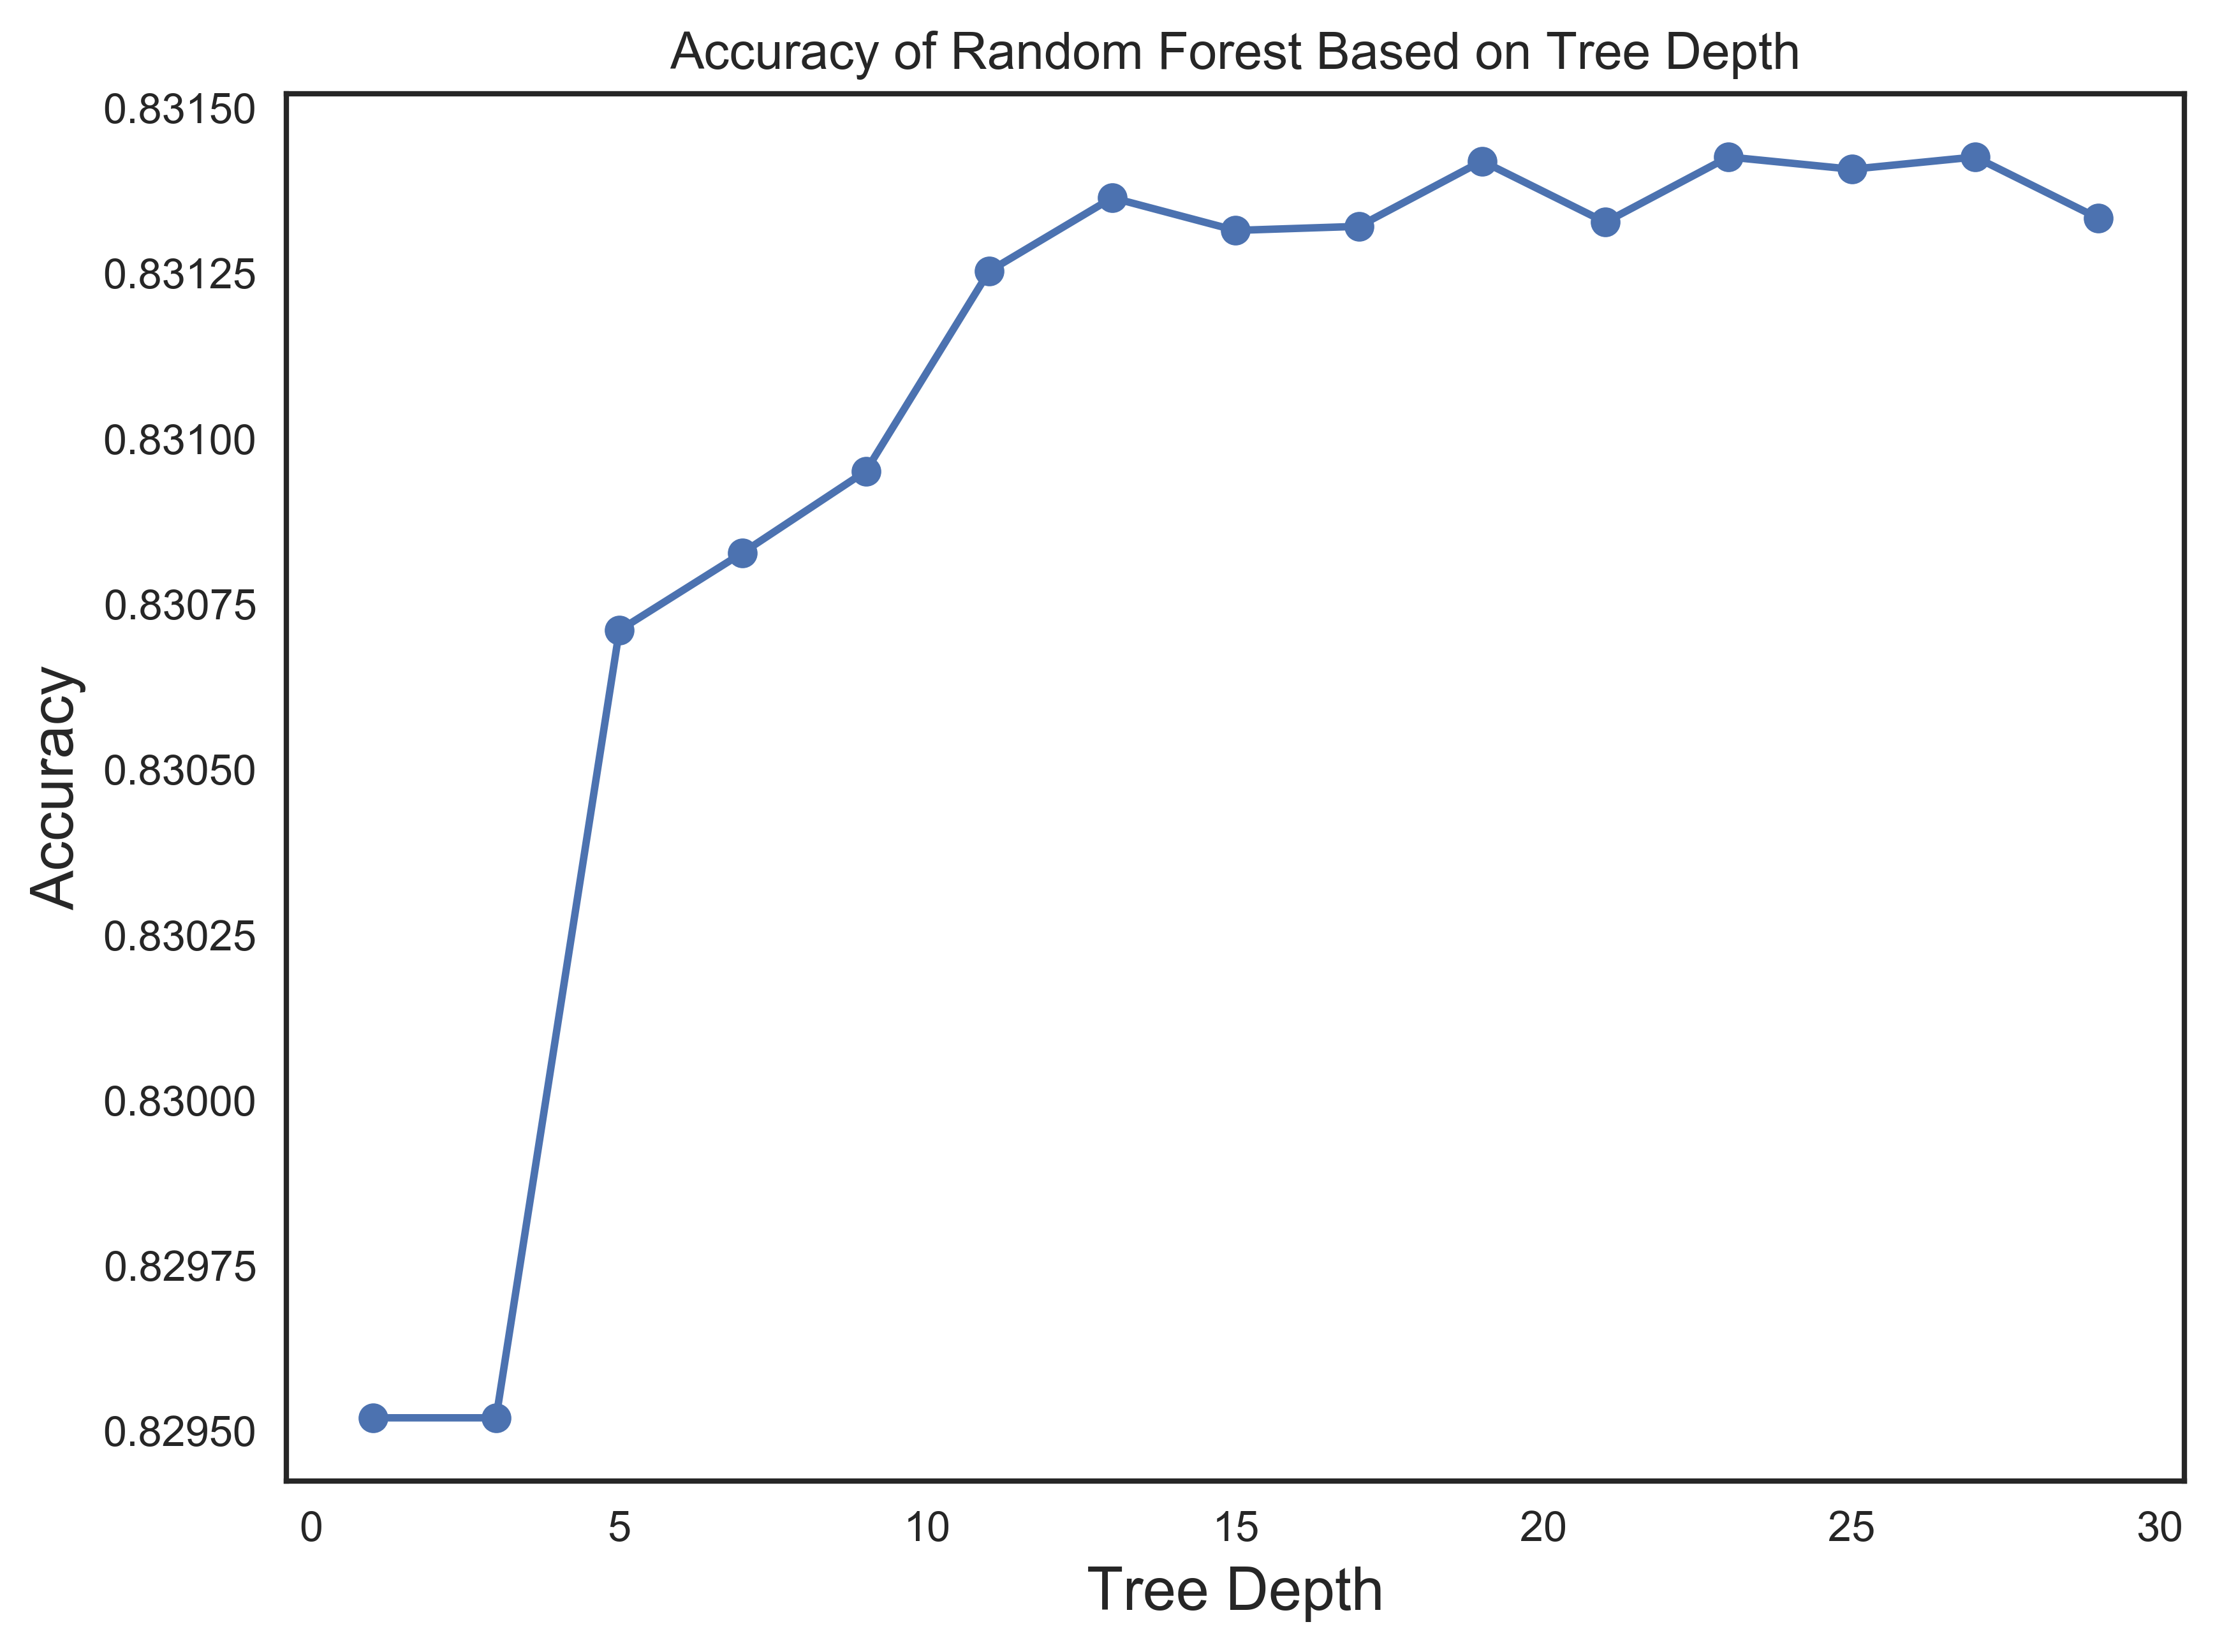

In [107]:
#Accuracy of Random Forest Based on Tree Depth
print accuracy_values
# index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
fig,ax=plt.subplots(num=None, figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k');
index = range(1,31,2)
print len(accuracy_values)
print index
plt.plot(index,accuracy_values,'o-')
plt.ylabel('Accuracy',fontsize = 14)
plt.xlabel('Tree Depth',fontsize = 14)
plt.title('Accuracy of Random Forest Based on Tree Depth',fontsize = 12)
plt.show()
fig.savefig('Accruacy_Tree_Depth.png', bbox_inches='tight')